In [1]:
from src.get_data import load_benchmark, load_synthetic
from src.normalization import get_adj_feats
from src.args import get_args
from src.models import get_model
from src.utils import accuracy, LDA_loss
from src.plots import plot_feature
import torch.optim as optim
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

In [2]:
dataset_name = 'SmallRatio'
model_name = 'GFNN'
args = get_args(model_opt = model_name, dataset = dataset_name)
# norm_method = 'sym'
# args.epochs = 500
weights = [9.4653e-05, 1.3430e-03, 3.7217e-03, 4.3682e-03, 9.4625e-01, 2.2844e-03, 4.1939e-02]

In [3]:
# args.lr = 0.02
# args.weight_decay = 5e-6

In [4]:
# train, test


def train(epoch, model, optimizer, adj, feats, labels, idx_train, idx_val, \
          idx_test, Y_onehot, nb_each_class_inv_mat_train,nb_each_class_inv_mat_val,nb_each_class_inv_mat_test):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, fp1, fp2 = model(feats, adj)
    CE_loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    if model_name == 'AGNNl':
        LDA_loss_train = LDA_loss(fp1[idx_train], Y_onehot[idx_train], nb_each_class_inv_mat_train, norm_or_not = True)
        loss_train = CE_loss_train - LDA_loss_train
#         loss_train = 0 - LDA_loss_train

    else:
        loss_train = CE_loss_train
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    model.eval()
    output, fp1, fp2 = model(feats, adj)
    
    CE_loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    if model_name == 'AGNNl':
        LDA_loss_val = LDA_loss(fp1[idx_val], Y_onehot[idx_val], nb_each_class_inv_mat_val, norm_or_not = True)
        loss_val = CE_loss_val - LDA_loss_val
#         loss_val = 0 - LDA_loss_val

    else:
        loss_val = CE_loss_val
    acc_val = accuracy(output[idx_val], labels[idx_val])
    
    CE_loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    if model_name == 'AGNNl':
        LDA_loss_test = LDA_loss(fp1[idx_test], Y_onehot[idx_test], nb_each_class_inv_mat_test, norm_or_not = True)
        loss_test = CE_loss_test - LDA_loss_test
#         loss_test = 0 - LDA_loss_test

    else:
        loss_test = CE_loss_test
    acc_test = accuracy(output[idx_test], labels[idx_test])
    
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
#           'loss_test: {:.4f}'.format(loss_test.item()),
#           'acc_test: {:.4f}'.format(acc_test.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return epoch+1, loss_train.item(), acc_train.item(), loss_val.item(), \
            acc_val.item(), loss_test.item(), acc_test.item(), time.time() - t, \
            




In [5]:
def get_result(dataset_name, split_index):
    adj, feats, labels, idx_train, idx_val, idx_test = load_synthetic(dataset_name, split_index)
    adj, feats = get_adj_feats(adj = adj, feats = feats, model_opt = model_name, degree = args.degree, weights=weights)
#     adj, feats = get_adj_feats(adj = adj, feats = feats, model_opt = 'AGNN', degree = args.degree)
#     weight = [0.0696, 0.1549, 0.1550, 0.1552, 0.1551, 0.1551, 0.1551]

#     adj_sum=weight[0] * torch.eye(adj[0].shape[1])
#     for i in range(len(adj)):
#         adj_sum = adj_sum + weight[i+1] * adj[i]
    
#     adj = adj_sum
    
#     -----------------------------------------------
    nb_class = (torch.max(labels) + 1).numpy()
    Y_onehot =  torch.zeros(labels.shape[0], nb_class).scatter_(1, labels.unsqueeze(-1), 1)

    nb_each_class_train = torch.sum(Y_onehot[idx_train], dim = 0)
    nb_each_class_inv_train = torch.tensor(np.power(nb_each_class_train.numpy(), -1).flatten())
    nb_each_class_inv_mat_train = torch.diag(nb_each_class_inv_train)

    nb_each_class_val = torch.sum(Y_onehot[idx_val], dim = 0)
    nb_each_class_inv_val = torch.tensor(np.power(nb_each_class_val.numpy(), -1).flatten())
    nb_each_class_inv_mat_val = torch.diag(nb_each_class_inv_val)

    nb_each_class_test = torch.sum(Y_onehot[idx_test], dim = 0)
    nb_each_class_inv_test = torch.tensor(np.power(nb_each_class_test.numpy(), -1).flatten())
    nb_each_class_inv_mat_test = torch.diag(nb_each_class_inv_test)
    
    
#     -----------------------------------------------    
    # get model
    model = get_model(model_opt = model_name, nfeat = feats.size(1), \
                      nclass = labels.max().item()+1, nhid = args.hidden, \
                      dropout = args.dropout, cuda = args.cuda, \
                      dataset = dataset_name, degree = args.degree)
    # optimizer
    optimizer = optim.Adam(model.parameters(),
                               lr=args.lr, weight_decay=args.weight_decay)


    if args.cuda:
        if model_name!='AGNN' and model_name!='GIN':
            model.cuda()
            feats = feats.cuda()
            adj = adj.cuda()
            labels = labels.cuda()
            idx_train = idx_train.cuda()
            idx_val = idx_val.cuda()
            idx_test = idx_test.cuda()



    # Print model's state_dict    
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor,"\t",model.state_dict()[param_tensor].size()) 
    print("optimizer's state_dict:")

    # Print optimizer's state_dict
    for var_name in optimizer.state_dict():
        print(var_name,"\t",optimizer.state_dict()[var_name])

    # # Print parameters
    # for name,param in model.named_parameters():
    #     print(name, param)
    
#     -----------------------------------------------
    training_log = []

    # Train model
    t_total = time.time()
    temp_val_loss = 999999
    temp_test_loss = 0
    temp_test_acc = 0
    PATH = "save/model_param/{}{}{}.pt".format(model_name, dataset_name, split_index)

    for epoch in range(args.epochs):

        epo, trainloss, trainacc, valloss, valacc, testloss, testacc, epotime = train(epoch, model, \
                                                                                      optimizer, adj, feats, \
                                                                                      labels, idx_train, idx_val,\
                                                                                      idx_test, Y_onehot, \
                                                                                      nb_each_class_inv_mat_train,\
                                                                                     nb_each_class_inv_mat_val,\
                                                                                     nb_each_class_inv_mat_test)
        training_log.append([epo, trainloss, trainacc, valloss, valacc, testloss, testacc, epotime])

        if valloss <= temp_val_loss:
            temp_val_loss = valloss
            temp_test_loss = testloss
            temp_test_acc = testacc
            torch.save(model.state_dict(), PATH)


    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    print("Best result:",
              "val_loss=",temp_val_loss,
                "test_loss=",temp_test_loss,
                 "test_acc=",temp_test_acc)
    bestmodel = torch.load(PATH)
    if model_name == 'AGNN':
        print("the weight is: ", torch.softmax(bestmodel['gc1.linear_weight'].data,dim=0))
        
    res_acc = temp_test_acc



    # # save training log
    # # expname = input('input experiment name: ')
    # expname = dataset_name + '_' + model_name + '_' + split_idx
    # log_pk = open('./save/trainlog_'+expname+'.pkl','wb')
    # pkl.dump(np.array(training_log),log_pk)
    # log_pk.close()
    # print("finish save log")

#     -----------------------------------------------
    # store result

    X_epoch = np.array(training_log)[:,0]
    Y1_trainloss = np.array(training_log)[:,1]
    Y2_valloss = np.array(training_log)[:,3]
    Y3_testloss = np.array(training_log)[:,5]

#     plt.plot(X_epoch, Y1_trainloss, color = 'k', label = 'train')
    plt.plot(X_epoch, Y2_valloss, color = 'b', label = 'val')
    plt.plot(X_epoch, Y3_testloss, color = 'r', linestyle = '-.', label = 'test')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc = 'upper right')
    plt.show()
    

    return res_acc

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4917315408, 4917317352]}]
Epoch: 0001 loss_train: 0.6587 acc_train: 0.7950 loss_val: 0.4935 acc_val: 0.8050 time: 0.0030s
Epoch: 0002 loss_train: 0.5050 acc_train: 0.7950 loss_val: 0.4909 acc_val: 0.8050 time: 0.0013s
Epoch: 0003 loss_train: 0.5096 acc_train: 0.7950 loss_val: 0.5248 acc_val: 0.8050 time: 0.0013s
Epoch: 0004 loss_train: 0.5475 acc_train: 0.7950 loss_val: 0.5404 acc_val: 0.8050 time: 0.0012s
Epoch: 0005 loss_train: 0.5646 acc_train: 0.7950 loss_val: 0.5332 acc_val: 0.8050 time: 0.0017s
Epoch: 0006 loss_train: 0.5567 acc_train: 0.7950 loss_val: 0.5125 acc_val: 0.8050 time: 0.0019s
Epoch: 0007 loss_train: 0.5338 acc_train: 0.7950 loss_val: 0.4904 ac

Epoch: 0102 loss_train: 0.4306 acc_train: 0.7950 loss_val: 0.4278 acc_val: 0.8050 time: 0.0015s
Epoch: 0103 loss_train: 0.4299 acc_train: 0.7950 loss_val: 0.4272 acc_val: 0.8050 time: 0.0014s
Epoch: 0104 loss_train: 0.4293 acc_train: 0.7950 loss_val: 0.4267 acc_val: 0.8050 time: 0.0020s
Epoch: 0105 loss_train: 0.4286 acc_train: 0.7950 loss_val: 0.4262 acc_val: 0.8050 time: 0.0043s
Epoch: 0106 loss_train: 0.4279 acc_train: 0.7950 loss_val: 0.4256 acc_val: 0.8050 time: 0.0013s
Epoch: 0107 loss_train: 0.4272 acc_train: 0.7950 loss_val: 0.4251 acc_val: 0.8050 time: 0.0013s
Epoch: 0108 loss_train: 0.4265 acc_train: 0.7950 loss_val: 0.4245 acc_val: 0.8050 time: 0.0013s
Epoch: 0109 loss_train: 0.4259 acc_train: 0.7950 loss_val: 0.4239 acc_val: 0.8050 time: 0.0013s
Epoch: 0110 loss_train: 0.4252 acc_train: 0.7950 loss_val: 0.4234 acc_val: 0.8050 time: 0.0014s
Epoch: 0111 loss_train: 0.4245 acc_train: 0.7950 loss_val: 0.4228 acc_val: 0.8050 time: 0.0012s
Epoch: 0112 loss_train: 0.4238 acc_train

Epoch: 0222 loss_train: 0.3612 acc_train: 0.8000 loss_val: 0.3692 acc_val: 0.8100 time: 0.0018s
Epoch: 0223 loss_train: 0.3607 acc_train: 0.8000 loss_val: 0.3688 acc_val: 0.8100 time: 0.0013s
Epoch: 0224 loss_train: 0.3603 acc_train: 0.8000 loss_val: 0.3684 acc_val: 0.8100 time: 0.0037s
Epoch: 0225 loss_train: 0.3598 acc_train: 0.8000 loss_val: 0.3680 acc_val: 0.8100 time: 0.0014s
Epoch: 0226 loss_train: 0.3594 acc_train: 0.8000 loss_val: 0.3676 acc_val: 0.8100 time: 0.0015s
Epoch: 0227 loss_train: 0.3589 acc_train: 0.8000 loss_val: 0.3672 acc_val: 0.8100 time: 0.0013s
Epoch: 0228 loss_train: 0.3584 acc_train: 0.8000 loss_val: 0.3667 acc_val: 0.8100 time: 0.0025s
Epoch: 0229 loss_train: 0.3580 acc_train: 0.8000 loss_val: 0.3663 acc_val: 0.8100 time: 0.0015s
Epoch: 0230 loss_train: 0.3575 acc_train: 0.8000 loss_val: 0.3659 acc_val: 0.8100 time: 0.0016s
Epoch: 0231 loss_train: 0.3571 acc_train: 0.8000 loss_val: 0.3655 acc_val: 0.8100 time: 0.0013s
Epoch: 0232 loss_train: 0.3566 acc_train

Epoch: 0338 loss_train: 0.3174 acc_train: 0.8250 loss_val: 0.3280 acc_val: 0.8450 time: 0.0060s
Epoch: 0339 loss_train: 0.3171 acc_train: 0.8250 loss_val: 0.3277 acc_val: 0.8450 time: 0.0016s
Epoch: 0340 loss_train: 0.3168 acc_train: 0.8250 loss_val: 0.3274 acc_val: 0.8450 time: 0.0022s
Epoch: 0341 loss_train: 0.3165 acc_train: 0.8250 loss_val: 0.3272 acc_val: 0.8450 time: 0.0022s
Epoch: 0342 loss_train: 0.3162 acc_train: 0.8250 loss_val: 0.3269 acc_val: 0.8450 time: 0.0016s
Epoch: 0343 loss_train: 0.3160 acc_train: 0.8250 loss_val: 0.3266 acc_val: 0.8450 time: 0.0047s
Epoch: 0344 loss_train: 0.3157 acc_train: 0.8250 loss_val: 0.3263 acc_val: 0.8450 time: 0.0018s
Epoch: 0345 loss_train: 0.3154 acc_train: 0.8250 loss_val: 0.3260 acc_val: 0.8450 time: 0.0016s
Epoch: 0346 loss_train: 0.3151 acc_train: 0.8250 loss_val: 0.3257 acc_val: 0.8500 time: 0.0058s
Epoch: 0347 loss_train: 0.3148 acc_train: 0.8250 loss_val: 0.3254 acc_val: 0.8500 time: 0.0013s
Epoch: 0348 loss_train: 0.3145 acc_train

Epoch: 0441 loss_train: 0.2921 acc_train: 0.8600 loss_val: 0.3014 acc_val: 0.8550 time: 0.0016s
Epoch: 0442 loss_train: 0.2919 acc_train: 0.8650 loss_val: 0.3012 acc_val: 0.8550 time: 0.0014s
Epoch: 0443 loss_train: 0.2917 acc_train: 0.8650 loss_val: 0.3009 acc_val: 0.8550 time: 0.0015s
Epoch: 0444 loss_train: 0.2915 acc_train: 0.8650 loss_val: 0.3007 acc_val: 0.8550 time: 0.0014s
Epoch: 0445 loss_train: 0.2913 acc_train: 0.8650 loss_val: 0.3005 acc_val: 0.8600 time: 0.0019s
Epoch: 0446 loss_train: 0.2911 acc_train: 0.8650 loss_val: 0.3003 acc_val: 0.8600 time: 0.0013s
Epoch: 0447 loss_train: 0.2909 acc_train: 0.8650 loss_val: 0.3001 acc_val: 0.8600 time: 0.0028s
Epoch: 0448 loss_train: 0.2907 acc_train: 0.8700 loss_val: 0.2998 acc_val: 0.8600 time: 0.0016s
Epoch: 0449 loss_train: 0.2905 acc_train: 0.8700 loss_val: 0.2996 acc_val: 0.8600 time: 0.0014s
Epoch: 0450 loss_train: 0.2903 acc_train: 0.8700 loss_val: 0.2994 acc_val: 0.8600 time: 0.0031s
Epoch: 0451 loss_train: 0.2901 acc_train

Epoch: 0556 loss_train: 0.2732 acc_train: 0.8700 loss_val: 0.2796 acc_val: 0.8750 time: 0.0038s
Epoch: 0557 loss_train: 0.2730 acc_train: 0.8700 loss_val: 0.2794 acc_val: 0.8750 time: 0.0018s
Epoch: 0558 loss_train: 0.2729 acc_train: 0.8700 loss_val: 0.2793 acc_val: 0.8750 time: 0.0015s
Epoch: 0559 loss_train: 0.2728 acc_train: 0.8750 loss_val: 0.2791 acc_val: 0.8750 time: 0.0037s
Epoch: 0560 loss_train: 0.2726 acc_train: 0.8750 loss_val: 0.2790 acc_val: 0.8750 time: 0.0018s
Epoch: 0561 loss_train: 0.2725 acc_train: 0.8750 loss_val: 0.2788 acc_val: 0.8750 time: 0.0017s
Epoch: 0562 loss_train: 0.2724 acc_train: 0.8750 loss_val: 0.2787 acc_val: 0.8750 time: 0.0025s
Epoch: 0563 loss_train: 0.2722 acc_train: 0.8750 loss_val: 0.2785 acc_val: 0.8750 time: 0.0020s
Epoch: 0564 loss_train: 0.2721 acc_train: 0.8750 loss_val: 0.2783 acc_val: 0.8750 time: 0.0014s
Epoch: 0565 loss_train: 0.2720 acc_train: 0.8750 loss_val: 0.2782 acc_val: 0.8750 time: 0.0026s
Epoch: 0566 loss_train: 0.2718 acc_train

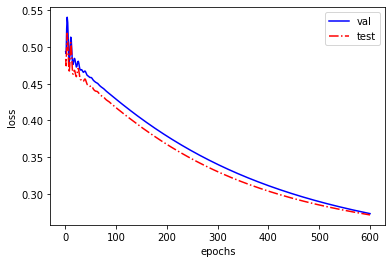

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4917296008, 4917295216]}]
Epoch: 0001 loss_train: 0.7374 acc_train: 0.1950 loss_val: 0.5078 acc_val: 0.8150 time: 0.0051s
Epoch: 0002 loss_train: 0.5152 acc_train: 0.8050 loss_val: 0.4659 acc_val: 0.8150 time: 0.0022s
Epoch: 0003 loss_train: 0.4806 acc_train: 0.8050 loss_val: 0.4977 acc_val: 0.8150 time: 0.0056s
Epoch: 0004 loss_train: 0.5176 acc_train: 0.8050 loss_val: 0.5307 acc_val: 0.8150 time: 0.0032s
Epoch: 0005 loss_train: 0.5536 acc_train: 0.8050 loss_val: 0.5444 acc_val: 0.8150 time: 0.0017s
Epoch: 0006 loss_train: 0.5683 acc_train: 0.8050 loss_val: 0.5386 acc_val: 0.8150 time: 0.0042s
Epoch: 0007 loss_train: 0.5620 acc_train: 0.8050 loss_val: 0.5192 ac

Epoch: 0096 loss_train: 0.4329 acc_train: 0.8050 loss_val: 0.4250 acc_val: 0.8150 time: 0.0052s
Epoch: 0097 loss_train: 0.4324 acc_train: 0.8050 loss_val: 0.4245 acc_val: 0.8150 time: 0.0038s
Epoch: 0098 loss_train: 0.4318 acc_train: 0.8050 loss_val: 0.4240 acc_val: 0.8150 time: 0.0025s
Epoch: 0099 loss_train: 0.4313 acc_train: 0.8050 loss_val: 0.4235 acc_val: 0.8150 time: 0.0020s
Epoch: 0100 loss_train: 0.4307 acc_train: 0.8050 loss_val: 0.4229 acc_val: 0.8150 time: 0.0025s
Epoch: 0101 loss_train: 0.4302 acc_train: 0.8050 loss_val: 0.4224 acc_val: 0.8150 time: 0.0049s
Epoch: 0102 loss_train: 0.4297 acc_train: 0.8050 loss_val: 0.4220 acc_val: 0.8150 time: 0.0036s
Epoch: 0103 loss_train: 0.4291 acc_train: 0.8050 loss_val: 0.4215 acc_val: 0.8150 time: 0.0041s
Epoch: 0104 loss_train: 0.4286 acc_train: 0.8050 loss_val: 0.4210 acc_val: 0.8150 time: 0.0018s
Epoch: 0105 loss_train: 0.4280 acc_train: 0.8050 loss_val: 0.4206 acc_val: 0.8150 time: 0.0032s
Epoch: 0106 loss_train: 0.4275 acc_train

Epoch: 0203 loss_train: 0.3795 acc_train: 0.8050 loss_val: 0.3776 acc_val: 0.8150 time: 0.0059s
Epoch: 0204 loss_train: 0.3791 acc_train: 0.8050 loss_val: 0.3772 acc_val: 0.8150 time: 0.0014s
Epoch: 0205 loss_train: 0.3786 acc_train: 0.8050 loss_val: 0.3768 acc_val: 0.8150 time: 0.0018s
Epoch: 0206 loss_train: 0.3782 acc_train: 0.8050 loss_val: 0.3764 acc_val: 0.8150 time: 0.0027s
Epoch: 0207 loss_train: 0.3777 acc_train: 0.8050 loss_val: 0.3760 acc_val: 0.8150 time: 0.0017s
Epoch: 0208 loss_train: 0.3773 acc_train: 0.8050 loss_val: 0.3756 acc_val: 0.8150 time: 0.0029s
Epoch: 0209 loss_train: 0.3769 acc_train: 0.8050 loss_val: 0.3752 acc_val: 0.8150 time: 0.0016s
Epoch: 0210 loss_train: 0.3764 acc_train: 0.8050 loss_val: 0.3749 acc_val: 0.8150 time: 0.0021s
Epoch: 0211 loss_train: 0.3760 acc_train: 0.8050 loss_val: 0.3745 acc_val: 0.8150 time: 0.0035s
Epoch: 0212 loss_train: 0.3755 acc_train: 0.8050 loss_val: 0.3741 acc_val: 0.8150 time: 0.0013s
Epoch: 0213 loss_train: 0.3751 acc_train

Epoch: 0306 loss_train: 0.3386 acc_train: 0.8200 loss_val: 0.3414 acc_val: 0.8300 time: 0.0055s
Epoch: 0307 loss_train: 0.3382 acc_train: 0.8200 loss_val: 0.3411 acc_val: 0.8300 time: 0.0036s
Epoch: 0308 loss_train: 0.3379 acc_train: 0.8200 loss_val: 0.3408 acc_val: 0.8300 time: 0.0019s
Epoch: 0309 loss_train: 0.3375 acc_train: 0.8200 loss_val: 0.3405 acc_val: 0.8300 time: 0.0027s
Epoch: 0310 loss_train: 0.3372 acc_train: 0.8200 loss_val: 0.3402 acc_val: 0.8300 time: 0.0017s
Epoch: 0311 loss_train: 0.3368 acc_train: 0.8200 loss_val: 0.3399 acc_val: 0.8300 time: 0.0029s
Epoch: 0312 loss_train: 0.3365 acc_train: 0.8200 loss_val: 0.3396 acc_val: 0.8300 time: 0.0035s
Epoch: 0313 loss_train: 0.3362 acc_train: 0.8200 loss_val: 0.3393 acc_val: 0.8300 time: 0.0015s
Epoch: 0314 loss_train: 0.3358 acc_train: 0.8200 loss_val: 0.3390 acc_val: 0.8300 time: 0.0016s
Epoch: 0315 loss_train: 0.3355 acc_train: 0.8200 loss_val: 0.3387 acc_val: 0.8300 time: 0.0022s
Epoch: 0316 loss_train: 0.3351 acc_train

Epoch: 0412 loss_train: 0.3061 acc_train: 0.8550 loss_val: 0.3134 acc_val: 0.8500 time: 0.0022s
Epoch: 0413 loss_train: 0.3058 acc_train: 0.8550 loss_val: 0.3132 acc_val: 0.8500 time: 0.0014s
Epoch: 0414 loss_train: 0.3056 acc_train: 0.8550 loss_val: 0.3129 acc_val: 0.8500 time: 0.0015s
Epoch: 0415 loss_train: 0.3053 acc_train: 0.8550 loss_val: 0.3127 acc_val: 0.8500 time: 0.0045s
Epoch: 0416 loss_train: 0.3050 acc_train: 0.8550 loss_val: 0.3125 acc_val: 0.8500 time: 0.0019s
Epoch: 0417 loss_train: 0.3048 acc_train: 0.8600 loss_val: 0.3123 acc_val: 0.8500 time: 0.0025s
Epoch: 0418 loss_train: 0.3045 acc_train: 0.8600 loss_val: 0.3121 acc_val: 0.8500 time: 0.0016s
Epoch: 0419 loss_train: 0.3042 acc_train: 0.8600 loss_val: 0.3118 acc_val: 0.8500 time: 0.0013s
Epoch: 0420 loss_train: 0.3040 acc_train: 0.8600 loss_val: 0.3116 acc_val: 0.8500 time: 0.0013s
Epoch: 0421 loss_train: 0.3037 acc_train: 0.8600 loss_val: 0.3114 acc_val: 0.8500 time: 0.0013s
Epoch: 0422 loss_train: 0.3035 acc_train

Epoch: 0522 loss_train: 0.2808 acc_train: 0.8800 loss_val: 0.2923 acc_val: 0.8750 time: 0.0090s
Epoch: 0523 loss_train: 0.2806 acc_train: 0.8800 loss_val: 0.2921 acc_val: 0.8750 time: 0.0024s
Epoch: 0524 loss_train: 0.2804 acc_train: 0.8800 loss_val: 0.2919 acc_val: 0.8750 time: 0.0045s
Epoch: 0525 loss_train: 0.2802 acc_train: 0.8800 loss_val: 0.2918 acc_val: 0.8750 time: 0.0028s
Epoch: 0526 loss_train: 0.2800 acc_train: 0.8800 loss_val: 0.2916 acc_val: 0.8750 time: 0.0048s
Epoch: 0527 loss_train: 0.2798 acc_train: 0.8800 loss_val: 0.2914 acc_val: 0.8750 time: 0.0035s
Epoch: 0528 loss_train: 0.2796 acc_train: 0.8800 loss_val: 0.2913 acc_val: 0.8750 time: 0.0027s
Epoch: 0529 loss_train: 0.2794 acc_train: 0.8800 loss_val: 0.2911 acc_val: 0.8750 time: 0.0023s
Epoch: 0530 loss_train: 0.2792 acc_train: 0.8800 loss_val: 0.2910 acc_val: 0.8750 time: 0.0017s
Epoch: 0531 loss_train: 0.2790 acc_train: 0.8800 loss_val: 0.2908 acc_val: 0.8750 time: 0.0053s
Epoch: 0532 loss_train: 0.2788 acc_train

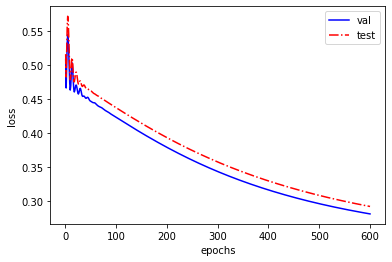

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4917316992, 4917315264]}]
Epoch: 0001 loss_train: 0.7003 acc_train: 0.1850 loss_val: 0.5053 acc_val: 0.8050 time: 0.0023s
Epoch: 0002 loss_train: 0.4963 acc_train: 0.8150 loss_val: 0.4880 acc_val: 0.8050 time: 0.0022s
Epoch: 0003 loss_train: 0.4709 acc_train: 0.8150 loss_val: 0.5302 acc_val: 0.8050 time: 0.0014s
Epoch: 0004 loss_train: 0.5074 acc_train: 0.8150 loss_val: 0.5657 acc_val: 0.8050 time: 0.0014s
Epoch: 0005 loss_train: 0.5397 acc_train: 0.8150 loss_val: 0.5779 acc_val: 0.8050 time: 0.0017s
Epoch: 0006 loss_train: 0.5509 acc_train: 0.8150 loss_val: 0.5689 acc_val: 0.8050 time: 0.0025s
Epoch: 0007 loss_train: 0.5426 acc_train: 0.8150 loss_val: 0.5458 ac

Epoch: 0102 loss_train: 0.4206 acc_train: 0.8150 loss_val: 0.4373 acc_val: 0.8050 time: 0.0056s
Epoch: 0103 loss_train: 0.4201 acc_train: 0.8150 loss_val: 0.4368 acc_val: 0.8050 time: 0.0050s
Epoch: 0104 loss_train: 0.4195 acc_train: 0.8150 loss_val: 0.4362 acc_val: 0.8050 time: 0.0019s
Epoch: 0105 loss_train: 0.4190 acc_train: 0.8150 loss_val: 0.4357 acc_val: 0.8050 time: 0.0024s
Epoch: 0106 loss_train: 0.4185 acc_train: 0.8150 loss_val: 0.4352 acc_val: 0.8050 time: 0.0029s
Epoch: 0107 loss_train: 0.4180 acc_train: 0.8150 loss_val: 0.4347 acc_val: 0.8050 time: 0.0018s
Epoch: 0108 loss_train: 0.4175 acc_train: 0.8150 loss_val: 0.4342 acc_val: 0.8050 time: 0.0059s
Epoch: 0109 loss_train: 0.4169 acc_train: 0.8150 loss_val: 0.4338 acc_val: 0.8050 time: 0.0018s
Epoch: 0110 loss_train: 0.4164 acc_train: 0.8150 loss_val: 0.4333 acc_val: 0.8050 time: 0.0055s
Epoch: 0111 loss_train: 0.4159 acc_train: 0.8150 loss_val: 0.4329 acc_val: 0.8050 time: 0.0021s
Epoch: 0112 loss_train: 0.4154 acc_train

Epoch: 0201 loss_train: 0.3728 acc_train: 0.8150 loss_val: 0.3923 acc_val: 0.8050 time: 0.0043s
Epoch: 0202 loss_train: 0.3723 acc_train: 0.8150 loss_val: 0.3918 acc_val: 0.8050 time: 0.0037s
Epoch: 0203 loss_train: 0.3719 acc_train: 0.8150 loss_val: 0.3914 acc_val: 0.8050 time: 0.0038s
Epoch: 0204 loss_train: 0.3715 acc_train: 0.8150 loss_val: 0.3910 acc_val: 0.8050 time: 0.0017s
Epoch: 0205 loss_train: 0.3710 acc_train: 0.8150 loss_val: 0.3906 acc_val: 0.8050 time: 0.0020s
Epoch: 0206 loss_train: 0.3706 acc_train: 0.8150 loss_val: 0.3902 acc_val: 0.8050 time: 0.0033s
Epoch: 0207 loss_train: 0.3702 acc_train: 0.8150 loss_val: 0.3898 acc_val: 0.8050 time: 0.0019s
Epoch: 0208 loss_train: 0.3698 acc_train: 0.8150 loss_val: 0.3894 acc_val: 0.8050 time: 0.0014s
Epoch: 0209 loss_train: 0.3693 acc_train: 0.8150 loss_val: 0.3890 acc_val: 0.8050 time: 0.0024s
Epoch: 0210 loss_train: 0.3689 acc_train: 0.8150 loss_val: 0.3886 acc_val: 0.8050 time: 0.0020s
Epoch: 0211 loss_train: 0.3685 acc_train

Epoch: 0307 loss_train: 0.3327 acc_train: 0.8300 loss_val: 0.3539 acc_val: 0.8050 time: 0.0046s
Epoch: 0308 loss_train: 0.3324 acc_train: 0.8300 loss_val: 0.3536 acc_val: 0.8050 time: 0.0017s
Epoch: 0309 loss_train: 0.3321 acc_train: 0.8300 loss_val: 0.3533 acc_val: 0.8050 time: 0.0024s
Epoch: 0310 loss_train: 0.3318 acc_train: 0.8300 loss_val: 0.3530 acc_val: 0.8050 time: 0.0067s
Epoch: 0311 loss_train: 0.3315 acc_train: 0.8300 loss_val: 0.3526 acc_val: 0.8050 time: 0.0030s
Epoch: 0312 loss_train: 0.3311 acc_train: 0.8300 loss_val: 0.3523 acc_val: 0.8050 time: 0.0029s
Epoch: 0313 loss_train: 0.3308 acc_train: 0.8300 loss_val: 0.3520 acc_val: 0.8050 time: 0.0013s
Epoch: 0314 loss_train: 0.3305 acc_train: 0.8300 loss_val: 0.3517 acc_val: 0.8050 time: 0.0013s
Epoch: 0315 loss_train: 0.3302 acc_train: 0.8300 loss_val: 0.3514 acc_val: 0.8050 time: 0.0013s
Epoch: 0316 loss_train: 0.3299 acc_train: 0.8300 loss_val: 0.3511 acc_val: 0.8050 time: 0.0023s
Epoch: 0317 loss_train: 0.3296 acc_train

Epoch: 0407 loss_train: 0.3051 acc_train: 0.8400 loss_val: 0.3267 acc_val: 0.8250 time: 0.0026s
Epoch: 0408 loss_train: 0.3049 acc_train: 0.8400 loss_val: 0.3265 acc_val: 0.8250 time: 0.0017s
Epoch: 0409 loss_train: 0.3046 acc_train: 0.8400 loss_val: 0.3263 acc_val: 0.8250 time: 0.0024s
Epoch: 0410 loss_train: 0.3044 acc_train: 0.8400 loss_val: 0.3261 acc_val: 0.8250 time: 0.0050s
Epoch: 0411 loss_train: 0.3042 acc_train: 0.8450 loss_val: 0.3258 acc_val: 0.8250 time: 0.0020s
Epoch: 0412 loss_train: 0.3040 acc_train: 0.8450 loss_val: 0.3256 acc_val: 0.8250 time: 0.0018s
Epoch: 0413 loss_train: 0.3037 acc_train: 0.8450 loss_val: 0.3254 acc_val: 0.8250 time: 0.0016s
Epoch: 0414 loss_train: 0.3035 acc_train: 0.8450 loss_val: 0.3251 acc_val: 0.8250 time: 0.0025s
Epoch: 0415 loss_train: 0.3033 acc_train: 0.8450 loss_val: 0.3249 acc_val: 0.8250 time: 0.0015s
Epoch: 0416 loss_train: 0.3030 acc_train: 0.8450 loss_val: 0.3247 acc_val: 0.8250 time: 0.0023s
Epoch: 0417 loss_train: 0.3028 acc_train

Epoch: 0519 loss_train: 0.2830 acc_train: 0.8650 loss_val: 0.3045 acc_val: 0.8300 time: 0.0020s
Epoch: 0520 loss_train: 0.2829 acc_train: 0.8650 loss_val: 0.3043 acc_val: 0.8300 time: 0.0026s
Epoch: 0521 loss_train: 0.2827 acc_train: 0.8650 loss_val: 0.3041 acc_val: 0.8300 time: 0.0017s
Epoch: 0522 loss_train: 0.2825 acc_train: 0.8650 loss_val: 0.3040 acc_val: 0.8300 time: 0.0021s
Epoch: 0523 loss_train: 0.2824 acc_train: 0.8650 loss_val: 0.3038 acc_val: 0.8300 time: 0.0034s
Epoch: 0524 loss_train: 0.2822 acc_train: 0.8650 loss_val: 0.3036 acc_val: 0.8300 time: 0.0044s
Epoch: 0525 loss_train: 0.2820 acc_train: 0.8650 loss_val: 0.3035 acc_val: 0.8300 time: 0.0040s
Epoch: 0526 loss_train: 0.2819 acc_train: 0.8650 loss_val: 0.3033 acc_val: 0.8300 time: 0.0033s
Epoch: 0527 loss_train: 0.2817 acc_train: 0.8650 loss_val: 0.3032 acc_val: 0.8300 time: 0.0018s
Epoch: 0528 loss_train: 0.2816 acc_train: 0.8650 loss_val: 0.3030 acc_val: 0.8300 time: 0.0023s
Epoch: 0529 loss_train: 0.2814 acc_train

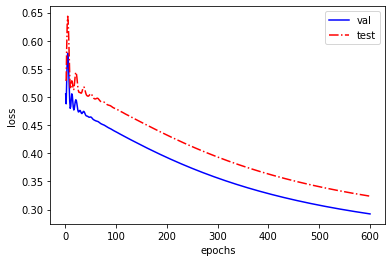

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4923216808, 4923218896]}]
Epoch: 0001 loss_train: 0.6917 acc_train: 0.7500 loss_val: 0.5261 acc_val: 0.7800 time: 0.0049s
Epoch: 0002 loss_train: 0.5021 acc_train: 0.8050 loss_val: 0.5302 acc_val: 0.7800 time: 0.0019s
Epoch: 0003 loss_train: 0.4872 acc_train: 0.8050 loss_val: 0.5816 acc_val: 0.7800 time: 0.0014s
Epoch: 0004 loss_train: 0.5263 acc_train: 0.8050 loss_val: 0.6163 acc_val: 0.7800 time: 0.0019s
Epoch: 0005 loss_train: 0.5549 acc_train: 0.8050 loss_val: 0.6223 acc_val: 0.7800 time: 0.0020s
Epoch: 0006 loss_train: 0.5598 acc_train: 0.8050 loss_val: 0.6051 acc_val: 0.7800 time: 0.0015s
Epoch: 0007 loss_train: 0.5453 acc_train: 0.8050 loss_val: 0.5747 ac

Epoch: 0101 loss_train: 0.4316 acc_train: 0.8050 loss_val: 0.4724 acc_val: 0.7800 time: 0.0021s
Epoch: 0102 loss_train: 0.4310 acc_train: 0.8050 loss_val: 0.4719 acc_val: 0.7800 time: 0.0017s
Epoch: 0103 loss_train: 0.4305 acc_train: 0.8050 loss_val: 0.4713 acc_val: 0.7800 time: 0.0038s
Epoch: 0104 loss_train: 0.4299 acc_train: 0.8050 loss_val: 0.4708 acc_val: 0.7800 time: 0.0024s
Epoch: 0105 loss_train: 0.4294 acc_train: 0.8050 loss_val: 0.4704 acc_val: 0.7800 time: 0.0037s
Epoch: 0106 loss_train: 0.4288 acc_train: 0.8050 loss_val: 0.4699 acc_val: 0.7800 time: 0.0025s
Epoch: 0107 loss_train: 0.4283 acc_train: 0.8050 loss_val: 0.4695 acc_val: 0.7800 time: 0.0025s
Epoch: 0108 loss_train: 0.4277 acc_train: 0.8050 loss_val: 0.4690 acc_val: 0.7800 time: 0.0014s
Epoch: 0109 loss_train: 0.4272 acc_train: 0.8050 loss_val: 0.4685 acc_val: 0.7800 time: 0.0053s
Epoch: 0110 loss_train: 0.4267 acc_train: 0.8050 loss_val: 0.4680 acc_val: 0.7800 time: 0.0033s
Epoch: 0111 loss_train: 0.4261 acc_train

Epoch: 0230 loss_train: 0.3683 acc_train: 0.8050 loss_val: 0.4118 acc_val: 0.7800 time: 0.0020s
Epoch: 0231 loss_train: 0.3678 acc_train: 0.8050 loss_val: 0.4114 acc_val: 0.7800 time: 0.0016s
Epoch: 0232 loss_train: 0.3674 acc_train: 0.8050 loss_val: 0.4110 acc_val: 0.7800 time: 0.0018s
Epoch: 0233 loss_train: 0.3670 acc_train: 0.8050 loss_val: 0.4105 acc_val: 0.7800 time: 0.0023s
Epoch: 0234 loss_train: 0.3666 acc_train: 0.8050 loss_val: 0.4101 acc_val: 0.7800 time: 0.0031s
Epoch: 0235 loss_train: 0.3662 acc_train: 0.8050 loss_val: 0.4097 acc_val: 0.7800 time: 0.0015s
Epoch: 0236 loss_train: 0.3657 acc_train: 0.8050 loss_val: 0.4093 acc_val: 0.7800 time: 0.0014s
Epoch: 0237 loss_train: 0.3653 acc_train: 0.8050 loss_val: 0.4089 acc_val: 0.7800 time: 0.0014s
Epoch: 0238 loss_train: 0.3649 acc_train: 0.8050 loss_val: 0.4085 acc_val: 0.7800 time: 0.0016s
Epoch: 0239 loss_train: 0.3645 acc_train: 0.8050 loss_val: 0.4080 acc_val: 0.7800 time: 0.0014s
Epoch: 0240 loss_train: 0.3641 acc_train

Epoch: 0337 loss_train: 0.3291 acc_train: 0.8250 loss_val: 0.3723 acc_val: 0.8100 time: 0.0041s
Epoch: 0338 loss_train: 0.3288 acc_train: 0.8250 loss_val: 0.3720 acc_val: 0.8100 time: 0.0040s
Epoch: 0339 loss_train: 0.3284 acc_train: 0.8250 loss_val: 0.3717 acc_val: 0.8100 time: 0.0021s
Epoch: 0340 loss_train: 0.3281 acc_train: 0.8250 loss_val: 0.3714 acc_val: 0.8100 time: 0.0059s
Epoch: 0341 loss_train: 0.3278 acc_train: 0.8250 loss_val: 0.3710 acc_val: 0.8100 time: 0.0017s
Epoch: 0342 loss_train: 0.3275 acc_train: 0.8250 loss_val: 0.3707 acc_val: 0.8100 time: 0.0052s
Epoch: 0343 loss_train: 0.3272 acc_train: 0.8250 loss_val: 0.3704 acc_val: 0.8100 time: 0.0034s
Epoch: 0344 loss_train: 0.3269 acc_train: 0.8250 loss_val: 0.3701 acc_val: 0.8100 time: 0.0025s
Epoch: 0345 loss_train: 0.3266 acc_train: 0.8250 loss_val: 0.3698 acc_val: 0.8150 time: 0.0042s
Epoch: 0346 loss_train: 0.3263 acc_train: 0.8250 loss_val: 0.3695 acc_val: 0.8150 time: 0.0036s
Epoch: 0347 loss_train: 0.3260 acc_train

Epoch: 0443 loss_train: 0.3011 acc_train: 0.8350 loss_val: 0.3433 acc_val: 0.8300 time: 0.0017s
Epoch: 0444 loss_train: 0.3008 acc_train: 0.8350 loss_val: 0.3431 acc_val: 0.8300 time: 0.0026s
Epoch: 0445 loss_train: 0.3006 acc_train: 0.8350 loss_val: 0.3428 acc_val: 0.8300 time: 0.0031s
Epoch: 0446 loss_train: 0.3004 acc_train: 0.8350 loss_val: 0.3426 acc_val: 0.8300 time: 0.0016s
Epoch: 0447 loss_train: 0.3002 acc_train: 0.8350 loss_val: 0.3424 acc_val: 0.8300 time: 0.0020s
Epoch: 0448 loss_train: 0.3000 acc_train: 0.8350 loss_val: 0.3421 acc_val: 0.8300 time: 0.0019s
Epoch: 0449 loss_train: 0.2997 acc_train: 0.8350 loss_val: 0.3419 acc_val: 0.8350 time: 0.0014s
Epoch: 0450 loss_train: 0.2995 acc_train: 0.8350 loss_val: 0.3417 acc_val: 0.8350 time: 0.0018s
Epoch: 0451 loss_train: 0.2993 acc_train: 0.8350 loss_val: 0.3414 acc_val: 0.8350 time: 0.0015s
Epoch: 0452 loss_train: 0.2991 acc_train: 0.8400 loss_val: 0.3412 acc_val: 0.8350 time: 0.0015s
Epoch: 0453 loss_train: 0.2989 acc_train

Epoch: 0560 loss_train: 0.2794 acc_train: 0.8650 loss_val: 0.3203 acc_val: 0.8750 time: 0.0019s
Epoch: 0561 loss_train: 0.2792 acc_train: 0.8650 loss_val: 0.3201 acc_val: 0.8750 time: 0.0015s
Epoch: 0562 loss_train: 0.2790 acc_train: 0.8650 loss_val: 0.3200 acc_val: 0.8750 time: 0.0017s
Epoch: 0563 loss_train: 0.2789 acc_train: 0.8650 loss_val: 0.3198 acc_val: 0.8750 time: 0.0014s
Epoch: 0564 loss_train: 0.2787 acc_train: 0.8650 loss_val: 0.3196 acc_val: 0.8750 time: 0.0014s
Epoch: 0565 loss_train: 0.2786 acc_train: 0.8650 loss_val: 0.3195 acc_val: 0.8750 time: 0.0014s
Epoch: 0566 loss_train: 0.2784 acc_train: 0.8650 loss_val: 0.3193 acc_val: 0.8750 time: 0.0014s
Epoch: 0567 loss_train: 0.2783 acc_train: 0.8650 loss_val: 0.3191 acc_val: 0.8750 time: 0.0015s
Epoch: 0568 loss_train: 0.2781 acc_train: 0.8650 loss_val: 0.3190 acc_val: 0.8750 time: 0.0017s
Epoch: 0569 loss_train: 0.2780 acc_train: 0.8650 loss_val: 0.3188 acc_val: 0.8750 time: 0.0014s
Epoch: 0570 loss_train: 0.2778 acc_train

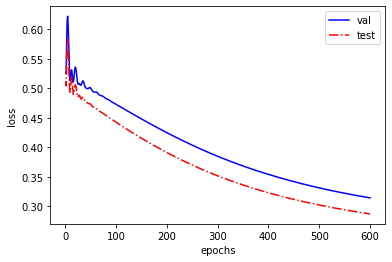

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4925111752, 4925110744]}]
Epoch: 0001 loss_train: 0.6741 acc_train: 0.7800 loss_val: 0.5088 acc_val: 0.7950 time: 0.0027s
Epoch: 0002 loss_train: 0.5241 acc_train: 0.7800 loss_val: 0.5071 acc_val: 0.7950 time: 0.0015s
Epoch: 0003 loss_train: 0.5337 acc_train: 0.7800 loss_val: 0.5395 acc_val: 0.7950 time: 0.0016s
Epoch: 0004 loss_train: 0.5725 acc_train: 0.7800 loss_val: 0.5513 acc_val: 0.7950 time: 0.0020s
Epoch: 0005 loss_train: 0.5861 acc_train: 0.7800 loss_val: 0.5404 acc_val: 0.7950 time: 0.0021s
Epoch: 0006 loss_train: 0.5737 acc_train: 0.7800 loss_val: 0.5184 acc_val: 0.7950 time: 0.0019s
Epoch: 0007 loss_train: 0.5480 acc_train: 0.7800 loss_val: 0.4994 ac

Epoch: 0098 loss_train: 0.4684 acc_train: 0.7800 loss_val: 0.4461 acc_val: 0.7950 time: 0.0021s
Epoch: 0099 loss_train: 0.4678 acc_train: 0.7800 loss_val: 0.4454 acc_val: 0.7950 time: 0.0016s
Epoch: 0100 loss_train: 0.4672 acc_train: 0.7800 loss_val: 0.4448 acc_val: 0.7950 time: 0.0020s
Epoch: 0101 loss_train: 0.4667 acc_train: 0.7800 loss_val: 0.4443 acc_val: 0.7950 time: 0.0017s
Epoch: 0102 loss_train: 0.4661 acc_train: 0.7800 loss_val: 0.4437 acc_val: 0.7950 time: 0.0025s
Epoch: 0103 loss_train: 0.4655 acc_train: 0.7800 loss_val: 0.4432 acc_val: 0.7950 time: 0.0016s
Epoch: 0104 loss_train: 0.4649 acc_train: 0.7800 loss_val: 0.4427 acc_val: 0.7950 time: 0.0014s
Epoch: 0105 loss_train: 0.4643 acc_train: 0.7800 loss_val: 0.4421 acc_val: 0.7950 time: 0.0015s
Epoch: 0106 loss_train: 0.4637 acc_train: 0.7800 loss_val: 0.4415 acc_val: 0.7950 time: 0.0014s
Epoch: 0107 loss_train: 0.4632 acc_train: 0.7800 loss_val: 0.4409 acc_val: 0.7950 time: 0.0015s
Epoch: 0108 loss_train: 0.4626 acc_train

Epoch: 0209 loss_train: 0.4075 acc_train: 0.7800 loss_val: 0.3872 acc_val: 0.7950 time: 0.0022s
Epoch: 0210 loss_train: 0.4070 acc_train: 0.7800 loss_val: 0.3867 acc_val: 0.7950 time: 0.0016s
Epoch: 0211 loss_train: 0.4065 acc_train: 0.7800 loss_val: 0.3862 acc_val: 0.7950 time: 0.0018s
Epoch: 0212 loss_train: 0.4060 acc_train: 0.7850 loss_val: 0.3858 acc_val: 0.7950 time: 0.0015s
Epoch: 0213 loss_train: 0.4055 acc_train: 0.7850 loss_val: 0.3853 acc_val: 0.7950 time: 0.0014s
Epoch: 0214 loss_train: 0.4051 acc_train: 0.7850 loss_val: 0.3848 acc_val: 0.7950 time: 0.0014s
Epoch: 0215 loss_train: 0.4046 acc_train: 0.7850 loss_val: 0.3844 acc_val: 0.7950 time: 0.0016s
Epoch: 0216 loss_train: 0.4041 acc_train: 0.7850 loss_val: 0.3839 acc_val: 0.7950 time: 0.0016s
Epoch: 0217 loss_train: 0.4036 acc_train: 0.7850 loss_val: 0.3835 acc_val: 0.7950 time: 0.0030s
Epoch: 0218 loss_train: 0.4031 acc_train: 0.7850 loss_val: 0.3830 acc_val: 0.7950 time: 0.0022s
Epoch: 0219 loss_train: 0.4026 acc_train

Epoch: 0308 loss_train: 0.3648 acc_train: 0.8100 loss_val: 0.3473 acc_val: 0.8100 time: 0.0040s
Epoch: 0309 loss_train: 0.3644 acc_train: 0.8100 loss_val: 0.3469 acc_val: 0.8100 time: 0.0019s
Epoch: 0310 loss_train: 0.3641 acc_train: 0.8100 loss_val: 0.3466 acc_val: 0.8100 time: 0.0031s
Epoch: 0311 loss_train: 0.3637 acc_train: 0.8100 loss_val: 0.3463 acc_val: 0.8100 time: 0.0034s
Epoch: 0312 loss_train: 0.3633 acc_train: 0.8100 loss_val: 0.3459 acc_val: 0.8100 time: 0.0048s
Epoch: 0313 loss_train: 0.3630 acc_train: 0.8100 loss_val: 0.3456 acc_val: 0.8100 time: 0.0033s
Epoch: 0314 loss_train: 0.3626 acc_train: 0.8100 loss_val: 0.3453 acc_val: 0.8100 time: 0.0017s
Epoch: 0315 loss_train: 0.3622 acc_train: 0.8100 loss_val: 0.3449 acc_val: 0.8100 time: 0.0022s
Epoch: 0316 loss_train: 0.3619 acc_train: 0.8100 loss_val: 0.3446 acc_val: 0.8100 time: 0.0039s
Epoch: 0317 loss_train: 0.3615 acc_train: 0.8150 loss_val: 0.3443 acc_val: 0.8100 time: 0.0016s
Epoch: 0318 loss_train: 0.3612 acc_train

Epoch: 0403 loss_train: 0.3347 acc_train: 0.8400 loss_val: 0.3197 acc_val: 0.8250 time: 0.0081s
Epoch: 0404 loss_train: 0.3344 acc_train: 0.8400 loss_val: 0.3194 acc_val: 0.8250 time: 0.0034s
Epoch: 0405 loss_train: 0.3341 acc_train: 0.8400 loss_val: 0.3192 acc_val: 0.8250 time: 0.0030s
Epoch: 0406 loss_train: 0.3338 acc_train: 0.8400 loss_val: 0.3190 acc_val: 0.8250 time: 0.0028s
Epoch: 0407 loss_train: 0.3336 acc_train: 0.8400 loss_val: 0.3187 acc_val: 0.8250 time: 0.0019s
Epoch: 0408 loss_train: 0.3333 acc_train: 0.8450 loss_val: 0.3185 acc_val: 0.8250 time: 0.0026s
Epoch: 0409 loss_train: 0.3331 acc_train: 0.8450 loss_val: 0.3182 acc_val: 0.8250 time: 0.0017s
Epoch: 0410 loss_train: 0.3328 acc_train: 0.8450 loss_val: 0.3180 acc_val: 0.8250 time: 0.0022s
Epoch: 0411 loss_train: 0.3325 acc_train: 0.8450 loss_val: 0.3177 acc_val: 0.8250 time: 0.0043s
Epoch: 0412 loss_train: 0.3323 acc_train: 0.8500 loss_val: 0.3175 acc_val: 0.8250 time: 0.0019s
Epoch: 0413 loss_train: 0.3320 acc_train

Epoch: 0504 loss_train: 0.3117 acc_train: 0.8650 loss_val: 0.2988 acc_val: 0.8550 time: 0.0037s
Epoch: 0505 loss_train: 0.3115 acc_train: 0.8650 loss_val: 0.2986 acc_val: 0.8550 time: 0.0023s
Epoch: 0506 loss_train: 0.3113 acc_train: 0.8650 loss_val: 0.2984 acc_val: 0.8550 time: 0.0038s
Epoch: 0507 loss_train: 0.3111 acc_train: 0.8650 loss_val: 0.2983 acc_val: 0.8550 time: 0.0021s
Epoch: 0508 loss_train: 0.3109 acc_train: 0.8650 loss_val: 0.2981 acc_val: 0.8550 time: 0.0015s
Epoch: 0509 loss_train: 0.3107 acc_train: 0.8650 loss_val: 0.2979 acc_val: 0.8550 time: 0.0017s
Epoch: 0510 loss_train: 0.3105 acc_train: 0.8650 loss_val: 0.2978 acc_val: 0.8550 time: 0.0015s
Epoch: 0511 loss_train: 0.3103 acc_train: 0.8650 loss_val: 0.2976 acc_val: 0.8550 time: 0.0053s
Epoch: 0512 loss_train: 0.3102 acc_train: 0.8650 loss_val: 0.2974 acc_val: 0.8550 time: 0.0015s
Epoch: 0513 loss_train: 0.3100 acc_train: 0.8650 loss_val: 0.2973 acc_val: 0.8550 time: 0.0028s
Epoch: 0514 loss_train: 0.3098 acc_train

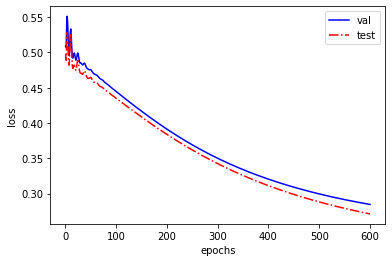

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4948234744, 4948237696]}]
Epoch: 0001 loss_train: 0.6547 acc_train: 0.7950 loss_val: 0.4927 acc_val: 0.8050 time: 0.0036s
Epoch: 0002 loss_train: 0.5041 acc_train: 0.7950 loss_val: 0.4915 acc_val: 0.8050 time: 0.0037s
Epoch: 0003 loss_train: 0.5101 acc_train: 0.7950 loss_val: 0.5250 acc_val: 0.8050 time: 0.0018s
Epoch: 0004 loss_train: 0.5477 acc_train: 0.7950 loss_val: 0.5397 acc_val: 0.8050 time: 0.0026s
Epoch: 0005 loss_train: 0.5636 acc_train: 0.7950 loss_val: 0.5316 acc_val: 0.8050 time: 0.0057s
Epoch: 0006 loss_train: 0.5548 acc_train: 0.7950 loss_val: 0.5106 acc_val: 0.8050 time: 0.0015s
Epoch: 0007 loss_train: 0.5316 acc_train: 0.7950 loss_val: 0.4890 ac

Epoch: 0094 loss_train: 0.4357 acc_train: 0.7950 loss_val: 0.4322 acc_val: 0.8050 time: 0.0023s
Epoch: 0095 loss_train: 0.4350 acc_train: 0.7950 loss_val: 0.4316 acc_val: 0.8050 time: 0.0018s
Epoch: 0096 loss_train: 0.4343 acc_train: 0.7950 loss_val: 0.4311 acc_val: 0.8050 time: 0.0027s
Epoch: 0097 loss_train: 0.4336 acc_train: 0.7950 loss_val: 0.4305 acc_val: 0.8050 time: 0.0016s
Epoch: 0098 loss_train: 0.4329 acc_train: 0.7950 loss_val: 0.4299 acc_val: 0.8050 time: 0.0025s
Epoch: 0099 loss_train: 0.4322 acc_train: 0.7950 loss_val: 0.4293 acc_val: 0.8050 time: 0.0039s
Epoch: 0100 loss_train: 0.4315 acc_train: 0.7950 loss_val: 0.4287 acc_val: 0.8050 time: 0.0019s
Epoch: 0101 loss_train: 0.4308 acc_train: 0.7950 loss_val: 0.4281 acc_val: 0.8050 time: 0.0021s
Epoch: 0102 loss_train: 0.4301 acc_train: 0.7950 loss_val: 0.4275 acc_val: 0.8050 time: 0.0015s
Epoch: 0103 loss_train: 0.4294 acc_train: 0.7950 loss_val: 0.4270 acc_val: 0.8050 time: 0.0024s
Epoch: 0104 loss_train: 0.4287 acc_train

Epoch: 0199 loss_train: 0.3717 acc_train: 0.7950 loss_val: 0.3786 acc_val: 0.8100 time: 0.0035s
Epoch: 0200 loss_train: 0.3712 acc_train: 0.7950 loss_val: 0.3782 acc_val: 0.8100 time: 0.0029s
Epoch: 0201 loss_train: 0.3707 acc_train: 0.7950 loss_val: 0.3777 acc_val: 0.8100 time: 0.0018s
Epoch: 0202 loss_train: 0.3702 acc_train: 0.7950 loss_val: 0.3773 acc_val: 0.8100 time: 0.0019s
Epoch: 0203 loss_train: 0.3697 acc_train: 0.7950 loss_val: 0.3768 acc_val: 0.8100 time: 0.0034s
Epoch: 0204 loss_train: 0.3692 acc_train: 0.7950 loss_val: 0.3764 acc_val: 0.8100 time: 0.0027s
Epoch: 0205 loss_train: 0.3687 acc_train: 0.7950 loss_val: 0.3760 acc_val: 0.8100 time: 0.0038s
Epoch: 0206 loss_train: 0.3682 acc_train: 0.7950 loss_val: 0.3755 acc_val: 0.8100 time: 0.0020s
Epoch: 0207 loss_train: 0.3677 acc_train: 0.7950 loss_val: 0.3751 acc_val: 0.8100 time: 0.0013s
Epoch: 0208 loss_train: 0.3672 acc_train: 0.7950 loss_val: 0.3747 acc_val: 0.8100 time: 0.0034s
Epoch: 0209 loss_train: 0.3667 acc_train

Epoch: 0306 loss_train: 0.3269 acc_train: 0.8100 loss_val: 0.3375 acc_val: 0.8400 time: 0.0043s
Epoch: 0307 loss_train: 0.3266 acc_train: 0.8100 loss_val: 0.3371 acc_val: 0.8400 time: 0.0029s
Epoch: 0308 loss_train: 0.3262 acc_train: 0.8150 loss_val: 0.3368 acc_val: 0.8400 time: 0.0033s
Epoch: 0309 loss_train: 0.3259 acc_train: 0.8150 loss_val: 0.3365 acc_val: 0.8400 time: 0.0037s
Epoch: 0310 loss_train: 0.3256 acc_train: 0.8150 loss_val: 0.3362 acc_val: 0.8400 time: 0.0016s
Epoch: 0311 loss_train: 0.3252 acc_train: 0.8150 loss_val: 0.3358 acc_val: 0.8400 time: 0.0020s
Epoch: 0312 loss_train: 0.3249 acc_train: 0.8150 loss_val: 0.3355 acc_val: 0.8400 time: 0.0021s
Epoch: 0313 loss_train: 0.3246 acc_train: 0.8150 loss_val: 0.3352 acc_val: 0.8450 time: 0.0018s
Epoch: 0314 loss_train: 0.3242 acc_train: 0.8150 loss_val: 0.3349 acc_val: 0.8450 time: 0.0025s
Epoch: 0315 loss_train: 0.3239 acc_train: 0.8200 loss_val: 0.3346 acc_val: 0.8450 time: 0.0023s
Epoch: 0316 loss_train: 0.3236 acc_train

Epoch: 0421 loss_train: 0.2956 acc_train: 0.8600 loss_val: 0.3053 acc_val: 0.8550 time: 0.0019s
Epoch: 0422 loss_train: 0.2954 acc_train: 0.8600 loss_val: 0.3051 acc_val: 0.8550 time: 0.0013s
Epoch: 0423 loss_train: 0.2952 acc_train: 0.8600 loss_val: 0.3049 acc_val: 0.8550 time: 0.0017s
Epoch: 0424 loss_train: 0.2950 acc_train: 0.8600 loss_val: 0.3046 acc_val: 0.8550 time: 0.0023s
Epoch: 0425 loss_train: 0.2948 acc_train: 0.8600 loss_val: 0.3044 acc_val: 0.8550 time: 0.0034s
Epoch: 0426 loss_train: 0.2946 acc_train: 0.8600 loss_val: 0.3042 acc_val: 0.8550 time: 0.0039s
Epoch: 0427 loss_train: 0.2944 acc_train: 0.8600 loss_val: 0.3039 acc_val: 0.8550 time: 0.0016s
Epoch: 0428 loss_train: 0.2942 acc_train: 0.8600 loss_val: 0.3037 acc_val: 0.8550 time: 0.0033s
Epoch: 0429 loss_train: 0.2939 acc_train: 0.8600 loss_val: 0.3035 acc_val: 0.8550 time: 0.0022s
Epoch: 0430 loss_train: 0.2937 acc_train: 0.8600 loss_val: 0.3033 acc_val: 0.8550 time: 0.0061s
Epoch: 0431 loss_train: 0.2935 acc_train

Epoch: 0519 loss_train: 0.2779 acc_train: 0.8700 loss_val: 0.2853 acc_val: 0.8700 time: 0.0020s
Epoch: 0520 loss_train: 0.2778 acc_train: 0.8700 loss_val: 0.2851 acc_val: 0.8700 time: 0.0014s
Epoch: 0521 loss_train: 0.2776 acc_train: 0.8700 loss_val: 0.2849 acc_val: 0.8700 time: 0.0018s
Epoch: 0522 loss_train: 0.2775 acc_train: 0.8700 loss_val: 0.2847 acc_val: 0.8700 time: 0.0016s
Epoch: 0523 loss_train: 0.2773 acc_train: 0.8700 loss_val: 0.2846 acc_val: 0.8700 time: 0.0013s
Epoch: 0524 loss_train: 0.2772 acc_train: 0.8700 loss_val: 0.2844 acc_val: 0.8700 time: 0.0013s
Epoch: 0525 loss_train: 0.2770 acc_train: 0.8700 loss_val: 0.2842 acc_val: 0.8700 time: 0.0015s
Epoch: 0526 loss_train: 0.2769 acc_train: 0.8700 loss_val: 0.2840 acc_val: 0.8700 time: 0.0018s
Epoch: 0527 loss_train: 0.2767 acc_train: 0.8700 loss_val: 0.2839 acc_val: 0.8700 time: 0.0019s
Epoch: 0528 loss_train: 0.2766 acc_train: 0.8700 loss_val: 0.2837 acc_val: 0.8750 time: 0.0014s
Epoch: 0529 loss_train: 0.2764 acc_train

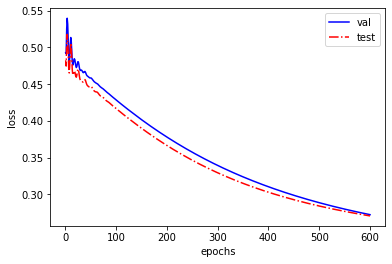

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4925405872, 4925362824]}]
Epoch: 0001 loss_train: 0.6241 acc_train: 0.8050 loss_val: 0.4755 acc_val: 0.8150 time: 0.0027s
Epoch: 0002 loss_train: 0.4868 acc_train: 0.8050 loss_val: 0.4792 acc_val: 0.8150 time: 0.0014s
Epoch: 0003 loss_train: 0.4970 acc_train: 0.8050 loss_val: 0.5103 acc_val: 0.8150 time: 0.0018s
Epoch: 0004 loss_train: 0.5318 acc_train: 0.8050 loss_val: 0.5218 acc_val: 0.8150 time: 0.0013s
Epoch: 0005 loss_train: 0.5443 acc_train: 0.8050 loss_val: 0.5122 acc_val: 0.8150 time: 0.0012s
Epoch: 0006 loss_train: 0.5338 acc_train: 0.8050 loss_val: 0.4915 acc_val: 0.8150 time: 0.0014s
Epoch: 0007 loss_train: 0.5109 acc_train: 0.8050 loss_val: 0.4721 ac

Epoch: 0099 loss_train: 0.4235 acc_train: 0.8050 loss_val: 0.4163 acc_val: 0.8150 time: 0.0071s
Epoch: 0100 loss_train: 0.4229 acc_train: 0.8050 loss_val: 0.4157 acc_val: 0.8150 time: 0.0033s
Epoch: 0101 loss_train: 0.4222 acc_train: 0.8050 loss_val: 0.4152 acc_val: 0.8150 time: 0.0059s
Epoch: 0102 loss_train: 0.4216 acc_train: 0.8050 loss_val: 0.4146 acc_val: 0.8150 time: 0.0016s
Epoch: 0103 loss_train: 0.4210 acc_train: 0.8050 loss_val: 0.4141 acc_val: 0.8150 time: 0.0025s
Epoch: 0104 loss_train: 0.4203 acc_train: 0.8050 loss_val: 0.4136 acc_val: 0.8150 time: 0.0020s
Epoch: 0105 loss_train: 0.4197 acc_train: 0.8050 loss_val: 0.4130 acc_val: 0.8150 time: 0.0033s
Epoch: 0106 loss_train: 0.4191 acc_train: 0.8050 loss_val: 0.4125 acc_val: 0.8150 time: 0.0035s
Epoch: 0107 loss_train: 0.4184 acc_train: 0.8050 loss_val: 0.4119 acc_val: 0.8150 time: 0.0037s
Epoch: 0108 loss_train: 0.4178 acc_train: 0.8050 loss_val: 0.4113 acc_val: 0.8150 time: 0.0036s
Epoch: 0109 loss_train: 0.4172 acc_train

Epoch: 0198 loss_train: 0.3670 acc_train: 0.8050 loss_val: 0.3663 acc_val: 0.8150 time: 0.0038s
Epoch: 0199 loss_train: 0.3665 acc_train: 0.8050 loss_val: 0.3658 acc_val: 0.8150 time: 0.0035s
Epoch: 0200 loss_train: 0.3660 acc_train: 0.8050 loss_val: 0.3654 acc_val: 0.8150 time: 0.0016s
Epoch: 0201 loss_train: 0.3655 acc_train: 0.8050 loss_val: 0.3649 acc_val: 0.8150 time: 0.0016s
Epoch: 0202 loss_train: 0.3650 acc_train: 0.8050 loss_val: 0.3645 acc_val: 0.8150 time: 0.0044s
Epoch: 0203 loss_train: 0.3645 acc_train: 0.8050 loss_val: 0.3641 acc_val: 0.8150 time: 0.0017s
Epoch: 0204 loss_train: 0.3640 acc_train: 0.8050 loss_val: 0.3636 acc_val: 0.8150 time: 0.0043s
Epoch: 0205 loss_train: 0.3635 acc_train: 0.8050 loss_val: 0.3632 acc_val: 0.8150 time: 0.0014s
Epoch: 0206 loss_train: 0.3630 acc_train: 0.8050 loss_val: 0.3628 acc_val: 0.8150 time: 0.0016s
Epoch: 0207 loss_train: 0.3625 acc_train: 0.8050 loss_val: 0.3623 acc_val: 0.8150 time: 0.0041s
Epoch: 0208 loss_train: 0.3620 acc_train

Epoch: 0308 loss_train: 0.3202 acc_train: 0.8350 loss_val: 0.3253 acc_val: 0.8300 time: 0.0027s
Epoch: 0309 loss_train: 0.3198 acc_train: 0.8350 loss_val: 0.3250 acc_val: 0.8300 time: 0.0053s
Epoch: 0310 loss_train: 0.3195 acc_train: 0.8350 loss_val: 0.3247 acc_val: 0.8300 time: 0.0014s
Epoch: 0311 loss_train: 0.3191 acc_train: 0.8350 loss_val: 0.3244 acc_val: 0.8300 time: 0.0017s
Epoch: 0312 loss_train: 0.3188 acc_train: 0.8350 loss_val: 0.3241 acc_val: 0.8300 time: 0.0070s
Epoch: 0313 loss_train: 0.3184 acc_train: 0.8350 loss_val: 0.3238 acc_val: 0.8300 time: 0.0033s
Epoch: 0314 loss_train: 0.3181 acc_train: 0.8350 loss_val: 0.3235 acc_val: 0.8300 time: 0.0034s
Epoch: 0315 loss_train: 0.3177 acc_train: 0.8350 loss_val: 0.3232 acc_val: 0.8300 time: 0.0027s
Epoch: 0316 loss_train: 0.3174 acc_train: 0.8400 loss_val: 0.3229 acc_val: 0.8300 time: 0.0014s
Epoch: 0317 loss_train: 0.3170 acc_train: 0.8400 loss_val: 0.3226 acc_val: 0.8300 time: 0.0049s
Epoch: 0318 loss_train: 0.3167 acc_train

Epoch: 0410 loss_train: 0.2890 acc_train: 0.8650 loss_val: 0.2991 acc_val: 0.8700 time: 0.0042s
Epoch: 0411 loss_train: 0.2888 acc_train: 0.8650 loss_val: 0.2988 acc_val: 0.8700 time: 0.0055s
Epoch: 0412 loss_train: 0.2885 acc_train: 0.8650 loss_val: 0.2986 acc_val: 0.8700 time: 0.0016s
Epoch: 0413 loss_train: 0.2883 acc_train: 0.8700 loss_val: 0.2984 acc_val: 0.8700 time: 0.0019s
Epoch: 0414 loss_train: 0.2880 acc_train: 0.8700 loss_val: 0.2982 acc_val: 0.8700 time: 0.0029s
Epoch: 0415 loss_train: 0.2878 acc_train: 0.8700 loss_val: 0.2980 acc_val: 0.8700 time: 0.0023s
Epoch: 0416 loss_train: 0.2875 acc_train: 0.8700 loss_val: 0.2978 acc_val: 0.8700 time: 0.0039s
Epoch: 0417 loss_train: 0.2873 acc_train: 0.8700 loss_val: 0.2976 acc_val: 0.8700 time: 0.0020s
Epoch: 0418 loss_train: 0.2870 acc_train: 0.8700 loss_val: 0.2974 acc_val: 0.8700 time: 0.0034s
Epoch: 0419 loss_train: 0.2868 acc_train: 0.8700 loss_val: 0.2972 acc_val: 0.8700 time: 0.0017s
Epoch: 0420 loss_train: 0.2865 acc_train

Epoch: 0516 loss_train: 0.2659 acc_train: 0.8900 loss_val: 0.2801 acc_val: 0.8850 time: 0.0023s
Epoch: 0517 loss_train: 0.2657 acc_train: 0.8900 loss_val: 0.2800 acc_val: 0.8900 time: 0.0013s
Epoch: 0518 loss_train: 0.2656 acc_train: 0.8950 loss_val: 0.2798 acc_val: 0.8900 time: 0.0020s
Epoch: 0519 loss_train: 0.2654 acc_train: 0.8950 loss_val: 0.2797 acc_val: 0.8900 time: 0.0023s
Epoch: 0520 loss_train: 0.2652 acc_train: 0.8950 loss_val: 0.2795 acc_val: 0.8900 time: 0.0014s
Epoch: 0521 loss_train: 0.2650 acc_train: 0.8950 loss_val: 0.2794 acc_val: 0.8900 time: 0.0013s
Epoch: 0522 loss_train: 0.2648 acc_train: 0.8950 loss_val: 0.2792 acc_val: 0.8900 time: 0.0025s
Epoch: 0523 loss_train: 0.2647 acc_train: 0.8950 loss_val: 0.2791 acc_val: 0.8900 time: 0.0014s
Epoch: 0524 loss_train: 0.2645 acc_train: 0.8950 loss_val: 0.2789 acc_val: 0.8900 time: 0.0014s
Epoch: 0525 loss_train: 0.2643 acc_train: 0.8950 loss_val: 0.2788 acc_val: 0.8900 time: 0.0016s
Epoch: 0526 loss_train: 0.2641 acc_train

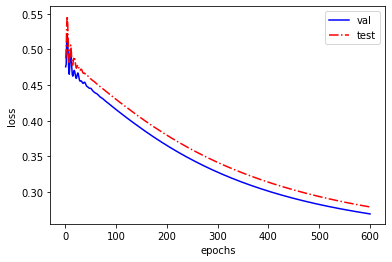

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4924096728, 4925129928]}]
Epoch: 0001 loss_train: 0.6924 acc_train: 0.6400 loss_val: 0.5023 acc_val: 0.8050 time: 0.0042s
Epoch: 0002 loss_train: 0.4931 acc_train: 0.8150 loss_val: 0.4875 acc_val: 0.8050 time: 0.0024s
Epoch: 0003 loss_train: 0.4703 acc_train: 0.8150 loss_val: 0.5299 acc_val: 0.8050 time: 0.0015s
Epoch: 0004 loss_train: 0.5071 acc_train: 0.8150 loss_val: 0.5642 acc_val: 0.8050 time: 0.0014s
Epoch: 0005 loss_train: 0.5384 acc_train: 0.8150 loss_val: 0.5750 acc_val: 0.8050 time: 0.0019s
Epoch: 0006 loss_train: 0.5483 acc_train: 0.8150 loss_val: 0.5648 acc_val: 0.8050 time: 0.0021s
Epoch: 0007 loss_train: 0.5389 acc_train: 0.8150 loss_val: 0.5410 ac

Epoch: 0109 loss_train: 0.4155 acc_train: 0.8150 loss_val: 0.4323 acc_val: 0.8050 time: 0.0029s
Epoch: 0110 loss_train: 0.4149 acc_train: 0.8150 loss_val: 0.4319 acc_val: 0.8050 time: 0.0035s
Epoch: 0111 loss_train: 0.4144 acc_train: 0.8150 loss_val: 0.4314 acc_val: 0.8050 time: 0.0019s
Epoch: 0112 loss_train: 0.4139 acc_train: 0.8150 loss_val: 0.4309 acc_val: 0.8050 time: 0.0046s
Epoch: 0113 loss_train: 0.4134 acc_train: 0.8150 loss_val: 0.4304 acc_val: 0.8050 time: 0.0019s
Epoch: 0114 loss_train: 0.4129 acc_train: 0.8150 loss_val: 0.4299 acc_val: 0.8050 time: 0.0025s
Epoch: 0115 loss_train: 0.4123 acc_train: 0.8150 loss_val: 0.4294 acc_val: 0.8050 time: 0.0026s
Epoch: 0116 loss_train: 0.4118 acc_train: 0.8150 loss_val: 0.4289 acc_val: 0.8050 time: 0.0045s
Epoch: 0117 loss_train: 0.4113 acc_train: 0.8150 loss_val: 0.4284 acc_val: 0.8050 time: 0.0037s
Epoch: 0118 loss_train: 0.4108 acc_train: 0.8150 loss_val: 0.4279 acc_val: 0.8050 time: 0.0053s
Epoch: 0119 loss_train: 0.4103 acc_train

Epoch: 0213 loss_train: 0.3661 acc_train: 0.8150 loss_val: 0.3859 acc_val: 0.8050 time: 0.0024s
Epoch: 0214 loss_train: 0.3657 acc_train: 0.8150 loss_val: 0.3855 acc_val: 0.8050 time: 0.0016s
Epoch: 0215 loss_train: 0.3653 acc_train: 0.8150 loss_val: 0.3851 acc_val: 0.8050 time: 0.0015s
Epoch: 0216 loss_train: 0.3648 acc_train: 0.8150 loss_val: 0.3847 acc_val: 0.8050 time: 0.0036s
Epoch: 0217 loss_train: 0.3644 acc_train: 0.8150 loss_val: 0.3843 acc_val: 0.8050 time: 0.0021s
Epoch: 0218 loss_train: 0.3640 acc_train: 0.8150 loss_val: 0.3839 acc_val: 0.8050 time: 0.0014s
Epoch: 0219 loss_train: 0.3636 acc_train: 0.8150 loss_val: 0.3835 acc_val: 0.8050 time: 0.0015s
Epoch: 0220 loss_train: 0.3632 acc_train: 0.8150 loss_val: 0.3831 acc_val: 0.8050 time: 0.0016s
Epoch: 0221 loss_train: 0.3628 acc_train: 0.8150 loss_val: 0.3827 acc_val: 0.8050 time: 0.0013s
Epoch: 0222 loss_train: 0.3624 acc_train: 0.8150 loss_val: 0.3823 acc_val: 0.8050 time: 0.0014s
Epoch: 0223 loss_train: 0.3619 acc_train

Epoch: 0332 loss_train: 0.3236 acc_train: 0.8300 loss_val: 0.3450 acc_val: 0.8150 time: 0.0020s
Epoch: 0333 loss_train: 0.3233 acc_train: 0.8300 loss_val: 0.3447 acc_val: 0.8150 time: 0.0014s
Epoch: 0334 loss_train: 0.3230 acc_train: 0.8300 loss_val: 0.3444 acc_val: 0.8150 time: 0.0020s
Epoch: 0335 loss_train: 0.3228 acc_train: 0.8300 loss_val: 0.3441 acc_val: 0.8150 time: 0.0028s
Epoch: 0336 loss_train: 0.3225 acc_train: 0.8300 loss_val: 0.3438 acc_val: 0.8150 time: 0.0014s
Epoch: 0337 loss_train: 0.3222 acc_train: 0.8300 loss_val: 0.3435 acc_val: 0.8150 time: 0.0016s
Epoch: 0338 loss_train: 0.3219 acc_train: 0.8300 loss_val: 0.3433 acc_val: 0.8150 time: 0.0014s
Epoch: 0339 loss_train: 0.3216 acc_train: 0.8300 loss_val: 0.3430 acc_val: 0.8150 time: 0.0030s
Epoch: 0340 loss_train: 0.3213 acc_train: 0.8300 loss_val: 0.3427 acc_val: 0.8150 time: 0.0015s
Epoch: 0341 loss_train: 0.3210 acc_train: 0.8300 loss_val: 0.3424 acc_val: 0.8200 time: 0.0017s
Epoch: 0342 loss_train: 0.3207 acc_train

Epoch: 0434 loss_train: 0.2979 acc_train: 0.8500 loss_val: 0.3195 acc_val: 0.8250 time: 0.0025s
Epoch: 0435 loss_train: 0.2977 acc_train: 0.8500 loss_val: 0.3193 acc_val: 0.8250 time: 0.0020s
Epoch: 0436 loss_train: 0.2975 acc_train: 0.8500 loss_val: 0.3191 acc_val: 0.8250 time: 0.0029s
Epoch: 0437 loss_train: 0.2973 acc_train: 0.8500 loss_val: 0.3189 acc_val: 0.8250 time: 0.0022s
Epoch: 0438 loss_train: 0.2970 acc_train: 0.8500 loss_val: 0.3187 acc_val: 0.8250 time: 0.0030s
Epoch: 0439 loss_train: 0.2968 acc_train: 0.8500 loss_val: 0.3185 acc_val: 0.8250 time: 0.0032s
Epoch: 0440 loss_train: 0.2966 acc_train: 0.8550 loss_val: 0.3182 acc_val: 0.8250 time: 0.0043s
Epoch: 0441 loss_train: 0.2964 acc_train: 0.8550 loss_val: 0.3180 acc_val: 0.8250 time: 0.0021s
Epoch: 0442 loss_train: 0.2962 acc_train: 0.8550 loss_val: 0.3178 acc_val: 0.8250 time: 0.0014s
Epoch: 0443 loss_train: 0.2960 acc_train: 0.8550 loss_val: 0.3176 acc_val: 0.8250 time: 0.0047s
Epoch: 0444 loss_train: 0.2958 acc_train

Epoch: 0524 loss_train: 0.2812 acc_train: 0.8700 loss_val: 0.3026 acc_val: 0.8300 time: 0.0021s
Epoch: 0525 loss_train: 0.2811 acc_train: 0.8700 loss_val: 0.3025 acc_val: 0.8300 time: 0.0020s
Epoch: 0526 loss_train: 0.2809 acc_train: 0.8700 loss_val: 0.3023 acc_val: 0.8350 time: 0.0022s
Epoch: 0527 loss_train: 0.2807 acc_train: 0.8700 loss_val: 0.3021 acc_val: 0.8350 time: 0.0014s
Epoch: 0528 loss_train: 0.2806 acc_train: 0.8700 loss_val: 0.3020 acc_val: 0.8350 time: 0.0020s
Epoch: 0529 loss_train: 0.2804 acc_train: 0.8700 loss_val: 0.3018 acc_val: 0.8350 time: 0.0026s
Epoch: 0530 loss_train: 0.2803 acc_train: 0.8700 loss_val: 0.3017 acc_val: 0.8350 time: 0.0014s
Epoch: 0531 loss_train: 0.2801 acc_train: 0.8700 loss_val: 0.3015 acc_val: 0.8350 time: 0.0017s
Epoch: 0532 loss_train: 0.2800 acc_train: 0.8700 loss_val: 0.3013 acc_val: 0.8350 time: 0.0015s
Epoch: 0533 loss_train: 0.2798 acc_train: 0.8700 loss_val: 0.3012 acc_val: 0.8350 time: 0.0013s
Epoch: 0534 loss_train: 0.2796 acc_train

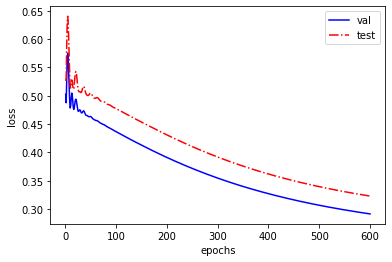

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4960493144, 4960460520]}]
Epoch: 0001 loss_train: 0.7454 acc_train: 0.1950 loss_val: 0.5394 acc_val: 0.7800 time: 0.0028s
Epoch: 0002 loss_train: 0.5188 acc_train: 0.8050 loss_val: 0.5224 acc_val: 0.7800 time: 0.0015s
Epoch: 0003 loss_train: 0.4823 acc_train: 0.8050 loss_val: 0.5732 acc_val: 0.7800 time: 0.0015s
Epoch: 0004 loss_train: 0.5193 acc_train: 0.8050 loss_val: 0.6179 acc_val: 0.7800 time: 0.0021s
Epoch: 0005 loss_train: 0.5561 acc_train: 0.8050 loss_val: 0.6365 acc_val: 0.7800 time: 0.0017s
Epoch: 0006 loss_train: 0.5716 acc_train: 0.8050 loss_val: 0.6299 acc_val: 0.7800 time: 0.0015s
Epoch: 0007 loss_train: 0.5660 acc_train: 0.8050 loss_val: 0.6055 ac

Epoch: 0094 loss_train: 0.4385 acc_train: 0.8050 loss_val: 0.4790 acc_val: 0.7800 time: 0.0019s
Epoch: 0095 loss_train: 0.4379 acc_train: 0.8050 loss_val: 0.4785 acc_val: 0.7800 time: 0.0017s
Epoch: 0096 loss_train: 0.4374 acc_train: 0.8050 loss_val: 0.4780 acc_val: 0.7800 time: 0.0030s
Epoch: 0097 loss_train: 0.4369 acc_train: 0.8050 loss_val: 0.4775 acc_val: 0.7800 time: 0.0015s
Epoch: 0098 loss_train: 0.4364 acc_train: 0.8050 loss_val: 0.4771 acc_val: 0.7800 time: 0.0014s
Epoch: 0099 loss_train: 0.4359 acc_train: 0.8050 loss_val: 0.4767 acc_val: 0.7800 time: 0.0036s
Epoch: 0100 loss_train: 0.4354 acc_train: 0.8050 loss_val: 0.4763 acc_val: 0.7800 time: 0.0020s
Epoch: 0101 loss_train: 0.4348 acc_train: 0.8050 loss_val: 0.4759 acc_val: 0.7800 time: 0.0014s
Epoch: 0102 loss_train: 0.4343 acc_train: 0.8050 loss_val: 0.4755 acc_val: 0.7800 time: 0.0018s
Epoch: 0103 loss_train: 0.4338 acc_train: 0.8050 loss_val: 0.4750 acc_val: 0.7800 time: 0.0015s
Epoch: 0104 loss_train: 0.4333 acc_train

Epoch: 0182 loss_train: 0.3953 acc_train: 0.8050 loss_val: 0.4385 acc_val: 0.7800 time: 0.0022s
Epoch: 0183 loss_train: 0.3949 acc_train: 0.8050 loss_val: 0.4381 acc_val: 0.7800 time: 0.0016s
Epoch: 0184 loss_train: 0.3944 acc_train: 0.8050 loss_val: 0.4377 acc_val: 0.7800 time: 0.0017s
Epoch: 0185 loss_train: 0.3940 acc_train: 0.8050 loss_val: 0.4372 acc_val: 0.7800 time: 0.0015s
Epoch: 0186 loss_train: 0.3935 acc_train: 0.8050 loss_val: 0.4368 acc_val: 0.7800 time: 0.0015s
Epoch: 0187 loss_train: 0.3931 acc_train: 0.8050 loss_val: 0.4363 acc_val: 0.7800 time: 0.0017s
Epoch: 0188 loss_train: 0.3926 acc_train: 0.8050 loss_val: 0.4359 acc_val: 0.7800 time: 0.0016s
Epoch: 0189 loss_train: 0.3922 acc_train: 0.8050 loss_val: 0.4355 acc_val: 0.7800 time: 0.0017s
Epoch: 0190 loss_train: 0.3917 acc_train: 0.8050 loss_val: 0.4350 acc_val: 0.7800 time: 0.0017s
Epoch: 0191 loss_train: 0.3913 acc_train: 0.8050 loss_val: 0.4346 acc_val: 0.7800 time: 0.0014s
Epoch: 0192 loss_train: 0.3908 acc_train

Epoch: 0279 loss_train: 0.3555 acc_train: 0.8050 loss_val: 0.3993 acc_val: 0.7800 time: 0.0020s
Epoch: 0280 loss_train: 0.3551 acc_train: 0.8050 loss_val: 0.3989 acc_val: 0.7800 time: 0.0029s
Epoch: 0281 loss_train: 0.3547 acc_train: 0.8050 loss_val: 0.3985 acc_val: 0.7800 time: 0.0015s
Epoch: 0282 loss_train: 0.3544 acc_train: 0.8050 loss_val: 0.3982 acc_val: 0.7800 time: 0.0016s
Epoch: 0283 loss_train: 0.3540 acc_train: 0.8050 loss_val: 0.3978 acc_val: 0.7800 time: 0.0014s
Epoch: 0284 loss_train: 0.3537 acc_train: 0.8050 loss_val: 0.3974 acc_val: 0.7800 time: 0.0021s
Epoch: 0285 loss_train: 0.3533 acc_train: 0.8050 loss_val: 0.3971 acc_val: 0.7800 time: 0.0014s
Epoch: 0286 loss_train: 0.3529 acc_train: 0.8050 loss_val: 0.3967 acc_val: 0.7850 time: 0.0016s
Epoch: 0287 loss_train: 0.3526 acc_train: 0.8050 loss_val: 0.3963 acc_val: 0.7850 time: 0.0014s
Epoch: 0288 loss_train: 0.3522 acc_train: 0.8050 loss_val: 0.3960 acc_val: 0.7850 time: 0.0015s
Epoch: 0289 loss_train: 0.3519 acc_train

Epoch: 0378 loss_train: 0.3238 acc_train: 0.8300 loss_val: 0.3671 acc_val: 0.8150 time: 0.0059s
Epoch: 0379 loss_train: 0.3236 acc_train: 0.8300 loss_val: 0.3668 acc_val: 0.8150 time: 0.0018s
Epoch: 0380 loss_train: 0.3233 acc_train: 0.8300 loss_val: 0.3665 acc_val: 0.8150 time: 0.0023s
Epoch: 0381 loss_train: 0.3230 acc_train: 0.8300 loss_val: 0.3662 acc_val: 0.8150 time: 0.0017s
Epoch: 0382 loss_train: 0.3227 acc_train: 0.8300 loss_val: 0.3660 acc_val: 0.8150 time: 0.0020s
Epoch: 0383 loss_train: 0.3225 acc_train: 0.8300 loss_val: 0.3657 acc_val: 0.8150 time: 0.0030s
Epoch: 0384 loss_train: 0.3222 acc_train: 0.8300 loss_val: 0.3654 acc_val: 0.8150 time: 0.0060s
Epoch: 0385 loss_train: 0.3219 acc_train: 0.8300 loss_val: 0.3651 acc_val: 0.8150 time: 0.0021s
Epoch: 0386 loss_train: 0.3217 acc_train: 0.8300 loss_val: 0.3648 acc_val: 0.8150 time: 0.0039s
Epoch: 0387 loss_train: 0.3214 acc_train: 0.8300 loss_val: 0.3646 acc_val: 0.8150 time: 0.0025s
Epoch: 0388 loss_train: 0.3211 acc_train

Epoch: 0474 loss_train: 0.3008 acc_train: 0.8350 loss_val: 0.3431 acc_val: 0.8300 time: 0.0023s
Epoch: 0475 loss_train: 0.3005 acc_train: 0.8350 loss_val: 0.3428 acc_val: 0.8300 time: 0.0016s
Epoch: 0476 loss_train: 0.3003 acc_train: 0.8350 loss_val: 0.3426 acc_val: 0.8300 time: 0.0016s
Epoch: 0477 loss_train: 0.3001 acc_train: 0.8350 loss_val: 0.3424 acc_val: 0.8300 time: 0.0014s
Epoch: 0478 loss_train: 0.2999 acc_train: 0.8350 loss_val: 0.3422 acc_val: 0.8350 time: 0.0015s
Epoch: 0479 loss_train: 0.2997 acc_train: 0.8350 loss_val: 0.3420 acc_val: 0.8350 time: 0.0015s
Epoch: 0480 loss_train: 0.2995 acc_train: 0.8350 loss_val: 0.3418 acc_val: 0.8350 time: 0.0017s
Epoch: 0481 loss_train: 0.2993 acc_train: 0.8350 loss_val: 0.3415 acc_val: 0.8350 time: 0.0014s
Epoch: 0482 loss_train: 0.2991 acc_train: 0.8400 loss_val: 0.3413 acc_val: 0.8350 time: 0.0014s
Epoch: 0483 loss_train: 0.2989 acc_train: 0.8400 loss_val: 0.3411 acc_val: 0.8350 time: 0.0016s
Epoch: 0484 loss_train: 0.2987 acc_train

Epoch: 0569 loss_train: 0.2836 acc_train: 0.8600 loss_val: 0.3248 acc_val: 0.8550 time: 0.0019s
Epoch: 0570 loss_train: 0.2834 acc_train: 0.8600 loss_val: 0.3247 acc_val: 0.8550 time: 0.0028s
Epoch: 0571 loss_train: 0.2832 acc_train: 0.8600 loss_val: 0.3245 acc_val: 0.8600 time: 0.0022s
Epoch: 0572 loss_train: 0.2831 acc_train: 0.8600 loss_val: 0.3243 acc_val: 0.8650 time: 0.0046s
Epoch: 0573 loss_train: 0.2829 acc_train: 0.8650 loss_val: 0.3242 acc_val: 0.8650 time: 0.0021s
Epoch: 0574 loss_train: 0.2828 acc_train: 0.8650 loss_val: 0.3240 acc_val: 0.8650 time: 0.0016s
Epoch: 0575 loss_train: 0.2826 acc_train: 0.8650 loss_val: 0.3238 acc_val: 0.8650 time: 0.0018s
Epoch: 0576 loss_train: 0.2825 acc_train: 0.8650 loss_val: 0.3237 acc_val: 0.8650 time: 0.0014s
Epoch: 0577 loss_train: 0.2823 acc_train: 0.8650 loss_val: 0.3235 acc_val: 0.8650 time: 0.0014s
Epoch: 0578 loss_train: 0.2822 acc_train: 0.8650 loss_val: 0.3233 acc_val: 0.8650 time: 0.0016s
Epoch: 0579 loss_train: 0.2820 acc_train

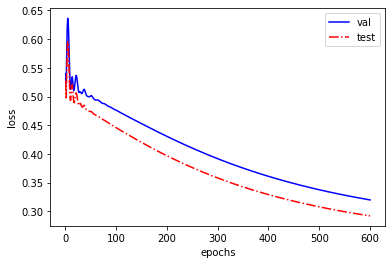

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4968051048, 4938861448]}]
Epoch: 0001 loss_train: 0.7145 acc_train: 0.2200 loss_val: 0.5184 acc_val: 0.7950 time: 0.0021s
Epoch: 0002 loss_train: 0.5315 acc_train: 0.7800 loss_val: 0.4994 acc_val: 0.7950 time: 0.0018s
Epoch: 0003 loss_train: 0.5245 acc_train: 0.7800 loss_val: 0.5344 acc_val: 0.7950 time: 0.0016s
Epoch: 0004 loss_train: 0.5671 acc_train: 0.7800 loss_val: 0.5564 acc_val: 0.7950 time: 0.0022s
Epoch: 0005 loss_train: 0.5923 acc_train: 0.7800 loss_val: 0.5544 acc_val: 0.7950 time: 0.0015s
Epoch: 0006 loss_train: 0.5901 acc_train: 0.7800 loss_val: 0.5355 acc_val: 0.7950 time: 0.0018s
Epoch: 0007 loss_train: 0.5686 acc_train: 0.7800 loss_val: 0.5115 ac

Epoch: 0096 loss_train: 0.4713 acc_train: 0.7800 loss_val: 0.4489 acc_val: 0.7950 time: 0.0019s
Epoch: 0097 loss_train: 0.4707 acc_train: 0.7800 loss_val: 0.4484 acc_val: 0.7950 time: 0.0016s
Epoch: 0098 loss_train: 0.4702 acc_train: 0.7800 loss_val: 0.4480 acc_val: 0.7950 time: 0.0015s
Epoch: 0099 loss_train: 0.4697 acc_train: 0.7800 loss_val: 0.4475 acc_val: 0.7950 time: 0.0014s
Epoch: 0100 loss_train: 0.4691 acc_train: 0.7800 loss_val: 0.4469 acc_val: 0.7950 time: 0.0015s
Epoch: 0101 loss_train: 0.4686 acc_train: 0.7800 loss_val: 0.4464 acc_val: 0.7950 time: 0.0019s
Epoch: 0102 loss_train: 0.4681 acc_train: 0.7800 loss_val: 0.4458 acc_val: 0.7950 time: 0.0015s
Epoch: 0103 loss_train: 0.4675 acc_train: 0.7800 loss_val: 0.4452 acc_val: 0.7950 time: 0.0015s
Epoch: 0104 loss_train: 0.4670 acc_train: 0.7800 loss_val: 0.4446 acc_val: 0.7950 time: 0.0015s
Epoch: 0105 loss_train: 0.4664 acc_train: 0.7800 loss_val: 0.4441 acc_val: 0.7950 time: 0.0023s
Epoch: 0106 loss_train: 0.4659 acc_train

Epoch: 0211 loss_train: 0.4121 acc_train: 0.7800 loss_val: 0.3915 acc_val: 0.7950 time: 0.0043s
Epoch: 0212 loss_train: 0.4116 acc_train: 0.7800 loss_val: 0.3910 acc_val: 0.7950 time: 0.0018s
Epoch: 0213 loss_train: 0.4112 acc_train: 0.7800 loss_val: 0.3906 acc_val: 0.7950 time: 0.0019s
Epoch: 0214 loss_train: 0.4107 acc_train: 0.7800 loss_val: 0.3901 acc_val: 0.7950 time: 0.0018s
Epoch: 0215 loss_train: 0.4102 acc_train: 0.7800 loss_val: 0.3897 acc_val: 0.7950 time: 0.0023s
Epoch: 0216 loss_train: 0.4098 acc_train: 0.7800 loss_val: 0.3893 acc_val: 0.7950 time: 0.0017s
Epoch: 0217 loss_train: 0.4093 acc_train: 0.7800 loss_val: 0.3888 acc_val: 0.7950 time: 0.0021s
Epoch: 0218 loss_train: 0.4088 acc_train: 0.7800 loss_val: 0.3884 acc_val: 0.7950 time: 0.0015s
Epoch: 0219 loss_train: 0.4084 acc_train: 0.7800 loss_val: 0.3879 acc_val: 0.7950 time: 0.0020s
Epoch: 0220 loss_train: 0.4079 acc_train: 0.7800 loss_val: 0.3875 acc_val: 0.7950 time: 0.0018s
Epoch: 0221 loss_train: 0.4075 acc_train

Epoch: 0323 loss_train: 0.3662 acc_train: 0.8050 loss_val: 0.3485 acc_val: 0.8100 time: 0.0015s
Epoch: 0324 loss_train: 0.3658 acc_train: 0.8050 loss_val: 0.3482 acc_val: 0.8100 time: 0.0017s
Epoch: 0325 loss_train: 0.3655 acc_train: 0.8100 loss_val: 0.3478 acc_val: 0.8100 time: 0.0021s
Epoch: 0326 loss_train: 0.3651 acc_train: 0.8100 loss_val: 0.3475 acc_val: 0.8100 time: 0.0017s
Epoch: 0327 loss_train: 0.3648 acc_train: 0.8100 loss_val: 0.3472 acc_val: 0.8100 time: 0.0015s
Epoch: 0328 loss_train: 0.3644 acc_train: 0.8100 loss_val: 0.3469 acc_val: 0.8100 time: 0.0016s
Epoch: 0329 loss_train: 0.3641 acc_train: 0.8100 loss_val: 0.3466 acc_val: 0.8100 time: 0.0015s
Epoch: 0330 loss_train: 0.3637 acc_train: 0.8100 loss_val: 0.3463 acc_val: 0.8100 time: 0.0015s
Epoch: 0331 loss_train: 0.3634 acc_train: 0.8100 loss_val: 0.3459 acc_val: 0.8100 time: 0.0015s
Epoch: 0332 loss_train: 0.3630 acc_train: 0.8100 loss_val: 0.3456 acc_val: 0.8100 time: 0.0015s
Epoch: 0333 loss_train: 0.3627 acc_train

Epoch: 0435 loss_train: 0.3330 acc_train: 0.8450 loss_val: 0.3181 acc_val: 0.8250 time: 0.0015s
Epoch: 0436 loss_train: 0.3327 acc_train: 0.8450 loss_val: 0.3179 acc_val: 0.8250 time: 0.0026s
Epoch: 0437 loss_train: 0.3325 acc_train: 0.8500 loss_val: 0.3177 acc_val: 0.8250 time: 0.0019s
Epoch: 0438 loss_train: 0.3322 acc_train: 0.8500 loss_val: 0.3175 acc_val: 0.8300 time: 0.0020s
Epoch: 0439 loss_train: 0.3320 acc_train: 0.8550 loss_val: 0.3172 acc_val: 0.8300 time: 0.0015s
Epoch: 0440 loss_train: 0.3318 acc_train: 0.8550 loss_val: 0.3170 acc_val: 0.8300 time: 0.0022s
Epoch: 0441 loss_train: 0.3315 acc_train: 0.8550 loss_val: 0.3168 acc_val: 0.8300 time: 0.0016s
Epoch: 0442 loss_train: 0.3313 acc_train: 0.8550 loss_val: 0.3166 acc_val: 0.8300 time: 0.0017s
Epoch: 0443 loss_train: 0.3310 acc_train: 0.8550 loss_val: 0.3164 acc_val: 0.8300 time: 0.0015s
Epoch: 0444 loss_train: 0.3308 acc_train: 0.8550 loss_val: 0.3161 acc_val: 0.8300 time: 0.0017s
Epoch: 0445 loss_train: 0.3306 acc_train

Epoch: 0538 loss_train: 0.3113 acc_train: 0.8650 loss_val: 0.2984 acc_val: 0.8550 time: 0.0021s
Epoch: 0539 loss_train: 0.3111 acc_train: 0.8650 loss_val: 0.2983 acc_val: 0.8550 time: 0.0022s
Epoch: 0540 loss_train: 0.3109 acc_train: 0.8650 loss_val: 0.2981 acc_val: 0.8550 time: 0.0016s
Epoch: 0541 loss_train: 0.3108 acc_train: 0.8650 loss_val: 0.2980 acc_val: 0.8550 time: 0.0022s
Epoch: 0542 loss_train: 0.3106 acc_train: 0.8650 loss_val: 0.2978 acc_val: 0.8550 time: 0.0016s
Epoch: 0543 loss_train: 0.3104 acc_train: 0.8650 loss_val: 0.2976 acc_val: 0.8550 time: 0.0017s
Epoch: 0544 loss_train: 0.3102 acc_train: 0.8650 loss_val: 0.2975 acc_val: 0.8550 time: 0.0014s
Epoch: 0545 loss_train: 0.3101 acc_train: 0.8650 loss_val: 0.2973 acc_val: 0.8550 time: 0.0014s
Epoch: 0546 loss_train: 0.3099 acc_train: 0.8650 loss_val: 0.2972 acc_val: 0.8550 time: 0.0019s
Epoch: 0547 loss_train: 0.3097 acc_train: 0.8650 loss_val: 0.2970 acc_val: 0.8550 time: 0.0015s
Epoch: 0548 loss_train: 0.3095 acc_train

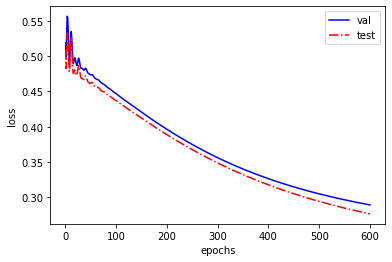

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4925405872, 4960460520]}]
Epoch: 0001 loss_train: 0.6820 acc_train: 0.7950 loss_val: 0.4996 acc_val: 0.8050 time: 0.0028s
Epoch: 0002 loss_train: 0.5102 acc_train: 0.7950 loss_val: 0.4878 acc_val: 0.8050 time: 0.0016s
Epoch: 0003 loss_train: 0.5058 acc_train: 0.7950 loss_val: 0.5229 acc_val: 0.8050 time: 0.0021s
Epoch: 0004 loss_train: 0.5455 acc_train: 0.7950 loss_val: 0.5441 acc_val: 0.8050 time: 0.0013s
Epoch: 0005 loss_train: 0.5685 acc_train: 0.7950 loss_val: 0.5421 acc_val: 0.8050 time: 0.0020s
Epoch: 0006 loss_train: 0.5662 acc_train: 0.7950 loss_val: 0.5237 acc_val: 0.8050 time: 0.0026s
Epoch: 0007 loss_train: 0.5462 acc_train: 0.7950 loss_val: 0.4998 ac

Epoch: 0088 loss_train: 0.4425 acc_train: 0.7950 loss_val: 0.4378 acc_val: 0.8050 time: 0.0018s
Epoch: 0089 loss_train: 0.4419 acc_train: 0.7950 loss_val: 0.4372 acc_val: 0.8050 time: 0.0013s
Epoch: 0090 loss_train: 0.4412 acc_train: 0.7950 loss_val: 0.4366 acc_val: 0.8050 time: 0.0026s
Epoch: 0091 loss_train: 0.4405 acc_train: 0.7950 loss_val: 0.4360 acc_val: 0.8050 time: 0.0037s
Epoch: 0092 loss_train: 0.4398 acc_train: 0.7950 loss_val: 0.4354 acc_val: 0.8050 time: 0.0013s
Epoch: 0093 loss_train: 0.4391 acc_train: 0.7950 loss_val: 0.4348 acc_val: 0.8050 time: 0.0016s
Epoch: 0094 loss_train: 0.4385 acc_train: 0.7950 loss_val: 0.4342 acc_val: 0.8050 time: 0.0034s
Epoch: 0095 loss_train: 0.4378 acc_train: 0.7950 loss_val: 0.4337 acc_val: 0.8050 time: 0.0013s
Epoch: 0096 loss_train: 0.4371 acc_train: 0.7950 loss_val: 0.4332 acc_val: 0.8050 time: 0.0013s
Epoch: 0097 loss_train: 0.4364 acc_train: 0.7950 loss_val: 0.4327 acc_val: 0.8050 time: 0.0013s
Epoch: 0098 loss_train: 0.4358 acc_train

Epoch: 0209 loss_train: 0.3713 acc_train: 0.7950 loss_val: 0.3782 acc_val: 0.8100 time: 0.0015s
Epoch: 0210 loss_train: 0.3708 acc_train: 0.7950 loss_val: 0.3778 acc_val: 0.8100 time: 0.0015s
Epoch: 0211 loss_train: 0.3703 acc_train: 0.7950 loss_val: 0.3774 acc_val: 0.8100 time: 0.0024s
Epoch: 0212 loss_train: 0.3698 acc_train: 0.7950 loss_val: 0.3769 acc_val: 0.8100 time: 0.0013s
Epoch: 0213 loss_train: 0.3694 acc_train: 0.7950 loss_val: 0.3765 acc_val: 0.8100 time: 0.0014s
Epoch: 0214 loss_train: 0.3689 acc_train: 0.7950 loss_val: 0.3761 acc_val: 0.8100 time: 0.0019s
Epoch: 0215 loss_train: 0.3684 acc_train: 0.7950 loss_val: 0.3757 acc_val: 0.8100 time: 0.0013s
Epoch: 0216 loss_train: 0.3679 acc_train: 0.7950 loss_val: 0.3753 acc_val: 0.8100 time: 0.0014s
Epoch: 0217 loss_train: 0.3675 acc_train: 0.7950 loss_val: 0.3749 acc_val: 0.8100 time: 0.0013s
Epoch: 0218 loss_train: 0.3670 acc_train: 0.7950 loss_val: 0.3744 acc_val: 0.8100 time: 0.0013s
Epoch: 0219 loss_train: 0.3665 acc_train

Epoch: 0332 loss_train: 0.3231 acc_train: 0.8200 loss_val: 0.3338 acc_val: 0.8450 time: 0.0020s
Epoch: 0333 loss_train: 0.3228 acc_train: 0.8200 loss_val: 0.3335 acc_val: 0.8450 time: 0.0013s
Epoch: 0334 loss_train: 0.3225 acc_train: 0.8200 loss_val: 0.3332 acc_val: 0.8450 time: 0.0015s
Epoch: 0335 loss_train: 0.3222 acc_train: 0.8200 loss_val: 0.3329 acc_val: 0.8450 time: 0.0015s
Epoch: 0336 loss_train: 0.3219 acc_train: 0.8200 loss_val: 0.3326 acc_val: 0.8450 time: 0.0015s
Epoch: 0337 loss_train: 0.3216 acc_train: 0.8200 loss_val: 0.3323 acc_val: 0.8450 time: 0.0014s
Epoch: 0338 loss_train: 0.3213 acc_train: 0.8200 loss_val: 0.3320 acc_val: 0.8450 time: 0.0016s
Epoch: 0339 loss_train: 0.3210 acc_train: 0.8200 loss_val: 0.3317 acc_val: 0.8450 time: 0.0014s
Epoch: 0340 loss_train: 0.3207 acc_train: 0.8200 loss_val: 0.3314 acc_val: 0.8450 time: 0.0051s
Epoch: 0341 loss_train: 0.3204 acc_train: 0.8200 loss_val: 0.3311 acc_val: 0.8450 time: 0.0014s
Epoch: 0342 loss_train: 0.3201 acc_train

Epoch: 0456 loss_train: 0.2925 acc_train: 0.8600 loss_val: 0.3019 acc_val: 0.8550 time: 0.0016s
Epoch: 0457 loss_train: 0.2923 acc_train: 0.8600 loss_val: 0.3017 acc_val: 0.8550 time: 0.0014s
Epoch: 0458 loss_train: 0.2921 acc_train: 0.8600 loss_val: 0.3014 acc_val: 0.8550 time: 0.0013s
Epoch: 0459 loss_train: 0.2919 acc_train: 0.8600 loss_val: 0.3012 acc_val: 0.8550 time: 0.0013s
Epoch: 0460 loss_train: 0.2917 acc_train: 0.8650 loss_val: 0.3010 acc_val: 0.8550 time: 0.0012s
Epoch: 0461 loss_train: 0.2915 acc_train: 0.8650 loss_val: 0.3008 acc_val: 0.8550 time: 0.0012s
Epoch: 0462 loss_train: 0.2913 acc_train: 0.8650 loss_val: 0.3006 acc_val: 0.8600 time: 0.0012s
Epoch: 0463 loss_train: 0.2912 acc_train: 0.8650 loss_val: 0.3004 acc_val: 0.8600 time: 0.0030s
Epoch: 0464 loss_train: 0.2910 acc_train: 0.8650 loss_val: 0.3002 acc_val: 0.8600 time: 0.0012s
Epoch: 0465 loss_train: 0.2908 acc_train: 0.8650 loss_val: 0.3000 acc_val: 0.8600 time: 0.0013s
Epoch: 0466 loss_train: 0.2906 acc_train

Epoch: 0580 loss_train: 0.2728 acc_train: 0.8700 loss_val: 0.2792 acc_val: 0.8750 time: 0.0019s
Epoch: 0581 loss_train: 0.2727 acc_train: 0.8750 loss_val: 0.2790 acc_val: 0.8750 time: 0.0014s
Epoch: 0582 loss_train: 0.2726 acc_train: 0.8750 loss_val: 0.2789 acc_val: 0.8750 time: 0.0014s
Epoch: 0583 loss_train: 0.2725 acc_train: 0.8750 loss_val: 0.2787 acc_val: 0.8750 time: 0.0016s
Epoch: 0584 loss_train: 0.2723 acc_train: 0.8750 loss_val: 0.2786 acc_val: 0.8750 time: 0.0012s
Epoch: 0585 loss_train: 0.2722 acc_train: 0.8750 loss_val: 0.2784 acc_val: 0.8750 time: 0.0029s
Epoch: 0586 loss_train: 0.2721 acc_train: 0.8750 loss_val: 0.2783 acc_val: 0.8750 time: 0.0012s
Epoch: 0587 loss_train: 0.2720 acc_train: 0.8750 loss_val: 0.2781 acc_val: 0.8750 time: 0.0012s
Epoch: 0588 loss_train: 0.2718 acc_train: 0.8750 loss_val: 0.2780 acc_val: 0.8750 time: 0.0012s
Epoch: 0589 loss_train: 0.2717 acc_train: 0.8750 loss_val: 0.2778 acc_val: 0.8750 time: 0.0013s
Epoch: 0590 loss_train: 0.2716 acc_train

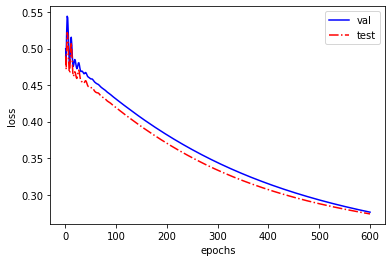

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4917295216, 4925432168]}]
Epoch: 0001 loss_train: 0.7249 acc_train: 0.1950 loss_val: 0.5036 acc_val: 0.8150 time: 0.0027s
Epoch: 0002 loss_train: 0.5116 acc_train: 0.8050 loss_val: 0.4672 acc_val: 0.8150 time: 0.0014s
Epoch: 0003 loss_train: 0.4824 acc_train: 0.8050 loss_val: 0.5000 acc_val: 0.8150 time: 0.0013s
Epoch: 0004 loss_train: 0.5202 acc_train: 0.8050 loss_val: 0.5314 acc_val: 0.8150 time: 0.0019s
Epoch: 0005 loss_train: 0.5544 acc_train: 0.8050 loss_val: 0.5428 acc_val: 0.8150 time: 0.0012s
Epoch: 0006 loss_train: 0.5666 acc_train: 0.8050 loss_val: 0.5349 acc_val: 0.8150 time: 0.0020s
Epoch: 0007 loss_train: 0.5581 acc_train: 0.8050 loss_val: 0.5144 ac

Epoch: 0113 loss_train: 0.4235 acc_train: 0.8050 loss_val: 0.4165 acc_val: 0.8150 time: 0.0019s
Epoch: 0114 loss_train: 0.4229 acc_train: 0.8050 loss_val: 0.4160 acc_val: 0.8150 time: 0.0014s
Epoch: 0115 loss_train: 0.4224 acc_train: 0.8050 loss_val: 0.4155 acc_val: 0.8150 time: 0.0020s
Epoch: 0116 loss_train: 0.4218 acc_train: 0.8050 loss_val: 0.4151 acc_val: 0.8150 time: 0.0014s
Epoch: 0117 loss_train: 0.4213 acc_train: 0.8050 loss_val: 0.4146 acc_val: 0.8150 time: 0.0015s
Epoch: 0118 loss_train: 0.4208 acc_train: 0.8050 loss_val: 0.4142 acc_val: 0.8150 time: 0.0013s
Epoch: 0119 loss_train: 0.4202 acc_train: 0.8050 loss_val: 0.4137 acc_val: 0.8150 time: 0.0016s
Epoch: 0120 loss_train: 0.4197 acc_train: 0.8050 loss_val: 0.4132 acc_val: 0.8150 time: 0.0013s
Epoch: 0121 loss_train: 0.4192 acc_train: 0.8050 loss_val: 0.4127 acc_val: 0.8150 time: 0.0015s
Epoch: 0122 loss_train: 0.4186 acc_train: 0.8050 loss_val: 0.4122 acc_val: 0.8150 time: 0.0014s
Epoch: 0123 loss_train: 0.4181 acc_train

Epoch: 0237 loss_train: 0.3637 acc_train: 0.8050 loss_val: 0.3635 acc_val: 0.8150 time: 0.0018s
Epoch: 0238 loss_train: 0.3633 acc_train: 0.8050 loss_val: 0.3631 acc_val: 0.8150 time: 0.0014s
Epoch: 0239 loss_train: 0.3629 acc_train: 0.8050 loss_val: 0.3628 acc_val: 0.8150 time: 0.0016s
Epoch: 0240 loss_train: 0.3625 acc_train: 0.8050 loss_val: 0.3624 acc_val: 0.8150 time: 0.0016s
Epoch: 0241 loss_train: 0.3621 acc_train: 0.8050 loss_val: 0.3620 acc_val: 0.8150 time: 0.0014s
Epoch: 0242 loss_train: 0.3617 acc_train: 0.8050 loss_val: 0.3617 acc_val: 0.8200 time: 0.0014s
Epoch: 0243 loss_train: 0.3613 acc_train: 0.8050 loss_val: 0.3613 acc_val: 0.8200 time: 0.0013s
Epoch: 0244 loss_train: 0.3608 acc_train: 0.8050 loss_val: 0.3609 acc_val: 0.8200 time: 0.0043s
Epoch: 0245 loss_train: 0.3604 acc_train: 0.8050 loss_val: 0.3606 acc_val: 0.8200 time: 0.0013s
Epoch: 0246 loss_train: 0.3600 acc_train: 0.8050 loss_val: 0.3602 acc_val: 0.8200 time: 0.0013s
Epoch: 0247 loss_train: 0.3596 acc_train

Epoch: 0361 loss_train: 0.3191 acc_train: 0.8350 loss_val: 0.3245 acc_val: 0.8300 time: 0.0016s
Epoch: 0362 loss_train: 0.3188 acc_train: 0.8350 loss_val: 0.3242 acc_val: 0.8300 time: 0.0032s
Epoch: 0363 loss_train: 0.3185 acc_train: 0.8350 loss_val: 0.3239 acc_val: 0.8300 time: 0.0018s
Epoch: 0364 loss_train: 0.3182 acc_train: 0.8350 loss_val: 0.3237 acc_val: 0.8300 time: 0.0013s
Epoch: 0365 loss_train: 0.3179 acc_train: 0.8350 loss_val: 0.3234 acc_val: 0.8300 time: 0.0015s
Epoch: 0366 loss_train: 0.3176 acc_train: 0.8350 loss_val: 0.3232 acc_val: 0.8300 time: 0.0014s
Epoch: 0367 loss_train: 0.3173 acc_train: 0.8400 loss_val: 0.3229 acc_val: 0.8300 time: 0.0013s
Epoch: 0368 loss_train: 0.3170 acc_train: 0.8400 loss_val: 0.3227 acc_val: 0.8300 time: 0.0016s
Epoch: 0369 loss_train: 0.3167 acc_train: 0.8400 loss_val: 0.3224 acc_val: 0.8350 time: 0.0014s
Epoch: 0370 loss_train: 0.3164 acc_train: 0.8400 loss_val: 0.3221 acc_val: 0.8400 time: 0.0014s
Epoch: 0371 loss_train: 0.3161 acc_train

Epoch: 0481 loss_train: 0.2879 acc_train: 0.8700 loss_val: 0.2981 acc_val: 0.8700 time: 0.0019s
Epoch: 0482 loss_train: 0.2876 acc_train: 0.8700 loss_val: 0.2979 acc_val: 0.8700 time: 0.0014s
Epoch: 0483 loss_train: 0.2874 acc_train: 0.8700 loss_val: 0.2977 acc_val: 0.8700 time: 0.0015s
Epoch: 0484 loss_train: 0.2872 acc_train: 0.8700 loss_val: 0.2975 acc_val: 0.8700 time: 0.0014s
Epoch: 0485 loss_train: 0.2870 acc_train: 0.8700 loss_val: 0.2973 acc_val: 0.8700 time: 0.0021s
Epoch: 0486 loss_train: 0.2868 acc_train: 0.8700 loss_val: 0.2972 acc_val: 0.8700 time: 0.0013s
Epoch: 0487 loss_train: 0.2865 acc_train: 0.8700 loss_val: 0.2970 acc_val: 0.8700 time: 0.0016s
Epoch: 0488 loss_train: 0.2863 acc_train: 0.8700 loss_val: 0.2968 acc_val: 0.8700 time: 0.0014s
Epoch: 0489 loss_train: 0.2861 acc_train: 0.8700 loss_val: 0.2966 acc_val: 0.8700 time: 0.0013s
Epoch: 0490 loss_train: 0.2859 acc_train: 0.8700 loss_val: 0.2964 acc_val: 0.8700 time: 0.0014s
Epoch: 0491 loss_train: 0.2857 acc_train

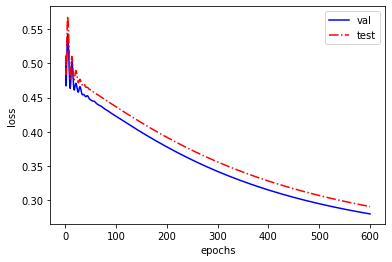

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4961980280, 4961979848]}]
Epoch: 0001 loss_train: 0.6706 acc_train: 0.8150 loss_val: 0.4983 acc_val: 0.8050 time: 0.0028s
Epoch: 0002 loss_train: 0.4882 acc_train: 0.8150 loss_val: 0.4928 acc_val: 0.8050 time: 0.0014s
Epoch: 0003 loss_train: 0.4748 acc_train: 0.8150 loss_val: 0.5354 acc_val: 0.8050 time: 0.0014s
Epoch: 0004 loss_train: 0.5120 acc_train: 0.8150 loss_val: 0.5654 acc_val: 0.8050 time: 0.0013s
Epoch: 0005 loss_train: 0.5394 acc_train: 0.8150 loss_val: 0.5709 acc_val: 0.8050 time: 0.0013s
Epoch: 0006 loss_train: 0.5444 acc_train: 0.8150 loss_val: 0.5564 acc_val: 0.8050 time: 0.0017s
Epoch: 0007 loss_train: 0.5311 acc_train: 0.8150 loss_val: 0.5306 ac

Epoch: 0111 loss_train: 0.4142 acc_train: 0.8150 loss_val: 0.4314 acc_val: 0.8050 time: 0.0019s
Epoch: 0112 loss_train: 0.4137 acc_train: 0.8150 loss_val: 0.4309 acc_val: 0.8050 time: 0.0015s
Epoch: 0113 loss_train: 0.4131 acc_train: 0.8150 loss_val: 0.4304 acc_val: 0.8050 time: 0.0015s
Epoch: 0114 loss_train: 0.4126 acc_train: 0.8150 loss_val: 0.4299 acc_val: 0.8050 time: 0.0015s
Epoch: 0115 loss_train: 0.4120 acc_train: 0.8150 loss_val: 0.4294 acc_val: 0.8050 time: 0.0014s
Epoch: 0116 loss_train: 0.4115 acc_train: 0.8150 loss_val: 0.4289 acc_val: 0.8050 time: 0.0015s
Epoch: 0117 loss_train: 0.4110 acc_train: 0.8150 loss_val: 0.4284 acc_val: 0.8050 time: 0.0022s
Epoch: 0118 loss_train: 0.4104 acc_train: 0.8150 loss_val: 0.4279 acc_val: 0.8050 time: 0.0014s
Epoch: 0119 loss_train: 0.4099 acc_train: 0.8150 loss_val: 0.4274 acc_val: 0.8050 time: 0.0014s
Epoch: 0120 loss_train: 0.4094 acc_train: 0.8150 loss_val: 0.4269 acc_val: 0.8050 time: 0.0013s
Epoch: 0121 loss_train: 0.4088 acc_train

Epoch: 0232 loss_train: 0.3563 acc_train: 0.8150 loss_val: 0.3768 acc_val: 0.8050 time: 0.0013s
Epoch: 0233 loss_train: 0.3559 acc_train: 0.8150 loss_val: 0.3764 acc_val: 0.8050 time: 0.0019s
Epoch: 0234 loss_train: 0.3555 acc_train: 0.8150 loss_val: 0.3760 acc_val: 0.8050 time: 0.0015s
Epoch: 0235 loss_train: 0.3551 acc_train: 0.8150 loss_val: 0.3756 acc_val: 0.8050 time: 0.0020s
Epoch: 0236 loss_train: 0.3547 acc_train: 0.8150 loss_val: 0.3752 acc_val: 0.8050 time: 0.0025s
Epoch: 0237 loss_train: 0.3543 acc_train: 0.8150 loss_val: 0.3748 acc_val: 0.8050 time: 0.0013s
Epoch: 0238 loss_train: 0.3539 acc_train: 0.8150 loss_val: 0.3744 acc_val: 0.8050 time: 0.0013s
Epoch: 0239 loss_train: 0.3535 acc_train: 0.8150 loss_val: 0.3741 acc_val: 0.8050 time: 0.0015s
Epoch: 0240 loss_train: 0.3531 acc_train: 0.8200 loss_val: 0.3737 acc_val: 0.8050 time: 0.0014s
Epoch: 0241 loss_train: 0.3527 acc_train: 0.8200 loss_val: 0.3733 acc_val: 0.8050 time: 0.0014s
Epoch: 0242 loss_train: 0.3523 acc_train

Epoch: 0354 loss_train: 0.3149 acc_train: 0.8300 loss_val: 0.3365 acc_val: 0.8250 time: 0.0016s
Epoch: 0355 loss_train: 0.3146 acc_train: 0.8300 loss_val: 0.3362 acc_val: 0.8250 time: 0.0015s
Epoch: 0356 loss_train: 0.3143 acc_train: 0.8300 loss_val: 0.3360 acc_val: 0.8250 time: 0.0014s
Epoch: 0357 loss_train: 0.3140 acc_train: 0.8300 loss_val: 0.3357 acc_val: 0.8250 time: 0.0017s
Epoch: 0358 loss_train: 0.3138 acc_train: 0.8300 loss_val: 0.3354 acc_val: 0.8250 time: 0.0014s
Epoch: 0359 loss_train: 0.3135 acc_train: 0.8300 loss_val: 0.3351 acc_val: 0.8250 time: 0.0013s
Epoch: 0360 loss_train: 0.3132 acc_train: 0.8350 loss_val: 0.3349 acc_val: 0.8250 time: 0.0013s
Epoch: 0361 loss_train: 0.3129 acc_train: 0.8350 loss_val: 0.3346 acc_val: 0.8250 time: 0.0013s
Epoch: 0362 loss_train: 0.3127 acc_train: 0.8350 loss_val: 0.3343 acc_val: 0.8250 time: 0.0026s
Epoch: 0363 loss_train: 0.3124 acc_train: 0.8350 loss_val: 0.3341 acc_val: 0.8250 time: 0.0014s
Epoch: 0364 loss_train: 0.3121 acc_train

Epoch: 0475 loss_train: 0.2873 acc_train: 0.8650 loss_val: 0.3089 acc_val: 0.8300 time: 0.0019s
Epoch: 0476 loss_train: 0.2871 acc_train: 0.8650 loss_val: 0.3087 acc_val: 0.8300 time: 0.0015s
Epoch: 0477 loss_train: 0.2869 acc_train: 0.8650 loss_val: 0.3085 acc_val: 0.8300 time: 0.0029s
Epoch: 0478 loss_train: 0.2867 acc_train: 0.8650 loss_val: 0.3083 acc_val: 0.8300 time: 0.0022s
Epoch: 0479 loss_train: 0.2866 acc_train: 0.8650 loss_val: 0.3082 acc_val: 0.8300 time: 0.0014s
Epoch: 0480 loss_train: 0.2864 acc_train: 0.8650 loss_val: 0.3080 acc_val: 0.8300 time: 0.0014s
Epoch: 0481 loss_train: 0.2862 acc_train: 0.8650 loss_val: 0.3078 acc_val: 0.8300 time: 0.0020s
Epoch: 0482 loss_train: 0.2860 acc_train: 0.8650 loss_val: 0.3076 acc_val: 0.8300 time: 0.0014s
Epoch: 0483 loss_train: 0.2858 acc_train: 0.8650 loss_val: 0.3074 acc_val: 0.8300 time: 0.0016s
Epoch: 0484 loss_train: 0.2857 acc_train: 0.8650 loss_val: 0.3072 acc_val: 0.8300 time: 0.0014s
Epoch: 0485 loss_train: 0.2855 acc_train

Epoch: 0596 loss_train: 0.2688 acc_train: 0.8900 loss_val: 0.2898 acc_val: 0.8450 time: 0.0020s
Epoch: 0597 loss_train: 0.2686 acc_train: 0.8900 loss_val: 0.2897 acc_val: 0.8500 time: 0.0015s
Epoch: 0598 loss_train: 0.2685 acc_train: 0.8900 loss_val: 0.2895 acc_val: 0.8500 time: 0.0015s
Epoch: 0599 loss_train: 0.2684 acc_train: 0.8900 loss_val: 0.2894 acc_val: 0.8500 time: 0.0016s
Epoch: 0600 loss_train: 0.2683 acc_train: 0.8900 loss_val: 0.2893 acc_val: 0.8500 time: 0.0038s
Optimization Finished!
Total time elapsed: 1.9727s
Best result: val_loss= 0.28928473591804504 test_loss= 0.32054924964904785 test_acc= 0.855


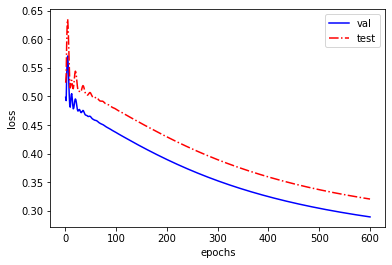

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4960460736, 4960460376]}]
Epoch: 0001 loss_train: 0.7230 acc_train: 0.1950 loss_val: 0.5337 acc_val: 0.7800 time: 0.0029s
Epoch: 0002 loss_train: 0.5118 acc_train: 0.8050 loss_val: 0.5260 acc_val: 0.7800 time: 0.0014s
Epoch: 0003 loss_train: 0.4846 acc_train: 0.8050 loss_val: 0.5776 acc_val: 0.7800 time: 0.0015s
Epoch: 0004 loss_train: 0.5229 acc_train: 0.8050 loss_val: 0.6185 acc_val: 0.7800 time: 0.0020s
Epoch: 0005 loss_train: 0.5566 acc_train: 0.8050 loss_val: 0.6320 acc_val: 0.7800 time: 0.0017s
Epoch: 0006 loss_train: 0.5679 acc_train: 0.8050 loss_val: 0.6209 acc_val: 0.7800 time: 0.0018s
Epoch: 0007 loss_train: 0.5585 acc_train: 0.8050 loss_val: 0.5936 ac

Epoch: 0110 loss_train: 0.4293 acc_train: 0.8050 loss_val: 0.4707 acc_val: 0.7800 time: 0.0016s
Epoch: 0111 loss_train: 0.4288 acc_train: 0.8050 loss_val: 0.4702 acc_val: 0.7800 time: 0.0014s
Epoch: 0112 loss_train: 0.4283 acc_train: 0.8050 loss_val: 0.4697 acc_val: 0.7800 time: 0.0016s
Epoch: 0113 loss_train: 0.4278 acc_train: 0.8050 loss_val: 0.4692 acc_val: 0.7800 time: 0.0014s
Epoch: 0114 loss_train: 0.4272 acc_train: 0.8050 loss_val: 0.4687 acc_val: 0.7800 time: 0.0015s
Epoch: 0115 loss_train: 0.4267 acc_train: 0.8050 loss_val: 0.4682 acc_val: 0.7800 time: 0.0014s
Epoch: 0116 loss_train: 0.4262 acc_train: 0.8050 loss_val: 0.4677 acc_val: 0.7800 time: 0.0014s
Epoch: 0117 loss_train: 0.4257 acc_train: 0.8050 loss_val: 0.4672 acc_val: 0.7800 time: 0.0017s
Epoch: 0118 loss_train: 0.4252 acc_train: 0.8050 loss_val: 0.4667 acc_val: 0.7800 time: 0.0018s
Epoch: 0119 loss_train: 0.4246 acc_train: 0.8050 loss_val: 0.4663 acc_val: 0.7800 time: 0.0017s
Epoch: 0120 loss_train: 0.4241 acc_train

Epoch: 0218 loss_train: 0.3775 acc_train: 0.8050 loss_val: 0.4211 acc_val: 0.7800 time: 0.0022s
Epoch: 0219 loss_train: 0.3771 acc_train: 0.8050 loss_val: 0.4207 acc_val: 0.7800 time: 0.0021s
Epoch: 0220 loss_train: 0.3767 acc_train: 0.8050 loss_val: 0.4203 acc_val: 0.7800 time: 0.0016s
Epoch: 0221 loss_train: 0.3762 acc_train: 0.8050 loss_val: 0.4198 acc_val: 0.7800 time: 0.0020s
Epoch: 0222 loss_train: 0.3758 acc_train: 0.8050 loss_val: 0.4194 acc_val: 0.7800 time: 0.0038s
Epoch: 0223 loss_train: 0.3754 acc_train: 0.8050 loss_val: 0.4190 acc_val: 0.7800 time: 0.0015s
Epoch: 0224 loss_train: 0.3749 acc_train: 0.8050 loss_val: 0.4186 acc_val: 0.7800 time: 0.0015s
Epoch: 0225 loss_train: 0.3745 acc_train: 0.8050 loss_val: 0.4182 acc_val: 0.7800 time: 0.0015s
Epoch: 0226 loss_train: 0.3741 acc_train: 0.8050 loss_val: 0.4177 acc_val: 0.7800 time: 0.0016s
Epoch: 0227 loss_train: 0.3737 acc_train: 0.8050 loss_val: 0.4173 acc_val: 0.7800 time: 0.0015s
Epoch: 0228 loss_train: 0.3733 acc_train

Epoch: 0325 loss_train: 0.3373 acc_train: 0.8150 loss_val: 0.3808 acc_val: 0.7900 time: 0.0021s
Epoch: 0326 loss_train: 0.3369 acc_train: 0.8200 loss_val: 0.3805 acc_val: 0.7900 time: 0.0022s
Epoch: 0327 loss_train: 0.3366 acc_train: 0.8200 loss_val: 0.3801 acc_val: 0.7900 time: 0.0018s
Epoch: 0328 loss_train: 0.3363 acc_train: 0.8200 loss_val: 0.3798 acc_val: 0.7950 time: 0.0017s
Epoch: 0329 loss_train: 0.3360 acc_train: 0.8200 loss_val: 0.3795 acc_val: 0.7950 time: 0.0017s
Epoch: 0330 loss_train: 0.3357 acc_train: 0.8250 loss_val: 0.3792 acc_val: 0.7950 time: 0.0016s
Epoch: 0331 loss_train: 0.3353 acc_train: 0.8250 loss_val: 0.3788 acc_val: 0.7950 time: 0.0015s
Epoch: 0332 loss_train: 0.3350 acc_train: 0.8250 loss_val: 0.3785 acc_val: 0.8000 time: 0.0015s
Epoch: 0333 loss_train: 0.3347 acc_train: 0.8250 loss_val: 0.3782 acc_val: 0.8000 time: 0.0024s
Epoch: 0334 loss_train: 0.3344 acc_train: 0.8250 loss_val: 0.3779 acc_val: 0.8000 time: 0.0016s
Epoch: 0335 loss_train: 0.3341 acc_train

Epoch: 0436 loss_train: 0.3067 acc_train: 0.8350 loss_val: 0.3493 acc_val: 0.8200 time: 0.0019s
Epoch: 0437 loss_train: 0.3065 acc_train: 0.8350 loss_val: 0.3491 acc_val: 0.8200 time: 0.0017s
Epoch: 0438 loss_train: 0.3063 acc_train: 0.8350 loss_val: 0.3488 acc_val: 0.8200 time: 0.0019s
Epoch: 0439 loss_train: 0.3060 acc_train: 0.8350 loss_val: 0.3486 acc_val: 0.8200 time: 0.0014s
Epoch: 0440 loss_train: 0.3058 acc_train: 0.8350 loss_val: 0.3483 acc_val: 0.8200 time: 0.0014s
Epoch: 0441 loss_train: 0.3056 acc_train: 0.8350 loss_val: 0.3481 acc_val: 0.8200 time: 0.0014s
Epoch: 0442 loss_train: 0.3054 acc_train: 0.8350 loss_val: 0.3479 acc_val: 0.8250 time: 0.0017s
Epoch: 0443 loss_train: 0.3051 acc_train: 0.8350 loss_val: 0.3476 acc_val: 0.8250 time: 0.0014s
Epoch: 0444 loss_train: 0.3049 acc_train: 0.8350 loss_val: 0.3474 acc_val: 0.8250 time: 0.0014s
Epoch: 0445 loss_train: 0.3047 acc_train: 0.8350 loss_val: 0.3472 acc_val: 0.8250 time: 0.0016s
Epoch: 0446 loss_train: 0.3045 acc_train

Epoch: 0541 loss_train: 0.2860 acc_train: 0.8550 loss_val: 0.3274 acc_val: 0.8450 time: 0.0029s
Epoch: 0542 loss_train: 0.2858 acc_train: 0.8550 loss_val: 0.3272 acc_val: 0.8450 time: 0.0016s
Epoch: 0543 loss_train: 0.2856 acc_train: 0.8550 loss_val: 0.3270 acc_val: 0.8450 time: 0.0016s
Epoch: 0544 loss_train: 0.2855 acc_train: 0.8550 loss_val: 0.3268 acc_val: 0.8450 time: 0.0017s
Epoch: 0545 loss_train: 0.2853 acc_train: 0.8550 loss_val: 0.3267 acc_val: 0.8450 time: 0.0015s
Epoch: 0546 loss_train: 0.2851 acc_train: 0.8550 loss_val: 0.3265 acc_val: 0.8450 time: 0.0015s
Epoch: 0547 loss_train: 0.2850 acc_train: 0.8550 loss_val: 0.3263 acc_val: 0.8450 time: 0.0014s
Epoch: 0548 loss_train: 0.2848 acc_train: 0.8550 loss_val: 0.3261 acc_val: 0.8450 time: 0.0029s
Epoch: 0549 loss_train: 0.2846 acc_train: 0.8550 loss_val: 0.3260 acc_val: 0.8450 time: 0.0016s
Epoch: 0550 loss_train: 0.2845 acc_train: 0.8600 loss_val: 0.3258 acc_val: 0.8450 time: 0.0027s
Epoch: 0551 loss_train: 0.2843 acc_train

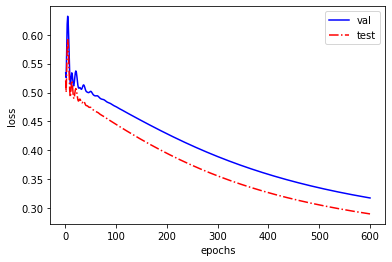

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4964380176, 4926509200]}]
Epoch: 0001 loss_train: 0.7854 acc_train: 0.2200 loss_val: 0.5438 acc_val: 0.7950 time: 0.0028s
Epoch: 0002 loss_train: 0.5535 acc_train: 0.7800 loss_val: 0.4947 acc_val: 0.7950 time: 0.0016s
Epoch: 0003 loss_train: 0.5170 acc_train: 0.7800 loss_val: 0.5271 acc_val: 0.7950 time: 0.0015s
Epoch: 0004 loss_train: 0.5584 acc_train: 0.7800 loss_val: 0.5608 acc_val: 0.7950 time: 0.0020s
Epoch: 0005 loss_train: 0.5969 acc_train: 0.7800 loss_val: 0.5726 acc_val: 0.7950 time: 0.0015s
Epoch: 0006 loss_train: 0.6103 acc_train: 0.7800 loss_val: 0.5634 acc_val: 0.7950 time: 0.0014s
Epoch: 0007 loss_train: 0.6000 acc_train: 0.7800 loss_val: 0.5409 ac

Epoch: 0104 loss_train: 0.4716 acc_train: 0.7800 loss_val: 0.4496 acc_val: 0.7950 time: 0.0027s
Epoch: 0105 loss_train: 0.4712 acc_train: 0.7800 loss_val: 0.4492 acc_val: 0.7950 time: 0.0020s
Epoch: 0106 loss_train: 0.4707 acc_train: 0.7800 loss_val: 0.4487 acc_val: 0.7950 time: 0.0019s
Epoch: 0107 loss_train: 0.4702 acc_train: 0.7800 loss_val: 0.4482 acc_val: 0.7950 time: 0.0022s
Epoch: 0108 loss_train: 0.4697 acc_train: 0.7800 loss_val: 0.4477 acc_val: 0.7950 time: 0.0014s
Epoch: 0109 loss_train: 0.4692 acc_train: 0.7800 loss_val: 0.4471 acc_val: 0.7950 time: 0.0015s
Epoch: 0110 loss_train: 0.4687 acc_train: 0.7800 loss_val: 0.4466 acc_val: 0.7950 time: 0.0046s
Epoch: 0111 loss_train: 0.4682 acc_train: 0.7800 loss_val: 0.4461 acc_val: 0.7950 time: 0.0014s
Epoch: 0112 loss_train: 0.4677 acc_train: 0.7800 loss_val: 0.4456 acc_val: 0.7950 time: 0.0015s
Epoch: 0113 loss_train: 0.4672 acc_train: 0.7800 loss_val: 0.4451 acc_val: 0.7950 time: 0.0014s
Epoch: 0114 loss_train: 0.4667 acc_train

Epoch: 0220 loss_train: 0.4166 acc_train: 0.7800 loss_val: 0.3960 acc_val: 0.7950 time: 0.0020s
Epoch: 0221 loss_train: 0.4162 acc_train: 0.7800 loss_val: 0.3955 acc_val: 0.7950 time: 0.0017s
Epoch: 0222 loss_train: 0.4158 acc_train: 0.7800 loss_val: 0.3951 acc_val: 0.7950 time: 0.0018s
Epoch: 0223 loss_train: 0.4153 acc_train: 0.7800 loss_val: 0.3947 acc_val: 0.7950 time: 0.0016s
Epoch: 0224 loss_train: 0.4149 acc_train: 0.7800 loss_val: 0.3943 acc_val: 0.7950 time: 0.0026s
Epoch: 0225 loss_train: 0.4145 acc_train: 0.7800 loss_val: 0.3939 acc_val: 0.7950 time: 0.0015s
Epoch: 0226 loss_train: 0.4140 acc_train: 0.7800 loss_val: 0.3935 acc_val: 0.7950 time: 0.0015s
Epoch: 0227 loss_train: 0.4136 acc_train: 0.7800 loss_val: 0.3930 acc_val: 0.7950 time: 0.0015s
Epoch: 0228 loss_train: 0.4132 acc_train: 0.7800 loss_val: 0.3926 acc_val: 0.7950 time: 0.0015s
Epoch: 0229 loss_train: 0.4127 acc_train: 0.7800 loss_val: 0.3922 acc_val: 0.7950 time: 0.0015s
Epoch: 0230 loss_train: 0.4123 acc_train

Epoch: 0336 loss_train: 0.3715 acc_train: 0.8000 loss_val: 0.3536 acc_val: 0.8100 time: 0.0022s
Epoch: 0337 loss_train: 0.3712 acc_train: 0.8000 loss_val: 0.3533 acc_val: 0.8100 time: 0.0015s
Epoch: 0338 loss_train: 0.3709 acc_train: 0.8000 loss_val: 0.3529 acc_val: 0.8100 time: 0.0017s
Epoch: 0339 loss_train: 0.3705 acc_train: 0.8000 loss_val: 0.3526 acc_val: 0.8150 time: 0.0019s
Epoch: 0340 loss_train: 0.3702 acc_train: 0.8000 loss_val: 0.3523 acc_val: 0.8150 time: 0.0015s
Epoch: 0341 loss_train: 0.3699 acc_train: 0.8000 loss_val: 0.3520 acc_val: 0.8150 time: 0.0014s
Epoch: 0342 loss_train: 0.3695 acc_train: 0.8000 loss_val: 0.3517 acc_val: 0.8150 time: 0.0015s
Epoch: 0343 loss_train: 0.3692 acc_train: 0.8000 loss_val: 0.3514 acc_val: 0.8150 time: 0.0014s
Epoch: 0344 loss_train: 0.3689 acc_train: 0.8000 loss_val: 0.3511 acc_val: 0.8150 time: 0.0034s
Epoch: 0345 loss_train: 0.3685 acc_train: 0.8050 loss_val: 0.3508 acc_val: 0.8150 time: 0.0015s
Epoch: 0346 loss_train: 0.3682 acc_train

Epoch: 0453 loss_train: 0.3379 acc_train: 0.8350 loss_val: 0.3227 acc_val: 0.8250 time: 0.0021s
Epoch: 0454 loss_train: 0.3377 acc_train: 0.8350 loss_val: 0.3225 acc_val: 0.8250 time: 0.0015s
Epoch: 0455 loss_train: 0.3374 acc_train: 0.8350 loss_val: 0.3222 acc_val: 0.8250 time: 0.0024s
Epoch: 0456 loss_train: 0.3372 acc_train: 0.8350 loss_val: 0.3220 acc_val: 0.8250 time: 0.0029s
Epoch: 0457 loss_train: 0.3370 acc_train: 0.8350 loss_val: 0.3218 acc_val: 0.8250 time: 0.0015s
Epoch: 0458 loss_train: 0.3367 acc_train: 0.8350 loss_val: 0.3216 acc_val: 0.8250 time: 0.0015s
Epoch: 0459 loss_train: 0.3365 acc_train: 0.8350 loss_val: 0.3214 acc_val: 0.8250 time: 0.0015s
Epoch: 0460 loss_train: 0.3362 acc_train: 0.8350 loss_val: 0.3212 acc_val: 0.8250 time: 0.0016s
Epoch: 0461 loss_train: 0.3360 acc_train: 0.8350 loss_val: 0.3209 acc_val: 0.8250 time: 0.0015s
Epoch: 0462 loss_train: 0.3358 acc_train: 0.8350 loss_val: 0.3207 acc_val: 0.8250 time: 0.0015s
Epoch: 0463 loss_train: 0.3355 acc_train

Epoch: 0569 loss_train: 0.3141 acc_train: 0.8600 loss_val: 0.3010 acc_val: 0.8550 time: 0.0014s
Epoch: 0570 loss_train: 0.3139 acc_train: 0.8600 loss_val: 0.3009 acc_val: 0.8550 time: 0.0018s
Epoch: 0571 loss_train: 0.3137 acc_train: 0.8600 loss_val: 0.3007 acc_val: 0.8550 time: 0.0021s
Epoch: 0572 loss_train: 0.3136 acc_train: 0.8600 loss_val: 0.3005 acc_val: 0.8550 time: 0.0020s
Epoch: 0573 loss_train: 0.3134 acc_train: 0.8600 loss_val: 0.3004 acc_val: 0.8550 time: 0.0016s
Epoch: 0574 loss_train: 0.3132 acc_train: 0.8650 loss_val: 0.3002 acc_val: 0.8550 time: 0.0016s
Epoch: 0575 loss_train: 0.3131 acc_train: 0.8650 loss_val: 0.3001 acc_val: 0.8550 time: 0.0015s
Epoch: 0576 loss_train: 0.3129 acc_train: 0.8650 loss_val: 0.2999 acc_val: 0.8550 time: 0.0014s
Epoch: 0577 loss_train: 0.3127 acc_train: 0.8650 loss_val: 0.2998 acc_val: 0.8550 time: 0.0015s
Epoch: 0578 loss_train: 0.3126 acc_train: 0.8650 loss_val: 0.2996 acc_val: 0.8550 time: 0.0015s
Epoch: 0579 loss_train: 0.3124 acc_train

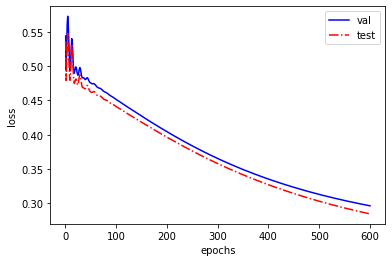

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4964353080, 4964353584]}]
Epoch: 0001 loss_train: 0.6725 acc_train: 0.7950 loss_val: 0.4971 acc_val: 0.8050 time: 0.0025s
Epoch: 0002 loss_train: 0.5081 acc_train: 0.7950 loss_val: 0.4892 acc_val: 0.8050 time: 0.0015s
Epoch: 0003 loss_train: 0.5076 acc_train: 0.7950 loss_val: 0.5240 acc_val: 0.8050 time: 0.0013s
Epoch: 0004 loss_train: 0.5467 acc_train: 0.7950 loss_val: 0.5430 acc_val: 0.8050 time: 0.0012s
Epoch: 0005 loss_train: 0.5673 acc_train: 0.7950 loss_val: 0.5387 acc_val: 0.8050 time: 0.0016s
Epoch: 0006 loss_train: 0.5627 acc_train: 0.7950 loss_val: 0.5192 acc_val: 0.8050 time: 0.0013s
Epoch: 0007 loss_train: 0.5413 acc_train: 0.7950 loss_val: 0.4959 ac

Epoch: 0113 loss_train: 0.4249 acc_train: 0.7950 loss_val: 0.4232 acc_val: 0.8050 time: 0.0016s
Epoch: 0114 loss_train: 0.4242 acc_train: 0.7950 loss_val: 0.4227 acc_val: 0.8050 time: 0.0014s
Epoch: 0115 loss_train: 0.4236 acc_train: 0.7950 loss_val: 0.4221 acc_val: 0.8050 time: 0.0019s
Epoch: 0116 loss_train: 0.4229 acc_train: 0.7950 loss_val: 0.4216 acc_val: 0.8050 time: 0.0013s
Epoch: 0117 loss_train: 0.4222 acc_train: 0.7950 loss_val: 0.4211 acc_val: 0.8050 time: 0.0013s
Epoch: 0118 loss_train: 0.4216 acc_train: 0.7950 loss_val: 0.4206 acc_val: 0.8050 time: 0.0013s
Epoch: 0119 loss_train: 0.4209 acc_train: 0.7950 loss_val: 0.4200 acc_val: 0.8050 time: 0.0025s
Epoch: 0120 loss_train: 0.4203 acc_train: 0.7950 loss_val: 0.4195 acc_val: 0.8050 time: 0.0013s
Epoch: 0121 loss_train: 0.4196 acc_train: 0.7950 loss_val: 0.4190 acc_val: 0.8050 time: 0.0013s
Epoch: 0122 loss_train: 0.4190 acc_train: 0.7950 loss_val: 0.4184 acc_val: 0.8050 time: 0.0013s
Epoch: 0123 loss_train: 0.4183 acc_train

Epoch: 0230 loss_train: 0.3599 acc_train: 0.8000 loss_val: 0.3681 acc_val: 0.8100 time: 0.0018s
Epoch: 0231 loss_train: 0.3594 acc_train: 0.8000 loss_val: 0.3677 acc_val: 0.8100 time: 0.0013s
Epoch: 0232 loss_train: 0.3590 acc_train: 0.8000 loss_val: 0.3673 acc_val: 0.8100 time: 0.0019s
Epoch: 0233 loss_train: 0.3585 acc_train: 0.8000 loss_val: 0.3669 acc_val: 0.8100 time: 0.0015s
Epoch: 0234 loss_train: 0.3581 acc_train: 0.8000 loss_val: 0.3665 acc_val: 0.8100 time: 0.0039s
Epoch: 0235 loss_train: 0.3576 acc_train: 0.8000 loss_val: 0.3661 acc_val: 0.8100 time: 0.0012s
Epoch: 0236 loss_train: 0.3572 acc_train: 0.8000 loss_val: 0.3657 acc_val: 0.8100 time: 0.0013s
Epoch: 0237 loss_train: 0.3568 acc_train: 0.8000 loss_val: 0.3653 acc_val: 0.8100 time: 0.0012s
Epoch: 0238 loss_train: 0.3563 acc_train: 0.8000 loss_val: 0.3650 acc_val: 0.8100 time: 0.0012s
Epoch: 0239 loss_train: 0.3559 acc_train: 0.8000 loss_val: 0.3646 acc_val: 0.8100 time: 0.0015s
Epoch: 0240 loss_train: 0.3554 acc_train

Epoch: 0356 loss_train: 0.3145 acc_train: 0.8250 loss_val: 0.3251 acc_val: 0.8500 time: 0.0019s
Epoch: 0357 loss_train: 0.3142 acc_train: 0.8250 loss_val: 0.3249 acc_val: 0.8500 time: 0.0013s
Epoch: 0358 loss_train: 0.3139 acc_train: 0.8250 loss_val: 0.3246 acc_val: 0.8500 time: 0.0015s
Epoch: 0359 loss_train: 0.3136 acc_train: 0.8250 loss_val: 0.3243 acc_val: 0.8500 time: 0.0014s
Epoch: 0360 loss_train: 0.3134 acc_train: 0.8250 loss_val: 0.3240 acc_val: 0.8500 time: 0.0012s
Epoch: 0361 loss_train: 0.3131 acc_train: 0.8250 loss_val: 0.3237 acc_val: 0.8500 time: 0.0013s
Epoch: 0362 loss_train: 0.3128 acc_train: 0.8250 loss_val: 0.3235 acc_val: 0.8500 time: 0.0012s
Epoch: 0363 loss_train: 0.3125 acc_train: 0.8300 loss_val: 0.3232 acc_val: 0.8500 time: 0.0019s
Epoch: 0364 loss_train: 0.3123 acc_train: 0.8300 loss_val: 0.3229 acc_val: 0.8500 time: 0.0013s
Epoch: 0365 loss_train: 0.3120 acc_train: 0.8300 loss_val: 0.3226 acc_val: 0.8500 time: 0.0013s
Epoch: 0366 loss_train: 0.3117 acc_train

Epoch: 0481 loss_train: 0.2865 acc_train: 0.8700 loss_val: 0.2952 acc_val: 0.8650 time: 0.0022s
Epoch: 0482 loss_train: 0.2863 acc_train: 0.8700 loss_val: 0.2950 acc_val: 0.8650 time: 0.0023s
Epoch: 0483 loss_train: 0.2861 acc_train: 0.8700 loss_val: 0.2948 acc_val: 0.8650 time: 0.0028s
Epoch: 0484 loss_train: 0.2860 acc_train: 0.8700 loss_val: 0.2946 acc_val: 0.8650 time: 0.0013s
Epoch: 0485 loss_train: 0.2858 acc_train: 0.8700 loss_val: 0.2944 acc_val: 0.8650 time: 0.0013s
Epoch: 0486 loss_train: 0.2856 acc_train: 0.8700 loss_val: 0.2942 acc_val: 0.8650 time: 0.0018s
Epoch: 0487 loss_train: 0.2854 acc_train: 0.8700 loss_val: 0.2940 acc_val: 0.8650 time: 0.0013s
Epoch: 0488 loss_train: 0.2853 acc_train: 0.8700 loss_val: 0.2938 acc_val: 0.8650 time: 0.0013s
Epoch: 0489 loss_train: 0.2851 acc_train: 0.8700 loss_val: 0.2936 acc_val: 0.8650 time: 0.0013s
Epoch: 0490 loss_train: 0.2849 acc_train: 0.8700 loss_val: 0.2934 acc_val: 0.8650 time: 0.0013s
Epoch: 0491 loss_train: 0.2847 acc_train

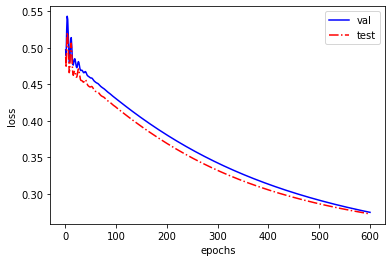

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4948270104, 4948270968]}]
Epoch: 0001 loss_train: 0.6975 acc_train: 0.1950 loss_val: 0.4953 acc_val: 0.8150 time: 0.0026s
Epoch: 0002 loss_train: 0.5040 acc_train: 0.8050 loss_val: 0.4704 acc_val: 0.8150 time: 0.0014s
Epoch: 0003 loss_train: 0.4863 acc_train: 0.8050 loss_val: 0.5044 acc_val: 0.8150 time: 0.0014s
Epoch: 0004 loss_train: 0.5250 acc_train: 0.8050 loss_val: 0.5317 acc_val: 0.8150 time: 0.0017s
Epoch: 0005 loss_train: 0.5547 acc_train: 0.8050 loss_val: 0.5377 acc_val: 0.8150 time: 0.0013s
Epoch: 0006 loss_train: 0.5612 acc_train: 0.8050 loss_val: 0.5255 acc_val: 0.8150 time: 0.0013s
Epoch: 0007 loss_train: 0.5480 acc_train: 0.8050 loss_val: 0.5031 ac

Epoch: 0114 loss_train: 0.4217 acc_train: 0.8050 loss_val: 0.4151 acc_val: 0.8150 time: 0.0027s
Epoch: 0115 loss_train: 0.4212 acc_train: 0.8050 loss_val: 0.4146 acc_val: 0.8150 time: 0.0014s
Epoch: 0116 loss_train: 0.4206 acc_train: 0.8050 loss_val: 0.4141 acc_val: 0.8150 time: 0.0015s
Epoch: 0117 loss_train: 0.4201 acc_train: 0.8050 loss_val: 0.4136 acc_val: 0.8150 time: 0.0014s
Epoch: 0118 loss_train: 0.4195 acc_train: 0.8050 loss_val: 0.4131 acc_val: 0.8150 time: 0.0013s
Epoch: 0119 loss_train: 0.4189 acc_train: 0.8050 loss_val: 0.4126 acc_val: 0.8150 time: 0.0013s
Epoch: 0120 loss_train: 0.4184 acc_train: 0.8050 loss_val: 0.4121 acc_val: 0.8150 time: 0.0013s
Epoch: 0121 loss_train: 0.4178 acc_train: 0.8050 loss_val: 0.4116 acc_val: 0.8150 time: 0.0015s
Epoch: 0122 loss_train: 0.4173 acc_train: 0.8050 loss_val: 0.4111 acc_val: 0.8150 time: 0.0017s
Epoch: 0123 loss_train: 0.4167 acc_train: 0.8050 loss_val: 0.4106 acc_val: 0.8150 time: 0.0013s
Epoch: 0124 loss_train: 0.4162 acc_train

Epoch: 0239 loss_train: 0.3600 acc_train: 0.8050 loss_val: 0.3602 acc_val: 0.8200 time: 0.0016s
Epoch: 0240 loss_train: 0.3596 acc_train: 0.8050 loss_val: 0.3599 acc_val: 0.8200 time: 0.0029s
Epoch: 0241 loss_train: 0.3591 acc_train: 0.8050 loss_val: 0.3595 acc_val: 0.8200 time: 0.0018s
Epoch: 0242 loss_train: 0.3587 acc_train: 0.8050 loss_val: 0.3591 acc_val: 0.8200 time: 0.0014s
Epoch: 0243 loss_train: 0.3583 acc_train: 0.8050 loss_val: 0.3587 acc_val: 0.8200 time: 0.0014s
Epoch: 0244 loss_train: 0.3579 acc_train: 0.8050 loss_val: 0.3584 acc_val: 0.8200 time: 0.0020s
Epoch: 0245 loss_train: 0.3575 acc_train: 0.8050 loss_val: 0.3580 acc_val: 0.8200 time: 0.0014s
Epoch: 0246 loss_train: 0.3570 acc_train: 0.8050 loss_val: 0.3576 acc_val: 0.8200 time: 0.0016s
Epoch: 0247 loss_train: 0.3566 acc_train: 0.8050 loss_val: 0.3573 acc_val: 0.8200 time: 0.0014s
Epoch: 0248 loss_train: 0.3562 acc_train: 0.8050 loss_val: 0.3569 acc_val: 0.8200 time: 0.0013s
Epoch: 0249 loss_train: 0.3558 acc_train

Epoch: 0361 loss_train: 0.3157 acc_train: 0.8400 loss_val: 0.3216 acc_val: 0.8400 time: 0.0019s
Epoch: 0362 loss_train: 0.3154 acc_train: 0.8400 loss_val: 0.3213 acc_val: 0.8400 time: 0.0015s
Epoch: 0363 loss_train: 0.3151 acc_train: 0.8400 loss_val: 0.3210 acc_val: 0.8400 time: 0.0016s
Epoch: 0364 loss_train: 0.3148 acc_train: 0.8400 loss_val: 0.3208 acc_val: 0.8400 time: 0.0015s
Epoch: 0365 loss_train: 0.3145 acc_train: 0.8450 loss_val: 0.3205 acc_val: 0.8400 time: 0.0016s
Epoch: 0366 loss_train: 0.3142 acc_train: 0.8450 loss_val: 0.3203 acc_val: 0.8400 time: 0.0014s
Epoch: 0367 loss_train: 0.3139 acc_train: 0.8450 loss_val: 0.3200 acc_val: 0.8400 time: 0.0014s
Epoch: 0368 loss_train: 0.3136 acc_train: 0.8450 loss_val: 0.3197 acc_val: 0.8400 time: 0.0013s
Epoch: 0369 loss_train: 0.3133 acc_train: 0.8450 loss_val: 0.3195 acc_val: 0.8400 time: 0.0016s
Epoch: 0370 loss_train: 0.3130 acc_train: 0.8450 loss_val: 0.3192 acc_val: 0.8400 time: 0.0016s
Epoch: 0371 loss_train: 0.3127 acc_train

Epoch: 0484 loss_train: 0.2838 acc_train: 0.8700 loss_val: 0.2948 acc_val: 0.8700 time: 0.0022s
Epoch: 0485 loss_train: 0.2836 acc_train: 0.8700 loss_val: 0.2946 acc_val: 0.8700 time: 0.0014s
Epoch: 0486 loss_train: 0.2834 acc_train: 0.8700 loss_val: 0.2944 acc_val: 0.8700 time: 0.0019s
Epoch: 0487 loss_train: 0.2832 acc_train: 0.8750 loss_val: 0.2942 acc_val: 0.8700 time: 0.0017s
Epoch: 0488 loss_train: 0.2830 acc_train: 0.8750 loss_val: 0.2941 acc_val: 0.8700 time: 0.0013s
Epoch: 0489 loss_train: 0.2828 acc_train: 0.8750 loss_val: 0.2939 acc_val: 0.8700 time: 0.0013s
Epoch: 0490 loss_train: 0.2825 acc_train: 0.8750 loss_val: 0.2937 acc_val: 0.8700 time: 0.0014s
Epoch: 0491 loss_train: 0.2823 acc_train: 0.8750 loss_val: 0.2935 acc_val: 0.8700 time: 0.0013s
Epoch: 0492 loss_train: 0.2821 acc_train: 0.8750 loss_val: 0.2934 acc_val: 0.8700 time: 0.0021s
Epoch: 0493 loss_train: 0.2819 acc_train: 0.8750 loss_val: 0.2932 acc_val: 0.8750 time: 0.0014s
Epoch: 0494 loss_train: 0.2817 acc_train

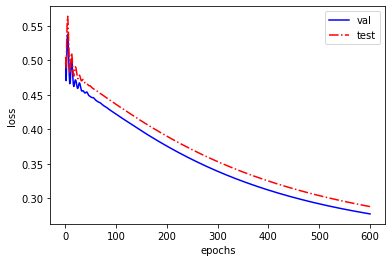

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4964353584, 4964353080]}]
Epoch: 0001 loss_train: 0.6674 acc_train: 0.8150 loss_val: 0.4971 acc_val: 0.8050 time: 0.0032s
Epoch: 0002 loss_train: 0.4869 acc_train: 0.8150 loss_val: 0.4926 acc_val: 0.8050 time: 0.0014s
Epoch: 0003 loss_train: 0.4745 acc_train: 0.8150 loss_val: 0.5352 acc_val: 0.8050 time: 0.0013s
Epoch: 0004 loss_train: 0.5118 acc_train: 0.8150 loss_val: 0.5646 acc_val: 0.8050 time: 0.0013s
Epoch: 0005 loss_train: 0.5386 acc_train: 0.8150 loss_val: 0.5695 acc_val: 0.8050 time: 0.0019s
Epoch: 0006 loss_train: 0.5431 acc_train: 0.8150 loss_val: 0.5546 acc_val: 0.8050 time: 0.0013s
Epoch: 0007 loss_train: 0.5293 acc_train: 0.8150 loss_val: 0.5286 ac

Epoch: 0107 loss_train: 0.4157 acc_train: 0.8150 loss_val: 0.4328 acc_val: 0.8050 time: 0.0017s
Epoch: 0108 loss_train: 0.4152 acc_train: 0.8150 loss_val: 0.4323 acc_val: 0.8050 time: 0.0014s
Epoch: 0109 loss_train: 0.4146 acc_train: 0.8150 loss_val: 0.4318 acc_val: 0.8050 time: 0.0015s
Epoch: 0110 loss_train: 0.4141 acc_train: 0.8150 loss_val: 0.4313 acc_val: 0.8050 time: 0.0014s
Epoch: 0111 loss_train: 0.4135 acc_train: 0.8150 loss_val: 0.4308 acc_val: 0.8050 time: 0.0023s
Epoch: 0112 loss_train: 0.4130 acc_train: 0.8150 loss_val: 0.4302 acc_val: 0.8050 time: 0.0014s
Epoch: 0113 loss_train: 0.4125 acc_train: 0.8150 loss_val: 0.4297 acc_val: 0.8050 time: 0.0015s
Epoch: 0114 loss_train: 0.4119 acc_train: 0.8150 loss_val: 0.4292 acc_val: 0.8050 time: 0.0014s
Epoch: 0115 loss_train: 0.4114 acc_train: 0.8150 loss_val: 0.4287 acc_val: 0.8050 time: 0.0013s
Epoch: 0116 loss_train: 0.4108 acc_train: 0.8150 loss_val: 0.4282 acc_val: 0.8050 time: 0.0015s
Epoch: 0117 loss_train: 0.4103 acc_train

Epoch: 0229 loss_train: 0.3570 acc_train: 0.8150 loss_val: 0.3773 acc_val: 0.8050 time: 0.0019s
Epoch: 0230 loss_train: 0.3566 acc_train: 0.8150 loss_val: 0.3769 acc_val: 0.8050 time: 0.0014s
Epoch: 0231 loss_train: 0.3562 acc_train: 0.8150 loss_val: 0.3765 acc_val: 0.8050 time: 0.0016s
Epoch: 0232 loss_train: 0.3557 acc_train: 0.8150 loss_val: 0.3762 acc_val: 0.8050 time: 0.0015s
Epoch: 0233 loss_train: 0.3553 acc_train: 0.8150 loss_val: 0.3758 acc_val: 0.8050 time: 0.0014s
Epoch: 0234 loss_train: 0.3549 acc_train: 0.8150 loss_val: 0.3754 acc_val: 0.8050 time: 0.0014s
Epoch: 0235 loss_train: 0.3545 acc_train: 0.8150 loss_val: 0.3750 acc_val: 0.8050 time: 0.0013s
Epoch: 0236 loss_train: 0.3541 acc_train: 0.8150 loss_val: 0.3746 acc_val: 0.8050 time: 0.0014s
Epoch: 0237 loss_train: 0.3537 acc_train: 0.8200 loss_val: 0.3742 acc_val: 0.8050 time: 0.0037s
Epoch: 0238 loss_train: 0.3533 acc_train: 0.8200 loss_val: 0.3738 acc_val: 0.8050 time: 0.0014s
Epoch: 0239 loss_train: 0.3529 acc_train

Epoch: 0351 loss_train: 0.3152 acc_train: 0.8300 loss_val: 0.3368 acc_val: 0.8250 time: 0.0019s
Epoch: 0352 loss_train: 0.3149 acc_train: 0.8300 loss_val: 0.3365 acc_val: 0.8250 time: 0.0015s
Epoch: 0353 loss_train: 0.3147 acc_train: 0.8300 loss_val: 0.3363 acc_val: 0.8250 time: 0.0017s
Epoch: 0354 loss_train: 0.3144 acc_train: 0.8300 loss_val: 0.3360 acc_val: 0.8250 time: 0.0016s
Epoch: 0355 loss_train: 0.3141 acc_train: 0.8300 loss_val: 0.3357 acc_val: 0.8250 time: 0.0014s
Epoch: 0356 loss_train: 0.3138 acc_train: 0.8300 loss_val: 0.3355 acc_val: 0.8250 time: 0.0026s
Epoch: 0357 loss_train: 0.3136 acc_train: 0.8300 loss_val: 0.3352 acc_val: 0.8250 time: 0.0014s
Epoch: 0358 loss_train: 0.3133 acc_train: 0.8350 loss_val: 0.3349 acc_val: 0.8250 time: 0.0016s
Epoch: 0359 loss_train: 0.3130 acc_train: 0.8350 loss_val: 0.3346 acc_val: 0.8250 time: 0.0014s
Epoch: 0360 loss_train: 0.3127 acc_train: 0.8350 loss_val: 0.3344 acc_val: 0.8250 time: 0.0014s
Epoch: 0361 loss_train: 0.3125 acc_train

Epoch: 0471 loss_train: 0.2877 acc_train: 0.8650 loss_val: 0.3093 acc_val: 0.8300 time: 0.0018s
Epoch: 0472 loss_train: 0.2875 acc_train: 0.8650 loss_val: 0.3091 acc_val: 0.8300 time: 0.0015s
Epoch: 0473 loss_train: 0.2873 acc_train: 0.8650 loss_val: 0.3089 acc_val: 0.8300 time: 0.0020s
Epoch: 0474 loss_train: 0.2871 acc_train: 0.8650 loss_val: 0.3087 acc_val: 0.8300 time: 0.0015s
Epoch: 0475 loss_train: 0.2869 acc_train: 0.8650 loss_val: 0.3085 acc_val: 0.8300 time: 0.0025s
Epoch: 0476 loss_train: 0.2867 acc_train: 0.8650 loss_val: 0.3083 acc_val: 0.8300 time: 0.0016s
Epoch: 0477 loss_train: 0.2866 acc_train: 0.8650 loss_val: 0.3081 acc_val: 0.8300 time: 0.0014s
Epoch: 0478 loss_train: 0.2864 acc_train: 0.8650 loss_val: 0.3080 acc_val: 0.8300 time: 0.0014s
Epoch: 0479 loss_train: 0.2862 acc_train: 0.8650 loss_val: 0.3078 acc_val: 0.8300 time: 0.0014s
Epoch: 0480 loss_train: 0.2860 acc_train: 0.8650 loss_val: 0.3076 acc_val: 0.8300 time: 0.0014s
Epoch: 0481 loss_train: 0.2858 acc_train

Epoch: 0592 loss_train: 0.2690 acc_train: 0.8900 loss_val: 0.2900 acc_val: 0.8450 time: 0.0017s
Epoch: 0593 loss_train: 0.2689 acc_train: 0.8900 loss_val: 0.2899 acc_val: 0.8450 time: 0.0014s
Epoch: 0594 loss_train: 0.2687 acc_train: 0.8900 loss_val: 0.2897 acc_val: 0.8450 time: 0.0015s
Epoch: 0595 loss_train: 0.2686 acc_train: 0.8900 loss_val: 0.2896 acc_val: 0.8500 time: 0.0013s
Epoch: 0596 loss_train: 0.2685 acc_train: 0.8900 loss_val: 0.2895 acc_val: 0.8500 time: 0.0014s
Epoch: 0597 loss_train: 0.2683 acc_train: 0.8900 loss_val: 0.2894 acc_val: 0.8500 time: 0.0013s
Epoch: 0598 loss_train: 0.2682 acc_train: 0.8900 loss_val: 0.2892 acc_val: 0.8500 time: 0.0013s
Epoch: 0599 loss_train: 0.2681 acc_train: 0.8900 loss_val: 0.2891 acc_val: 0.8500 time: 0.0014s
Epoch: 0600 loss_train: 0.2680 acc_train: 0.8900 loss_val: 0.2890 acc_val: 0.8500 time: 0.0026s
Optimization Finished!
Total time elapsed: 1.9888s
Best result: val_loss= 0.2889658212661743 test_loss= 0.3202284276485443 test_acc= 0.8

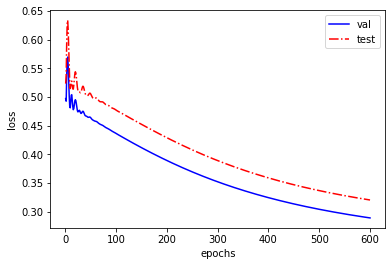

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4948270104, 4963350136]}]
Epoch: 0001 loss_train: 0.7165 acc_train: 0.1950 loss_val: 0.5323 acc_val: 0.7800 time: 0.0027s
Epoch: 0002 loss_train: 0.5099 acc_train: 0.8050 loss_val: 0.5271 acc_val: 0.7800 time: 0.0014s
Epoch: 0003 loss_train: 0.4855 acc_train: 0.8050 loss_val: 0.5788 acc_val: 0.7800 time: 0.0014s
Epoch: 0004 loss_train: 0.5240 acc_train: 0.8050 loss_val: 0.6185 acc_val: 0.7800 time: 0.0019s
Epoch: 0005 loss_train: 0.5567 acc_train: 0.8050 loss_val: 0.6303 acc_val: 0.7800 time: 0.0013s
Epoch: 0006 loss_train: 0.5667 acc_train: 0.8050 loss_val: 0.6179 acc_val: 0.7800 time: 0.0015s
Epoch: 0007 loss_train: 0.5561 acc_train: 0.8050 loss_val: 0.5898 ac

Epoch: 0111 loss_train: 0.4285 acc_train: 0.8050 loss_val: 0.4699 acc_val: 0.7800 time: 0.0026s
Epoch: 0112 loss_train: 0.4280 acc_train: 0.8050 loss_val: 0.4694 acc_val: 0.7800 time: 0.0017s
Epoch: 0113 loss_train: 0.4274 acc_train: 0.8050 loss_val: 0.4689 acc_val: 0.7800 time: 0.0022s
Epoch: 0114 loss_train: 0.4269 acc_train: 0.8050 loss_val: 0.4683 acc_val: 0.7800 time: 0.0014s
Epoch: 0115 loss_train: 0.4264 acc_train: 0.8050 loss_val: 0.4678 acc_val: 0.7800 time: 0.0014s
Epoch: 0116 loss_train: 0.4258 acc_train: 0.8050 loss_val: 0.4673 acc_val: 0.7800 time: 0.0014s
Epoch: 0117 loss_train: 0.4253 acc_train: 0.8050 loss_val: 0.4668 acc_val: 0.7800 time: 0.0016s
Epoch: 0118 loss_train: 0.4248 acc_train: 0.8050 loss_val: 0.4663 acc_val: 0.7800 time: 0.0024s
Epoch: 0119 loss_train: 0.4243 acc_train: 0.8050 loss_val: 0.4659 acc_val: 0.7800 time: 0.0014s
Epoch: 0120 loss_train: 0.4237 acc_train: 0.8050 loss_val: 0.4654 acc_val: 0.7800 time: 0.0016s
Epoch: 0121 loss_train: 0.4232 acc_train

Epoch: 0231 loss_train: 0.3712 acc_train: 0.8050 loss_val: 0.4149 acc_val: 0.7800 time: 0.0025s
Epoch: 0232 loss_train: 0.3708 acc_train: 0.8050 loss_val: 0.4145 acc_val: 0.7800 time: 0.0029s
Epoch: 0233 loss_train: 0.3704 acc_train: 0.8050 loss_val: 0.4140 acc_val: 0.7800 time: 0.0019s
Epoch: 0234 loss_train: 0.3700 acc_train: 0.8050 loss_val: 0.4136 acc_val: 0.7800 time: 0.0014s
Epoch: 0235 loss_train: 0.3696 acc_train: 0.8050 loss_val: 0.4132 acc_val: 0.7800 time: 0.0015s
Epoch: 0236 loss_train: 0.3692 acc_train: 0.8050 loss_val: 0.4128 acc_val: 0.7800 time: 0.0014s
Epoch: 0237 loss_train: 0.3687 acc_train: 0.8050 loss_val: 0.4124 acc_val: 0.7800 time: 0.0023s
Epoch: 0238 loss_train: 0.3683 acc_train: 0.8050 loss_val: 0.4120 acc_val: 0.7800 time: 0.0015s
Epoch: 0239 loss_train: 0.3679 acc_train: 0.8050 loss_val: 0.4116 acc_val: 0.7800 time: 0.0014s
Epoch: 0240 loss_train: 0.3675 acc_train: 0.8050 loss_val: 0.4112 acc_val: 0.7800 time: 0.0015s
Epoch: 0241 loss_train: 0.3671 acc_train

Epoch: 0349 loss_train: 0.3289 acc_train: 0.8250 loss_val: 0.3722 acc_val: 0.8100 time: 0.0019s
Epoch: 0350 loss_train: 0.3286 acc_train: 0.8250 loss_val: 0.3719 acc_val: 0.8100 time: 0.0015s
Epoch: 0351 loss_train: 0.3283 acc_train: 0.8250 loss_val: 0.3716 acc_val: 0.8100 time: 0.0016s
Epoch: 0352 loss_train: 0.3280 acc_train: 0.8250 loss_val: 0.3713 acc_val: 0.8100 time: 0.0015s
Epoch: 0353 loss_train: 0.3277 acc_train: 0.8250 loss_val: 0.3710 acc_val: 0.8100 time: 0.0031s
Epoch: 0354 loss_train: 0.3274 acc_train: 0.8250 loss_val: 0.3707 acc_val: 0.8100 time: 0.0014s
Epoch: 0355 loss_train: 0.3271 acc_train: 0.8250 loss_val: 0.3704 acc_val: 0.8100 time: 0.0015s
Epoch: 0356 loss_train: 0.3268 acc_train: 0.8250 loss_val: 0.3701 acc_val: 0.8100 time: 0.0014s
Epoch: 0357 loss_train: 0.3265 acc_train: 0.8250 loss_val: 0.3698 acc_val: 0.8100 time: 0.0016s
Epoch: 0358 loss_train: 0.3262 acc_train: 0.8250 loss_val: 0.3695 acc_val: 0.8150 time: 0.0015s
Epoch: 0359 loss_train: 0.3259 acc_train

Epoch: 0465 loss_train: 0.2995 acc_train: 0.8350 loss_val: 0.3417 acc_val: 0.8350 time: 0.0022s
Epoch: 0466 loss_train: 0.2993 acc_train: 0.8350 loss_val: 0.3415 acc_val: 0.8350 time: 0.0014s
Epoch: 0467 loss_train: 0.2991 acc_train: 0.8400 loss_val: 0.3412 acc_val: 0.8350 time: 0.0018s
Epoch: 0468 loss_train: 0.2989 acc_train: 0.8400 loss_val: 0.3410 acc_val: 0.8350 time: 0.0015s
Epoch: 0469 loss_train: 0.2987 acc_train: 0.8450 loss_val: 0.3408 acc_val: 0.8350 time: 0.0014s
Epoch: 0470 loss_train: 0.2984 acc_train: 0.8450 loss_val: 0.3406 acc_val: 0.8350 time: 0.0014s
Epoch: 0471 loss_train: 0.2982 acc_train: 0.8450 loss_val: 0.3404 acc_val: 0.8400 time: 0.0015s
Epoch: 0472 loss_train: 0.2980 acc_train: 0.8450 loss_val: 0.3401 acc_val: 0.8400 time: 0.0032s
Epoch: 0473 loss_train: 0.2978 acc_train: 0.8450 loss_val: 0.3399 acc_val: 0.8400 time: 0.0015s
Epoch: 0474 loss_train: 0.2976 acc_train: 0.8450 loss_val: 0.3397 acc_val: 0.8400 time: 0.0014s
Epoch: 0475 loss_train: 0.2974 acc_train

Epoch: 0585 loss_train: 0.2783 acc_train: 0.8650 loss_val: 0.3192 acc_val: 0.8750 time: 0.0020s
Epoch: 0586 loss_train: 0.2782 acc_train: 0.8650 loss_val: 0.3190 acc_val: 0.8750 time: 0.0015s
Epoch: 0587 loss_train: 0.2780 acc_train: 0.8650 loss_val: 0.3189 acc_val: 0.8750 time: 0.0023s
Epoch: 0588 loss_train: 0.2779 acc_train: 0.8650 loss_val: 0.3187 acc_val: 0.8750 time: 0.0014s
Epoch: 0589 loss_train: 0.2777 acc_train: 0.8650 loss_val: 0.3186 acc_val: 0.8750 time: 0.0024s
Epoch: 0590 loss_train: 0.2776 acc_train: 0.8650 loss_val: 0.3184 acc_val: 0.8750 time: 0.0014s
Epoch: 0591 loss_train: 0.2774 acc_train: 0.8650 loss_val: 0.3183 acc_val: 0.8750 time: 0.0014s
Epoch: 0592 loss_train: 0.2773 acc_train: 0.8650 loss_val: 0.3181 acc_val: 0.8750 time: 0.0014s
Epoch: 0593 loss_train: 0.2772 acc_train: 0.8650 loss_val: 0.3180 acc_val: 0.8750 time: 0.0016s
Epoch: 0594 loss_train: 0.2770 acc_train: 0.8650 loss_val: 0.3178 acc_val: 0.8750 time: 0.0015s
Epoch: 0595 loss_train: 0.2769 acc_train

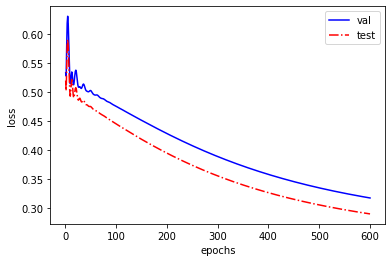

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4962419696, 4962419552]}]
Epoch: 0001 loss_train: 0.7159 acc_train: 0.2200 loss_val: 0.5192 acc_val: 0.7950 time: 0.0023s
Epoch: 0002 loss_train: 0.5322 acc_train: 0.7800 loss_val: 0.4998 acc_val: 0.7950 time: 0.0028s
Epoch: 0003 loss_train: 0.5249 acc_train: 0.7800 loss_val: 0.5348 acc_val: 0.7950 time: 0.0015s
Epoch: 0004 loss_train: 0.5674 acc_train: 0.7800 loss_val: 0.5570 acc_val: 0.7950 time: 0.0015s
Epoch: 0005 loss_train: 0.5928 acc_train: 0.7800 loss_val: 0.5551 acc_val: 0.7950 time: 0.0015s
Epoch: 0006 loss_train: 0.5908 acc_train: 0.7800 loss_val: 0.5364 acc_val: 0.7950 time: 0.0014s
Epoch: 0007 loss_train: 0.5695 acc_train: 0.7800 loss_val: 0.5123 ac

Epoch: 0106 loss_train: 0.4664 acc_train: 0.7800 loss_val: 0.4442 acc_val: 0.7950 time: 0.0021s
Epoch: 0107 loss_train: 0.4659 acc_train: 0.7800 loss_val: 0.4437 acc_val: 0.7950 time: 0.0015s
Epoch: 0108 loss_train: 0.4653 acc_train: 0.7800 loss_val: 0.4432 acc_val: 0.7950 time: 0.0016s
Epoch: 0109 loss_train: 0.4648 acc_train: 0.7800 loss_val: 0.4427 acc_val: 0.7950 time: 0.0018s
Epoch: 0110 loss_train: 0.4643 acc_train: 0.7800 loss_val: 0.4421 acc_val: 0.7950 time: 0.0015s
Epoch: 0111 loss_train: 0.4637 acc_train: 0.7800 loss_val: 0.4416 acc_val: 0.7950 time: 0.0029s
Epoch: 0112 loss_train: 0.4632 acc_train: 0.7800 loss_val: 0.4410 acc_val: 0.7950 time: 0.0015s
Epoch: 0113 loss_train: 0.4627 acc_train: 0.7800 loss_val: 0.4405 acc_val: 0.7950 time: 0.0016s
Epoch: 0114 loss_train: 0.4621 acc_train: 0.7800 loss_val: 0.4399 acc_val: 0.7950 time: 0.0015s
Epoch: 0115 loss_train: 0.4616 acc_train: 0.7800 loss_val: 0.4394 acc_val: 0.7950 time: 0.0015s
Epoch: 0116 loss_train: 0.4610 acc_train

Epoch: 0217 loss_train: 0.4098 acc_train: 0.7800 loss_val: 0.3894 acc_val: 0.7950 time: 0.0022s
Epoch: 0218 loss_train: 0.4093 acc_train: 0.7800 loss_val: 0.3889 acc_val: 0.7950 time: 0.0015s
Epoch: 0219 loss_train: 0.4089 acc_train: 0.7800 loss_val: 0.3885 acc_val: 0.7950 time: 0.0016s
Epoch: 0220 loss_train: 0.4084 acc_train: 0.7800 loss_val: 0.3881 acc_val: 0.7950 time: 0.0015s
Epoch: 0221 loss_train: 0.4079 acc_train: 0.7800 loss_val: 0.3876 acc_val: 0.7950 time: 0.0041s
Epoch: 0222 loss_train: 0.4075 acc_train: 0.7800 loss_val: 0.3872 acc_val: 0.7950 time: 0.0015s
Epoch: 0223 loss_train: 0.4070 acc_train: 0.7800 loss_val: 0.3868 acc_val: 0.7950 time: 0.0016s
Epoch: 0224 loss_train: 0.4066 acc_train: 0.7800 loss_val: 0.3863 acc_val: 0.7950 time: 0.0015s
Epoch: 0225 loss_train: 0.4061 acc_train: 0.7850 loss_val: 0.3859 acc_val: 0.7950 time: 0.0016s
Epoch: 0226 loss_train: 0.4057 acc_train: 0.7850 loss_val: 0.3855 acc_val: 0.7950 time: 0.0015s
Epoch: 0227 loss_train: 0.4052 acc_train

Epoch: 0335 loss_train: 0.3624 acc_train: 0.8100 loss_val: 0.3451 acc_val: 0.8100 time: 0.0018s
Epoch: 0336 loss_train: 0.3621 acc_train: 0.8100 loss_val: 0.3448 acc_val: 0.8100 time: 0.0017s
Epoch: 0337 loss_train: 0.3617 acc_train: 0.8100 loss_val: 0.3445 acc_val: 0.8100 time: 0.0022s
Epoch: 0338 loss_train: 0.3614 acc_train: 0.8150 loss_val: 0.3442 acc_val: 0.8100 time: 0.0014s
Epoch: 0339 loss_train: 0.3611 acc_train: 0.8150 loss_val: 0.3439 acc_val: 0.8150 time: 0.0014s
Epoch: 0340 loss_train: 0.3607 acc_train: 0.8150 loss_val: 0.3436 acc_val: 0.8150 time: 0.0015s
Epoch: 0341 loss_train: 0.3604 acc_train: 0.8150 loss_val: 0.3433 acc_val: 0.8150 time: 0.0014s
Epoch: 0342 loss_train: 0.3601 acc_train: 0.8150 loss_val: 0.3430 acc_val: 0.8150 time: 0.0023s
Epoch: 0343 loss_train: 0.3597 acc_train: 0.8150 loss_val: 0.3427 acc_val: 0.8150 time: 0.0015s
Epoch: 0344 loss_train: 0.3594 acc_train: 0.8150 loss_val: 0.3424 acc_val: 0.8150 time: 0.0016s
Epoch: 0345 loss_train: 0.3591 acc_train

Epoch: 0455 loss_train: 0.3285 acc_train: 0.8550 loss_val: 0.3141 acc_val: 0.8350 time: 0.0018s
Epoch: 0456 loss_train: 0.3283 acc_train: 0.8550 loss_val: 0.3139 acc_val: 0.8350 time: 0.0016s
Epoch: 0457 loss_train: 0.3280 acc_train: 0.8550 loss_val: 0.3137 acc_val: 0.8350 time: 0.0018s
Epoch: 0458 loss_train: 0.3278 acc_train: 0.8550 loss_val: 0.3135 acc_val: 0.8350 time: 0.0015s
Epoch: 0459 loss_train: 0.3276 acc_train: 0.8550 loss_val: 0.3133 acc_val: 0.8350 time: 0.0015s
Epoch: 0460 loss_train: 0.3274 acc_train: 0.8600 loss_val: 0.3131 acc_val: 0.8350 time: 0.0030s
Epoch: 0461 loss_train: 0.3271 acc_train: 0.8600 loss_val: 0.3128 acc_val: 0.8350 time: 0.0014s
Epoch: 0462 loss_train: 0.3269 acc_train: 0.8600 loss_val: 0.3126 acc_val: 0.8400 time: 0.0016s
Epoch: 0463 loss_train: 0.3267 acc_train: 0.8600 loss_val: 0.3124 acc_val: 0.8400 time: 0.0014s
Epoch: 0464 loss_train: 0.3264 acc_train: 0.8600 loss_val: 0.3122 acc_val: 0.8400 time: 0.0015s
Epoch: 0465 loss_train: 0.3262 acc_train

Epoch: 0574 loss_train: 0.3055 acc_train: 0.8700 loss_val: 0.2932 acc_val: 0.8650 time: 0.0019s
Epoch: 0575 loss_train: 0.3053 acc_train: 0.8700 loss_val: 0.2930 acc_val: 0.8650 time: 0.0026s
Epoch: 0576 loss_train: 0.3052 acc_train: 0.8700 loss_val: 0.2929 acc_val: 0.8650 time: 0.0023s
Epoch: 0577 loss_train: 0.3050 acc_train: 0.8700 loss_val: 0.2927 acc_val: 0.8650 time: 0.0016s
Epoch: 0578 loss_train: 0.3048 acc_train: 0.8700 loss_val: 0.2926 acc_val: 0.8650 time: 0.0014s
Epoch: 0579 loss_train: 0.3047 acc_train: 0.8700 loss_val: 0.2925 acc_val: 0.8650 time: 0.0015s
Epoch: 0580 loss_train: 0.3045 acc_train: 0.8700 loss_val: 0.2923 acc_val: 0.8650 time: 0.0016s
Epoch: 0581 loss_train: 0.3044 acc_train: 0.8700 loss_val: 0.2922 acc_val: 0.8650 time: 0.0023s
Epoch: 0582 loss_train: 0.3042 acc_train: 0.8700 loss_val: 0.2920 acc_val: 0.8650 time: 0.0015s
Epoch: 0583 loss_train: 0.3041 acc_train: 0.8700 loss_val: 0.2919 acc_val: 0.8650 time: 0.0015s
Epoch: 0584 loss_train: 0.3039 acc_train

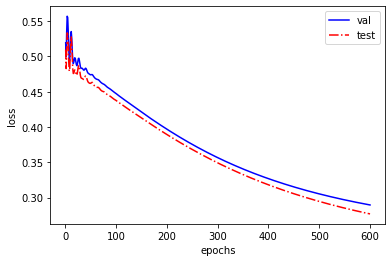

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4943157936, 4924204304]}]
Epoch: 0001 loss_train: 0.7226 acc_train: 0.2050 loss_val: 0.5124 acc_val: 0.8050 time: 0.0015s
Epoch: 0002 loss_train: 0.5217 acc_train: 0.7950 loss_val: 0.4842 acc_val: 0.8050 time: 0.0013s
Epoch: 0003 loss_train: 0.5013 acc_train: 0.7950 loss_val: 0.5193 acc_val: 0.8050 time: 0.0012s
Epoch: 0004 loss_train: 0.5415 acc_train: 0.7950 loss_val: 0.5480 acc_val: 0.8050 time: 0.0012s
Epoch: 0005 loss_train: 0.5727 acc_train: 0.7950 loss_val: 0.5543 acc_val: 0.8050 time: 0.0012s
Epoch: 0006 loss_train: 0.5795 acc_train: 0.7950 loss_val: 0.5415 acc_val: 0.8050 time: 0.0014s
Epoch: 0007 loss_train: 0.5655 acc_train: 0.7950 loss_val: 0.5180 ac

Epoch: 0112 loss_train: 0.4305 acc_train: 0.7950 loss_val: 0.4280 acc_val: 0.8050 time: 0.0013s
Epoch: 0113 loss_train: 0.4299 acc_train: 0.7950 loss_val: 0.4275 acc_val: 0.8050 time: 0.0015s
Epoch: 0114 loss_train: 0.4292 acc_train: 0.7950 loss_val: 0.4270 acc_val: 0.8050 time: 0.0019s
Epoch: 0115 loss_train: 0.4286 acc_train: 0.7950 loss_val: 0.4265 acc_val: 0.8050 time: 0.0019s
Epoch: 0116 loss_train: 0.4280 acc_train: 0.7950 loss_val: 0.4260 acc_val: 0.8050 time: 0.0013s
Epoch: 0117 loss_train: 0.4274 acc_train: 0.7950 loss_val: 0.4255 acc_val: 0.8050 time: 0.0013s
Epoch: 0118 loss_train: 0.4267 acc_train: 0.7950 loss_val: 0.4249 acc_val: 0.8050 time: 0.0012s
Epoch: 0119 loss_train: 0.4261 acc_train: 0.7950 loss_val: 0.4244 acc_val: 0.8050 time: 0.0013s
Epoch: 0120 loss_train: 0.4255 acc_train: 0.7950 loss_val: 0.4239 acc_val: 0.8050 time: 0.0013s
Epoch: 0121 loss_train: 0.4249 acc_train: 0.7950 loss_val: 0.4234 acc_val: 0.8050 time: 0.0038s
Epoch: 0122 loss_train: 0.4243 acc_train

Epoch: 0237 loss_train: 0.3641 acc_train: 0.8000 loss_val: 0.3721 acc_val: 0.8100 time: 0.0016s
Epoch: 0238 loss_train: 0.3637 acc_train: 0.8000 loss_val: 0.3717 acc_val: 0.8100 time: 0.0013s
Epoch: 0239 loss_train: 0.3632 acc_train: 0.8000 loss_val: 0.3713 acc_val: 0.8100 time: 0.0015s
Epoch: 0240 loss_train: 0.3628 acc_train: 0.8000 loss_val: 0.3709 acc_val: 0.8100 time: 0.0013s
Epoch: 0241 loss_train: 0.3624 acc_train: 0.8000 loss_val: 0.3705 acc_val: 0.8100 time: 0.0012s
Epoch: 0242 loss_train: 0.3620 acc_train: 0.8000 loss_val: 0.3702 acc_val: 0.8100 time: 0.0014s
Epoch: 0243 loss_train: 0.3615 acc_train: 0.8000 loss_val: 0.3698 acc_val: 0.8100 time: 0.0013s
Epoch: 0244 loss_train: 0.3611 acc_train: 0.8000 loss_val: 0.3694 acc_val: 0.8100 time: 0.0023s
Epoch: 0245 loss_train: 0.3607 acc_train: 0.8000 loss_val: 0.3690 acc_val: 0.8100 time: 0.0013s
Epoch: 0246 loss_train: 0.3603 acc_train: 0.8000 loss_val: 0.3687 acc_val: 0.8100 time: 0.0013s
Epoch: 0247 loss_train: 0.3598 acc_train

Epoch: 0363 loss_train: 0.3197 acc_train: 0.8250 loss_val: 0.3305 acc_val: 0.8450 time: 0.0021s
Epoch: 0364 loss_train: 0.3194 acc_train: 0.8250 loss_val: 0.3302 acc_val: 0.8450 time: 0.0014s
Epoch: 0365 loss_train: 0.3191 acc_train: 0.8250 loss_val: 0.3299 acc_val: 0.8450 time: 0.0015s
Epoch: 0366 loss_train: 0.3188 acc_train: 0.8250 loss_val: 0.3296 acc_val: 0.8450 time: 0.0015s
Epoch: 0367 loss_train: 0.3186 acc_train: 0.8250 loss_val: 0.3294 acc_val: 0.8450 time: 0.0013s
Epoch: 0368 loss_train: 0.3183 acc_train: 0.8250 loss_val: 0.3291 acc_val: 0.8450 time: 0.0012s
Epoch: 0369 loss_train: 0.3180 acc_train: 0.8250 loss_val: 0.3288 acc_val: 0.8450 time: 0.0036s
Epoch: 0370 loss_train: 0.3177 acc_train: 0.8250 loss_val: 0.3285 acc_val: 0.8450 time: 0.0013s
Epoch: 0371 loss_train: 0.3175 acc_train: 0.8250 loss_val: 0.3283 acc_val: 0.8450 time: 0.0013s
Epoch: 0372 loss_train: 0.3172 acc_train: 0.8250 loss_val: 0.3280 acc_val: 0.8450 time: 0.0013s
Epoch: 0373 loss_train: 0.3169 acc_train

Epoch: 0488 loss_train: 0.2914 acc_train: 0.8650 loss_val: 0.3007 acc_val: 0.8550 time: 0.0018s
Epoch: 0489 loss_train: 0.2912 acc_train: 0.8650 loss_val: 0.3005 acc_val: 0.8600 time: 0.0013s
Epoch: 0490 loss_train: 0.2910 acc_train: 0.8650 loss_val: 0.3003 acc_val: 0.8600 time: 0.0015s
Epoch: 0491 loss_train: 0.2908 acc_train: 0.8650 loss_val: 0.3001 acc_val: 0.8600 time: 0.0014s
Epoch: 0492 loss_train: 0.2906 acc_train: 0.8700 loss_val: 0.2999 acc_val: 0.8600 time: 0.0013s
Epoch: 0493 loss_train: 0.2905 acc_train: 0.8700 loss_val: 0.2997 acc_val: 0.8600 time: 0.0013s
Epoch: 0494 loss_train: 0.2903 acc_train: 0.8700 loss_val: 0.2995 acc_val: 0.8600 time: 0.0013s
Epoch: 0495 loss_train: 0.2901 acc_train: 0.8700 loss_val: 0.2993 acc_val: 0.8600 time: 0.0013s
Epoch: 0496 loss_train: 0.2899 acc_train: 0.8700 loss_val: 0.2991 acc_val: 0.8600 time: 0.0015s
Epoch: 0497 loss_train: 0.2897 acc_train: 0.8700 loss_val: 0.2989 acc_val: 0.8600 time: 0.0030s
Epoch: 0498 loss_train: 0.2896 acc_train

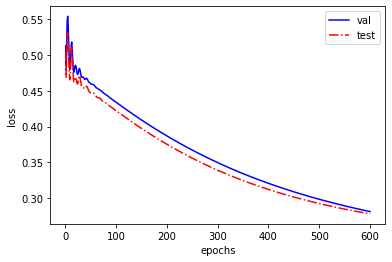

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4962419552, 4962419696]}]
Epoch: 0001 loss_train: 0.6338 acc_train: 0.8050 loss_val: 0.4782 acc_val: 0.8150 time: 0.0026s
Epoch: 0002 loss_train: 0.4892 acc_train: 0.8050 loss_val: 0.4785 acc_val: 0.8150 time: 0.0013s
Epoch: 0003 loss_train: 0.4962 acc_train: 0.8050 loss_val: 0.5106 acc_val: 0.8150 time: 0.0019s
Epoch: 0004 loss_train: 0.5322 acc_train: 0.8050 loss_val: 0.5245 acc_val: 0.8150 time: 0.0013s
Epoch: 0005 loss_train: 0.5473 acc_train: 0.8050 loss_val: 0.5167 acc_val: 0.8150 time: 0.0020s
Epoch: 0006 loss_train: 0.5389 acc_train: 0.8050 loss_val: 0.4966 acc_val: 0.8150 time: 0.0018s
Epoch: 0007 loss_train: 0.5167 acc_train: 0.8050 loss_val: 0.4758 ac

Epoch: 0109 loss_train: 0.4190 acc_train: 0.8050 loss_val: 0.4124 acc_val: 0.8150 time: 0.0016s
Epoch: 0110 loss_train: 0.4184 acc_train: 0.8050 loss_val: 0.4118 acc_val: 0.8150 time: 0.0014s
Epoch: 0111 loss_train: 0.4177 acc_train: 0.8050 loss_val: 0.4112 acc_val: 0.8150 time: 0.0014s
Epoch: 0112 loss_train: 0.4171 acc_train: 0.8050 loss_val: 0.4107 acc_val: 0.8150 time: 0.0015s
Epoch: 0113 loss_train: 0.4165 acc_train: 0.8050 loss_val: 0.4102 acc_val: 0.8150 time: 0.0013s
Epoch: 0114 loss_train: 0.4159 acc_train: 0.8050 loss_val: 0.4096 acc_val: 0.8150 time: 0.0013s
Epoch: 0115 loss_train: 0.4153 acc_train: 0.8050 loss_val: 0.4091 acc_val: 0.8150 time: 0.0013s
Epoch: 0116 loss_train: 0.4147 acc_train: 0.8050 loss_val: 0.4086 acc_val: 0.8150 time: 0.0025s
Epoch: 0117 loss_train: 0.4141 acc_train: 0.8050 loss_val: 0.4081 acc_val: 0.8150 time: 0.0013s
Epoch: 0118 loss_train: 0.4135 acc_train: 0.8050 loss_val: 0.4075 acc_val: 0.8150 time: 0.0013s
Epoch: 0119 loss_train: 0.4128 acc_train

Epoch: 0226 loss_train: 0.3558 acc_train: 0.8050 loss_val: 0.3564 acc_val: 0.8200 time: 0.0020s
Epoch: 0227 loss_train: 0.3554 acc_train: 0.8050 loss_val: 0.3560 acc_val: 0.8200 time: 0.0014s
Epoch: 0228 loss_train: 0.3549 acc_train: 0.8050 loss_val: 0.3556 acc_val: 0.8200 time: 0.0014s
Epoch: 0229 loss_train: 0.3544 acc_train: 0.8050 loss_val: 0.3552 acc_val: 0.8200 time: 0.0015s
Epoch: 0230 loss_train: 0.3540 acc_train: 0.8050 loss_val: 0.3548 acc_val: 0.8200 time: 0.0013s
Epoch: 0231 loss_train: 0.3535 acc_train: 0.8050 loss_val: 0.3544 acc_val: 0.8200 time: 0.0013s
Epoch: 0232 loss_train: 0.3531 acc_train: 0.8050 loss_val: 0.3540 acc_val: 0.8200 time: 0.0034s
Epoch: 0233 loss_train: 0.3526 acc_train: 0.8050 loss_val: 0.3536 acc_val: 0.8200 time: 0.0013s
Epoch: 0234 loss_train: 0.3522 acc_train: 0.8050 loss_val: 0.3532 acc_val: 0.8200 time: 0.0014s
Epoch: 0235 loss_train: 0.3517 acc_train: 0.8050 loss_val: 0.3528 acc_val: 0.8200 time: 0.0013s
Epoch: 0236 loss_train: 0.3513 acc_train

Epoch: 0341 loss_train: 0.3112 acc_train: 0.8500 loss_val: 0.3177 acc_val: 0.8450 time: 0.0016s
Epoch: 0342 loss_train: 0.3109 acc_train: 0.8500 loss_val: 0.3174 acc_val: 0.8450 time: 0.0024s
Epoch: 0343 loss_train: 0.3105 acc_train: 0.8500 loss_val: 0.3171 acc_val: 0.8450 time: 0.0018s
Epoch: 0344 loss_train: 0.3102 acc_train: 0.8500 loss_val: 0.3168 acc_val: 0.8450 time: 0.0014s
Epoch: 0345 loss_train: 0.3099 acc_train: 0.8500 loss_val: 0.3166 acc_val: 0.8500 time: 0.0016s
Epoch: 0346 loss_train: 0.3096 acc_train: 0.8500 loss_val: 0.3163 acc_val: 0.8500 time: 0.0013s
Epoch: 0347 loss_train: 0.3093 acc_train: 0.8500 loss_val: 0.3160 acc_val: 0.8500 time: 0.0013s
Epoch: 0348 loss_train: 0.3089 acc_train: 0.8500 loss_val: 0.3158 acc_val: 0.8500 time: 0.0013s
Epoch: 0349 loss_train: 0.3086 acc_train: 0.8500 loss_val: 0.3155 acc_val: 0.8500 time: 0.0014s
Epoch: 0350 loss_train: 0.3083 acc_train: 0.8500 loss_val: 0.3152 acc_val: 0.8500 time: 0.0013s
Epoch: 0351 loss_train: 0.3080 acc_train

Epoch: 0451 loss_train: 0.2811 acc_train: 0.8800 loss_val: 0.2925 acc_val: 0.8750 time: 0.0023s
Epoch: 0452 loss_train: 0.2809 acc_train: 0.8800 loss_val: 0.2923 acc_val: 0.8750 time: 0.0024s
Epoch: 0453 loss_train: 0.2806 acc_train: 0.8800 loss_val: 0.2921 acc_val: 0.8750 time: 0.0022s
Epoch: 0454 loss_train: 0.2804 acc_train: 0.8800 loss_val: 0.2919 acc_val: 0.8750 time: 0.0033s
Epoch: 0455 loss_train: 0.2802 acc_train: 0.8800 loss_val: 0.2918 acc_val: 0.8750 time: 0.0017s
Epoch: 0456 loss_train: 0.2799 acc_train: 0.8800 loss_val: 0.2916 acc_val: 0.8750 time: 0.0016s
Epoch: 0457 loss_train: 0.2797 acc_train: 0.8800 loss_val: 0.2914 acc_val: 0.8750 time: 0.0048s
Epoch: 0458 loss_train: 0.2795 acc_train: 0.8800 loss_val: 0.2912 acc_val: 0.8750 time: 0.0016s
Epoch: 0459 loss_train: 0.2793 acc_train: 0.8800 loss_val: 0.2910 acc_val: 0.8750 time: 0.0026s
Epoch: 0460 loss_train: 0.2791 acc_train: 0.8800 loss_val: 0.2908 acc_val: 0.8750 time: 0.0030s
Epoch: 0461 loss_train: 0.2788 acc_train

Epoch: 0557 loss_train: 0.2606 acc_train: 0.9050 loss_val: 0.2758 acc_val: 0.8900 time: 0.0019s
Epoch: 0558 loss_train: 0.2604 acc_train: 0.9050 loss_val: 0.2757 acc_val: 0.8900 time: 0.0014s
Epoch: 0559 loss_train: 0.2602 acc_train: 0.9050 loss_val: 0.2755 acc_val: 0.8900 time: 0.0019s
Epoch: 0560 loss_train: 0.2601 acc_train: 0.9050 loss_val: 0.2754 acc_val: 0.8900 time: 0.0015s
Epoch: 0561 loss_train: 0.2599 acc_train: 0.9050 loss_val: 0.2753 acc_val: 0.8900 time: 0.0013s
Epoch: 0562 loss_train: 0.2598 acc_train: 0.9050 loss_val: 0.2751 acc_val: 0.8900 time: 0.0013s
Epoch: 0563 loss_train: 0.2596 acc_train: 0.9100 loss_val: 0.2750 acc_val: 0.8900 time: 0.0027s
Epoch: 0564 loss_train: 0.2594 acc_train: 0.9100 loss_val: 0.2749 acc_val: 0.8900 time: 0.0014s
Epoch: 0565 loss_train: 0.2593 acc_train: 0.9100 loss_val: 0.2748 acc_val: 0.8900 time: 0.0015s
Epoch: 0566 loss_train: 0.2591 acc_train: 0.9100 loss_val: 0.2746 acc_val: 0.8900 time: 0.0014s
Epoch: 0567 loss_train: 0.2590 acc_train

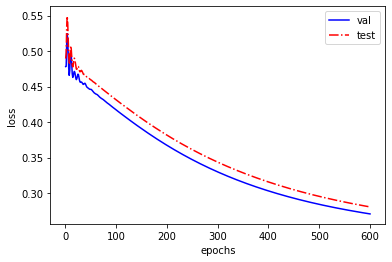

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4963427816, 4968062624]}]
Epoch: 0001 loss_train: 0.6639 acc_train: 0.8150 loss_val: 0.4953 acc_val: 0.8050 time: 0.0027s
Epoch: 0002 loss_train: 0.4851 acc_train: 0.8150 loss_val: 0.4917 acc_val: 0.8050 time: 0.0014s
Epoch: 0003 loss_train: 0.4736 acc_train: 0.8150 loss_val: 0.5343 acc_val: 0.8050 time: 0.0014s
Epoch: 0004 loss_train: 0.5108 acc_train: 0.8150 loss_val: 0.5632 acc_val: 0.8050 time: 0.0016s
Epoch: 0005 loss_train: 0.5372 acc_train: 0.8150 loss_val: 0.5676 acc_val: 0.8050 time: 0.0016s
Epoch: 0006 loss_train: 0.5412 acc_train: 0.8150 loss_val: 0.5523 acc_val: 0.8050 time: 0.0013s
Epoch: 0007 loss_train: 0.5271 acc_train: 0.8150 loss_val: 0.5261 ac

Epoch: 0108 loss_train: 0.4141 acc_train: 0.8150 loss_val: 0.4313 acc_val: 0.8050 time: 0.0019s
Epoch: 0109 loss_train: 0.4135 acc_train: 0.8150 loss_val: 0.4308 acc_val: 0.8050 time: 0.0015s
Epoch: 0110 loss_train: 0.4130 acc_train: 0.8150 loss_val: 0.4302 acc_val: 0.8050 time: 0.0017s
Epoch: 0111 loss_train: 0.4125 acc_train: 0.8150 loss_val: 0.4297 acc_val: 0.8050 time: 0.0019s
Epoch: 0112 loss_train: 0.4119 acc_train: 0.8150 loss_val: 0.4292 acc_val: 0.8050 time: 0.0019s
Epoch: 0113 loss_train: 0.4114 acc_train: 0.8150 loss_val: 0.4286 acc_val: 0.8050 time: 0.0014s
Epoch: 0114 loss_train: 0.4109 acc_train: 0.8150 loss_val: 0.4281 acc_val: 0.8050 time: 0.0014s
Epoch: 0115 loss_train: 0.4103 acc_train: 0.8150 loss_val: 0.4276 acc_val: 0.8050 time: 0.0014s
Epoch: 0116 loss_train: 0.4098 acc_train: 0.8150 loss_val: 0.4272 acc_val: 0.8050 time: 0.0015s
Epoch: 0117 loss_train: 0.4092 acc_train: 0.8150 loss_val: 0.4267 acc_val: 0.8050 time: 0.0014s
Epoch: 0118 loss_train: 0.4087 acc_train

Epoch: 0226 loss_train: 0.3573 acc_train: 0.8150 loss_val: 0.3777 acc_val: 0.8050 time: 0.0019s
Epoch: 0227 loss_train: 0.3569 acc_train: 0.8150 loss_val: 0.3773 acc_val: 0.8050 time: 0.0016s
Epoch: 0228 loss_train: 0.3565 acc_train: 0.8150 loss_val: 0.3769 acc_val: 0.8050 time: 0.0017s
Epoch: 0229 loss_train: 0.3561 acc_train: 0.8150 loss_val: 0.3765 acc_val: 0.8050 time: 0.0018s
Epoch: 0230 loss_train: 0.3557 acc_train: 0.8150 loss_val: 0.3761 acc_val: 0.8050 time: 0.0014s
Epoch: 0231 loss_train: 0.3553 acc_train: 0.8150 loss_val: 0.3757 acc_val: 0.8050 time: 0.0014s
Epoch: 0232 loss_train: 0.3549 acc_train: 0.8150 loss_val: 0.3753 acc_val: 0.8050 time: 0.0014s
Epoch: 0233 loss_train: 0.3545 acc_train: 0.8150 loss_val: 0.3749 acc_val: 0.8050 time: 0.0027s
Epoch: 0234 loss_train: 0.3541 acc_train: 0.8150 loss_val: 0.3745 acc_val: 0.8050 time: 0.0014s
Epoch: 0235 loss_train: 0.3537 acc_train: 0.8150 loss_val: 0.3741 acc_val: 0.8050 time: 0.0014s
Epoch: 0236 loss_train: 0.3533 acc_train

Epoch: 0346 loss_train: 0.3159 acc_train: 0.8300 loss_val: 0.3375 acc_val: 0.8250 time: 0.0015s
Epoch: 0347 loss_train: 0.3157 acc_train: 0.8300 loss_val: 0.3372 acc_val: 0.8250 time: 0.0014s
Epoch: 0348 loss_train: 0.3154 acc_train: 0.8300 loss_val: 0.3370 acc_val: 0.8250 time: 0.0015s
Epoch: 0349 loss_train: 0.3151 acc_train: 0.8300 loss_val: 0.3367 acc_val: 0.8250 time: 0.0015s
Epoch: 0350 loss_train: 0.3148 acc_train: 0.8300 loss_val: 0.3364 acc_val: 0.8250 time: 0.0013s
Epoch: 0351 loss_train: 0.3145 acc_train: 0.8300 loss_val: 0.3361 acc_val: 0.8250 time: 0.0014s
Epoch: 0352 loss_train: 0.3143 acc_train: 0.8300 loss_val: 0.3359 acc_val: 0.8250 time: 0.0019s
Epoch: 0353 loss_train: 0.3140 acc_train: 0.8300 loss_val: 0.3356 acc_val: 0.8250 time: 0.0016s
Epoch: 0354 loss_train: 0.3137 acc_train: 0.8300 loss_val: 0.3353 acc_val: 0.8250 time: 0.0014s
Epoch: 0355 loss_train: 0.3134 acc_train: 0.8350 loss_val: 0.3351 acc_val: 0.8250 time: 0.0014s
Epoch: 0356 loss_train: 0.3132 acc_train

Epoch: 0466 loss_train: 0.2881 acc_train: 0.8650 loss_val: 0.3097 acc_val: 0.8300 time: 0.0018s
Epoch: 0467 loss_train: 0.2879 acc_train: 0.8650 loss_val: 0.3095 acc_val: 0.8300 time: 0.0015s
Epoch: 0468 loss_train: 0.2877 acc_train: 0.8650 loss_val: 0.3093 acc_val: 0.8300 time: 0.0023s
Epoch: 0469 loss_train: 0.2875 acc_train: 0.8650 loss_val: 0.3091 acc_val: 0.8300 time: 0.0014s
Epoch: 0470 loss_train: 0.2873 acc_train: 0.8650 loss_val: 0.3089 acc_val: 0.8300 time: 0.0014s
Epoch: 0471 loss_train: 0.2872 acc_train: 0.8650 loss_val: 0.3087 acc_val: 0.8300 time: 0.0014s
Epoch: 0472 loss_train: 0.2870 acc_train: 0.8650 loss_val: 0.3086 acc_val: 0.8300 time: 0.0034s
Epoch: 0473 loss_train: 0.2868 acc_train: 0.8650 loss_val: 0.3084 acc_val: 0.8300 time: 0.0013s
Epoch: 0474 loss_train: 0.2866 acc_train: 0.8650 loss_val: 0.3082 acc_val: 0.8300 time: 0.0016s
Epoch: 0475 loss_train: 0.2864 acc_train: 0.8650 loss_val: 0.3080 acc_val: 0.8300 time: 0.0013s
Epoch: 0476 loss_train: 0.2862 acc_train

Epoch: 0587 loss_train: 0.2692 acc_train: 0.8850 loss_val: 0.2903 acc_val: 0.8450 time: 0.0017s
Epoch: 0588 loss_train: 0.2691 acc_train: 0.8900 loss_val: 0.2901 acc_val: 0.8450 time: 0.0017s
Epoch: 0589 loss_train: 0.2690 acc_train: 0.8900 loss_val: 0.2900 acc_val: 0.8450 time: 0.0021s
Epoch: 0590 loss_train: 0.2688 acc_train: 0.8900 loss_val: 0.2899 acc_val: 0.8450 time: 0.0013s
Epoch: 0591 loss_train: 0.2687 acc_train: 0.8900 loss_val: 0.2897 acc_val: 0.8450 time: 0.0014s
Epoch: 0592 loss_train: 0.2686 acc_train: 0.8900 loss_val: 0.2896 acc_val: 0.8500 time: 0.0018s
Epoch: 0593 loss_train: 0.2685 acc_train: 0.8900 loss_val: 0.2895 acc_val: 0.8500 time: 0.0014s
Epoch: 0594 loss_train: 0.2683 acc_train: 0.8900 loss_val: 0.2893 acc_val: 0.8500 time: 0.0014s
Epoch: 0595 loss_train: 0.2682 acc_train: 0.8900 loss_val: 0.2892 acc_val: 0.8500 time: 0.0013s
Epoch: 0596 loss_train: 0.2681 acc_train: 0.8900 loss_val: 0.2891 acc_val: 0.8500 time: 0.0017s
Epoch: 0597 loss_train: 0.2680 acc_train

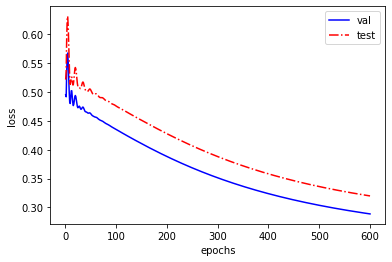

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4963350136, 4923306200]}]
Epoch: 0001 loss_train: 0.7230 acc_train: 0.1950 loss_val: 0.5336 acc_val: 0.7800 time: 0.0026s
Epoch: 0002 loss_train: 0.5117 acc_train: 0.8050 loss_val: 0.5257 acc_val: 0.7800 time: 0.0014s
Epoch: 0003 loss_train: 0.4844 acc_train: 0.8050 loss_val: 0.5772 acc_val: 0.7800 time: 0.0014s
Epoch: 0004 loss_train: 0.5227 acc_train: 0.8050 loss_val: 0.6182 acc_val: 0.7800 time: 0.0013s
Epoch: 0005 loss_train: 0.5565 acc_train: 0.8050 loss_val: 0.6317 acc_val: 0.7800 time: 0.0015s
Epoch: 0006 loss_train: 0.5678 acc_train: 0.8050 loss_val: 0.6207 acc_val: 0.7800 time: 0.0013s
Epoch: 0007 loss_train: 0.5584 acc_train: 0.8050 loss_val: 0.5934 ac

Epoch: 0114 loss_train: 0.4271 acc_train: 0.8050 loss_val: 0.4685 acc_val: 0.7800 time: 0.0018s
Epoch: 0115 loss_train: 0.4266 acc_train: 0.8050 loss_val: 0.4680 acc_val: 0.7800 time: 0.0015s
Epoch: 0116 loss_train: 0.4261 acc_train: 0.8050 loss_val: 0.4675 acc_val: 0.7800 time: 0.0016s
Epoch: 0117 loss_train: 0.4256 acc_train: 0.8050 loss_val: 0.4670 acc_val: 0.7800 time: 0.0014s
Epoch: 0118 loss_train: 0.4250 acc_train: 0.8050 loss_val: 0.4665 acc_val: 0.7800 time: 0.0032s
Epoch: 0119 loss_train: 0.4245 acc_train: 0.8050 loss_val: 0.4661 acc_val: 0.7800 time: 0.0014s
Epoch: 0120 loss_train: 0.4240 acc_train: 0.8050 loss_val: 0.4656 acc_val: 0.7800 time: 0.0014s
Epoch: 0121 loss_train: 0.4235 acc_train: 0.8050 loss_val: 0.4652 acc_val: 0.7800 time: 0.0014s
Epoch: 0122 loss_train: 0.4230 acc_train: 0.8050 loss_val: 0.4647 acc_val: 0.7800 time: 0.0014s
Epoch: 0123 loss_train: 0.4224 acc_train: 0.8050 loss_val: 0.4642 acc_val: 0.7800 time: 0.0015s
Epoch: 0124 loss_train: 0.4219 acc_train

Epoch: 0234 loss_train: 0.3707 acc_train: 0.8050 loss_val: 0.4143 acc_val: 0.7800 time: 0.0016s
Epoch: 0235 loss_train: 0.3703 acc_train: 0.8050 loss_val: 0.4139 acc_val: 0.7800 time: 0.0015s
Epoch: 0236 loss_train: 0.3698 acc_train: 0.8050 loss_val: 0.4135 acc_val: 0.7800 time: 0.0022s
Epoch: 0237 loss_train: 0.3694 acc_train: 0.8050 loss_val: 0.4131 acc_val: 0.7800 time: 0.0015s
Epoch: 0238 loss_train: 0.3690 acc_train: 0.8050 loss_val: 0.4127 acc_val: 0.7800 time: 0.0014s
Epoch: 0239 loss_train: 0.3686 acc_train: 0.8050 loss_val: 0.4123 acc_val: 0.7800 time: 0.0014s
Epoch: 0240 loss_train: 0.3682 acc_train: 0.8050 loss_val: 0.4119 acc_val: 0.7800 time: 0.0014s
Epoch: 0241 loss_train: 0.3678 acc_train: 0.8050 loss_val: 0.4115 acc_val: 0.7800 time: 0.0024s
Epoch: 0242 loss_train: 0.3674 acc_train: 0.8050 loss_val: 0.4110 acc_val: 0.7800 time: 0.0015s
Epoch: 0243 loss_train: 0.3670 acc_train: 0.8050 loss_val: 0.4106 acc_val: 0.7800 time: 0.0014s
Epoch: 0244 loss_train: 0.3666 acc_train

Epoch: 0355 loss_train: 0.3279 acc_train: 0.8250 loss_val: 0.3712 acc_val: 0.8100 time: 0.0016s
Epoch: 0356 loss_train: 0.3276 acc_train: 0.8250 loss_val: 0.3709 acc_val: 0.8100 time: 0.0017s
Epoch: 0357 loss_train: 0.3273 acc_train: 0.8250 loss_val: 0.3706 acc_val: 0.8100 time: 0.0021s
Epoch: 0358 loss_train: 0.3270 acc_train: 0.8250 loss_val: 0.3703 acc_val: 0.8100 time: 0.0014s
Epoch: 0359 loss_train: 0.3267 acc_train: 0.8250 loss_val: 0.3700 acc_val: 0.8100 time: 0.0030s
Epoch: 0360 loss_train: 0.3264 acc_train: 0.8250 loss_val: 0.3697 acc_val: 0.8150 time: 0.0014s
Epoch: 0361 loss_train: 0.3262 acc_train: 0.8250 loss_val: 0.3694 acc_val: 0.8150 time: 0.0015s
Epoch: 0362 loss_train: 0.3259 acc_train: 0.8250 loss_val: 0.3691 acc_val: 0.8150 time: 0.0015s
Epoch: 0363 loss_train: 0.3256 acc_train: 0.8250 loss_val: 0.3688 acc_val: 0.8150 time: 0.0015s
Epoch: 0364 loss_train: 0.3253 acc_train: 0.8250 loss_val: 0.3685 acc_val: 0.8150 time: 0.0015s
Epoch: 0365 loss_train: 0.3250 acc_train

Epoch: 0470 loss_train: 0.2992 acc_train: 0.8400 loss_val: 0.3414 acc_val: 0.8350 time: 0.0021s
Epoch: 0471 loss_train: 0.2990 acc_train: 0.8400 loss_val: 0.3412 acc_val: 0.8350 time: 0.0017s
Epoch: 0472 loss_train: 0.2988 acc_train: 0.8450 loss_val: 0.3410 acc_val: 0.8350 time: 0.0016s
Epoch: 0473 loss_train: 0.2986 acc_train: 0.8450 loss_val: 0.3407 acc_val: 0.8350 time: 0.0016s
Epoch: 0474 loss_train: 0.2984 acc_train: 0.8450 loss_val: 0.3405 acc_val: 0.8400 time: 0.0015s
Epoch: 0475 loss_train: 0.2982 acc_train: 0.8450 loss_val: 0.3403 acc_val: 0.8400 time: 0.0014s
Epoch: 0476 loss_train: 0.2980 acc_train: 0.8450 loss_val: 0.3401 acc_val: 0.8400 time: 0.0014s
Epoch: 0477 loss_train: 0.2978 acc_train: 0.8450 loss_val: 0.3399 acc_val: 0.8400 time: 0.0028s
Epoch: 0478 loss_train: 0.2976 acc_train: 0.8450 loss_val: 0.3397 acc_val: 0.8400 time: 0.0014s
Epoch: 0479 loss_train: 0.2974 acc_train: 0.8450 loss_val: 0.3394 acc_val: 0.8400 time: 0.0014s
Epoch: 0480 loss_train: 0.2972 acc_train

Epoch: 0583 loss_train: 0.2793 acc_train: 0.8650 loss_val: 0.3202 acc_val: 0.8750 time: 0.0019s
Epoch: 0584 loss_train: 0.2791 acc_train: 0.8650 loss_val: 0.3201 acc_val: 0.8750 time: 0.0015s
Epoch: 0585 loss_train: 0.2790 acc_train: 0.8650 loss_val: 0.3199 acc_val: 0.8750 time: 0.0015s
Epoch: 0586 loss_train: 0.2788 acc_train: 0.8650 loss_val: 0.3198 acc_val: 0.8750 time: 0.0016s
Epoch: 0587 loss_train: 0.2787 acc_train: 0.8650 loss_val: 0.3196 acc_val: 0.8750 time: 0.0014s
Epoch: 0588 loss_train: 0.2786 acc_train: 0.8650 loss_val: 0.3195 acc_val: 0.8750 time: 0.0016s
Epoch: 0589 loss_train: 0.2784 acc_train: 0.8650 loss_val: 0.3193 acc_val: 0.8750 time: 0.0016s
Epoch: 0590 loss_train: 0.2783 acc_train: 0.8650 loss_val: 0.3191 acc_val: 0.8750 time: 0.0014s
Epoch: 0591 loss_train: 0.2781 acc_train: 0.8650 loss_val: 0.3190 acc_val: 0.8750 time: 0.0017s
Epoch: 0592 loss_train: 0.2780 acc_train: 0.8650 loss_val: 0.3188 acc_val: 0.8750 time: 0.0015s
Epoch: 0593 loss_train: 0.2778 acc_train

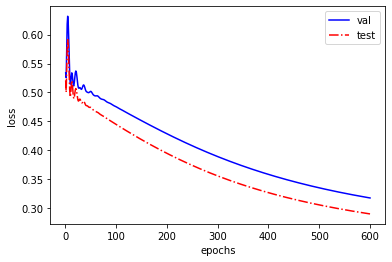

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4948893344, 4925266032]}]
Epoch: 0001 loss_train: 0.6605 acc_train: 0.7800 loss_val: 0.5055 acc_val: 0.7950 time: 0.0027s
Epoch: 0002 loss_train: 0.5217 acc_train: 0.7800 loss_val: 0.5089 acc_val: 0.7950 time: 0.0016s
Epoch: 0003 loss_train: 0.5363 acc_train: 0.7800 loss_val: 0.5395 acc_val: 0.7950 time: 0.0019s
Epoch: 0004 loss_train: 0.5728 acc_train: 0.7800 loss_val: 0.5475 acc_val: 0.7950 time: 0.0019s
Epoch: 0005 loss_train: 0.5820 acc_train: 0.7800 loss_val: 0.5339 acc_val: 0.7950 time: 0.0014s
Epoch: 0006 loss_train: 0.5664 acc_train: 0.7800 loss_val: 0.5119 acc_val: 0.7950 time: 0.0022s
Epoch: 0007 loss_train: 0.5404 acc_train: 0.7800 loss_val: 0.4963 ac

Epoch: 0104 loss_train: 0.4634 acc_train: 0.7800 loss_val: 0.4411 acc_val: 0.7950 time: 0.0020s
Epoch: 0105 loss_train: 0.4628 acc_train: 0.7800 loss_val: 0.4405 acc_val: 0.7950 time: 0.0020s
Epoch: 0106 loss_train: 0.4622 acc_train: 0.7800 loss_val: 0.4399 acc_val: 0.7950 time: 0.0016s
Epoch: 0107 loss_train: 0.4616 acc_train: 0.7800 loss_val: 0.4392 acc_val: 0.7950 time: 0.0015s
Epoch: 0108 loss_train: 0.4610 acc_train: 0.7800 loss_val: 0.4386 acc_val: 0.7950 time: 0.0042s
Epoch: 0109 loss_train: 0.4604 acc_train: 0.7800 loss_val: 0.4381 acc_val: 0.7950 time: 0.0015s
Epoch: 0110 loss_train: 0.4598 acc_train: 0.7800 loss_val: 0.4375 acc_val: 0.7950 time: 0.0016s
Epoch: 0111 loss_train: 0.4592 acc_train: 0.7800 loss_val: 0.4369 acc_val: 0.7950 time: 0.0015s
Epoch: 0112 loss_train: 0.4586 acc_train: 0.7800 loss_val: 0.4364 acc_val: 0.7950 time: 0.0019s
Epoch: 0113 loss_train: 0.4580 acc_train: 0.7800 loss_val: 0.4358 acc_val: 0.7950 time: 0.0015s
Epoch: 0114 loss_train: 0.4574 acc_train

Epoch: 0221 loss_train: 0.3990 acc_train: 0.7900 loss_val: 0.3791 acc_val: 0.7950 time: 0.0019s
Epoch: 0222 loss_train: 0.3985 acc_train: 0.7900 loss_val: 0.3787 acc_val: 0.7950 time: 0.0017s
Epoch: 0223 loss_train: 0.3981 acc_train: 0.7900 loss_val: 0.3782 acc_val: 0.7950 time: 0.0020s
Epoch: 0224 loss_train: 0.3976 acc_train: 0.7900 loss_val: 0.3778 acc_val: 0.7950 time: 0.0015s
Epoch: 0225 loss_train: 0.3971 acc_train: 0.7900 loss_val: 0.3773 acc_val: 0.7950 time: 0.0015s
Epoch: 0226 loss_train: 0.3966 acc_train: 0.7900 loss_val: 0.3769 acc_val: 0.7950 time: 0.0016s
Epoch: 0227 loss_train: 0.3962 acc_train: 0.7900 loss_val: 0.3764 acc_val: 0.7950 time: 0.0015s
Epoch: 0228 loss_train: 0.3957 acc_train: 0.7900 loss_val: 0.3760 acc_val: 0.7950 time: 0.0024s
Epoch: 0229 loss_train: 0.3952 acc_train: 0.7900 loss_val: 0.3756 acc_val: 0.7950 time: 0.0015s
Epoch: 0230 loss_train: 0.3947 acc_train: 0.7900 loss_val: 0.3751 acc_val: 0.7950 time: 0.0015s
Epoch: 0231 loss_train: 0.3943 acc_train

Epoch: 0338 loss_train: 0.3514 acc_train: 0.8150 loss_val: 0.3350 acc_val: 0.8250 time: 0.0025s
Epoch: 0339 loss_train: 0.3511 acc_train: 0.8150 loss_val: 0.3347 acc_val: 0.8250 time: 0.0025s
Epoch: 0340 loss_train: 0.3508 acc_train: 0.8150 loss_val: 0.3344 acc_val: 0.8250 time: 0.0026s
Epoch: 0341 loss_train: 0.3505 acc_train: 0.8150 loss_val: 0.3341 acc_val: 0.8250 time: 0.0015s
Epoch: 0342 loss_train: 0.3501 acc_train: 0.8150 loss_val: 0.3338 acc_val: 0.8250 time: 0.0016s
Epoch: 0343 loss_train: 0.3498 acc_train: 0.8200 loss_val: 0.3335 acc_val: 0.8250 time: 0.0026s
Epoch: 0344 loss_train: 0.3495 acc_train: 0.8200 loss_val: 0.3332 acc_val: 0.8250 time: 0.0015s
Epoch: 0345 loss_train: 0.3491 acc_train: 0.8200 loss_val: 0.3329 acc_val: 0.8250 time: 0.0015s
Epoch: 0346 loss_train: 0.3488 acc_train: 0.8200 loss_val: 0.3326 acc_val: 0.8250 time: 0.0016s
Epoch: 0347 loss_train: 0.3485 acc_train: 0.8200 loss_val: 0.3323 acc_val: 0.8250 time: 0.0015s
Epoch: 0348 loss_train: 0.3482 acc_train

Epoch: 0455 loss_train: 0.3194 acc_train: 0.8600 loss_val: 0.3058 acc_val: 0.8500 time: 0.0021s
Epoch: 0456 loss_train: 0.3192 acc_train: 0.8600 loss_val: 0.3056 acc_val: 0.8500 time: 0.0020s
Epoch: 0457 loss_train: 0.3189 acc_train: 0.8600 loss_val: 0.3054 acc_val: 0.8500 time: 0.0017s
Epoch: 0458 loss_train: 0.3187 acc_train: 0.8600 loss_val: 0.3052 acc_val: 0.8500 time: 0.0019s
Epoch: 0459 loss_train: 0.3185 acc_train: 0.8600 loss_val: 0.3050 acc_val: 0.8500 time: 0.0015s
Epoch: 0460 loss_train: 0.3183 acc_train: 0.8600 loss_val: 0.3048 acc_val: 0.8500 time: 0.0015s
Epoch: 0461 loss_train: 0.3181 acc_train: 0.8600 loss_val: 0.3046 acc_val: 0.8500 time: 0.0015s
Epoch: 0462 loss_train: 0.3178 acc_train: 0.8600 loss_val: 0.3044 acc_val: 0.8500 time: 0.0015s
Epoch: 0463 loss_train: 0.3176 acc_train: 0.8600 loss_val: 0.3042 acc_val: 0.8500 time: 0.0034s
Epoch: 0464 loss_train: 0.3174 acc_train: 0.8600 loss_val: 0.3040 acc_val: 0.8500 time: 0.0015s
Epoch: 0465 loss_train: 0.3172 acc_train

Epoch: 0574 loss_train: 0.2978 acc_train: 0.8800 loss_val: 0.2861 acc_val: 0.8750 time: 0.0017s
Epoch: 0575 loss_train: 0.2976 acc_train: 0.8800 loss_val: 0.2860 acc_val: 0.8750 time: 0.0015s
Epoch: 0576 loss_train: 0.2975 acc_train: 0.8800 loss_val: 0.2859 acc_val: 0.8750 time: 0.0022s
Epoch: 0577 loss_train: 0.2973 acc_train: 0.8800 loss_val: 0.2857 acc_val: 0.8750 time: 0.0015s
Epoch: 0578 loss_train: 0.2972 acc_train: 0.8800 loss_val: 0.2856 acc_val: 0.8750 time: 0.0014s
Epoch: 0579 loss_train: 0.2970 acc_train: 0.8800 loss_val: 0.2855 acc_val: 0.8750 time: 0.0014s
Epoch: 0580 loss_train: 0.2969 acc_train: 0.8800 loss_val: 0.2853 acc_val: 0.8750 time: 0.0014s
Epoch: 0581 loss_train: 0.2967 acc_train: 0.8800 loss_val: 0.2852 acc_val: 0.8750 time: 0.0015s
Epoch: 0582 loss_train: 0.2966 acc_train: 0.8800 loss_val: 0.2851 acc_val: 0.8750 time: 0.0019s
Epoch: 0583 loss_train: 0.2965 acc_train: 0.8800 loss_val: 0.2849 acc_val: 0.8750 time: 0.0015s
Epoch: 0584 loss_train: 0.2963 acc_train

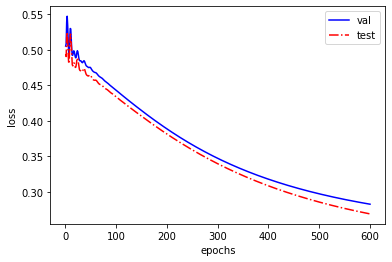

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4925166072, 4925166144]}]
Epoch: 0001 loss_train: 0.7939 acc_train: 0.2050 loss_val: 0.5378 acc_val: 0.8050 time: 0.0032s
Epoch: 0002 loss_train: 0.5451 acc_train: 0.7950 loss_val: 0.4790 acc_val: 0.8050 time: 0.0022s
Epoch: 0003 loss_train: 0.4945 acc_train: 0.7950 loss_val: 0.5089 acc_val: 0.8050 time: 0.0016s
Epoch: 0004 loss_train: 0.5301 acc_train: 0.7950 loss_val: 0.5466 acc_val: 0.8050 time: 0.0021s
Epoch: 0005 loss_train: 0.5712 acc_train: 0.7950 loss_val: 0.5658 acc_val: 0.8050 time: 0.0021s
Epoch: 0006 loss_train: 0.5918 acc_train: 0.7950 loss_val: 0.5641 acc_val: 0.8050 time: 0.0019s
Epoch: 0007 loss_train: 0.5900 acc_train: 0.7950 loss_val: 0.5465 ac

Epoch: 0115 loss_train: 0.4327 acc_train: 0.7950 loss_val: 0.4296 acc_val: 0.8050 time: 0.0018s
Epoch: 0116 loss_train: 0.4321 acc_train: 0.7950 loss_val: 0.4291 acc_val: 0.8050 time: 0.0013s
Epoch: 0117 loss_train: 0.4315 acc_train: 0.7950 loss_val: 0.4286 acc_val: 0.8050 time: 0.0015s
Epoch: 0118 loss_train: 0.4309 acc_train: 0.7950 loss_val: 0.4282 acc_val: 0.8050 time: 0.0018s
Epoch: 0119 loss_train: 0.4304 acc_train: 0.7950 loss_val: 0.4277 acc_val: 0.8050 time: 0.0013s
Epoch: 0120 loss_train: 0.4298 acc_train: 0.7950 loss_val: 0.4273 acc_val: 0.8050 time: 0.0013s
Epoch: 0121 loss_train: 0.4292 acc_train: 0.7950 loss_val: 0.4268 acc_val: 0.8050 time: 0.0013s
Epoch: 0122 loss_train: 0.4287 acc_train: 0.7950 loss_val: 0.4263 acc_val: 0.8050 time: 0.0027s
Epoch: 0123 loss_train: 0.4281 acc_train: 0.7950 loss_val: 0.4259 acc_val: 0.8050 time: 0.0013s
Epoch: 0124 loss_train: 0.4275 acc_train: 0.7950 loss_val: 0.4254 acc_val: 0.8050 time: 0.0014s
Epoch: 0125 loss_train: 0.4269 acc_train

Epoch: 0237 loss_train: 0.3715 acc_train: 0.7950 loss_val: 0.3785 acc_val: 0.8100 time: 0.0019s
Epoch: 0238 loss_train: 0.3710 acc_train: 0.7950 loss_val: 0.3781 acc_val: 0.8100 time: 0.0013s
Epoch: 0239 loss_train: 0.3706 acc_train: 0.7950 loss_val: 0.3777 acc_val: 0.8100 time: 0.0015s
Epoch: 0240 loss_train: 0.3702 acc_train: 0.7950 loss_val: 0.3774 acc_val: 0.8100 time: 0.0020s
Epoch: 0241 loss_train: 0.3698 acc_train: 0.7950 loss_val: 0.3770 acc_val: 0.8100 time: 0.0012s
Epoch: 0242 loss_train: 0.3694 acc_train: 0.7950 loss_val: 0.3767 acc_val: 0.8100 time: 0.0023s
Epoch: 0243 loss_train: 0.3690 acc_train: 0.7950 loss_val: 0.3763 acc_val: 0.8100 time: 0.0013s
Epoch: 0244 loss_train: 0.3685 acc_train: 0.7950 loss_val: 0.3759 acc_val: 0.8100 time: 0.0021s
Epoch: 0245 loss_train: 0.3681 acc_train: 0.7950 loss_val: 0.3756 acc_val: 0.8100 time: 0.0015s
Epoch: 0246 loss_train: 0.3677 acc_train: 0.7950 loss_val: 0.3752 acc_val: 0.8100 time: 0.0014s
Epoch: 0247 loss_train: 0.3673 acc_train

Epoch: 0344 loss_train: 0.3330 acc_train: 0.8100 loss_val: 0.3435 acc_val: 0.8350 time: 0.0022s
Epoch: 0345 loss_train: 0.3327 acc_train: 0.8100 loss_val: 0.3432 acc_val: 0.8350 time: 0.0035s
Epoch: 0346 loss_train: 0.3324 acc_train: 0.8100 loss_val: 0.3429 acc_val: 0.8350 time: 0.0062s
Epoch: 0347 loss_train: 0.3321 acc_train: 0.8100 loss_val: 0.3426 acc_val: 0.8350 time: 0.0014s
Epoch: 0348 loss_train: 0.3318 acc_train: 0.8100 loss_val: 0.3423 acc_val: 0.8350 time: 0.0014s
Epoch: 0349 loss_train: 0.3315 acc_train: 0.8100 loss_val: 0.3420 acc_val: 0.8350 time: 0.0012s
Epoch: 0350 loss_train: 0.3312 acc_train: 0.8100 loss_val: 0.3418 acc_val: 0.8350 time: 0.0027s
Epoch: 0351 loss_train: 0.3309 acc_train: 0.8100 loss_val: 0.3415 acc_val: 0.8350 time: 0.0013s
Epoch: 0352 loss_train: 0.3306 acc_train: 0.8100 loss_val: 0.3412 acc_val: 0.8400 time: 0.0012s
Epoch: 0353 loss_train: 0.3303 acc_train: 0.8100 loss_val: 0.3409 acc_val: 0.8400 time: 0.0013s
Epoch: 0354 loss_train: 0.3300 acc_train

Epoch: 0441 loss_train: 0.3079 acc_train: 0.8350 loss_val: 0.3185 acc_val: 0.8500 time: 0.0025s
Epoch: 0442 loss_train: 0.3077 acc_train: 0.8350 loss_val: 0.3182 acc_val: 0.8500 time: 0.0055s
Epoch: 0443 loss_train: 0.3074 acc_train: 0.8350 loss_val: 0.3180 acc_val: 0.8500 time: 0.0026s
Epoch: 0444 loss_train: 0.3072 acc_train: 0.8400 loss_val: 0.3178 acc_val: 0.8500 time: 0.0023s
Epoch: 0445 loss_train: 0.3070 acc_train: 0.8400 loss_val: 0.3176 acc_val: 0.8500 time: 0.0015s
Epoch: 0446 loss_train: 0.3068 acc_train: 0.8400 loss_val: 0.3173 acc_val: 0.8500 time: 0.0019s
Epoch: 0447 loss_train: 0.3066 acc_train: 0.8400 loss_val: 0.3171 acc_val: 0.8500 time: 0.0013s
Epoch: 0448 loss_train: 0.3064 acc_train: 0.8400 loss_val: 0.3169 acc_val: 0.8500 time: 0.0013s
Epoch: 0449 loss_train: 0.3061 acc_train: 0.8400 loss_val: 0.3167 acc_val: 0.8500 time: 0.0019s
Epoch: 0450 loss_train: 0.3059 acc_train: 0.8400 loss_val: 0.3164 acc_val: 0.8500 time: 0.0014s
Epoch: 0451 loss_train: 0.3057 acc_train

Epoch: 0559 loss_train: 0.2862 acc_train: 0.8700 loss_val: 0.2949 acc_val: 0.8650 time: 0.0019s
Epoch: 0560 loss_train: 0.2861 acc_train: 0.8700 loss_val: 0.2947 acc_val: 0.8650 time: 0.0013s
Epoch: 0561 loss_train: 0.2859 acc_train: 0.8700 loss_val: 0.2946 acc_val: 0.8650 time: 0.0019s
Epoch: 0562 loss_train: 0.2858 acc_train: 0.8700 loss_val: 0.2944 acc_val: 0.8650 time: 0.0016s
Epoch: 0563 loss_train: 0.2856 acc_train: 0.8700 loss_val: 0.2942 acc_val: 0.8650 time: 0.0014s
Epoch: 0564 loss_train: 0.2855 acc_train: 0.8700 loss_val: 0.2940 acc_val: 0.8650 time: 0.0031s
Epoch: 0565 loss_train: 0.2853 acc_train: 0.8700 loss_val: 0.2939 acc_val: 0.8650 time: 0.0013s
Epoch: 0566 loss_train: 0.2852 acc_train: 0.8700 loss_val: 0.2937 acc_val: 0.8650 time: 0.0013s
Epoch: 0567 loss_train: 0.2850 acc_train: 0.8700 loss_val: 0.2935 acc_val: 0.8650 time: 0.0013s
Epoch: 0568 loss_train: 0.2849 acc_train: 0.8700 loss_val: 0.2934 acc_val: 0.8650 time: 0.0013s
Epoch: 0569 loss_train: 0.2847 acc_train

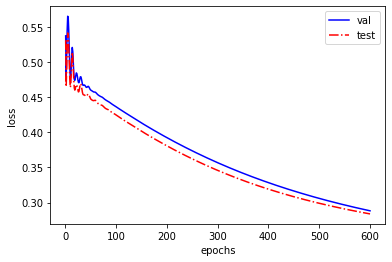

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4943072064, 4943069472]}]
Epoch: 0001 loss_train: 0.6993 acc_train: 0.1950 loss_val: 0.4955 acc_val: 0.8150 time: 0.0033s
Epoch: 0002 loss_train: 0.5041 acc_train: 0.8050 loss_val: 0.4699 acc_val: 0.8150 time: 0.0017s
Epoch: 0003 loss_train: 0.4856 acc_train: 0.8050 loss_val: 0.5038 acc_val: 0.8150 time: 0.0056s
Epoch: 0004 loss_train: 0.5242 acc_train: 0.8050 loss_val: 0.5315 acc_val: 0.8150 time: 0.0015s
Epoch: 0005 loss_train: 0.5543 acc_train: 0.8050 loss_val: 0.5379 acc_val: 0.8150 time: 0.0034s
Epoch: 0006 loss_train: 0.5612 acc_train: 0.8050 loss_val: 0.5260 acc_val: 0.8150 time: 0.0015s
Epoch: 0007 loss_train: 0.5484 acc_train: 0.8050 loss_val: 0.5037 ac

Epoch: 0093 loss_train: 0.4335 acc_train: 0.8050 loss_val: 0.4255 acc_val: 0.8150 time: 0.0030s
Epoch: 0094 loss_train: 0.4329 acc_train: 0.8050 loss_val: 0.4250 acc_val: 0.8150 time: 0.0032s
Epoch: 0095 loss_train: 0.4323 acc_train: 0.8050 loss_val: 0.4244 acc_val: 0.8150 time: 0.0018s
Epoch: 0096 loss_train: 0.4317 acc_train: 0.8050 loss_val: 0.4239 acc_val: 0.8150 time: 0.0018s
Epoch: 0097 loss_train: 0.4312 acc_train: 0.8050 loss_val: 0.4233 acc_val: 0.8150 time: 0.0020s
Epoch: 0098 loss_train: 0.4306 acc_train: 0.8050 loss_val: 0.4228 acc_val: 0.8150 time: 0.0020s
Epoch: 0099 loss_train: 0.4300 acc_train: 0.8050 loss_val: 0.4223 acc_val: 0.8150 time: 0.0051s
Epoch: 0100 loss_train: 0.4295 acc_train: 0.8050 loss_val: 0.4218 acc_val: 0.8150 time: 0.0016s
Epoch: 0101 loss_train: 0.4289 acc_train: 0.8050 loss_val: 0.4214 acc_val: 0.8150 time: 0.0014s
Epoch: 0102 loss_train: 0.4283 acc_train: 0.8050 loss_val: 0.4209 acc_val: 0.8150 time: 0.0013s
Epoch: 0103 loss_train: 0.4277 acc_train

Epoch: 0209 loss_train: 0.3733 acc_train: 0.8050 loss_val: 0.3721 acc_val: 0.8150 time: 0.0023s
Epoch: 0210 loss_train: 0.3728 acc_train: 0.8050 loss_val: 0.3716 acc_val: 0.8150 time: 0.0021s
Epoch: 0211 loss_train: 0.3723 acc_train: 0.8050 loss_val: 0.3712 acc_val: 0.8150 time: 0.0016s
Epoch: 0212 loss_train: 0.3719 acc_train: 0.8050 loss_val: 0.3708 acc_val: 0.8150 time: 0.0014s
Epoch: 0213 loss_train: 0.3714 acc_train: 0.8050 loss_val: 0.3704 acc_val: 0.8150 time: 0.0014s
Epoch: 0214 loss_train: 0.3710 acc_train: 0.8050 loss_val: 0.3700 acc_val: 0.8150 time: 0.0019s
Epoch: 0215 loss_train: 0.3705 acc_train: 0.8050 loss_val: 0.3696 acc_val: 0.8150 time: 0.0015s
Epoch: 0216 loss_train: 0.3701 acc_train: 0.8050 loss_val: 0.3692 acc_val: 0.8150 time: 0.0014s
Epoch: 0217 loss_train: 0.3696 acc_train: 0.8050 loss_val: 0.3688 acc_val: 0.8150 time: 0.0014s
Epoch: 0218 loss_train: 0.3692 acc_train: 0.8050 loss_val: 0.3684 acc_val: 0.8150 time: 0.0016s
Epoch: 0219 loss_train: 0.3688 acc_train

Epoch: 0331 loss_train: 0.3254 acc_train: 0.8200 loss_val: 0.3300 acc_val: 0.8300 time: 0.0018s
Epoch: 0332 loss_train: 0.3251 acc_train: 0.8200 loss_val: 0.3297 acc_val: 0.8300 time: 0.0014s
Epoch: 0333 loss_train: 0.3248 acc_train: 0.8250 loss_val: 0.3294 acc_val: 0.8300 time: 0.0016s
Epoch: 0334 loss_train: 0.3244 acc_train: 0.8250 loss_val: 0.3291 acc_val: 0.8300 time: 0.0017s
Epoch: 0335 loss_train: 0.3241 acc_train: 0.8250 loss_val: 0.3288 acc_val: 0.8300 time: 0.0014s
Epoch: 0336 loss_train: 0.3238 acc_train: 0.8250 loss_val: 0.3285 acc_val: 0.8300 time: 0.0013s
Epoch: 0337 loss_train: 0.3235 acc_train: 0.8300 loss_val: 0.3283 acc_val: 0.8300 time: 0.0014s
Epoch: 0338 loss_train: 0.3231 acc_train: 0.8300 loss_val: 0.3280 acc_val: 0.8300 time: 0.0014s
Epoch: 0339 loss_train: 0.3228 acc_train: 0.8300 loss_val: 0.3277 acc_val: 0.8300 time: 0.0015s
Epoch: 0340 loss_train: 0.3225 acc_train: 0.8300 loss_val: 0.3274 acc_val: 0.8300 time: 0.0016s
Epoch: 0341 loss_train: 0.3222 acc_train

Epoch: 0454 loss_train: 0.2908 acc_train: 0.8650 loss_val: 0.3006 acc_val: 0.8650 time: 0.0018s
Epoch: 0455 loss_train: 0.2906 acc_train: 0.8650 loss_val: 0.3004 acc_val: 0.8650 time: 0.0027s
Epoch: 0456 loss_train: 0.2903 acc_train: 0.8650 loss_val: 0.3002 acc_val: 0.8650 time: 0.0022s
Epoch: 0457 loss_train: 0.2901 acc_train: 0.8650 loss_val: 0.3000 acc_val: 0.8650 time: 0.0014s
Epoch: 0458 loss_train: 0.2899 acc_train: 0.8650 loss_val: 0.2998 acc_val: 0.8650 time: 0.0013s
Epoch: 0459 loss_train: 0.2896 acc_train: 0.8650 loss_val: 0.2996 acc_val: 0.8650 time: 0.0014s
Epoch: 0460 loss_train: 0.2894 acc_train: 0.8650 loss_val: 0.2994 acc_val: 0.8650 time: 0.0021s
Epoch: 0461 loss_train: 0.2892 acc_train: 0.8650 loss_val: 0.2992 acc_val: 0.8650 time: 0.0017s
Epoch: 0462 loss_train: 0.2889 acc_train: 0.8650 loss_val: 0.2990 acc_val: 0.8700 time: 0.0013s
Epoch: 0463 loss_train: 0.2887 acc_train: 0.8650 loss_val: 0.2988 acc_val: 0.8700 time: 0.0014s
Epoch: 0464 loss_train: 0.2885 acc_train

Epoch: 0554 loss_train: 0.2703 acc_train: 0.8900 loss_val: 0.2837 acc_val: 0.8850 time: 0.0029s
Epoch: 0555 loss_train: 0.2702 acc_train: 0.8900 loss_val: 0.2836 acc_val: 0.8850 time: 0.0015s
Epoch: 0556 loss_train: 0.2700 acc_train: 0.8900 loss_val: 0.2834 acc_val: 0.8850 time: 0.0015s
Epoch: 0557 loss_train: 0.2698 acc_train: 0.8900 loss_val: 0.2833 acc_val: 0.8850 time: 0.0014s
Epoch: 0558 loss_train: 0.2696 acc_train: 0.8900 loss_val: 0.2832 acc_val: 0.8850 time: 0.0025s
Epoch: 0559 loss_train: 0.2695 acc_train: 0.8900 loss_val: 0.2830 acc_val: 0.8850 time: 0.0017s
Epoch: 0560 loss_train: 0.2693 acc_train: 0.8900 loss_val: 0.2829 acc_val: 0.8850 time: 0.0013s
Epoch: 0561 loss_train: 0.2691 acc_train: 0.8900 loss_val: 0.2827 acc_val: 0.8850 time: 0.0013s
Epoch: 0562 loss_train: 0.2689 acc_train: 0.8900 loss_val: 0.2826 acc_val: 0.8850 time: 0.0014s
Epoch: 0563 loss_train: 0.2688 acc_train: 0.8900 loss_val: 0.2825 acc_val: 0.8850 time: 0.0014s
Epoch: 0564 loss_train: 0.2686 acc_train

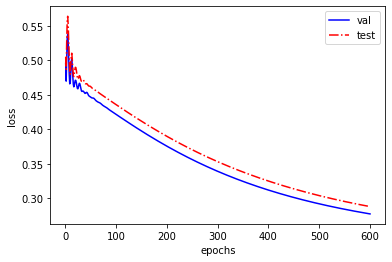

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4938223192, 4938222328]}]
Epoch: 0001 loss_train: 0.7073 acc_train: 0.1850 loss_val: 0.5070 acc_val: 0.8050 time: 0.0025s
Epoch: 0002 loss_train: 0.4982 acc_train: 0.8150 loss_val: 0.4867 acc_val: 0.8050 time: 0.0014s
Epoch: 0003 loss_train: 0.4698 acc_train: 0.8150 loss_val: 0.5286 acc_val: 0.8050 time: 0.0014s
Epoch: 0004 loss_train: 0.5060 acc_train: 0.8150 loss_val: 0.5652 acc_val: 0.8050 time: 0.0019s
Epoch: 0005 loss_train: 0.5393 acc_train: 0.8150 loss_val: 0.5789 acc_val: 0.8050 time: 0.0013s
Epoch: 0006 loss_train: 0.5519 acc_train: 0.8150 loss_val: 0.5713 acc_val: 0.8050 time: 0.0014s
Epoch: 0007 loss_train: 0.5448 acc_train: 0.8150 loss_val: 0.5490 ac

Epoch: 0112 loss_train: 0.4155 acc_train: 0.8150 loss_val: 0.4325 acc_val: 0.8050 time: 0.0018s
Epoch: 0113 loss_train: 0.4150 acc_train: 0.8150 loss_val: 0.4320 acc_val: 0.8050 time: 0.0014s
Epoch: 0114 loss_train: 0.4145 acc_train: 0.8150 loss_val: 0.4315 acc_val: 0.8050 time: 0.0016s
Epoch: 0115 loss_train: 0.4140 acc_train: 0.8150 loss_val: 0.4310 acc_val: 0.8050 time: 0.0019s
Epoch: 0116 loss_train: 0.4135 acc_train: 0.8150 loss_val: 0.4305 acc_val: 0.8050 time: 0.0013s
Epoch: 0117 loss_train: 0.4130 acc_train: 0.8150 loss_val: 0.4300 acc_val: 0.8050 time: 0.0014s
Epoch: 0118 loss_train: 0.4125 acc_train: 0.8150 loss_val: 0.4295 acc_val: 0.8050 time: 0.0013s
Epoch: 0119 loss_train: 0.4119 acc_train: 0.8150 loss_val: 0.4291 acc_val: 0.8050 time: 0.0013s
Epoch: 0120 loss_train: 0.4114 acc_train: 0.8150 loss_val: 0.4286 acc_val: 0.8050 time: 0.0013s
Epoch: 0121 loss_train: 0.4109 acc_train: 0.8150 loss_val: 0.4281 acc_val: 0.8050 time: 0.0024s
Epoch: 0122 loss_train: 0.4104 acc_train

Epoch: 0234 loss_train: 0.3596 acc_train: 0.8150 loss_val: 0.3798 acc_val: 0.8050 time: 0.0016s
Epoch: 0235 loss_train: 0.3593 acc_train: 0.8150 loss_val: 0.3794 acc_val: 0.8050 time: 0.0014s
Epoch: 0236 loss_train: 0.3589 acc_train: 0.8150 loss_val: 0.3790 acc_val: 0.8050 time: 0.0015s
Epoch: 0237 loss_train: 0.3585 acc_train: 0.8150 loss_val: 0.3786 acc_val: 0.8050 time: 0.0014s
Epoch: 0238 loss_train: 0.3581 acc_train: 0.8150 loss_val: 0.3783 acc_val: 0.8050 time: 0.0013s
Epoch: 0239 loss_train: 0.3577 acc_train: 0.8150 loss_val: 0.3779 acc_val: 0.8050 time: 0.0013s
Epoch: 0240 loss_train: 0.3573 acc_train: 0.8150 loss_val: 0.3775 acc_val: 0.8050 time: 0.0013s
Epoch: 0241 loss_train: 0.3569 acc_train: 0.8150 loss_val: 0.3771 acc_val: 0.8050 time: 0.0018s
Epoch: 0242 loss_train: 0.3565 acc_train: 0.8150 loss_val: 0.3768 acc_val: 0.8050 time: 0.0018s
Epoch: 0243 loss_train: 0.3561 acc_train: 0.8150 loss_val: 0.3764 acc_val: 0.8050 time: 0.0013s
Epoch: 0244 loss_train: 0.3557 acc_train

Epoch: 0356 loss_train: 0.3189 acc_train: 0.8300 loss_val: 0.3404 acc_val: 0.8200 time: 0.0018s
Epoch: 0357 loss_train: 0.3186 acc_train: 0.8300 loss_val: 0.3401 acc_val: 0.8200 time: 0.0014s
Epoch: 0358 loss_train: 0.3183 acc_train: 0.8300 loss_val: 0.3398 acc_val: 0.8200 time: 0.0015s
Epoch: 0359 loss_train: 0.3181 acc_train: 0.8300 loss_val: 0.3395 acc_val: 0.8200 time: 0.0015s
Epoch: 0360 loss_train: 0.3178 acc_train: 0.8300 loss_val: 0.3393 acc_val: 0.8200 time: 0.0014s
Epoch: 0361 loss_train: 0.3175 acc_train: 0.8300 loss_val: 0.3390 acc_val: 0.8200 time: 0.0014s
Epoch: 0362 loss_train: 0.3172 acc_train: 0.8300 loss_val: 0.3387 acc_val: 0.8200 time: 0.0030s
Epoch: 0363 loss_train: 0.3170 acc_train: 0.8300 loss_val: 0.3385 acc_val: 0.8200 time: 0.0015s
Epoch: 0364 loss_train: 0.3167 acc_train: 0.8300 loss_val: 0.3382 acc_val: 0.8200 time: 0.0014s
Epoch: 0365 loss_train: 0.3164 acc_train: 0.8300 loss_val: 0.3379 acc_val: 0.8200 time: 0.0014s
Epoch: 0366 loss_train: 0.3162 acc_train

Epoch: 0472 loss_train: 0.2921 acc_train: 0.8550 loss_val: 0.3137 acc_val: 0.8300 time: 0.0056s
Epoch: 0473 loss_train: 0.2919 acc_train: 0.8550 loss_val: 0.3135 acc_val: 0.8300 time: 0.0015s
Epoch: 0474 loss_train: 0.2917 acc_train: 0.8550 loss_val: 0.3133 acc_val: 0.8300 time: 0.0021s
Epoch: 0475 loss_train: 0.2915 acc_train: 0.8550 loss_val: 0.3131 acc_val: 0.8300 time: 0.0015s
Epoch: 0476 loss_train: 0.2913 acc_train: 0.8550 loss_val: 0.3129 acc_val: 0.8300 time: 0.0015s
Epoch: 0477 loss_train: 0.2911 acc_train: 0.8550 loss_val: 0.3127 acc_val: 0.8300 time: 0.0016s
Epoch: 0478 loss_train: 0.2910 acc_train: 0.8550 loss_val: 0.3125 acc_val: 0.8300 time: 0.0035s
Epoch: 0479 loss_train: 0.2908 acc_train: 0.8550 loss_val: 0.3124 acc_val: 0.8300 time: 0.0015s
Epoch: 0480 loss_train: 0.2906 acc_train: 0.8550 loss_val: 0.3122 acc_val: 0.8300 time: 0.0016s
Epoch: 0481 loss_train: 0.2904 acc_train: 0.8550 loss_val: 0.3120 acc_val: 0.8300 time: 0.0016s
Epoch: 0482 loss_train: 0.2902 acc_train

Epoch: 0578 loss_train: 0.2748 acc_train: 0.8750 loss_val: 0.2960 acc_val: 0.8400 time: 0.0018s
Epoch: 0579 loss_train: 0.2747 acc_train: 0.8750 loss_val: 0.2959 acc_val: 0.8400 time: 0.0016s
Epoch: 0580 loss_train: 0.2745 acc_train: 0.8750 loss_val: 0.2958 acc_val: 0.8400 time: 0.0018s
Epoch: 0581 loss_train: 0.2744 acc_train: 0.8750 loss_val: 0.2956 acc_val: 0.8400 time: 0.0018s
Epoch: 0582 loss_train: 0.2743 acc_train: 0.8750 loss_val: 0.2955 acc_val: 0.8450 time: 0.0015s
Epoch: 0583 loss_train: 0.2741 acc_train: 0.8750 loss_val: 0.2953 acc_val: 0.8450 time: 0.0022s
Epoch: 0584 loss_train: 0.2740 acc_train: 0.8750 loss_val: 0.2952 acc_val: 0.8450 time: 0.0014s
Epoch: 0585 loss_train: 0.2739 acc_train: 0.8750 loss_val: 0.2951 acc_val: 0.8450 time: 0.0014s
Epoch: 0586 loss_train: 0.2737 acc_train: 0.8750 loss_val: 0.2949 acc_val: 0.8450 time: 0.0014s
Epoch: 0587 loss_train: 0.2736 acc_train: 0.8750 loss_val: 0.2948 acc_val: 0.8450 time: 0.0014s
Epoch: 0588 loss_train: 0.2735 acc_train

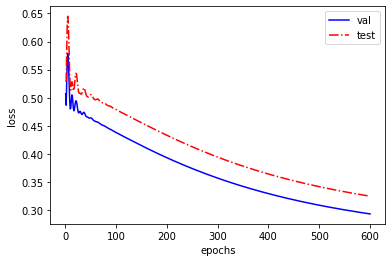

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4924066048, 4926354848]}]
Epoch: 0001 loss_train: 0.6705 acc_train: 0.8050 loss_val: 0.5231 acc_val: 0.7800 time: 0.0023s
Epoch: 0002 loss_train: 0.4973 acc_train: 0.8050 loss_val: 0.5356 acc_val: 0.7800 time: 0.0014s
Epoch: 0003 loss_train: 0.4913 acc_train: 0.8050 loss_val: 0.5860 acc_val: 0.7800 time: 0.0019s
Epoch: 0004 loss_train: 0.5300 acc_train: 0.8050 loss_val: 0.6152 acc_val: 0.7800 time: 0.0018s
Epoch: 0005 loss_train: 0.5541 acc_train: 0.8050 loss_val: 0.6151 acc_val: 0.7800 time: 0.0014s
Epoch: 0006 loss_train: 0.5540 acc_train: 0.8050 loss_val: 0.5936 acc_val: 0.7800 time: 0.0015s
Epoch: 0007 loss_train: 0.5360 acc_train: 0.8050 loss_val: 0.5620 ac

Epoch: 0112 loss_train: 0.4246 acc_train: 0.8050 loss_val: 0.4661 acc_val: 0.7800 time: 0.0017s
Epoch: 0113 loss_train: 0.4240 acc_train: 0.8050 loss_val: 0.4656 acc_val: 0.7800 time: 0.0015s
Epoch: 0114 loss_train: 0.4234 acc_train: 0.8050 loss_val: 0.4651 acc_val: 0.7800 time: 0.0016s
Epoch: 0115 loss_train: 0.4229 acc_train: 0.8050 loss_val: 0.4646 acc_val: 0.7800 time: 0.0014s
Epoch: 0116 loss_train: 0.4223 acc_train: 0.8050 loss_val: 0.4641 acc_val: 0.7800 time: 0.0015s
Epoch: 0117 loss_train: 0.4218 acc_train: 0.8050 loss_val: 0.4636 acc_val: 0.7800 time: 0.0014s
Epoch: 0118 loss_train: 0.4212 acc_train: 0.8050 loss_val: 0.4630 acc_val: 0.7800 time: 0.0016s
Epoch: 0119 loss_train: 0.4206 acc_train: 0.8050 loss_val: 0.4625 acc_val: 0.7800 time: 0.0036s
Epoch: 0120 loss_train: 0.4201 acc_train: 0.8050 loss_val: 0.4619 acc_val: 0.7800 time: 0.0014s
Epoch: 0121 loss_train: 0.4195 acc_train: 0.8050 loss_val: 0.4614 acc_val: 0.7800 time: 0.0015s
Epoch: 0122 loss_train: 0.4190 acc_train

Epoch: 0222 loss_train: 0.3691 acc_train: 0.8050 loss_val: 0.4128 acc_val: 0.7800 time: 0.0021s
Epoch: 0223 loss_train: 0.3687 acc_train: 0.8050 loss_val: 0.4123 acc_val: 0.7800 time: 0.0017s
Epoch: 0224 loss_train: 0.3683 acc_train: 0.8050 loss_val: 0.4119 acc_val: 0.7800 time: 0.0017s
Epoch: 0225 loss_train: 0.3678 acc_train: 0.8050 loss_val: 0.4115 acc_val: 0.7800 time: 0.0016s
Epoch: 0226 loss_train: 0.3674 acc_train: 0.8050 loss_val: 0.4110 acc_val: 0.7800 time: 0.0016s
Epoch: 0227 loss_train: 0.3670 acc_train: 0.8050 loss_val: 0.4106 acc_val: 0.7800 time: 0.0016s
Epoch: 0228 loss_train: 0.3665 acc_train: 0.8050 loss_val: 0.4102 acc_val: 0.7800 time: 0.0014s
Epoch: 0229 loss_train: 0.3661 acc_train: 0.8050 loss_val: 0.4097 acc_val: 0.7800 time: 0.0015s
Epoch: 0230 loss_train: 0.3657 acc_train: 0.8050 loss_val: 0.4093 acc_val: 0.7800 time: 0.0016s
Epoch: 0231 loss_train: 0.3652 acc_train: 0.8050 loss_val: 0.4089 acc_val: 0.7800 time: 0.0014s
Epoch: 0232 loss_train: 0.3648 acc_train

Epoch: 0324 loss_train: 0.3302 acc_train: 0.8250 loss_val: 0.3735 acc_val: 0.8050 time: 0.0021s
Epoch: 0325 loss_train: 0.3299 acc_train: 0.8250 loss_val: 0.3732 acc_val: 0.8050 time: 0.0027s
Epoch: 0326 loss_train: 0.3295 acc_train: 0.8250 loss_val: 0.3729 acc_val: 0.8050 time: 0.0046s
Epoch: 0327 loss_train: 0.3292 acc_train: 0.8250 loss_val: 0.3725 acc_val: 0.8100 time: 0.0024s
Epoch: 0328 loss_train: 0.3289 acc_train: 0.8250 loss_val: 0.3722 acc_val: 0.8100 time: 0.0016s
Epoch: 0329 loss_train: 0.3286 acc_train: 0.8250 loss_val: 0.3719 acc_val: 0.8100 time: 0.0056s
Epoch: 0330 loss_train: 0.3283 acc_train: 0.8250 loss_val: 0.3715 acc_val: 0.8100 time: 0.0016s
Epoch: 0331 loss_train: 0.3279 acc_train: 0.8250 loss_val: 0.3712 acc_val: 0.8100 time: 0.0017s
Epoch: 0332 loss_train: 0.3276 acc_train: 0.8250 loss_val: 0.3709 acc_val: 0.8100 time: 0.0037s
Epoch: 0333 loss_train: 0.3273 acc_train: 0.8250 loss_val: 0.3706 acc_val: 0.8100 time: 0.0020s
Epoch: 0334 loss_train: 0.3270 acc_train

Epoch: 0411 loss_train: 0.3056 acc_train: 0.8350 loss_val: 0.3481 acc_val: 0.8200 time: 0.0028s
Epoch: 0412 loss_train: 0.3053 acc_train: 0.8350 loss_val: 0.3478 acc_val: 0.8250 time: 0.0026s
Epoch: 0413 loss_train: 0.3051 acc_train: 0.8350 loss_val: 0.3476 acc_val: 0.8250 time: 0.0017s
Epoch: 0414 loss_train: 0.3049 acc_train: 0.8350 loss_val: 0.3473 acc_val: 0.8250 time: 0.0021s
Epoch: 0415 loss_train: 0.3046 acc_train: 0.8350 loss_val: 0.3470 acc_val: 0.8250 time: 0.0020s
Epoch: 0416 loss_train: 0.3044 acc_train: 0.8350 loss_val: 0.3468 acc_val: 0.8250 time: 0.0014s
Epoch: 0417 loss_train: 0.3041 acc_train: 0.8350 loss_val: 0.3465 acc_val: 0.8250 time: 0.0014s
Epoch: 0418 loss_train: 0.3039 acc_train: 0.8350 loss_val: 0.3463 acc_val: 0.8250 time: 0.0016s
Epoch: 0419 loss_train: 0.3037 acc_train: 0.8350 loss_val: 0.3460 acc_val: 0.8250 time: 0.0015s
Epoch: 0420 loss_train: 0.3034 acc_train: 0.8350 loss_val: 0.3458 acc_val: 0.8250 time: 0.0014s
Epoch: 0421 loss_train: 0.3032 acc_train

Epoch: 0517 loss_train: 0.2837 acc_train: 0.8600 loss_val: 0.3250 acc_val: 0.8550 time: 0.0017s
Epoch: 0518 loss_train: 0.2836 acc_train: 0.8600 loss_val: 0.3248 acc_val: 0.8550 time: 0.0017s
Epoch: 0519 loss_train: 0.2834 acc_train: 0.8600 loss_val: 0.3246 acc_val: 0.8550 time: 0.0019s
Epoch: 0520 loss_train: 0.2832 acc_train: 0.8600 loss_val: 0.3244 acc_val: 0.8600 time: 0.0014s
Epoch: 0521 loss_train: 0.2831 acc_train: 0.8600 loss_val: 0.3243 acc_val: 0.8650 time: 0.0015s
Epoch: 0522 loss_train: 0.2829 acc_train: 0.8650 loss_val: 0.3241 acc_val: 0.8650 time: 0.0014s
Epoch: 0523 loss_train: 0.2827 acc_train: 0.8650 loss_val: 0.3239 acc_val: 0.8650 time: 0.0015s
Epoch: 0524 loss_train: 0.2826 acc_train: 0.8650 loss_val: 0.3237 acc_val: 0.8650 time: 0.0015s
Epoch: 0525 loss_train: 0.2824 acc_train: 0.8650 loss_val: 0.3235 acc_val: 0.8700 time: 0.0028s
Epoch: 0526 loss_train: 0.2822 acc_train: 0.8650 loss_val: 0.3234 acc_val: 0.8700 time: 0.0014s
Epoch: 0527 loss_train: 0.2820 acc_train

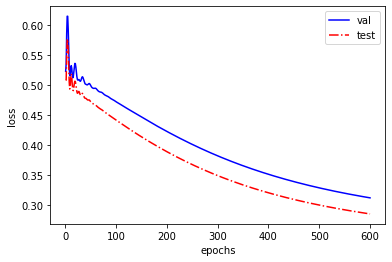

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4925525304, 4924129712]}]
Epoch: 0001 loss_train: 0.6902 acc_train: 0.7800 loss_val: 0.5121 acc_val: 0.7950 time: 0.0027s
Epoch: 0002 loss_train: 0.5266 acc_train: 0.7800 loss_val: 0.5037 acc_val: 0.7950 time: 0.0015s
Epoch: 0003 loss_train: 0.5299 acc_train: 0.7800 loss_val: 0.5376 acc_val: 0.7950 time: 0.0015s
Epoch: 0004 loss_train: 0.5707 acc_train: 0.7800 loss_val: 0.5538 acc_val: 0.7950 time: 0.0014s
Epoch: 0005 loss_train: 0.5893 acc_train: 0.7800 loss_val: 0.5463 acc_val: 0.7950 time: 0.0019s
Epoch: 0006 loss_train: 0.5809 acc_train: 0.7800 loss_val: 0.5251 acc_val: 0.7950 time: 0.0021s
Epoch: 0007 loss_train: 0.5564 acc_train: 0.7800 loss_val: 0.5033 ac

Epoch: 0107 loss_train: 0.4642 acc_train: 0.7800 loss_val: 0.4418 acc_val: 0.7950 time: 0.0019s
Epoch: 0108 loss_train: 0.4636 acc_train: 0.7800 loss_val: 0.4413 acc_val: 0.7950 time: 0.0016s
Epoch: 0109 loss_train: 0.4631 acc_train: 0.7800 loss_val: 0.4407 acc_val: 0.7950 time: 0.0025s
Epoch: 0110 loss_train: 0.4625 acc_train: 0.7800 loss_val: 0.4401 acc_val: 0.7950 time: 0.0026s
Epoch: 0111 loss_train: 0.4619 acc_train: 0.7800 loss_val: 0.4395 acc_val: 0.7950 time: 0.0016s
Epoch: 0112 loss_train: 0.4614 acc_train: 0.7800 loss_val: 0.4389 acc_val: 0.7950 time: 0.0027s
Epoch: 0113 loss_train: 0.4608 acc_train: 0.7800 loss_val: 0.4384 acc_val: 0.7950 time: 0.0014s
Epoch: 0114 loss_train: 0.4602 acc_train: 0.7800 loss_val: 0.4378 acc_val: 0.7950 time: 0.0015s
Epoch: 0115 loss_train: 0.4597 acc_train: 0.7800 loss_val: 0.4373 acc_val: 0.7950 time: 0.0015s
Epoch: 0116 loss_train: 0.4591 acc_train: 0.7800 loss_val: 0.4368 acc_val: 0.7950 time: 0.0017s
Epoch: 0117 loss_train: 0.4586 acc_train

Epoch: 0224 loss_train: 0.4028 acc_train: 0.7850 loss_val: 0.3826 acc_val: 0.7950 time: 0.0018s
Epoch: 0225 loss_train: 0.4023 acc_train: 0.7900 loss_val: 0.3822 acc_val: 0.7950 time: 0.0016s
Epoch: 0226 loss_train: 0.4018 acc_train: 0.7900 loss_val: 0.3817 acc_val: 0.7950 time: 0.0023s
Epoch: 0227 loss_train: 0.4014 acc_train: 0.7900 loss_val: 0.3813 acc_val: 0.7950 time: 0.0015s
Epoch: 0228 loss_train: 0.4009 acc_train: 0.7900 loss_val: 0.3808 acc_val: 0.7950 time: 0.0014s
Epoch: 0229 loss_train: 0.4005 acc_train: 0.7900 loss_val: 0.3804 acc_val: 0.7950 time: 0.0014s
Epoch: 0230 loss_train: 0.4000 acc_train: 0.7900 loss_val: 0.3800 acc_val: 0.7950 time: 0.0015s
Epoch: 0231 loss_train: 0.3995 acc_train: 0.7900 loss_val: 0.3795 acc_val: 0.7950 time: 0.0015s
Epoch: 0232 loss_train: 0.3991 acc_train: 0.7900 loss_val: 0.3791 acc_val: 0.7950 time: 0.0031s
Epoch: 0233 loss_train: 0.3986 acc_train: 0.7900 loss_val: 0.3787 acc_val: 0.7950 time: 0.0015s
Epoch: 0234 loss_train: 0.3982 acc_train

Epoch: 0342 loss_train: 0.3558 acc_train: 0.8150 loss_val: 0.3389 acc_val: 0.8250 time: 0.0019s
Epoch: 0343 loss_train: 0.3554 acc_train: 0.8150 loss_val: 0.3386 acc_val: 0.8250 time: 0.0016s
Epoch: 0344 loss_train: 0.3551 acc_train: 0.8150 loss_val: 0.3383 acc_val: 0.8250 time: 0.0017s
Epoch: 0345 loss_train: 0.3548 acc_train: 0.8150 loss_val: 0.3380 acc_val: 0.8250 time: 0.0016s
Epoch: 0346 loss_train: 0.3545 acc_train: 0.8150 loss_val: 0.3377 acc_val: 0.8250 time: 0.0014s
Epoch: 0347 loss_train: 0.3541 acc_train: 0.8150 loss_val: 0.3374 acc_val: 0.8250 time: 0.0014s
Epoch: 0348 loss_train: 0.3538 acc_train: 0.8150 loss_val: 0.3371 acc_val: 0.8250 time: 0.0024s
Epoch: 0349 loss_train: 0.3535 acc_train: 0.8150 loss_val: 0.3368 acc_val: 0.8250 time: 0.0016s
Epoch: 0350 loss_train: 0.3532 acc_train: 0.8150 loss_val: 0.3365 acc_val: 0.8250 time: 0.0014s
Epoch: 0351 loss_train: 0.3528 acc_train: 0.8150 loss_val: 0.3362 acc_val: 0.8250 time: 0.0014s
Epoch: 0352 loss_train: 0.3525 acc_train

Epoch: 0460 loss_train: 0.3234 acc_train: 0.8600 loss_val: 0.3094 acc_val: 0.8450 time: 0.0018s
Epoch: 0461 loss_train: 0.3231 acc_train: 0.8600 loss_val: 0.3092 acc_val: 0.8450 time: 0.0015s
Epoch: 0462 loss_train: 0.3229 acc_train: 0.8600 loss_val: 0.3090 acc_val: 0.8450 time: 0.0018s
Epoch: 0463 loss_train: 0.3227 acc_train: 0.8600 loss_val: 0.3088 acc_val: 0.8450 time: 0.0015s
Epoch: 0464 loss_train: 0.3225 acc_train: 0.8600 loss_val: 0.3086 acc_val: 0.8500 time: 0.0016s
Epoch: 0465 loss_train: 0.3223 acc_train: 0.8600 loss_val: 0.3084 acc_val: 0.8500 time: 0.0024s
Epoch: 0466 loss_train: 0.3220 acc_train: 0.8600 loss_val: 0.3082 acc_val: 0.8500 time: 0.0015s
Epoch: 0467 loss_train: 0.3218 acc_train: 0.8600 loss_val: 0.3080 acc_val: 0.8500 time: 0.0015s
Epoch: 0468 loss_train: 0.3216 acc_train: 0.8600 loss_val: 0.3078 acc_val: 0.8500 time: 0.0015s
Epoch: 0469 loss_train: 0.3214 acc_train: 0.8600 loss_val: 0.3076 acc_val: 0.8500 time: 0.0015s
Epoch: 0470 loss_train: 0.3212 acc_train

Epoch: 0578 loss_train: 0.3014 acc_train: 0.8800 loss_val: 0.2895 acc_val: 0.8650 time: 0.0014s
Epoch: 0579 loss_train: 0.3013 acc_train: 0.8800 loss_val: 0.2893 acc_val: 0.8700 time: 0.0018s
Epoch: 0580 loss_train: 0.3011 acc_train: 0.8800 loss_val: 0.2892 acc_val: 0.8700 time: 0.0018s
Epoch: 0581 loss_train: 0.3010 acc_train: 0.8800 loss_val: 0.2891 acc_val: 0.8700 time: 0.0018s
Epoch: 0582 loss_train: 0.3008 acc_train: 0.8800 loss_val: 0.2889 acc_val: 0.8700 time: 0.0014s
Epoch: 0583 loss_train: 0.3007 acc_train: 0.8800 loss_val: 0.2888 acc_val: 0.8700 time: 0.0017s
Epoch: 0584 loss_train: 0.3005 acc_train: 0.8800 loss_val: 0.2887 acc_val: 0.8700 time: 0.0014s
Epoch: 0585 loss_train: 0.3004 acc_train: 0.8800 loss_val: 0.2885 acc_val: 0.8700 time: 0.0014s
Epoch: 0586 loss_train: 0.3002 acc_train: 0.8800 loss_val: 0.2884 acc_val: 0.8700 time: 0.0037s
Epoch: 0587 loss_train: 0.3001 acc_train: 0.8800 loss_val: 0.2882 acc_val: 0.8700 time: 0.0014s
Epoch: 0588 loss_train: 0.2999 acc_train

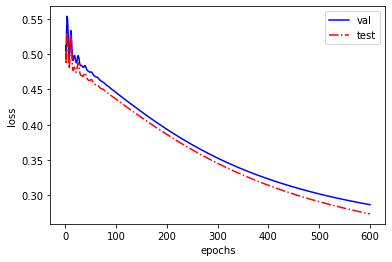

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4966058672, 4966059104]}]
Epoch: 0001 loss_train: 0.6848 acc_train: 0.7950 loss_val: 0.5004 acc_val: 0.8050 time: 0.0024s
Epoch: 0002 loss_train: 0.5109 acc_train: 0.7950 loss_val: 0.4876 acc_val: 0.8050 time: 0.0013s
Epoch: 0003 loss_train: 0.5055 acc_train: 0.7950 loss_val: 0.5228 acc_val: 0.8050 time: 0.0012s
Epoch: 0004 loss_train: 0.5453 acc_train: 0.7950 loss_val: 0.5446 acc_val: 0.8050 time: 0.0013s
Epoch: 0005 loss_train: 0.5690 acc_train: 0.7950 loss_val: 0.5432 acc_val: 0.8050 time: 0.0012s
Epoch: 0006 loss_train: 0.5673 acc_train: 0.7950 loss_val: 0.5251 acc_val: 0.8050 time: 0.0015s
Epoch: 0007 loss_train: 0.5476 acc_train: 0.7950 loss_val: 0.5011 ac

Epoch: 0115 loss_train: 0.4248 acc_train: 0.7950 loss_val: 0.4232 acc_val: 0.8050 time: 0.0015s
Epoch: 0116 loss_train: 0.4242 acc_train: 0.7950 loss_val: 0.4227 acc_val: 0.8050 time: 0.0014s
Epoch: 0117 loss_train: 0.4235 acc_train: 0.7950 loss_val: 0.4221 acc_val: 0.8050 time: 0.0016s
Epoch: 0118 loss_train: 0.4229 acc_train: 0.7950 loss_val: 0.4216 acc_val: 0.8050 time: 0.0017s
Epoch: 0119 loss_train: 0.4222 acc_train: 0.7950 loss_val: 0.4211 acc_val: 0.8050 time: 0.0013s
Epoch: 0120 loss_train: 0.4216 acc_train: 0.7950 loss_val: 0.4206 acc_val: 0.8050 time: 0.0013s
Epoch: 0121 loss_train: 0.4210 acc_train: 0.7950 loss_val: 0.4201 acc_val: 0.8050 time: 0.0012s
Epoch: 0122 loss_train: 0.4203 acc_train: 0.7950 loss_val: 0.4196 acc_val: 0.8050 time: 0.0014s
Epoch: 0123 loss_train: 0.4197 acc_train: 0.7950 loss_val: 0.4190 acc_val: 0.8050 time: 0.0019s
Epoch: 0124 loss_train: 0.4191 acc_train: 0.7950 loss_val: 0.4185 acc_val: 0.8050 time: 0.0015s
Epoch: 0125 loss_train: 0.4184 acc_train

Epoch: 0241 loss_train: 0.3570 acc_train: 0.8000 loss_val: 0.3656 acc_val: 0.8100 time: 0.0020s
Epoch: 0242 loss_train: 0.3566 acc_train: 0.8000 loss_val: 0.3652 acc_val: 0.8100 time: 0.0012s
Epoch: 0243 loss_train: 0.3561 acc_train: 0.8000 loss_val: 0.3648 acc_val: 0.8100 time: 0.0015s
Epoch: 0244 loss_train: 0.3557 acc_train: 0.8000 loss_val: 0.3644 acc_val: 0.8100 time: 0.0016s
Epoch: 0245 loss_train: 0.3553 acc_train: 0.8000 loss_val: 0.3641 acc_val: 0.8100 time: 0.0013s
Epoch: 0246 loss_train: 0.3549 acc_train: 0.8000 loss_val: 0.3637 acc_val: 0.8100 time: 0.0013s
Epoch: 0247 loss_train: 0.3544 acc_train: 0.8000 loss_val: 0.3633 acc_val: 0.8100 time: 0.0013s
Epoch: 0248 loss_train: 0.3540 acc_train: 0.8000 loss_val: 0.3629 acc_val: 0.8100 time: 0.0032s
Epoch: 0249 loss_train: 0.3536 acc_train: 0.8000 loss_val: 0.3625 acc_val: 0.8100 time: 0.0013s
Epoch: 0250 loss_train: 0.3532 acc_train: 0.8000 loss_val: 0.3621 acc_val: 0.8100 time: 0.0012s
Epoch: 0251 loss_train: 0.3528 acc_train

Epoch: 0367 loss_train: 0.3134 acc_train: 0.8250 loss_val: 0.3241 acc_val: 0.8500 time: 0.0022s
Epoch: 0368 loss_train: 0.3131 acc_train: 0.8250 loss_val: 0.3238 acc_val: 0.8500 time: 0.0014s
Epoch: 0369 loss_train: 0.3129 acc_train: 0.8300 loss_val: 0.3235 acc_val: 0.8500 time: 0.0020s
Epoch: 0370 loss_train: 0.3126 acc_train: 0.8300 loss_val: 0.3232 acc_val: 0.8500 time: 0.0012s
Epoch: 0371 loss_train: 0.3123 acc_train: 0.8300 loss_val: 0.3230 acc_val: 0.8500 time: 0.0013s
Epoch: 0372 loss_train: 0.3121 acc_train: 0.8300 loss_val: 0.3227 acc_val: 0.8500 time: 0.0026s
Epoch: 0373 loss_train: 0.3118 acc_train: 0.8300 loss_val: 0.3224 acc_val: 0.8500 time: 0.0013s
Epoch: 0374 loss_train: 0.3115 acc_train: 0.8300 loss_val: 0.3221 acc_val: 0.8500 time: 0.0013s
Epoch: 0375 loss_train: 0.3113 acc_train: 0.8350 loss_val: 0.3219 acc_val: 0.8500 time: 0.0013s
Epoch: 0376 loss_train: 0.3110 acc_train: 0.8350 loss_val: 0.3216 acc_val: 0.8500 time: 0.0013s
Epoch: 0377 loss_train: 0.3107 acc_train

Epoch: 0481 loss_train: 0.2882 acc_train: 0.8700 loss_val: 0.2971 acc_val: 0.8600 time: 0.0017s
Epoch: 0482 loss_train: 0.2880 acc_train: 0.8700 loss_val: 0.2969 acc_val: 0.8600 time: 0.0015s
Epoch: 0483 loss_train: 0.2878 acc_train: 0.8700 loss_val: 0.2966 acc_val: 0.8600 time: 0.0019s
Epoch: 0484 loss_train: 0.2876 acc_train: 0.8700 loss_val: 0.2964 acc_val: 0.8600 time: 0.0015s
Epoch: 0485 loss_train: 0.2874 acc_train: 0.8700 loss_val: 0.2962 acc_val: 0.8600 time: 0.0013s
Epoch: 0486 loss_train: 0.2873 acc_train: 0.8700 loss_val: 0.2960 acc_val: 0.8600 time: 0.0013s
Epoch: 0487 loss_train: 0.2871 acc_train: 0.8700 loss_val: 0.2959 acc_val: 0.8600 time: 0.0015s
Epoch: 0488 loss_train: 0.2869 acc_train: 0.8700 loss_val: 0.2957 acc_val: 0.8650 time: 0.0015s
Epoch: 0489 loss_train: 0.2867 acc_train: 0.8700 loss_val: 0.2955 acc_val: 0.8650 time: 0.0015s
Epoch: 0490 loss_train: 0.2866 acc_train: 0.8700 loss_val: 0.2953 acc_val: 0.8650 time: 0.0013s
Epoch: 0491 loss_train: 0.2864 acc_train

Epoch: 0597 loss_train: 0.2710 acc_train: 0.8750 loss_val: 0.2770 acc_val: 0.8750 time: 0.0018s
Epoch: 0598 loss_train: 0.2709 acc_train: 0.8750 loss_val: 0.2769 acc_val: 0.8750 time: 0.0016s
Epoch: 0599 loss_train: 0.2707 acc_train: 0.8750 loss_val: 0.2767 acc_val: 0.8750 time: 0.0014s
Epoch: 0600 loss_train: 0.2706 acc_train: 0.8750 loss_val: 0.2766 acc_val: 0.8750 time: 0.0014s
Optimization Finished!
Total time elapsed: 1.9710s
Best result: val_loss= 0.276559978723526 test_loss= 0.27408331632614136 test_acc= 0.885


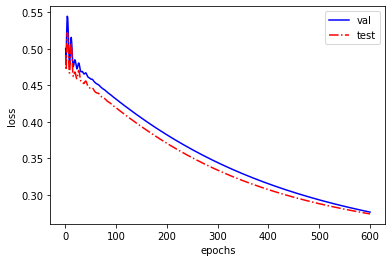

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4924129712, 4926835160]}]
Epoch: 0001 loss_train: 0.6873 acc_train: 0.8050 loss_val: 0.4923 acc_val: 0.8150 time: 0.0028s
Epoch: 0002 loss_train: 0.5014 acc_train: 0.8050 loss_val: 0.4717 acc_val: 0.8150 time: 0.0014s
Epoch: 0003 loss_train: 0.4880 acc_train: 0.8050 loss_val: 0.5059 acc_val: 0.8150 time: 0.0014s
Epoch: 0004 loss_train: 0.5267 acc_train: 0.8050 loss_val: 0.5314 acc_val: 0.8150 time: 0.0018s
Epoch: 0005 loss_train: 0.5545 acc_train: 0.8050 loss_val: 0.5352 acc_val: 0.8150 time: 0.0015s
Epoch: 0006 loss_train: 0.5586 acc_train: 0.8050 loss_val: 0.5215 acc_val: 0.8150 time: 0.0013s
Epoch: 0007 loss_train: 0.5437 acc_train: 0.8050 loss_val: 0.4986 ac

Epoch: 0111 loss_train: 0.4229 acc_train: 0.8050 loss_val: 0.4160 acc_val: 0.8150 time: 0.0018s
Epoch: 0112 loss_train: 0.4223 acc_train: 0.8050 loss_val: 0.4155 acc_val: 0.8150 time: 0.0014s
Epoch: 0113 loss_train: 0.4218 acc_train: 0.8050 loss_val: 0.4151 acc_val: 0.8150 time: 0.0016s
Epoch: 0114 loss_train: 0.4212 acc_train: 0.8050 loss_val: 0.4146 acc_val: 0.8150 time: 0.0021s
Epoch: 0115 loss_train: 0.4206 acc_train: 0.8050 loss_val: 0.4140 acc_val: 0.8150 time: 0.0040s
Epoch: 0116 loss_train: 0.4200 acc_train: 0.8050 loss_val: 0.4135 acc_val: 0.8150 time: 0.0013s
Epoch: 0117 loss_train: 0.4195 acc_train: 0.8050 loss_val: 0.4130 acc_val: 0.8150 time: 0.0013s
Epoch: 0118 loss_train: 0.4189 acc_train: 0.8050 loss_val: 0.4125 acc_val: 0.8150 time: 0.0013s
Epoch: 0119 loss_train: 0.4183 acc_train: 0.8050 loss_val: 0.4120 acc_val: 0.8150 time: 0.0015s
Epoch: 0120 loss_train: 0.4178 acc_train: 0.8050 loss_val: 0.4115 acc_val: 0.8150 time: 0.0013s
Epoch: 0121 loss_train: 0.4172 acc_train

Epoch: 0234 loss_train: 0.3609 acc_train: 0.8050 loss_val: 0.3610 acc_val: 0.8200 time: 0.0018s
Epoch: 0235 loss_train: 0.3604 acc_train: 0.8050 loss_val: 0.3606 acc_val: 0.8200 time: 0.0021s
Epoch: 0236 loss_train: 0.3600 acc_train: 0.8050 loss_val: 0.3602 acc_val: 0.8200 time: 0.0015s
Epoch: 0237 loss_train: 0.3596 acc_train: 0.8050 loss_val: 0.3598 acc_val: 0.8200 time: 0.0014s
Epoch: 0238 loss_train: 0.3592 acc_train: 0.8050 loss_val: 0.3595 acc_val: 0.8200 time: 0.0013s
Epoch: 0239 loss_train: 0.3587 acc_train: 0.8050 loss_val: 0.3591 acc_val: 0.8200 time: 0.0013s
Epoch: 0240 loss_train: 0.3583 acc_train: 0.8050 loss_val: 0.3587 acc_val: 0.8200 time: 0.0015s
Epoch: 0241 loss_train: 0.3579 acc_train: 0.8050 loss_val: 0.3583 acc_val: 0.8200 time: 0.0013s
Epoch: 0242 loss_train: 0.3574 acc_train: 0.8050 loss_val: 0.3580 acc_val: 0.8200 time: 0.0021s
Epoch: 0243 loss_train: 0.3570 acc_train: 0.8050 loss_val: 0.3576 acc_val: 0.8200 time: 0.0015s
Epoch: 0244 loss_train: 0.3566 acc_train

Epoch: 0357 loss_train: 0.3154 acc_train: 0.8400 loss_val: 0.3214 acc_val: 0.8400 time: 0.0018s
Epoch: 0358 loss_train: 0.3151 acc_train: 0.8400 loss_val: 0.3211 acc_val: 0.8400 time: 0.0013s
Epoch: 0359 loss_train: 0.3148 acc_train: 0.8400 loss_val: 0.3208 acc_val: 0.8400 time: 0.0016s
Epoch: 0360 loss_train: 0.3145 acc_train: 0.8400 loss_val: 0.3206 acc_val: 0.8400 time: 0.0017s
Epoch: 0361 loss_train: 0.3142 acc_train: 0.8450 loss_val: 0.3203 acc_val: 0.8400 time: 0.0014s
Epoch: 0362 loss_train: 0.3139 acc_train: 0.8450 loss_val: 0.3200 acc_val: 0.8400 time: 0.0013s
Epoch: 0363 loss_train: 0.3136 acc_train: 0.8450 loss_val: 0.3198 acc_val: 0.8400 time: 0.0028s
Epoch: 0364 loss_train: 0.3133 acc_train: 0.8450 loss_val: 0.3195 acc_val: 0.8400 time: 0.0013s
Epoch: 0365 loss_train: 0.3130 acc_train: 0.8450 loss_val: 0.3193 acc_val: 0.8400 time: 0.0015s
Epoch: 0366 loss_train: 0.3127 acc_train: 0.8450 loss_val: 0.3190 acc_val: 0.8400 time: 0.0013s
Epoch: 0367 loss_train: 0.3124 acc_train

Epoch: 0481 loss_train: 0.2831 acc_train: 0.8750 loss_val: 0.2942 acc_val: 0.8700 time: 0.0020s
Epoch: 0482 loss_train: 0.2828 acc_train: 0.8750 loss_val: 0.2940 acc_val: 0.8700 time: 0.0014s
Epoch: 0483 loss_train: 0.2826 acc_train: 0.8750 loss_val: 0.2938 acc_val: 0.8700 time: 0.0025s
Epoch: 0484 loss_train: 0.2824 acc_train: 0.8750 loss_val: 0.2936 acc_val: 0.8700 time: 0.0018s
Epoch: 0485 loss_train: 0.2822 acc_train: 0.8750 loss_val: 0.2934 acc_val: 0.8700 time: 0.0013s
Epoch: 0486 loss_train: 0.2820 acc_train: 0.8750 loss_val: 0.2933 acc_val: 0.8700 time: 0.0020s
Epoch: 0487 loss_train: 0.2818 acc_train: 0.8800 loss_val: 0.2931 acc_val: 0.8750 time: 0.0014s
Epoch: 0488 loss_train: 0.2816 acc_train: 0.8800 loss_val: 0.2929 acc_val: 0.8750 time: 0.0013s
Epoch: 0489 loss_train: 0.2814 acc_train: 0.8800 loss_val: 0.2927 acc_val: 0.8750 time: 0.0017s
Epoch: 0490 loss_train: 0.2811 acc_train: 0.8800 loss_val: 0.2926 acc_val: 0.8750 time: 0.0013s
Epoch: 0491 loss_train: 0.2809 acc_train

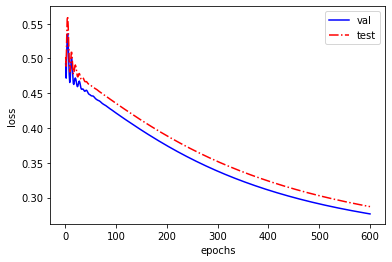

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4926752016, 4966411432]}]
Epoch: 0001 loss_train: 0.7080 acc_train: 0.1850 loss_val: 0.5068 acc_val: 0.8050 time: 0.0017s
Epoch: 0002 loss_train: 0.4982 acc_train: 0.8150 loss_val: 0.4862 acc_val: 0.8050 time: 0.0014s
Epoch: 0003 loss_train: 0.4694 acc_train: 0.8150 loss_val: 0.5281 acc_val: 0.8050 time: 0.0014s
Epoch: 0004 loss_train: 0.5055 acc_train: 0.8150 loss_val: 0.5648 acc_val: 0.8050 time: 0.0019s
Epoch: 0005 loss_train: 0.5389 acc_train: 0.8150 loss_val: 0.5788 acc_val: 0.8050 time: 0.0013s
Epoch: 0006 loss_train: 0.5518 acc_train: 0.8150 loss_val: 0.5714 acc_val: 0.8050 time: 0.0013s
Epoch: 0007 loss_train: 0.5449 acc_train: 0.8150 loss_val: 0.5491 ac

Epoch: 0113 loss_train: 0.4148 acc_train: 0.8150 loss_val: 0.4318 acc_val: 0.8050 time: 0.0019s
Epoch: 0114 loss_train: 0.4143 acc_train: 0.8150 loss_val: 0.4313 acc_val: 0.8050 time: 0.0015s
Epoch: 0115 loss_train: 0.4138 acc_train: 0.8150 loss_val: 0.4308 acc_val: 0.8050 time: 0.0016s
Epoch: 0116 loss_train: 0.4133 acc_train: 0.8150 loss_val: 0.4303 acc_val: 0.8050 time: 0.0018s
Epoch: 0117 loss_train: 0.4128 acc_train: 0.8150 loss_val: 0.4298 acc_val: 0.8050 time: 0.0013s
Epoch: 0118 loss_train: 0.4123 acc_train: 0.8150 loss_val: 0.4293 acc_val: 0.8050 time: 0.0013s
Epoch: 0119 loss_train: 0.4118 acc_train: 0.8150 loss_val: 0.4288 acc_val: 0.8050 time: 0.0015s
Epoch: 0120 loss_train: 0.4113 acc_train: 0.8150 loss_val: 0.4283 acc_val: 0.8050 time: 0.0028s
Epoch: 0121 loss_train: 0.4107 acc_train: 0.8150 loss_val: 0.4279 acc_val: 0.8050 time: 0.0016s
Epoch: 0122 loss_train: 0.4102 acc_train: 0.8150 loss_val: 0.4274 acc_val: 0.8050 time: 0.0014s
Epoch: 0123 loss_train: 0.4097 acc_train

Epoch: 0234 loss_train: 0.3596 acc_train: 0.8150 loss_val: 0.3797 acc_val: 0.8050 time: 0.0018s
Epoch: 0235 loss_train: 0.3592 acc_train: 0.8150 loss_val: 0.3793 acc_val: 0.8050 time: 0.0015s
Epoch: 0236 loss_train: 0.3588 acc_train: 0.8150 loss_val: 0.3789 acc_val: 0.8050 time: 0.0016s
Epoch: 0237 loss_train: 0.3584 acc_train: 0.8150 loss_val: 0.3785 acc_val: 0.8050 time: 0.0017s
Epoch: 0238 loss_train: 0.3580 acc_train: 0.8150 loss_val: 0.3782 acc_val: 0.8050 time: 0.0013s
Epoch: 0239 loss_train: 0.3576 acc_train: 0.8150 loss_val: 0.3778 acc_val: 0.8050 time: 0.0013s
Epoch: 0240 loss_train: 0.3572 acc_train: 0.8150 loss_val: 0.3774 acc_val: 0.8050 time: 0.0019s
Epoch: 0241 loss_train: 0.3568 acc_train: 0.8150 loss_val: 0.3770 acc_val: 0.8050 time: 0.0014s
Epoch: 0242 loss_train: 0.3564 acc_train: 0.8150 loss_val: 0.3767 acc_val: 0.8050 time: 0.0015s
Epoch: 0243 loss_train: 0.3561 acc_train: 0.8150 loss_val: 0.3763 acc_val: 0.8050 time: 0.0014s
Epoch: 0244 loss_train: 0.3557 acc_train

Epoch: 0356 loss_train: 0.3189 acc_train: 0.8300 loss_val: 0.3403 acc_val: 0.8200 time: 0.0020s
Epoch: 0357 loss_train: 0.3186 acc_train: 0.8300 loss_val: 0.3400 acc_val: 0.8200 time: 0.0014s
Epoch: 0358 loss_train: 0.3183 acc_train: 0.8300 loss_val: 0.3398 acc_val: 0.8200 time: 0.0016s
Epoch: 0359 loss_train: 0.3180 acc_train: 0.8300 loss_val: 0.3395 acc_val: 0.8200 time: 0.0019s
Epoch: 0360 loss_train: 0.3178 acc_train: 0.8300 loss_val: 0.3392 acc_val: 0.8200 time: 0.0014s
Epoch: 0361 loss_train: 0.3175 acc_train: 0.8300 loss_val: 0.3390 acc_val: 0.8200 time: 0.0018s
Epoch: 0362 loss_train: 0.3172 acc_train: 0.8300 loss_val: 0.3387 acc_val: 0.8200 time: 0.0013s
Epoch: 0363 loss_train: 0.3170 acc_train: 0.8300 loss_val: 0.3384 acc_val: 0.8200 time: 0.0014s
Epoch: 0364 loss_train: 0.3167 acc_train: 0.8300 loss_val: 0.3382 acc_val: 0.8200 time: 0.0013s
Epoch: 0365 loss_train: 0.3164 acc_train: 0.8300 loss_val: 0.3379 acc_val: 0.8200 time: 0.0017s
Epoch: 0366 loss_train: 0.3162 acc_train

Epoch: 0454 loss_train: 0.2956 acc_train: 0.8550 loss_val: 0.3173 acc_val: 0.8250 time: 0.0021s
Epoch: 0455 loss_train: 0.2954 acc_train: 0.8550 loss_val: 0.3171 acc_val: 0.8250 time: 0.0016s
Epoch: 0456 loss_train: 0.2952 acc_train: 0.8550 loss_val: 0.3169 acc_val: 0.8250 time: 0.0029s
Epoch: 0457 loss_train: 0.2950 acc_train: 0.8550 loss_val: 0.3167 acc_val: 0.8250 time: 0.0015s
Epoch: 0458 loss_train: 0.2948 acc_train: 0.8550 loss_val: 0.3165 acc_val: 0.8250 time: 0.0015s
Epoch: 0459 loss_train: 0.2946 acc_train: 0.8550 loss_val: 0.3162 acc_val: 0.8250 time: 0.0015s
Epoch: 0460 loss_train: 0.2944 acc_train: 0.8550 loss_val: 0.3160 acc_val: 0.8250 time: 0.0017s
Epoch: 0461 loss_train: 0.2942 acc_train: 0.8550 loss_val: 0.3159 acc_val: 0.8250 time: 0.0028s
Epoch: 0462 loss_train: 0.2940 acc_train: 0.8550 loss_val: 0.3157 acc_val: 0.8250 time: 0.0016s
Epoch: 0463 loss_train: 0.2938 acc_train: 0.8550 loss_val: 0.3155 acc_val: 0.8250 time: 0.0016s
Epoch: 0464 loss_train: 0.2937 acc_train

Epoch: 0552 loss_train: 0.2786 acc_train: 0.8750 loss_val: 0.2999 acc_val: 0.8350 time: 0.0019s
Epoch: 0553 loss_train: 0.2784 acc_train: 0.8750 loss_val: 0.2998 acc_val: 0.8350 time: 0.0024s
Epoch: 0554 loss_train: 0.2783 acc_train: 0.8750 loss_val: 0.2996 acc_val: 0.8350 time: 0.0015s
Epoch: 0555 loss_train: 0.2781 acc_train: 0.8750 loss_val: 0.2995 acc_val: 0.8350 time: 0.0014s
Epoch: 0556 loss_train: 0.2780 acc_train: 0.8750 loss_val: 0.2993 acc_val: 0.8350 time: 0.0017s
Epoch: 0557 loss_train: 0.2778 acc_train: 0.8750 loss_val: 0.2992 acc_val: 0.8350 time: 0.0016s
Epoch: 0558 loss_train: 0.2777 acc_train: 0.8750 loss_val: 0.2990 acc_val: 0.8350 time: 0.0016s
Epoch: 0559 loss_train: 0.2775 acc_train: 0.8750 loss_val: 0.2988 acc_val: 0.8350 time: 0.0016s
Epoch: 0560 loss_train: 0.2774 acc_train: 0.8750 loss_val: 0.2987 acc_val: 0.8350 time: 0.0014s
Epoch: 0561 loss_train: 0.2772 acc_train: 0.8750 loss_val: 0.2985 acc_val: 0.8350 time: 0.0014s
Epoch: 0562 loss_train: 0.2771 acc_train

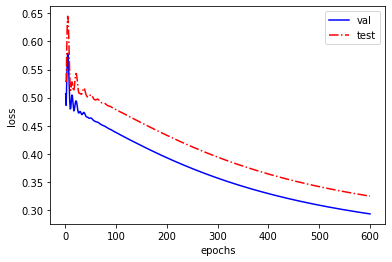

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4960386360, 4960386072]}]
Epoch: 0001 loss_train: 0.6698 acc_train: 0.8050 loss_val: 0.5234 acc_val: 0.7800 time: 0.0026s
Epoch: 0002 loss_train: 0.4975 acc_train: 0.8050 loss_val: 0.5363 acc_val: 0.7800 time: 0.0015s
Epoch: 0003 loss_train: 0.4918 acc_train: 0.8050 loss_val: 0.5866 acc_val: 0.7800 time: 0.0013s
Epoch: 0004 loss_train: 0.5305 acc_train: 0.8050 loss_val: 0.6155 acc_val: 0.7800 time: 0.0014s
Epoch: 0005 loss_train: 0.5544 acc_train: 0.8050 loss_val: 0.6152 acc_val: 0.7800 time: 0.0020s
Epoch: 0006 loss_train: 0.5540 acc_train: 0.8050 loss_val: 0.5935 acc_val: 0.7800 time: 0.0020s
Epoch: 0007 loss_train: 0.5359 acc_train: 0.8050 loss_val: 0.5618 ac

Epoch: 0112 loss_train: 0.4249 acc_train: 0.8050 loss_val: 0.4664 acc_val: 0.7800 time: 0.0019s
Epoch: 0113 loss_train: 0.4243 acc_train: 0.8050 loss_val: 0.4659 acc_val: 0.7800 time: 0.0015s
Epoch: 0114 loss_train: 0.4238 acc_train: 0.8050 loss_val: 0.4654 acc_val: 0.7800 time: 0.0017s
Epoch: 0115 loss_train: 0.4232 acc_train: 0.8050 loss_val: 0.4649 acc_val: 0.7800 time: 0.0016s
Epoch: 0116 loss_train: 0.4227 acc_train: 0.8050 loss_val: 0.4644 acc_val: 0.7800 time: 0.0014s
Epoch: 0117 loss_train: 0.4221 acc_train: 0.8050 loss_val: 0.4639 acc_val: 0.7800 time: 0.0015s
Epoch: 0118 loss_train: 0.4215 acc_train: 0.8050 loss_val: 0.4634 acc_val: 0.7800 time: 0.0014s
Epoch: 0119 loss_train: 0.4210 acc_train: 0.8050 loss_val: 0.4628 acc_val: 0.7800 time: 0.0015s
Epoch: 0120 loss_train: 0.4204 acc_train: 0.8050 loss_val: 0.4623 acc_val: 0.7800 time: 0.0017s
Epoch: 0121 loss_train: 0.4199 acc_train: 0.8050 loss_val: 0.4617 acc_val: 0.7800 time: 0.0020s
Epoch: 0122 loss_train: 0.4193 acc_train

Epoch: 0231 loss_train: 0.3654 acc_train: 0.8050 loss_val: 0.4091 acc_val: 0.7800 time: 0.0019s
Epoch: 0232 loss_train: 0.3650 acc_train: 0.8050 loss_val: 0.4086 acc_val: 0.7800 time: 0.0015s
Epoch: 0233 loss_train: 0.3646 acc_train: 0.8050 loss_val: 0.4082 acc_val: 0.7800 time: 0.0019s
Epoch: 0234 loss_train: 0.3641 acc_train: 0.8050 loss_val: 0.4078 acc_val: 0.7800 time: 0.0014s
Epoch: 0235 loss_train: 0.3637 acc_train: 0.8050 loss_val: 0.4074 acc_val: 0.7800 time: 0.0017s
Epoch: 0236 loss_train: 0.3633 acc_train: 0.8050 loss_val: 0.4069 acc_val: 0.7800 time: 0.0014s
Epoch: 0237 loss_train: 0.3629 acc_train: 0.8050 loss_val: 0.4065 acc_val: 0.7800 time: 0.0015s
Epoch: 0238 loss_train: 0.3624 acc_train: 0.8050 loss_val: 0.4061 acc_val: 0.7800 time: 0.0016s
Epoch: 0239 loss_train: 0.3620 acc_train: 0.8050 loss_val: 0.4057 acc_val: 0.7800 time: 0.0019s
Epoch: 0240 loss_train: 0.3616 acc_train: 0.8050 loss_val: 0.4052 acc_val: 0.7800 time: 0.0014s
Epoch: 0241 loss_train: 0.3612 acc_train

Epoch: 0341 loss_train: 0.3249 acc_train: 0.8250 loss_val: 0.3681 acc_val: 0.8150 time: 0.0017s
Epoch: 0342 loss_train: 0.3246 acc_train: 0.8250 loss_val: 0.3678 acc_val: 0.8150 time: 0.0015s
Epoch: 0343 loss_train: 0.3243 acc_train: 0.8250 loss_val: 0.3675 acc_val: 0.8150 time: 0.0017s
Epoch: 0344 loss_train: 0.3240 acc_train: 0.8300 loss_val: 0.3671 acc_val: 0.8150 time: 0.0019s
Epoch: 0345 loss_train: 0.3237 acc_train: 0.8300 loss_val: 0.3668 acc_val: 0.8150 time: 0.0016s
Epoch: 0346 loss_train: 0.3234 acc_train: 0.8300 loss_val: 0.3665 acc_val: 0.8150 time: 0.0014s
Epoch: 0347 loss_train: 0.3231 acc_train: 0.8300 loss_val: 0.3662 acc_val: 0.8150 time: 0.0016s
Epoch: 0348 loss_train: 0.3228 acc_train: 0.8300 loss_val: 0.3659 acc_val: 0.8150 time: 0.0025s
Epoch: 0349 loss_train: 0.3225 acc_train: 0.8300 loss_val: 0.3656 acc_val: 0.8150 time: 0.0017s
Epoch: 0350 loss_train: 0.3222 acc_train: 0.8300 loss_val: 0.3653 acc_val: 0.8150 time: 0.0017s
Epoch: 0351 loss_train: 0.3219 acc_train

Epoch: 0455 loss_train: 0.2956 acc_train: 0.8450 loss_val: 0.3376 acc_val: 0.8400 time: 0.0020s
Epoch: 0456 loss_train: 0.2954 acc_train: 0.8450 loss_val: 0.3374 acc_val: 0.8400 time: 0.0017s
Epoch: 0457 loss_train: 0.2952 acc_train: 0.8450 loss_val: 0.3371 acc_val: 0.8400 time: 0.0016s
Epoch: 0458 loss_train: 0.2950 acc_train: 0.8450 loss_val: 0.3369 acc_val: 0.8400 time: 0.0014s
Epoch: 0459 loss_train: 0.2948 acc_train: 0.8450 loss_val: 0.3367 acc_val: 0.8400 time: 0.0015s
Epoch: 0460 loss_train: 0.2946 acc_train: 0.8500 loss_val: 0.3365 acc_val: 0.8400 time: 0.0017s
Epoch: 0461 loss_train: 0.2944 acc_train: 0.8500 loss_val: 0.3363 acc_val: 0.8400 time: 0.0014s
Epoch: 0462 loss_train: 0.2942 acc_train: 0.8500 loss_val: 0.3360 acc_val: 0.8400 time: 0.0017s
Epoch: 0463 loss_train: 0.2939 acc_train: 0.8500 loss_val: 0.3358 acc_val: 0.8400 time: 0.0014s
Epoch: 0464 loss_train: 0.2937 acc_train: 0.8500 loss_val: 0.3356 acc_val: 0.8400 time: 0.0015s
Epoch: 0465 loss_train: 0.2935 acc_train

Epoch: 0573 loss_train: 0.2749 acc_train: 0.8700 loss_val: 0.3155 acc_val: 0.8750 time: 0.0018s
Epoch: 0574 loss_train: 0.2747 acc_train: 0.8700 loss_val: 0.3154 acc_val: 0.8750 time: 0.0015s
Epoch: 0575 loss_train: 0.2746 acc_train: 0.8700 loss_val: 0.3152 acc_val: 0.8750 time: 0.0025s
Epoch: 0576 loss_train: 0.2745 acc_train: 0.8700 loss_val: 0.3150 acc_val: 0.8750 time: 0.0014s
Epoch: 0577 loss_train: 0.2743 acc_train: 0.8700 loss_val: 0.3149 acc_val: 0.8750 time: 0.0015s
Epoch: 0578 loss_train: 0.2742 acc_train: 0.8700 loss_val: 0.3147 acc_val: 0.8750 time: 0.0014s
Epoch: 0579 loss_train: 0.2740 acc_train: 0.8700 loss_val: 0.3146 acc_val: 0.8750 time: 0.0015s
Epoch: 0580 loss_train: 0.2739 acc_train: 0.8700 loss_val: 0.3144 acc_val: 0.8750 time: 0.0015s
Epoch: 0581 loss_train: 0.2737 acc_train: 0.8700 loss_val: 0.3143 acc_val: 0.8750 time: 0.0031s
Epoch: 0582 loss_train: 0.2736 acc_train: 0.8700 loss_val: 0.3141 acc_val: 0.8750 time: 0.0014s
Epoch: 0583 loss_train: 0.2735 acc_train

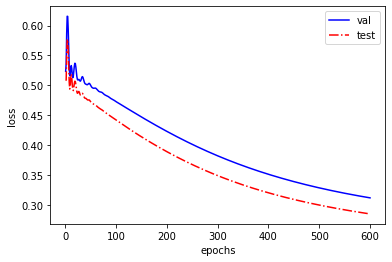

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4966029496, 4966411432]}]
Epoch: 0001 loss_train: 0.7249 acc_train: 0.2200 loss_val: 0.5225 acc_val: 0.7950 time: 0.0028s
Epoch: 0002 loss_train: 0.5353 acc_train: 0.7800 loss_val: 0.4999 acc_val: 0.7950 time: 0.0016s
Epoch: 0003 loss_train: 0.5247 acc_train: 0.7800 loss_val: 0.5349 acc_val: 0.7950 time: 0.0016s
Epoch: 0004 loss_train: 0.5675 acc_train: 0.7800 loss_val: 0.5588 acc_val: 0.7950 time: 0.0014s
Epoch: 0005 loss_train: 0.5948 acc_train: 0.7800 loss_val: 0.5586 acc_val: 0.7950 time: 0.0020s
Epoch: 0006 loss_train: 0.5947 acc_train: 0.7800 loss_val: 0.5408 acc_val: 0.7950 time: 0.0019s
Epoch: 0007 loss_train: 0.5745 acc_train: 0.7800 loss_val: 0.5164 ac

Epoch: 0109 loss_train: 0.4662 acc_train: 0.7800 loss_val: 0.4439 acc_val: 0.7950 time: 0.0017s
Epoch: 0110 loss_train: 0.4656 acc_train: 0.7800 loss_val: 0.4434 acc_val: 0.7950 time: 0.0016s
Epoch: 0111 loss_train: 0.4651 acc_train: 0.7800 loss_val: 0.4429 acc_val: 0.7950 time: 0.0023s
Epoch: 0112 loss_train: 0.4646 acc_train: 0.7800 loss_val: 0.4423 acc_val: 0.7950 time: 0.0014s
Epoch: 0113 loss_train: 0.4640 acc_train: 0.7800 loss_val: 0.4418 acc_val: 0.7950 time: 0.0015s
Epoch: 0114 loss_train: 0.4635 acc_train: 0.7800 loss_val: 0.4412 acc_val: 0.7950 time: 0.0014s
Epoch: 0115 loss_train: 0.4630 acc_train: 0.7800 loss_val: 0.4407 acc_val: 0.7950 time: 0.0028s
Epoch: 0116 loss_train: 0.4624 acc_train: 0.7800 loss_val: 0.4401 acc_val: 0.7950 time: 0.0015s
Epoch: 0117 loss_train: 0.4619 acc_train: 0.7800 loss_val: 0.4396 acc_val: 0.7950 time: 0.0015s
Epoch: 0118 loss_train: 0.4614 acc_train: 0.7800 loss_val: 0.4391 acc_val: 0.7950 time: 0.0014s
Epoch: 0119 loss_train: 0.4608 acc_train

Epoch: 0228 loss_train: 0.4064 acc_train: 0.7850 loss_val: 0.3861 acc_val: 0.7950 time: 0.0022s
Epoch: 0229 loss_train: 0.4059 acc_train: 0.7850 loss_val: 0.3857 acc_val: 0.7950 time: 0.0015s
Epoch: 0230 loss_train: 0.4055 acc_train: 0.7850 loss_val: 0.3852 acc_val: 0.7950 time: 0.0016s
Epoch: 0231 loss_train: 0.4050 acc_train: 0.7850 loss_val: 0.3848 acc_val: 0.7950 time: 0.0017s
Epoch: 0232 loss_train: 0.4046 acc_train: 0.7850 loss_val: 0.3844 acc_val: 0.7950 time: 0.0027s
Epoch: 0233 loss_train: 0.4041 acc_train: 0.7850 loss_val: 0.3840 acc_val: 0.7950 time: 0.0016s
Epoch: 0234 loss_train: 0.4037 acc_train: 0.7850 loss_val: 0.3836 acc_val: 0.7950 time: 0.0014s
Epoch: 0235 loss_train: 0.4032 acc_train: 0.7850 loss_val: 0.3831 acc_val: 0.7950 time: 0.0015s
Epoch: 0236 loss_train: 0.4028 acc_train: 0.7850 loss_val: 0.3827 acc_val: 0.7950 time: 0.0014s
Epoch: 0237 loss_train: 0.4024 acc_train: 0.7850 loss_val: 0.3823 acc_val: 0.7950 time: 0.0015s
Epoch: 0238 loss_train: 0.4019 acc_train

Epoch: 0347 loss_train: 0.3600 acc_train: 0.8150 loss_val: 0.3429 acc_val: 0.8150 time: 0.0019s
Epoch: 0348 loss_train: 0.3597 acc_train: 0.8150 loss_val: 0.3426 acc_val: 0.8150 time: 0.0015s
Epoch: 0349 loss_train: 0.3594 acc_train: 0.8150 loss_val: 0.3423 acc_val: 0.8150 time: 0.0015s
Epoch: 0350 loss_train: 0.3590 acc_train: 0.8150 loss_val: 0.3420 acc_val: 0.8150 time: 0.0014s
Epoch: 0351 loss_train: 0.3587 acc_train: 0.8150 loss_val: 0.3417 acc_val: 0.8150 time: 0.0016s
Epoch: 0352 loss_train: 0.3584 acc_train: 0.8150 loss_val: 0.3414 acc_val: 0.8150 time: 0.0015s
Epoch: 0353 loss_train: 0.3581 acc_train: 0.8150 loss_val: 0.3411 acc_val: 0.8150 time: 0.0016s
Epoch: 0354 loss_train: 0.3577 acc_train: 0.8150 loss_val: 0.3408 acc_val: 0.8150 time: 0.0035s
Epoch: 0355 loss_train: 0.3574 acc_train: 0.8150 loss_val: 0.3405 acc_val: 0.8150 time: 0.0014s
Epoch: 0356 loss_train: 0.3571 acc_train: 0.8150 loss_val: 0.3402 acc_val: 0.8150 time: 0.0015s
Epoch: 0357 loss_train: 0.3568 acc_train

Epoch: 0466 loss_train: 0.3273 acc_train: 0.8600 loss_val: 0.3131 acc_val: 0.8350 time: 0.0018s
Epoch: 0467 loss_train: 0.3271 acc_train: 0.8600 loss_val: 0.3128 acc_val: 0.8350 time: 0.0016s
Epoch: 0468 loss_train: 0.3269 acc_train: 0.8600 loss_val: 0.3126 acc_val: 0.8400 time: 0.0016s
Epoch: 0469 loss_train: 0.3267 acc_train: 0.8600 loss_val: 0.3124 acc_val: 0.8400 time: 0.0015s
Epoch: 0470 loss_train: 0.3264 acc_train: 0.8600 loss_val: 0.3122 acc_val: 0.8400 time: 0.0014s
Epoch: 0471 loss_train: 0.3262 acc_train: 0.8600 loss_val: 0.3120 acc_val: 0.8400 time: 0.0026s
Epoch: 0472 loss_train: 0.3260 acc_train: 0.8600 loss_val: 0.3118 acc_val: 0.8400 time: 0.0015s
Epoch: 0473 loss_train: 0.3258 acc_train: 0.8600 loss_val: 0.3116 acc_val: 0.8400 time: 0.0015s
Epoch: 0474 loss_train: 0.3256 acc_train: 0.8600 loss_val: 0.3114 acc_val: 0.8400 time: 0.0014s
Epoch: 0475 loss_train: 0.3253 acc_train: 0.8600 loss_val: 0.3112 acc_val: 0.8400 time: 0.0015s
Epoch: 0476 loss_train: 0.3251 acc_train

Epoch: 0573 loss_train: 0.3068 acc_train: 0.8650 loss_val: 0.2944 acc_val: 0.8600 time: 0.0033s
Epoch: 0574 loss_train: 0.3066 acc_train: 0.8700 loss_val: 0.2942 acc_val: 0.8600 time: 0.0026s
Epoch: 0575 loss_train: 0.3065 acc_train: 0.8700 loss_val: 0.2941 acc_val: 0.8600 time: 0.0025s
Epoch: 0576 loss_train: 0.3063 acc_train: 0.8700 loss_val: 0.2939 acc_val: 0.8600 time: 0.0024s
Epoch: 0577 loss_train: 0.3061 acc_train: 0.8700 loss_val: 0.2938 acc_val: 0.8600 time: 0.0017s
Epoch: 0578 loss_train: 0.3060 acc_train: 0.8700 loss_val: 0.2936 acc_val: 0.8600 time: 0.0026s
Epoch: 0579 loss_train: 0.3058 acc_train: 0.8700 loss_val: 0.2935 acc_val: 0.8600 time: 0.0039s
Epoch: 0580 loss_train: 0.3057 acc_train: 0.8700 loss_val: 0.2933 acc_val: 0.8650 time: 0.0021s
Epoch: 0581 loss_train: 0.3055 acc_train: 0.8700 loss_val: 0.2932 acc_val: 0.8650 time: 0.0015s
Epoch: 0582 loss_train: 0.3053 acc_train: 0.8700 loss_val: 0.2930 acc_val: 0.8650 time: 0.0018s
Epoch: 0583 loss_train: 0.3052 acc_train

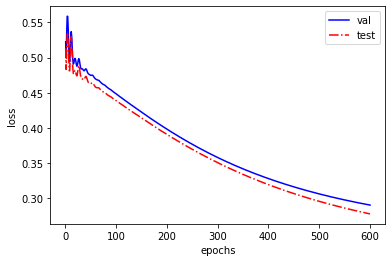

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4960386072, 4960386360]}]
Epoch: 0001 loss_train: 0.6986 acc_train: 0.2050 loss_val: 0.5043 acc_val: 0.8050 time: 0.0035s
Epoch: 0002 loss_train: 0.5140 acc_train: 0.7950 loss_val: 0.4856 acc_val: 0.8050 time: 0.0012s
Epoch: 0003 loss_train: 0.5029 acc_train: 0.7950 loss_val: 0.5210 acc_val: 0.8050 time: 0.0013s
Epoch: 0004 loss_train: 0.5431 acc_train: 0.7950 loss_val: 0.5457 acc_val: 0.8050 time: 0.0017s
Epoch: 0005 loss_train: 0.5699 acc_train: 0.7950 loss_val: 0.5473 acc_val: 0.8050 time: 0.0012s
Epoch: 0006 loss_train: 0.5716 acc_train: 0.7950 loss_val: 0.5312 acc_val: 0.8050 time: 0.0014s
Epoch: 0007 loss_train: 0.5540 acc_train: 0.7950 loss_val: 0.5070 ac

Epoch: 0114 loss_train: 0.4264 acc_train: 0.7950 loss_val: 0.4247 acc_val: 0.8050 time: 0.0015s
Epoch: 0115 loss_train: 0.4258 acc_train: 0.7950 loss_val: 0.4242 acc_val: 0.8050 time: 0.0014s
Epoch: 0116 loss_train: 0.4251 acc_train: 0.7950 loss_val: 0.4236 acc_val: 0.8050 time: 0.0016s
Epoch: 0117 loss_train: 0.4245 acc_train: 0.7950 loss_val: 0.4231 acc_val: 0.8050 time: 0.0017s
Epoch: 0118 loss_train: 0.4239 acc_train: 0.7950 loss_val: 0.4226 acc_val: 0.8050 time: 0.0013s
Epoch: 0119 loss_train: 0.4232 acc_train: 0.7950 loss_val: 0.4221 acc_val: 0.8050 time: 0.0016s
Epoch: 0120 loss_train: 0.4226 acc_train: 0.7950 loss_val: 0.4216 acc_val: 0.8050 time: 0.0013s
Epoch: 0121 loss_train: 0.4220 acc_train: 0.7950 loss_val: 0.4211 acc_val: 0.8050 time: 0.0013s
Epoch: 0122 loss_train: 0.4214 acc_train: 0.7950 loss_val: 0.4206 acc_val: 0.8050 time: 0.0013s
Epoch: 0123 loss_train: 0.4207 acc_train: 0.7950 loss_val: 0.4201 acc_val: 0.8050 time: 0.0012s
Epoch: 0124 loss_train: 0.4201 acc_train

Epoch: 0240 loss_train: 0.3593 acc_train: 0.8000 loss_val: 0.3678 acc_val: 0.8100 time: 0.0018s
Epoch: 0241 loss_train: 0.3589 acc_train: 0.8000 loss_val: 0.3674 acc_val: 0.8100 time: 0.0014s
Epoch: 0242 loss_train: 0.3584 acc_train: 0.8000 loss_val: 0.3670 acc_val: 0.8100 time: 0.0016s
Epoch: 0243 loss_train: 0.3580 acc_train: 0.8000 loss_val: 0.3666 acc_val: 0.8100 time: 0.0020s
Epoch: 0244 loss_train: 0.3576 acc_train: 0.8000 loss_val: 0.3663 acc_val: 0.8100 time: 0.0013s
Epoch: 0245 loss_train: 0.3572 acc_train: 0.8000 loss_val: 0.3659 acc_val: 0.8100 time: 0.0012s
Epoch: 0246 loss_train: 0.3567 acc_train: 0.8000 loss_val: 0.3655 acc_val: 0.8100 time: 0.0012s
Epoch: 0247 loss_train: 0.3563 acc_train: 0.8000 loss_val: 0.3651 acc_val: 0.8100 time: 0.0013s
Epoch: 0248 loss_train: 0.3559 acc_train: 0.8000 loss_val: 0.3647 acc_val: 0.8100 time: 0.0013s
Epoch: 0249 loss_train: 0.3555 acc_train: 0.8000 loss_val: 0.3644 acc_val: 0.8100 time: 0.0018s
Epoch: 0250 loss_train: 0.3551 acc_train

Epoch: 0366 loss_train: 0.3156 acc_train: 0.8250 loss_val: 0.3264 acc_val: 0.8450 time: 0.0018s
Epoch: 0367 loss_train: 0.3153 acc_train: 0.8250 loss_val: 0.3261 acc_val: 0.8450 time: 0.0014s
Epoch: 0368 loss_train: 0.3150 acc_train: 0.8250 loss_val: 0.3258 acc_val: 0.8500 time: 0.0014s
Epoch: 0369 loss_train: 0.3148 acc_train: 0.8250 loss_val: 0.3256 acc_val: 0.8500 time: 0.0019s
Epoch: 0370 loss_train: 0.3145 acc_train: 0.8250 loss_val: 0.3253 acc_val: 0.8500 time: 0.0012s
Epoch: 0371 loss_train: 0.3142 acc_train: 0.8250 loss_val: 0.3250 acc_val: 0.8500 time: 0.0012s
Epoch: 0372 loss_train: 0.3140 acc_train: 0.8250 loss_val: 0.3247 acc_val: 0.8500 time: 0.0012s
Epoch: 0373 loss_train: 0.3137 acc_train: 0.8250 loss_val: 0.3245 acc_val: 0.8500 time: 0.0021s
Epoch: 0374 loss_train: 0.3134 acc_train: 0.8250 loss_val: 0.3242 acc_val: 0.8500 time: 0.0014s
Epoch: 0375 loss_train: 0.3132 acc_train: 0.8250 loss_val: 0.3239 acc_val: 0.8500 time: 0.0012s
Epoch: 0376 loss_train: 0.3129 acc_train

Epoch: 0492 loss_train: 0.2879 acc_train: 0.8700 loss_val: 0.2968 acc_val: 0.8600 time: 0.0019s
Epoch: 0493 loss_train: 0.2877 acc_train: 0.8700 loss_val: 0.2966 acc_val: 0.8600 time: 0.0014s
Epoch: 0494 loss_train: 0.2876 acc_train: 0.8700 loss_val: 0.2964 acc_val: 0.8600 time: 0.0015s
Epoch: 0495 loss_train: 0.2874 acc_train: 0.8700 loss_val: 0.2962 acc_val: 0.8600 time: 0.0018s
Epoch: 0496 loss_train: 0.2872 acc_train: 0.8700 loss_val: 0.2960 acc_val: 0.8600 time: 0.0012s
Epoch: 0497 loss_train: 0.2870 acc_train: 0.8700 loss_val: 0.2958 acc_val: 0.8600 time: 0.0013s
Epoch: 0498 loss_train: 0.2869 acc_train: 0.8700 loss_val: 0.2957 acc_val: 0.8650 time: 0.0022s
Epoch: 0499 loss_train: 0.2867 acc_train: 0.8700 loss_val: 0.2955 acc_val: 0.8650 time: 0.0015s
Epoch: 0500 loss_train: 0.2865 acc_train: 0.8700 loss_val: 0.2953 acc_val: 0.8650 time: 0.0012s
Epoch: 0501 loss_train: 0.2864 acc_train: 0.8700 loss_val: 0.2951 acc_val: 0.8650 time: 0.0014s
Epoch: 0502 loss_train: 0.2862 acc_train

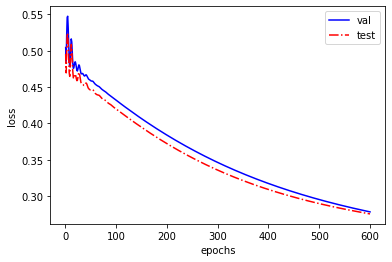

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4963486024, 4963485736]}]
Epoch: 0001 loss_train: 0.7297 acc_train: 0.1950 loss_val: 0.5056 acc_val: 0.8150 time: 0.0026s
Epoch: 0002 loss_train: 0.5136 acc_train: 0.8050 loss_val: 0.4674 acc_val: 0.8150 time: 0.0013s
Epoch: 0003 loss_train: 0.4828 acc_train: 0.8050 loss_val: 0.4999 acc_val: 0.8150 time: 0.0013s
Epoch: 0004 loss_train: 0.5203 acc_train: 0.8050 loss_val: 0.5318 acc_val: 0.8150 time: 0.0012s
Epoch: 0005 loss_train: 0.5551 acc_train: 0.8050 loss_val: 0.5439 acc_val: 0.8150 time: 0.0013s
Epoch: 0006 loss_train: 0.5681 acc_train: 0.8050 loss_val: 0.5367 acc_val: 0.8150 time: 0.0014s
Epoch: 0007 loss_train: 0.5603 acc_train: 0.8050 loss_val: 0.5165 ac

Epoch: 0110 loss_train: 0.4260 acc_train: 0.8050 loss_val: 0.4186 acc_val: 0.8150 time: 0.0015s
Epoch: 0111 loss_train: 0.4254 acc_train: 0.8050 loss_val: 0.4181 acc_val: 0.8150 time: 0.0015s
Epoch: 0112 loss_train: 0.4249 acc_train: 0.8050 loss_val: 0.4176 acc_val: 0.8150 time: 0.0017s
Epoch: 0113 loss_train: 0.4244 acc_train: 0.8050 loss_val: 0.4172 acc_val: 0.8150 time: 0.0021s
Epoch: 0114 loss_train: 0.4238 acc_train: 0.8050 loss_val: 0.4167 acc_val: 0.8150 time: 0.0013s
Epoch: 0115 loss_train: 0.4233 acc_train: 0.8050 loss_val: 0.4162 acc_val: 0.8150 time: 0.0013s
Epoch: 0116 loss_train: 0.4227 acc_train: 0.8050 loss_val: 0.4158 acc_val: 0.8150 time: 0.0013s
Epoch: 0117 loss_train: 0.4222 acc_train: 0.8050 loss_val: 0.4153 acc_val: 0.8150 time: 0.0015s
Epoch: 0118 loss_train: 0.4217 acc_train: 0.8050 loss_val: 0.4149 acc_val: 0.8150 time: 0.0013s
Epoch: 0119 loss_train: 0.4211 acc_train: 0.8050 loss_val: 0.4144 acc_val: 0.8150 time: 0.0028s
Epoch: 0120 loss_train: 0.4206 acc_train

Epoch: 0233 loss_train: 0.3664 acc_train: 0.8050 loss_val: 0.3658 acc_val: 0.8150 time: 0.0018s
Epoch: 0234 loss_train: 0.3660 acc_train: 0.8050 loss_val: 0.3654 acc_val: 0.8150 time: 0.0014s
Epoch: 0235 loss_train: 0.3655 acc_train: 0.8050 loss_val: 0.3650 acc_val: 0.8150 time: 0.0023s
Epoch: 0236 loss_train: 0.3651 acc_train: 0.8050 loss_val: 0.3647 acc_val: 0.8150 time: 0.0025s
Epoch: 0237 loss_train: 0.3647 acc_train: 0.8050 loss_val: 0.3643 acc_val: 0.8150 time: 0.0014s
Epoch: 0238 loss_train: 0.3643 acc_train: 0.8050 loss_val: 0.3639 acc_val: 0.8150 time: 0.0014s
Epoch: 0239 loss_train: 0.3639 acc_train: 0.8050 loss_val: 0.3636 acc_val: 0.8150 time: 0.0014s
Epoch: 0240 loss_train: 0.3634 acc_train: 0.8050 loss_val: 0.3632 acc_val: 0.8150 time: 0.0022s
Epoch: 0241 loss_train: 0.3630 acc_train: 0.8050 loss_val: 0.3628 acc_val: 0.8150 time: 0.0014s
Epoch: 0242 loss_train: 0.3626 acc_train: 0.8050 loss_val: 0.3624 acc_val: 0.8150 time: 0.0013s
Epoch: 0243 loss_train: 0.3622 acc_train

Epoch: 0355 loss_train: 0.3219 acc_train: 0.8300 loss_val: 0.3268 acc_val: 0.8300 time: 0.0023s
Epoch: 0356 loss_train: 0.3216 acc_train: 0.8350 loss_val: 0.3265 acc_val: 0.8300 time: 0.0019s
Epoch: 0357 loss_train: 0.3213 acc_train: 0.8350 loss_val: 0.3263 acc_val: 0.8300 time: 0.0016s
Epoch: 0358 loss_train: 0.3210 acc_train: 0.8350 loss_val: 0.3260 acc_val: 0.8300 time: 0.0021s
Epoch: 0359 loss_train: 0.3207 acc_train: 0.8350 loss_val: 0.3257 acc_val: 0.8300 time: 0.0014s
Epoch: 0360 loss_train: 0.3203 acc_train: 0.8350 loss_val: 0.3255 acc_val: 0.8300 time: 0.0031s
Epoch: 0361 loss_train: 0.3200 acc_train: 0.8350 loss_val: 0.3252 acc_val: 0.8300 time: 0.0013s
Epoch: 0362 loss_train: 0.3197 acc_train: 0.8350 loss_val: 0.3250 acc_val: 0.8300 time: 0.0018s
Epoch: 0363 loss_train: 0.3194 acc_train: 0.8350 loss_val: 0.3247 acc_val: 0.8300 time: 0.0013s
Epoch: 0364 loss_train: 0.3191 acc_train: 0.8350 loss_val: 0.3244 acc_val: 0.8300 time: 0.0013s
Epoch: 0365 loss_train: 0.3188 acc_train

Epoch: 0478 loss_train: 0.2893 acc_train: 0.8650 loss_val: 0.2993 acc_val: 0.8650 time: 0.0017s
Epoch: 0479 loss_train: 0.2891 acc_train: 0.8650 loss_val: 0.2991 acc_val: 0.8700 time: 0.0015s
Epoch: 0480 loss_train: 0.2889 acc_train: 0.8650 loss_val: 0.2989 acc_val: 0.8700 time: 0.0016s
Epoch: 0481 loss_train: 0.2886 acc_train: 0.8650 loss_val: 0.2987 acc_val: 0.8700 time: 0.0016s
Epoch: 0482 loss_train: 0.2884 acc_train: 0.8650 loss_val: 0.2985 acc_val: 0.8700 time: 0.0038s
Epoch: 0483 loss_train: 0.2882 acc_train: 0.8700 loss_val: 0.2983 acc_val: 0.8700 time: 0.0013s
Epoch: 0484 loss_train: 0.2880 acc_train: 0.8700 loss_val: 0.2982 acc_val: 0.8700 time: 0.0013s
Epoch: 0485 loss_train: 0.2877 acc_train: 0.8700 loss_val: 0.2980 acc_val: 0.8700 time: 0.0013s
Epoch: 0486 loss_train: 0.2875 acc_train: 0.8700 loss_val: 0.2978 acc_val: 0.8700 time: 0.0015s
Epoch: 0487 loss_train: 0.2873 acc_train: 0.8700 loss_val: 0.2976 acc_val: 0.8700 time: 0.0014s
Epoch: 0488 loss_train: 0.2871 acc_train

Optimization Finished!
Total time elapsed: 1.9405s
Best result: val_loss= 0.28033220767974854 test_loss= 0.2912268340587616 test_acc= 0.85


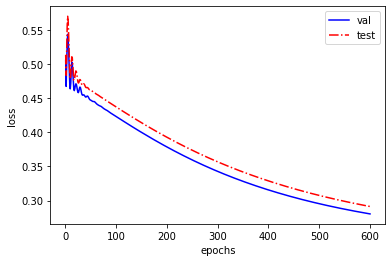

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4962378016, 4962380104]}]
Epoch: 0001 loss_train: 0.6678 acc_train: 0.8150 loss_val: 0.4969 acc_val: 0.8050 time: 0.0025s
Epoch: 0002 loss_train: 0.4869 acc_train: 0.8150 loss_val: 0.4923 acc_val: 0.8050 time: 0.0015s
Epoch: 0003 loss_train: 0.4742 acc_train: 0.8150 loss_val: 0.5348 acc_val: 0.8050 time: 0.0014s
Epoch: 0004 loss_train: 0.5115 acc_train: 0.8150 loss_val: 0.5644 acc_val: 0.8050 time: 0.0013s
Epoch: 0005 loss_train: 0.5384 acc_train: 0.8150 loss_val: 0.5695 acc_val: 0.8050 time: 0.0019s
Epoch: 0006 loss_train: 0.5431 acc_train: 0.8150 loss_val: 0.5547 acc_val: 0.8050 time: 0.0021s
Epoch: 0007 loss_train: 0.5294 acc_train: 0.8150 loss_val: 0.5287 ac

Epoch: 0108 loss_train: 0.4151 acc_train: 0.8150 loss_val: 0.4322 acc_val: 0.8050 time: 0.0019s
Epoch: 0109 loss_train: 0.4146 acc_train: 0.8150 loss_val: 0.4317 acc_val: 0.8050 time: 0.0014s
Epoch: 0110 loss_train: 0.4140 acc_train: 0.8150 loss_val: 0.4312 acc_val: 0.8050 time: 0.0016s
Epoch: 0111 loss_train: 0.4135 acc_train: 0.8150 loss_val: 0.4307 acc_val: 0.8050 time: 0.0019s
Epoch: 0112 loss_train: 0.4129 acc_train: 0.8150 loss_val: 0.4301 acc_val: 0.8050 time: 0.0015s
Epoch: 0113 loss_train: 0.4124 acc_train: 0.8150 loss_val: 0.4296 acc_val: 0.8050 time: 0.0014s
Epoch: 0114 loss_train: 0.4119 acc_train: 0.8150 loss_val: 0.4291 acc_val: 0.8050 time: 0.0016s
Epoch: 0115 loss_train: 0.4113 acc_train: 0.8150 loss_val: 0.4286 acc_val: 0.8050 time: 0.0015s
Epoch: 0116 loss_train: 0.4108 acc_train: 0.8150 loss_val: 0.4281 acc_val: 0.8050 time: 0.0018s
Epoch: 0117 loss_train: 0.4102 acc_train: 0.8150 loss_val: 0.4276 acc_val: 0.8050 time: 0.0014s
Epoch: 0118 loss_train: 0.4097 acc_train

Epoch: 0226 loss_train: 0.3582 acc_train: 0.8150 loss_val: 0.3785 acc_val: 0.8050 time: 0.0018s
Epoch: 0227 loss_train: 0.3578 acc_train: 0.8150 loss_val: 0.3781 acc_val: 0.8050 time: 0.0014s
Epoch: 0228 loss_train: 0.3574 acc_train: 0.8150 loss_val: 0.3777 acc_val: 0.8050 time: 0.0016s
Epoch: 0229 loss_train: 0.3570 acc_train: 0.8150 loss_val: 0.3773 acc_val: 0.8050 time: 0.0016s
Epoch: 0230 loss_train: 0.3566 acc_train: 0.8150 loss_val: 0.3769 acc_val: 0.8050 time: 0.0014s
Epoch: 0231 loss_train: 0.3562 acc_train: 0.8150 loss_val: 0.3765 acc_val: 0.8050 time: 0.0015s
Epoch: 0232 loss_train: 0.3558 acc_train: 0.8150 loss_val: 0.3761 acc_val: 0.8050 time: 0.0014s
Epoch: 0233 loss_train: 0.3554 acc_train: 0.8150 loss_val: 0.3758 acc_val: 0.8050 time: 0.0017s
Epoch: 0234 loss_train: 0.3550 acc_train: 0.8150 loss_val: 0.3754 acc_val: 0.8050 time: 0.0039s
Epoch: 0235 loss_train: 0.3546 acc_train: 0.8150 loss_val: 0.3750 acc_val: 0.8050 time: 0.0016s
Epoch: 0236 loss_train: 0.3542 acc_train

Epoch: 0342 loss_train: 0.3178 acc_train: 0.8300 loss_val: 0.3394 acc_val: 0.8200 time: 0.0020s
Epoch: 0343 loss_train: 0.3175 acc_train: 0.8300 loss_val: 0.3391 acc_val: 0.8200 time: 0.0014s
Epoch: 0344 loss_train: 0.3173 acc_train: 0.8300 loss_val: 0.3388 acc_val: 0.8200 time: 0.0016s
Epoch: 0345 loss_train: 0.3170 acc_train: 0.8300 loss_val: 0.3385 acc_val: 0.8200 time: 0.0015s
Epoch: 0346 loss_train: 0.3167 acc_train: 0.8300 loss_val: 0.3382 acc_val: 0.8200 time: 0.0014s
Epoch: 0347 loss_train: 0.3164 acc_train: 0.8300 loss_val: 0.3380 acc_val: 0.8200 time: 0.0014s
Epoch: 0348 loss_train: 0.3161 acc_train: 0.8300 loss_val: 0.3377 acc_val: 0.8250 time: 0.0014s
Epoch: 0349 loss_train: 0.3158 acc_train: 0.8300 loss_val: 0.3374 acc_val: 0.8250 time: 0.0020s
Epoch: 0350 loss_train: 0.3156 acc_train: 0.8300 loss_val: 0.3371 acc_val: 0.8250 time: 0.0014s
Epoch: 0351 loss_train: 0.3153 acc_train: 0.8300 loss_val: 0.3369 acc_val: 0.8250 time: 0.0017s
Epoch: 0352 loss_train: 0.3150 acc_train

Epoch: 0459 loss_train: 0.2900 acc_train: 0.8550 loss_val: 0.3116 acc_val: 0.8300 time: 0.0016s
Epoch: 0460 loss_train: 0.2898 acc_train: 0.8550 loss_val: 0.3114 acc_val: 0.8300 time: 0.0015s
Epoch: 0461 loss_train: 0.2896 acc_train: 0.8550 loss_val: 0.3112 acc_val: 0.8300 time: 0.0016s
Epoch: 0462 loss_train: 0.2894 acc_train: 0.8550 loss_val: 0.3110 acc_val: 0.8300 time: 0.0014s
Epoch: 0463 loss_train: 0.2893 acc_train: 0.8550 loss_val: 0.3109 acc_val: 0.8300 time: 0.0014s
Epoch: 0464 loss_train: 0.2891 acc_train: 0.8550 loss_val: 0.3107 acc_val: 0.8300 time: 0.0014s
Epoch: 0465 loss_train: 0.2889 acc_train: 0.8550 loss_val: 0.3105 acc_val: 0.8300 time: 0.0021s
Epoch: 0466 loss_train: 0.2887 acc_train: 0.8600 loss_val: 0.3103 acc_val: 0.8300 time: 0.0014s
Epoch: 0467 loss_train: 0.2885 acc_train: 0.8600 loss_val: 0.3101 acc_val: 0.8300 time: 0.0014s
Epoch: 0468 loss_train: 0.2883 acc_train: 0.8600 loss_val: 0.3099 acc_val: 0.8300 time: 0.0019s
Epoch: 0469 loss_train: 0.2881 acc_train

Epoch: 0577 loss_train: 0.2710 acc_train: 0.8850 loss_val: 0.2921 acc_val: 0.8450 time: 0.0019s
Epoch: 0578 loss_train: 0.2709 acc_train: 0.8850 loss_val: 0.2920 acc_val: 0.8450 time: 0.0014s
Epoch: 0579 loss_train: 0.2707 acc_train: 0.8850 loss_val: 0.2918 acc_val: 0.8450 time: 0.0016s
Epoch: 0580 loss_train: 0.2706 acc_train: 0.8850 loss_val: 0.2917 acc_val: 0.8450 time: 0.0015s
Epoch: 0581 loss_train: 0.2705 acc_train: 0.8850 loss_val: 0.2915 acc_val: 0.8450 time: 0.0019s
Epoch: 0582 loss_train: 0.2703 acc_train: 0.8850 loss_val: 0.2914 acc_val: 0.8450 time: 0.0014s
Epoch: 0583 loss_train: 0.2702 acc_train: 0.8850 loss_val: 0.2913 acc_val: 0.8450 time: 0.0013s
Epoch: 0584 loss_train: 0.2701 acc_train: 0.8850 loss_val: 0.2911 acc_val: 0.8450 time: 0.0014s
Epoch: 0585 loss_train: 0.2699 acc_train: 0.8850 loss_val: 0.2910 acc_val: 0.8450 time: 0.0014s
Epoch: 0586 loss_train: 0.2698 acc_train: 0.8850 loss_val: 0.2909 acc_val: 0.8450 time: 0.0021s
Epoch: 0587 loss_train: 0.2697 acc_train

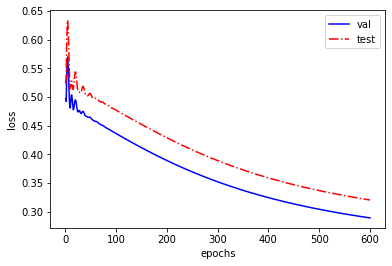

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4923254464, 4962501904]}]
Epoch: 0001 loss_train: 0.6969 acc_train: 0.1950 loss_val: 0.5275 acc_val: 0.7800 time: 0.0027s
Epoch: 0002 loss_train: 0.5037 acc_train: 0.8050 loss_val: 0.5295 acc_val: 0.7800 time: 0.0015s
Epoch: 0003 loss_train: 0.4868 acc_train: 0.8050 loss_val: 0.5811 acc_val: 0.7800 time: 0.0019s
Epoch: 0004 loss_train: 0.5258 acc_train: 0.8050 loss_val: 0.6168 acc_val: 0.7800 time: 0.0014s
Epoch: 0005 loss_train: 0.5554 acc_train: 0.8050 loss_val: 0.6241 acc_val: 0.7800 time: 0.0013s
Epoch: 0006 loss_train: 0.5614 acc_train: 0.8050 loss_val: 0.6079 acc_val: 0.7800 time: 0.0015s
Epoch: 0007 loss_train: 0.5477 acc_train: 0.8050 loss_val: 0.5779 ac

Epoch: 0112 loss_train: 0.4262 acc_train: 0.8050 loss_val: 0.4676 acc_val: 0.7800 time: 0.0022s
Epoch: 0113 loss_train: 0.4256 acc_train: 0.8050 loss_val: 0.4670 acc_val: 0.7800 time: 0.0016s
Epoch: 0114 loss_train: 0.4251 acc_train: 0.8050 loss_val: 0.4665 acc_val: 0.7800 time: 0.0020s
Epoch: 0115 loss_train: 0.4246 acc_train: 0.8050 loss_val: 0.4660 acc_val: 0.7800 time: 0.0017s
Epoch: 0116 loss_train: 0.4240 acc_train: 0.8050 loss_val: 0.4655 acc_val: 0.7800 time: 0.0026s
Epoch: 0117 loss_train: 0.4235 acc_train: 0.8050 loss_val: 0.4651 acc_val: 0.7800 time: 0.0014s
Epoch: 0118 loss_train: 0.4230 acc_train: 0.8050 loss_val: 0.4646 acc_val: 0.7800 time: 0.0014s
Epoch: 0119 loss_train: 0.4224 acc_train: 0.8050 loss_val: 0.4641 acc_val: 0.7800 time: 0.0014s
Epoch: 0120 loss_train: 0.4219 acc_train: 0.8050 loss_val: 0.4636 acc_val: 0.7800 time: 0.0018s
Epoch: 0121 loss_train: 0.4214 acc_train: 0.8050 loss_val: 0.4631 acc_val: 0.7800 time: 0.0014s
Epoch: 0122 loss_train: 0.4208 acc_train

Epoch: 0230 loss_train: 0.3691 acc_train: 0.8050 loss_val: 0.4127 acc_val: 0.7800 time: 0.0017s
Epoch: 0231 loss_train: 0.3687 acc_train: 0.8050 loss_val: 0.4123 acc_val: 0.7800 time: 0.0015s
Epoch: 0232 loss_train: 0.3683 acc_train: 0.8050 loss_val: 0.4119 acc_val: 0.7800 time: 0.0016s
Epoch: 0233 loss_train: 0.3679 acc_train: 0.8050 loss_val: 0.4114 acc_val: 0.7800 time: 0.0015s
Epoch: 0234 loss_train: 0.3674 acc_train: 0.8050 loss_val: 0.4110 acc_val: 0.7800 time: 0.0014s
Epoch: 0235 loss_train: 0.3670 acc_train: 0.8050 loss_val: 0.4106 acc_val: 0.7800 time: 0.0014s
Epoch: 0236 loss_train: 0.3666 acc_train: 0.8050 loss_val: 0.4102 acc_val: 0.7800 time: 0.0014s
Epoch: 0237 loss_train: 0.3662 acc_train: 0.8050 loss_val: 0.4098 acc_val: 0.7800 time: 0.0023s
Epoch: 0238 loss_train: 0.3658 acc_train: 0.8050 loss_val: 0.4094 acc_val: 0.7800 time: 0.0015s
Epoch: 0239 loss_train: 0.3654 acc_train: 0.8050 loss_val: 0.4090 acc_val: 0.7800 time: 0.0015s
Epoch: 0240 loss_train: 0.3649 acc_train

Epoch: 0348 loss_train: 0.3266 acc_train: 0.8250 loss_val: 0.3698 acc_val: 0.8150 time: 0.0021s
Epoch: 0349 loss_train: 0.3263 acc_train: 0.8250 loss_val: 0.3695 acc_val: 0.8150 time: 0.0018s
Epoch: 0350 loss_train: 0.3260 acc_train: 0.8250 loss_val: 0.3692 acc_val: 0.8150 time: 0.0018s
Epoch: 0351 loss_train: 0.3257 acc_train: 0.8250 loss_val: 0.3689 acc_val: 0.8150 time: 0.0016s
Epoch: 0352 loss_train: 0.3254 acc_train: 0.8250 loss_val: 0.3686 acc_val: 0.8150 time: 0.0014s
Epoch: 0353 loss_train: 0.3251 acc_train: 0.8250 loss_val: 0.3682 acc_val: 0.8150 time: 0.0021s
Epoch: 0354 loss_train: 0.3248 acc_train: 0.8250 loss_val: 0.3679 acc_val: 0.8150 time: 0.0014s
Epoch: 0355 loss_train: 0.3245 acc_train: 0.8250 loss_val: 0.3676 acc_val: 0.8150 time: 0.0014s
Epoch: 0356 loss_train: 0.3242 acc_train: 0.8250 loss_val: 0.3673 acc_val: 0.8150 time: 0.0015s
Epoch: 0357 loss_train: 0.3239 acc_train: 0.8300 loss_val: 0.3670 acc_val: 0.8150 time: 0.0014s
Epoch: 0358 loss_train: 0.3236 acc_train

Epoch: 0466 loss_train: 0.2969 acc_train: 0.8450 loss_val: 0.3389 acc_val: 0.8400 time: 0.0021s
Epoch: 0467 loss_train: 0.2967 acc_train: 0.8450 loss_val: 0.3387 acc_val: 0.8400 time: 0.0015s
Epoch: 0468 loss_train: 0.2965 acc_train: 0.8450 loss_val: 0.3385 acc_val: 0.8400 time: 0.0018s
Epoch: 0469 loss_train: 0.2963 acc_train: 0.8450 loss_val: 0.3383 acc_val: 0.8400 time: 0.0018s
Epoch: 0470 loss_train: 0.2961 acc_train: 0.8450 loss_val: 0.3381 acc_val: 0.8400 time: 0.0015s
Epoch: 0471 loss_train: 0.2959 acc_train: 0.8450 loss_val: 0.3378 acc_val: 0.8400 time: 0.0016s
Epoch: 0472 loss_train: 0.2957 acc_train: 0.8450 loss_val: 0.3376 acc_val: 0.8400 time: 0.0014s
Epoch: 0473 loss_train: 0.2955 acc_train: 0.8450 loss_val: 0.3374 acc_val: 0.8400 time: 0.0018s
Epoch: 0474 loss_train: 0.2953 acc_train: 0.8450 loss_val: 0.3372 acc_val: 0.8400 time: 0.0014s
Epoch: 0475 loss_train: 0.2951 acc_train: 0.8450 loss_val: 0.3370 acc_val: 0.8400 time: 0.0015s
Epoch: 0476 loss_train: 0.2949 acc_train

Epoch: 0585 loss_train: 0.2763 acc_train: 0.8650 loss_val: 0.3170 acc_val: 0.8750 time: 0.0019s
Epoch: 0586 loss_train: 0.2761 acc_train: 0.8700 loss_val: 0.3169 acc_val: 0.8750 time: 0.0014s
Epoch: 0587 loss_train: 0.2760 acc_train: 0.8700 loss_val: 0.3167 acc_val: 0.8750 time: 0.0016s
Epoch: 0588 loss_train: 0.2759 acc_train: 0.8700 loss_val: 0.3165 acc_val: 0.8750 time: 0.0015s
Epoch: 0589 loss_train: 0.2757 acc_train: 0.8700 loss_val: 0.3164 acc_val: 0.8750 time: 0.0014s
Epoch: 0590 loss_train: 0.2756 acc_train: 0.8700 loss_val: 0.3162 acc_val: 0.8750 time: 0.0014s
Epoch: 0591 loss_train: 0.2754 acc_train: 0.8700 loss_val: 0.3161 acc_val: 0.8750 time: 0.0014s
Epoch: 0592 loss_train: 0.2753 acc_train: 0.8700 loss_val: 0.3159 acc_val: 0.8750 time: 0.0014s
Epoch: 0593 loss_train: 0.2751 acc_train: 0.8700 loss_val: 0.3158 acc_val: 0.8750 time: 0.0021s
Epoch: 0594 loss_train: 0.2750 acc_train: 0.8700 loss_val: 0.3156 acc_val: 0.8750 time: 0.0014s
Epoch: 0595 loss_train: 0.2749 acc_train

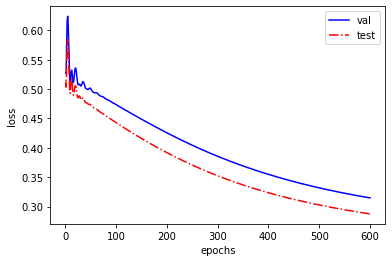

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4962007152, 4961837488]}]
Epoch: 0001 loss_train: 0.7452 acc_train: 0.2200 loss_val: 0.5288 acc_val: 0.7950 time: 0.0027s
Epoch: 0002 loss_train: 0.5405 acc_train: 0.7800 loss_val: 0.4971 acc_val: 0.7950 time: 0.0015s
Epoch: 0003 loss_train: 0.5212 acc_train: 0.7800 loss_val: 0.5318 acc_val: 0.7950 time: 0.0016s
Epoch: 0004 loss_train: 0.5641 acc_train: 0.7800 loss_val: 0.5595 acc_val: 0.7950 time: 0.0014s
Epoch: 0005 loss_train: 0.5958 acc_train: 0.7800 loss_val: 0.5637 acc_val: 0.7950 time: 0.0015s
Epoch: 0006 loss_train: 0.6006 acc_train: 0.7800 loss_val: 0.5487 acc_val: 0.7950 time: 0.0014s
Epoch: 0007 loss_train: 0.5836 acc_train: 0.7800 loss_val: 0.5242 ac

Epoch: 0108 loss_train: 0.4675 acc_train: 0.7800 loss_val: 0.4451 acc_val: 0.7950 time: 0.0021s
Epoch: 0109 loss_train: 0.4670 acc_train: 0.7800 loss_val: 0.4446 acc_val: 0.7950 time: 0.0016s
Epoch: 0110 loss_train: 0.4664 acc_train: 0.7800 loss_val: 0.4441 acc_val: 0.7950 time: 0.0016s
Epoch: 0111 loss_train: 0.4659 acc_train: 0.7800 loss_val: 0.4436 acc_val: 0.7950 time: 0.0015s
Epoch: 0112 loss_train: 0.4654 acc_train: 0.7800 loss_val: 0.4431 acc_val: 0.7950 time: 0.0015s
Epoch: 0113 loss_train: 0.4649 acc_train: 0.7800 loss_val: 0.4426 acc_val: 0.7950 time: 0.0015s
Epoch: 0114 loss_train: 0.4644 acc_train: 0.7800 loss_val: 0.4421 acc_val: 0.7950 time: 0.0042s
Epoch: 0115 loss_train: 0.4639 acc_train: 0.7800 loss_val: 0.4416 acc_val: 0.7950 time: 0.0015s
Epoch: 0116 loss_train: 0.4633 acc_train: 0.7800 loss_val: 0.4410 acc_val: 0.7950 time: 0.0015s
Epoch: 0117 loss_train: 0.4628 acc_train: 0.7800 loss_val: 0.4405 acc_val: 0.7950 time: 0.0015s
Epoch: 0118 loss_train: 0.4623 acc_train

Epoch: 0225 loss_train: 0.4100 acc_train: 0.7800 loss_val: 0.3895 acc_val: 0.7950 time: 0.0021s
Epoch: 0226 loss_train: 0.4095 acc_train: 0.7800 loss_val: 0.3890 acc_val: 0.7950 time: 0.0016s
Epoch: 0227 loss_train: 0.4091 acc_train: 0.7800 loss_val: 0.3886 acc_val: 0.7950 time: 0.0017s
Epoch: 0228 loss_train: 0.4087 acc_train: 0.7800 loss_val: 0.3882 acc_val: 0.7950 time: 0.0017s
Epoch: 0229 loss_train: 0.4082 acc_train: 0.7800 loss_val: 0.3878 acc_val: 0.7950 time: 0.0023s
Epoch: 0230 loss_train: 0.4078 acc_train: 0.7800 loss_val: 0.3873 acc_val: 0.7950 time: 0.0015s
Epoch: 0231 loss_train: 0.4073 acc_train: 0.7800 loss_val: 0.3869 acc_val: 0.7950 time: 0.0016s
Epoch: 0232 loss_train: 0.4069 acc_train: 0.7800 loss_val: 0.3865 acc_val: 0.7950 time: 0.0015s
Epoch: 0233 loss_train: 0.4064 acc_train: 0.7800 loss_val: 0.3861 acc_val: 0.7950 time: 0.0015s
Epoch: 0234 loss_train: 0.4060 acc_train: 0.7850 loss_val: 0.3857 acc_val: 0.7950 time: 0.0015s
Epoch: 0235 loss_train: 0.4056 acc_train

Epoch: 0343 loss_train: 0.3641 acc_train: 0.8100 loss_val: 0.3465 acc_val: 0.8100 time: 0.0022s
Epoch: 0344 loss_train: 0.3637 acc_train: 0.8100 loss_val: 0.3462 acc_val: 0.8100 time: 0.0016s
Epoch: 0345 loss_train: 0.3634 acc_train: 0.8100 loss_val: 0.3459 acc_val: 0.8100 time: 0.0017s
Epoch: 0346 loss_train: 0.3631 acc_train: 0.8100 loss_val: 0.3456 acc_val: 0.8100 time: 0.0024s
Epoch: 0347 loss_train: 0.3627 acc_train: 0.8100 loss_val: 0.3453 acc_val: 0.8100 time: 0.0015s
Epoch: 0348 loss_train: 0.3624 acc_train: 0.8100 loss_val: 0.3450 acc_val: 0.8100 time: 0.0014s
Epoch: 0349 loss_train: 0.3621 acc_train: 0.8100 loss_val: 0.3447 acc_val: 0.8100 time: 0.0014s
Epoch: 0350 loss_train: 0.3618 acc_train: 0.8150 loss_val: 0.3444 acc_val: 0.8100 time: 0.0015s
Epoch: 0351 loss_train: 0.3614 acc_train: 0.8150 loss_val: 0.3441 acc_val: 0.8100 time: 0.0021s
Epoch: 0352 loss_train: 0.3611 acc_train: 0.8150 loss_val: 0.3438 acc_val: 0.8100 time: 0.0014s
Epoch: 0353 loss_train: 0.3608 acc_train

Epoch: 0461 loss_train: 0.3311 acc_train: 0.8550 loss_val: 0.3164 acc_val: 0.8300 time: 0.0020s
Epoch: 0462 loss_train: 0.3309 acc_train: 0.8550 loss_val: 0.3162 acc_val: 0.8300 time: 0.0016s
Epoch: 0463 loss_train: 0.3306 acc_train: 0.8550 loss_val: 0.3160 acc_val: 0.8300 time: 0.0020s
Epoch: 0464 loss_train: 0.3304 acc_train: 0.8550 loss_val: 0.3158 acc_val: 0.8300 time: 0.0016s
Epoch: 0465 loss_train: 0.3302 acc_train: 0.8550 loss_val: 0.3156 acc_val: 0.8300 time: 0.0015s
Epoch: 0466 loss_train: 0.3300 acc_train: 0.8550 loss_val: 0.3154 acc_val: 0.8300 time: 0.0014s
Epoch: 0467 loss_train: 0.3297 acc_train: 0.8550 loss_val: 0.3152 acc_val: 0.8300 time: 0.0016s
Epoch: 0468 loss_train: 0.3295 acc_train: 0.8550 loss_val: 0.3150 acc_val: 0.8300 time: 0.0028s
Epoch: 0469 loss_train: 0.3293 acc_train: 0.8550 loss_val: 0.3148 acc_val: 0.8300 time: 0.0016s
Epoch: 0470 loss_train: 0.3290 acc_train: 0.8550 loss_val: 0.3145 acc_val: 0.8300 time: 0.0015s
Epoch: 0471 loss_train: 0.3288 acc_train

Epoch: 0564 loss_train: 0.3106 acc_train: 0.8650 loss_val: 0.2978 acc_val: 0.8550 time: 0.0020s
Epoch: 0565 loss_train: 0.3104 acc_train: 0.8650 loss_val: 0.2976 acc_val: 0.8550 time: 0.0024s
Epoch: 0566 loss_train: 0.3103 acc_train: 0.8650 loss_val: 0.2975 acc_val: 0.8550 time: 0.0023s
Epoch: 0567 loss_train: 0.3101 acc_train: 0.8650 loss_val: 0.2973 acc_val: 0.8550 time: 0.0019s
Epoch: 0568 loss_train: 0.3099 acc_train: 0.8650 loss_val: 0.2972 acc_val: 0.8550 time: 0.0017s
Epoch: 0569 loss_train: 0.3098 acc_train: 0.8650 loss_val: 0.2970 acc_val: 0.8550 time: 0.0015s
Epoch: 0570 loss_train: 0.3096 acc_train: 0.8650 loss_val: 0.2969 acc_val: 0.8600 time: 0.0015s
Epoch: 0571 loss_train: 0.3094 acc_train: 0.8650 loss_val: 0.2967 acc_val: 0.8600 time: 0.0021s
Epoch: 0572 loss_train: 0.3093 acc_train: 0.8650 loss_val: 0.2966 acc_val: 0.8600 time: 0.0015s
Epoch: 0573 loss_train: 0.3091 acc_train: 0.8650 loss_val: 0.2964 acc_val: 0.8600 time: 0.0015s
Epoch: 0574 loss_train: 0.3089 acc_train

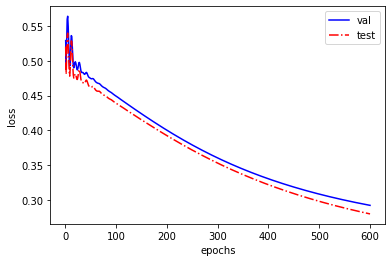

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4962462168, 4962460944]}]
Epoch: 0001 loss_train: 0.6949 acc_train: 0.2200 loss_val: 0.5034 acc_val: 0.8050 time: 0.0014s
Epoch: 0002 loss_train: 0.5133 acc_train: 0.7950 loss_val: 0.4862 acc_val: 0.8050 time: 0.0013s
Epoch: 0003 loss_train: 0.5038 acc_train: 0.7950 loss_val: 0.5216 acc_val: 0.8050 time: 0.0013s
Epoch: 0004 loss_train: 0.5439 acc_train: 0.7950 loss_val: 0.5455 acc_val: 0.8050 time: 0.0012s
Epoch: 0005 loss_train: 0.5699 acc_train: 0.7950 loss_val: 0.5462 acc_val: 0.8050 time: 0.0017s
Epoch: 0006 loss_train: 0.5707 acc_train: 0.7950 loss_val: 0.5295 acc_val: 0.8050 time: 0.0012s
Epoch: 0007 loss_train: 0.5525 acc_train: 0.7950 loss_val: 0.5054 ac

Epoch: 0117 loss_train: 0.4243 acc_train: 0.7950 loss_val: 0.4229 acc_val: 0.8050 time: 0.0016s
Epoch: 0118 loss_train: 0.4237 acc_train: 0.7950 loss_val: 0.4224 acc_val: 0.8050 time: 0.0014s
Epoch: 0119 loss_train: 0.4231 acc_train: 0.7950 loss_val: 0.4219 acc_val: 0.8050 time: 0.0014s
Epoch: 0120 loss_train: 0.4224 acc_train: 0.7950 loss_val: 0.4214 acc_val: 0.8050 time: 0.0014s
Epoch: 0121 loss_train: 0.4218 acc_train: 0.7950 loss_val: 0.4209 acc_val: 0.8050 time: 0.0026s
Epoch: 0122 loss_train: 0.4212 acc_train: 0.7950 loss_val: 0.4204 acc_val: 0.8050 time: 0.0013s
Epoch: 0123 loss_train: 0.4205 acc_train: 0.7950 loss_val: 0.4198 acc_val: 0.8050 time: 0.0012s
Epoch: 0124 loss_train: 0.4199 acc_train: 0.7950 loss_val: 0.4193 acc_val: 0.8050 time: 0.0012s
Epoch: 0125 loss_train: 0.4193 acc_train: 0.7950 loss_val: 0.4188 acc_val: 0.8050 time: 0.0015s
Epoch: 0126 loss_train: 0.4187 acc_train: 0.7950 loss_val: 0.4183 acc_val: 0.8050 time: 0.0013s
Epoch: 0127 loss_train: 0.4181 acc_train

Epoch: 0242 loss_train: 0.3579 acc_train: 0.8000 loss_val: 0.3665 acc_val: 0.8100 time: 0.0019s
Epoch: 0243 loss_train: 0.3575 acc_train: 0.8000 loss_val: 0.3661 acc_val: 0.8100 time: 0.0013s
Epoch: 0244 loss_train: 0.3571 acc_train: 0.8000 loss_val: 0.3657 acc_val: 0.8100 time: 0.0019s
Epoch: 0245 loss_train: 0.3566 acc_train: 0.8000 loss_val: 0.3653 acc_val: 0.8100 time: 0.0024s
Epoch: 0246 loss_train: 0.3562 acc_train: 0.8000 loss_val: 0.3650 acc_val: 0.8100 time: 0.0015s
Epoch: 0247 loss_train: 0.3558 acc_train: 0.8000 loss_val: 0.3646 acc_val: 0.8100 time: 0.0013s
Epoch: 0248 loss_train: 0.3554 acc_train: 0.8000 loss_val: 0.3642 acc_val: 0.8100 time: 0.0013s
Epoch: 0249 loss_train: 0.3550 acc_train: 0.8000 loss_val: 0.3638 acc_val: 0.8100 time: 0.0013s
Epoch: 0250 loss_train: 0.3545 acc_train: 0.8000 loss_val: 0.3634 acc_val: 0.8100 time: 0.0019s
Epoch: 0251 loss_train: 0.3541 acc_train: 0.8000 loss_val: 0.3631 acc_val: 0.8100 time: 0.0013s
Epoch: 0252 loss_train: 0.3537 acc_train

Epoch: 0365 loss_train: 0.3153 acc_train: 0.8250 loss_val: 0.3260 acc_val: 0.8450 time: 0.0018s
Epoch: 0366 loss_train: 0.3150 acc_train: 0.8250 loss_val: 0.3258 acc_val: 0.8450 time: 0.0013s
Epoch: 0367 loss_train: 0.3148 acc_train: 0.8250 loss_val: 0.3255 acc_val: 0.8500 time: 0.0017s
Epoch: 0368 loss_train: 0.3145 acc_train: 0.8250 loss_val: 0.3252 acc_val: 0.8500 time: 0.0018s
Epoch: 0369 loss_train: 0.3142 acc_train: 0.8250 loss_val: 0.3249 acc_val: 0.8500 time: 0.0013s
Epoch: 0370 loss_train: 0.3139 acc_train: 0.8250 loss_val: 0.3247 acc_val: 0.8500 time: 0.0026s
Epoch: 0371 loss_train: 0.3137 acc_train: 0.8250 loss_val: 0.3244 acc_val: 0.8500 time: 0.0013s
Epoch: 0372 loss_train: 0.3134 acc_train: 0.8250 loss_val: 0.3241 acc_val: 0.8500 time: 0.0015s
Epoch: 0373 loss_train: 0.3131 acc_train: 0.8250 loss_val: 0.3238 acc_val: 0.8500 time: 0.0013s
Epoch: 0374 loss_train: 0.3129 acc_train: 0.8300 loss_val: 0.3236 acc_val: 0.8500 time: 0.0013s
Epoch: 0375 loss_train: 0.3126 acc_train

Epoch: 0490 loss_train: 0.2878 acc_train: 0.8700 loss_val: 0.2966 acc_val: 0.8600 time: 0.0018s
Epoch: 0491 loss_train: 0.2876 acc_train: 0.8700 loss_val: 0.2964 acc_val: 0.8600 time: 0.0013s
Epoch: 0492 loss_train: 0.2874 acc_train: 0.8700 loss_val: 0.2962 acc_val: 0.8600 time: 0.0016s
Epoch: 0493 loss_train: 0.2872 acc_train: 0.8700 loss_val: 0.2960 acc_val: 0.8600 time: 0.0017s
Epoch: 0494 loss_train: 0.2871 acc_train: 0.8700 loss_val: 0.2958 acc_val: 0.8600 time: 0.0012s
Epoch: 0495 loss_train: 0.2869 acc_train: 0.8700 loss_val: 0.2956 acc_val: 0.8650 time: 0.0013s
Epoch: 0496 loss_train: 0.2867 acc_train: 0.8700 loss_val: 0.2954 acc_val: 0.8650 time: 0.0014s
Epoch: 0497 loss_train: 0.2866 acc_train: 0.8700 loss_val: 0.2953 acc_val: 0.8650 time: 0.0015s
Epoch: 0498 loss_train: 0.2864 acc_train: 0.8700 loss_val: 0.2951 acc_val: 0.8650 time: 0.0013s
Epoch: 0499 loss_train: 0.2862 acc_train: 0.8700 loss_val: 0.2949 acc_val: 0.8650 time: 0.0027s
Epoch: 0500 loss_train: 0.2860 acc_train

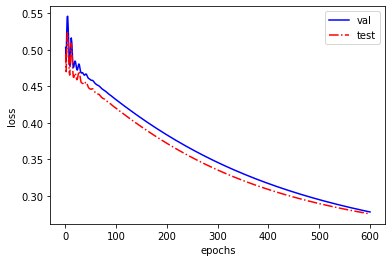

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4964369464, 4962380104]}]
Epoch: 0001 loss_train: 0.6614 acc_train: 0.8050 loss_val: 0.4850 acc_val: 0.8150 time: 0.0026s
Epoch: 0002 loss_train: 0.4949 acc_train: 0.8050 loss_val: 0.4748 acc_val: 0.8150 time: 0.0013s
Epoch: 0003 loss_train: 0.4916 acc_train: 0.8050 loss_val: 0.5087 acc_val: 0.8150 time: 0.0013s
Epoch: 0004 loss_train: 0.5297 acc_train: 0.8050 loss_val: 0.5292 acc_val: 0.8150 time: 0.0012s
Epoch: 0005 loss_train: 0.5520 acc_train: 0.8050 loss_val: 0.5276 acc_val: 0.8150 time: 0.0018s
Epoch: 0006 loss_train: 0.5502 acc_train: 0.8050 loss_val: 0.5103 acc_val: 0.8150 time: 0.0013s
Epoch: 0007 loss_train: 0.5314 acc_train: 0.8050 loss_val: 0.4873 ac

Epoch: 0114 loss_train: 0.4187 acc_train: 0.8050 loss_val: 0.4124 acc_val: 0.8150 time: 0.0015s
Epoch: 0115 loss_train: 0.4181 acc_train: 0.8050 loss_val: 0.4119 acc_val: 0.8150 time: 0.0013s
Epoch: 0116 loss_train: 0.4176 acc_train: 0.8050 loss_val: 0.4114 acc_val: 0.8150 time: 0.0018s
Epoch: 0117 loss_train: 0.4170 acc_train: 0.8050 loss_val: 0.4109 acc_val: 0.8150 time: 0.0017s
Epoch: 0118 loss_train: 0.4164 acc_train: 0.8050 loss_val: 0.4104 acc_val: 0.8150 time: 0.0013s
Epoch: 0119 loss_train: 0.4158 acc_train: 0.8050 loss_val: 0.4099 acc_val: 0.8150 time: 0.0013s
Epoch: 0120 loss_train: 0.4152 acc_train: 0.8050 loss_val: 0.4094 acc_val: 0.8150 time: 0.0014s
Epoch: 0121 loss_train: 0.4146 acc_train: 0.8050 loss_val: 0.4089 acc_val: 0.8150 time: 0.0022s
Epoch: 0122 loss_train: 0.4141 acc_train: 0.8050 loss_val: 0.4083 acc_val: 0.8150 time: 0.0013s
Epoch: 0123 loss_train: 0.4135 acc_train: 0.8050 loss_val: 0.4078 acc_val: 0.8150 time: 0.0013s
Epoch: 0124 loss_train: 0.4129 acc_train

Epoch: 0238 loss_train: 0.3551 acc_train: 0.8050 loss_val: 0.3560 acc_val: 0.8200 time: 0.0022s
Epoch: 0239 loss_train: 0.3547 acc_train: 0.8050 loss_val: 0.3556 acc_val: 0.8200 time: 0.0014s
Epoch: 0240 loss_train: 0.3542 acc_train: 0.8050 loss_val: 0.3552 acc_val: 0.8200 time: 0.0016s
Epoch: 0241 loss_train: 0.3538 acc_train: 0.8050 loss_val: 0.3548 acc_val: 0.8200 time: 0.0018s
Epoch: 0242 loss_train: 0.3534 acc_train: 0.8050 loss_val: 0.3545 acc_val: 0.8200 time: 0.0013s
Epoch: 0243 loss_train: 0.3529 acc_train: 0.8050 loss_val: 0.3541 acc_val: 0.8200 time: 0.0013s
Epoch: 0244 loss_train: 0.3525 acc_train: 0.8050 loss_val: 0.3537 acc_val: 0.8200 time: 0.0031s
Epoch: 0245 loss_train: 0.3521 acc_train: 0.8050 loss_val: 0.3533 acc_val: 0.8200 time: 0.0013s
Epoch: 0246 loss_train: 0.3517 acc_train: 0.8050 loss_val: 0.3529 acc_val: 0.8200 time: 0.0013s
Epoch: 0247 loss_train: 0.3512 acc_train: 0.8100 loss_val: 0.3526 acc_val: 0.8200 time: 0.0013s
Epoch: 0248 loss_train: 0.3508 acc_train

Epoch: 0362 loss_train: 0.3096 acc_train: 0.8500 loss_val: 0.3164 acc_val: 0.8500 time: 0.0021s
Epoch: 0363 loss_train: 0.3093 acc_train: 0.8500 loss_val: 0.3162 acc_val: 0.8500 time: 0.0014s
Epoch: 0364 loss_train: 0.3090 acc_train: 0.8500 loss_val: 0.3159 acc_val: 0.8500 time: 0.0016s
Epoch: 0365 loss_train: 0.3087 acc_train: 0.8500 loss_val: 0.3157 acc_val: 0.8500 time: 0.0018s
Epoch: 0366 loss_train: 0.3084 acc_train: 0.8500 loss_val: 0.3154 acc_val: 0.8500 time: 0.0015s
Epoch: 0367 loss_train: 0.3081 acc_train: 0.8500 loss_val: 0.3152 acc_val: 0.8500 time: 0.0018s
Epoch: 0368 loss_train: 0.3078 acc_train: 0.8500 loss_val: 0.3149 acc_val: 0.8500 time: 0.0014s
Epoch: 0369 loss_train: 0.3075 acc_train: 0.8500 loss_val: 0.3146 acc_val: 0.8500 time: 0.0013s
Epoch: 0370 loss_train: 0.3072 acc_train: 0.8500 loss_val: 0.3144 acc_val: 0.8500 time: 0.0013s
Epoch: 0371 loss_train: 0.3069 acc_train: 0.8500 loss_val: 0.3141 acc_val: 0.8500 time: 0.0014s
Epoch: 0372 loss_train: 0.3066 acc_train

Epoch: 0486 loss_train: 0.2781 acc_train: 0.8800 loss_val: 0.2901 acc_val: 0.8750 time: 0.0017s
Epoch: 0487 loss_train: 0.2778 acc_train: 0.8800 loss_val: 0.2899 acc_val: 0.8750 time: 0.0013s
Epoch: 0488 loss_train: 0.2776 acc_train: 0.8850 loss_val: 0.2897 acc_val: 0.8750 time: 0.0017s
Epoch: 0489 loss_train: 0.2774 acc_train: 0.8850 loss_val: 0.2896 acc_val: 0.8800 time: 0.0018s
Epoch: 0490 loss_train: 0.2772 acc_train: 0.8850 loss_val: 0.2894 acc_val: 0.8800 time: 0.0013s
Epoch: 0491 loss_train: 0.2770 acc_train: 0.8850 loss_val: 0.2892 acc_val: 0.8800 time: 0.0013s
Epoch: 0492 loss_train: 0.2768 acc_train: 0.8900 loss_val: 0.2891 acc_val: 0.8800 time: 0.0013s
Epoch: 0493 loss_train: 0.2766 acc_train: 0.8900 loss_val: 0.2889 acc_val: 0.8800 time: 0.0015s
Epoch: 0494 loss_train: 0.2764 acc_train: 0.8900 loss_val: 0.2887 acc_val: 0.8800 time: 0.0013s
Epoch: 0495 loss_train: 0.2762 acc_train: 0.8900 loss_val: 0.2886 acc_val: 0.8800 time: 0.0023s
Epoch: 0496 loss_train: 0.2760 acc_train

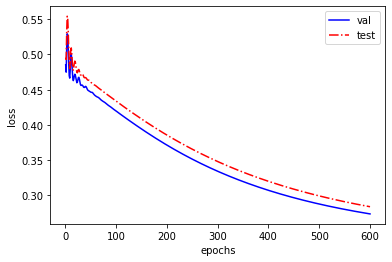

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4923254464, 4924625256]}]
Epoch: 0001 loss_train: 0.7019 acc_train: 0.1850 loss_val: 0.5056 acc_val: 0.8050 time: 0.0032s
Epoch: 0002 loss_train: 0.4967 acc_train: 0.8150 loss_val: 0.4876 acc_val: 0.8050 time: 0.0015s
Epoch: 0003 loss_train: 0.4705 acc_train: 0.8150 loss_val: 0.5298 acc_val: 0.8050 time: 0.0018s
Epoch: 0004 loss_train: 0.5070 acc_train: 0.8150 loss_val: 0.5655 acc_val: 0.8050 time: 0.0013s
Epoch: 0005 loss_train: 0.5395 acc_train: 0.8150 loss_val: 0.5781 acc_val: 0.8050 time: 0.0013s
Epoch: 0006 loss_train: 0.5511 acc_train: 0.8150 loss_val: 0.5695 acc_val: 0.8050 time: 0.0013s
Epoch: 0007 loss_train: 0.5430 acc_train: 0.8150 loss_val: 0.5465 ac

Epoch: 0112 loss_train: 0.4153 acc_train: 0.8150 loss_val: 0.4323 acc_val: 0.8050 time: 0.0019s
Epoch: 0113 loss_train: 0.4148 acc_train: 0.8150 loss_val: 0.4318 acc_val: 0.8050 time: 0.0014s
Epoch: 0114 loss_train: 0.4142 acc_train: 0.8150 loss_val: 0.4313 acc_val: 0.8050 time: 0.0018s
Epoch: 0115 loss_train: 0.4137 acc_train: 0.8150 loss_val: 0.4308 acc_val: 0.8050 time: 0.0019s
Epoch: 0116 loss_train: 0.4132 acc_train: 0.8150 loss_val: 0.4303 acc_val: 0.8050 time: 0.0013s
Epoch: 0117 loss_train: 0.4127 acc_train: 0.8150 loss_val: 0.4298 acc_val: 0.8050 time: 0.0013s
Epoch: 0118 loss_train: 0.4122 acc_train: 0.8150 loss_val: 0.4293 acc_val: 0.8050 time: 0.0021s
Epoch: 0119 loss_train: 0.4117 acc_train: 0.8150 loss_val: 0.4289 acc_val: 0.8050 time: 0.0014s
Epoch: 0120 loss_train: 0.4112 acc_train: 0.8150 loss_val: 0.4284 acc_val: 0.8050 time: 0.0014s
Epoch: 0121 loss_train: 0.4106 acc_train: 0.8150 loss_val: 0.4279 acc_val: 0.8050 time: 0.0014s
Epoch: 0122 loss_train: 0.4101 acc_train

Epoch: 0234 loss_train: 0.3590 acc_train: 0.8150 loss_val: 0.3792 acc_val: 0.8050 time: 0.0019s
Epoch: 0235 loss_train: 0.3586 acc_train: 0.8150 loss_val: 0.3789 acc_val: 0.8050 time: 0.0015s
Epoch: 0236 loss_train: 0.3583 acc_train: 0.8150 loss_val: 0.3785 acc_val: 0.8050 time: 0.0017s
Epoch: 0237 loss_train: 0.3579 acc_train: 0.8150 loss_val: 0.3781 acc_val: 0.8050 time: 0.0021s
Epoch: 0238 loss_train: 0.3575 acc_train: 0.8150 loss_val: 0.3777 acc_val: 0.8050 time: 0.0014s
Epoch: 0239 loss_train: 0.3571 acc_train: 0.8150 loss_val: 0.3774 acc_val: 0.8050 time: 0.0024s
Epoch: 0240 loss_train: 0.3567 acc_train: 0.8150 loss_val: 0.3770 acc_val: 0.8050 time: 0.0014s
Epoch: 0241 loss_train: 0.3563 acc_train: 0.8150 loss_val: 0.3766 acc_val: 0.8050 time: 0.0014s
Epoch: 0242 loss_train: 0.3559 acc_train: 0.8150 loss_val: 0.3762 acc_val: 0.8050 time: 0.0013s
Epoch: 0243 loss_train: 0.3555 acc_train: 0.8150 loss_val: 0.3759 acc_val: 0.8050 time: 0.0014s
Epoch: 0244 loss_train: 0.3551 acc_train

Epoch: 0339 loss_train: 0.3230 acc_train: 0.8300 loss_val: 0.3444 acc_val: 0.8150 time: 0.0021s
Epoch: 0340 loss_train: 0.3227 acc_train: 0.8300 loss_val: 0.3442 acc_val: 0.8150 time: 0.0015s
Epoch: 0341 loss_train: 0.3224 acc_train: 0.8300 loss_val: 0.3439 acc_val: 0.8150 time: 0.0027s
Epoch: 0342 loss_train: 0.3222 acc_train: 0.8300 loss_val: 0.3436 acc_val: 0.8150 time: 0.0019s
Epoch: 0343 loss_train: 0.3219 acc_train: 0.8300 loss_val: 0.3433 acc_val: 0.8150 time: 0.0014s
Epoch: 0344 loss_train: 0.3216 acc_train: 0.8300 loss_val: 0.3430 acc_val: 0.8150 time: 0.0014s
Epoch: 0345 loss_train: 0.3213 acc_train: 0.8300 loss_val: 0.3428 acc_val: 0.8150 time: 0.0015s
Epoch: 0346 loss_train: 0.3210 acc_train: 0.8300 loss_val: 0.3425 acc_val: 0.8150 time: 0.0022s
Epoch: 0347 loss_train: 0.3207 acc_train: 0.8300 loss_val: 0.3422 acc_val: 0.8200 time: 0.0021s
Epoch: 0348 loss_train: 0.3204 acc_train: 0.8300 loss_val: 0.3419 acc_val: 0.8200 time: 0.0015s
Epoch: 0349 loss_train: 0.3202 acc_train

Epoch: 0432 loss_train: 0.2996 acc_train: 0.8450 loss_val: 0.3213 acc_val: 0.8250 time: 0.0028s
Epoch: 0433 loss_train: 0.2994 acc_train: 0.8450 loss_val: 0.3210 acc_val: 0.8250 time: 0.0018s
Epoch: 0434 loss_train: 0.2992 acc_train: 0.8500 loss_val: 0.3208 acc_val: 0.8250 time: 0.0044s
Epoch: 0435 loss_train: 0.2989 acc_train: 0.8500 loss_val: 0.3206 acc_val: 0.8250 time: 0.0101s
Epoch: 0436 loss_train: 0.2987 acc_train: 0.8500 loss_val: 0.3204 acc_val: 0.8250 time: 0.0020s
Epoch: 0437 loss_train: 0.2985 acc_train: 0.8500 loss_val: 0.3202 acc_val: 0.8250 time: 0.0016s
Epoch: 0438 loss_train: 0.2983 acc_train: 0.8500 loss_val: 0.3200 acc_val: 0.8250 time: 0.0015s
Epoch: 0439 loss_train: 0.2981 acc_train: 0.8500 loss_val: 0.3198 acc_val: 0.8250 time: 0.0035s
Epoch: 0440 loss_train: 0.2979 acc_train: 0.8500 loss_val: 0.3196 acc_val: 0.8250 time: 0.0014s
Epoch: 0441 loss_train: 0.2977 acc_train: 0.8500 loss_val: 0.3193 acc_val: 0.8250 time: 0.0014s
Epoch: 0442 loss_train: 0.2975 acc_train

Epoch: 0520 loss_train: 0.2830 acc_train: 0.8650 loss_val: 0.3045 acc_val: 0.8300 time: 0.0057s
Epoch: 0521 loss_train: 0.2828 acc_train: 0.8650 loss_val: 0.3043 acc_val: 0.8300 time: 0.0059s
Epoch: 0522 loss_train: 0.2826 acc_train: 0.8650 loss_val: 0.3041 acc_val: 0.8300 time: 0.0049s
Epoch: 0523 loss_train: 0.2825 acc_train: 0.8650 loss_val: 0.3040 acc_val: 0.8300 time: 0.0055s
Epoch: 0524 loss_train: 0.2823 acc_train: 0.8650 loss_val: 0.3038 acc_val: 0.8300 time: 0.0036s
Epoch: 0525 loss_train: 0.2822 acc_train: 0.8650 loss_val: 0.3036 acc_val: 0.8300 time: 0.0027s
Epoch: 0526 loss_train: 0.2820 acc_train: 0.8650 loss_val: 0.3035 acc_val: 0.8300 time: 0.0025s
Epoch: 0527 loss_train: 0.2818 acc_train: 0.8650 loss_val: 0.3033 acc_val: 0.8300 time: 0.0027s
Epoch: 0528 loss_train: 0.2817 acc_train: 0.8650 loss_val: 0.3031 acc_val: 0.8300 time: 0.0024s
Epoch: 0529 loss_train: 0.2815 acc_train: 0.8650 loss_val: 0.3030 acc_val: 0.8300 time: 0.0035s
Epoch: 0530 loss_train: 0.2814 acc_train

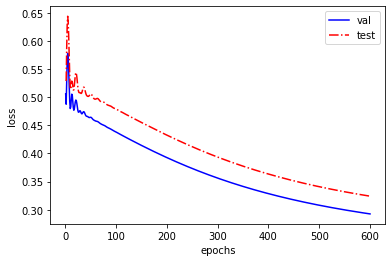

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4923168232, 4926356144]}]
Epoch: 0001 loss_train: 0.7117 acc_train: 0.1950 loss_val: 0.5319 acc_val: 0.7800 time: 0.0034s
Epoch: 0002 loss_train: 0.5092 acc_train: 0.8050 loss_val: 0.5293 acc_val: 0.7800 time: 0.0026s
Epoch: 0003 loss_train: 0.4872 acc_train: 0.8050 loss_val: 0.5810 acc_val: 0.7800 time: 0.0022s
Epoch: 0004 loss_train: 0.5260 acc_train: 0.8050 loss_val: 0.6196 acc_val: 0.7800 time: 0.0015s
Epoch: 0005 loss_train: 0.5577 acc_train: 0.8050 loss_val: 0.6300 acc_val: 0.7800 time: 0.0021s
Epoch: 0006 loss_train: 0.5664 acc_train: 0.8050 loss_val: 0.6164 acc_val: 0.7800 time: 0.0053s
Epoch: 0007 loss_train: 0.5549 acc_train: 0.8050 loss_val: 0.5877 ac

Epoch: 0105 loss_train: 0.4323 acc_train: 0.8050 loss_val: 0.4733 acc_val: 0.7800 time: 0.0033s
Epoch: 0106 loss_train: 0.4318 acc_train: 0.8050 loss_val: 0.4728 acc_val: 0.7800 time: 0.0024s
Epoch: 0107 loss_train: 0.4312 acc_train: 0.8050 loss_val: 0.4724 acc_val: 0.7800 time: 0.0021s
Epoch: 0108 loss_train: 0.4307 acc_train: 0.8050 loss_val: 0.4719 acc_val: 0.7800 time: 0.0028s
Epoch: 0109 loss_train: 0.4301 acc_train: 0.8050 loss_val: 0.4715 acc_val: 0.7800 time: 0.0036s
Epoch: 0110 loss_train: 0.4296 acc_train: 0.8050 loss_val: 0.4710 acc_val: 0.7800 time: 0.0042s
Epoch: 0111 loss_train: 0.4291 acc_train: 0.8050 loss_val: 0.4705 acc_val: 0.7800 time: 0.0019s
Epoch: 0112 loss_train: 0.4285 acc_train: 0.8050 loss_val: 0.4700 acc_val: 0.7800 time: 0.0019s
Epoch: 0113 loss_train: 0.4280 acc_train: 0.8050 loss_val: 0.4695 acc_val: 0.7800 time: 0.0045s
Epoch: 0114 loss_train: 0.4275 acc_train: 0.8050 loss_val: 0.4689 acc_val: 0.7800 time: 0.0027s
Epoch: 0115 loss_train: 0.4269 acc_train

Epoch: 0204 loss_train: 0.3831 acc_train: 0.8050 loss_val: 0.4265 acc_val: 0.7800 time: 0.0071s
Epoch: 0205 loss_train: 0.3826 acc_train: 0.8050 loss_val: 0.4261 acc_val: 0.7800 time: 0.0029s
Epoch: 0206 loss_train: 0.3822 acc_train: 0.8050 loss_val: 0.4257 acc_val: 0.7800 time: 0.0039s
Epoch: 0207 loss_train: 0.3817 acc_train: 0.8050 loss_val: 0.4252 acc_val: 0.7800 time: 0.0028s
Epoch: 0208 loss_train: 0.3813 acc_train: 0.8050 loss_val: 0.4248 acc_val: 0.7800 time: 0.0031s
Epoch: 0209 loss_train: 0.3808 acc_train: 0.8050 loss_val: 0.4244 acc_val: 0.7800 time: 0.0022s
Epoch: 0210 loss_train: 0.3804 acc_train: 0.8050 loss_val: 0.4239 acc_val: 0.7800 time: 0.0038s
Epoch: 0211 loss_train: 0.3799 acc_train: 0.8050 loss_val: 0.4235 acc_val: 0.7800 time: 0.0029s
Epoch: 0212 loss_train: 0.3795 acc_train: 0.8050 loss_val: 0.4230 acc_val: 0.7800 time: 0.0029s
Epoch: 0213 loss_train: 0.3791 acc_train: 0.8050 loss_val: 0.4226 acc_val: 0.7800 time: 0.0026s
Epoch: 0214 loss_train: 0.3786 acc_train

Epoch: 0298 loss_train: 0.3453 acc_train: 0.8050 loss_val: 0.3890 acc_val: 0.7900 time: 0.0022s
Epoch: 0299 loss_train: 0.3450 acc_train: 0.8050 loss_val: 0.3886 acc_val: 0.7900 time: 0.0021s
Epoch: 0300 loss_train: 0.3446 acc_train: 0.8050 loss_val: 0.3883 acc_val: 0.7900 time: 0.0016s
Epoch: 0301 loss_train: 0.3443 acc_train: 0.8100 loss_val: 0.3879 acc_val: 0.7900 time: 0.0028s
Epoch: 0302 loss_train: 0.3439 acc_train: 0.8100 loss_val: 0.3876 acc_val: 0.7900 time: 0.0041s
Epoch: 0303 loss_train: 0.3436 acc_train: 0.8100 loss_val: 0.3872 acc_val: 0.7900 time: 0.0017s
Epoch: 0304 loss_train: 0.3432 acc_train: 0.8100 loss_val: 0.3869 acc_val: 0.7900 time: 0.0018s
Epoch: 0305 loss_train: 0.3429 acc_train: 0.8100 loss_val: 0.3865 acc_val: 0.7900 time: 0.0023s
Epoch: 0306 loss_train: 0.3425 acc_train: 0.8100 loss_val: 0.3862 acc_val: 0.7900 time: 0.0017s
Epoch: 0307 loss_train: 0.3422 acc_train: 0.8100 loss_val: 0.3858 acc_val: 0.7900 time: 0.0021s
Epoch: 0308 loss_train: 0.3419 acc_train

Epoch: 0387 loss_train: 0.3178 acc_train: 0.8300 loss_val: 0.3608 acc_val: 0.8150 time: 0.0023s
Epoch: 0388 loss_train: 0.3175 acc_train: 0.8300 loss_val: 0.3605 acc_val: 0.8150 time: 0.0098s
Epoch: 0389 loss_train: 0.3172 acc_train: 0.8300 loss_val: 0.3602 acc_val: 0.8150 time: 0.0020s
Epoch: 0390 loss_train: 0.3170 acc_train: 0.8300 loss_val: 0.3599 acc_val: 0.8150 time: 0.0020s
Epoch: 0391 loss_train: 0.3167 acc_train: 0.8300 loss_val: 0.3597 acc_val: 0.8150 time: 0.0043s
Epoch: 0392 loss_train: 0.3164 acc_train: 0.8300 loss_val: 0.3594 acc_val: 0.8150 time: 0.0050s
Epoch: 0393 loss_train: 0.3162 acc_train: 0.8300 loss_val: 0.3591 acc_val: 0.8150 time: 0.0046s
Epoch: 0394 loss_train: 0.3159 acc_train: 0.8300 loss_val: 0.3588 acc_val: 0.8150 time: 0.0018s
Epoch: 0395 loss_train: 0.3157 acc_train: 0.8300 loss_val: 0.3586 acc_val: 0.8150 time: 0.0027s
Epoch: 0396 loss_train: 0.3154 acc_train: 0.8350 loss_val: 0.3583 acc_val: 0.8150 time: 0.0019s
Epoch: 0397 loss_train: 0.3151 acc_train

Epoch: 0484 loss_train: 0.2952 acc_train: 0.8450 loss_val: 0.3372 acc_val: 0.8400 time: 0.0022s
Epoch: 0485 loss_train: 0.2950 acc_train: 0.8450 loss_val: 0.3370 acc_val: 0.8400 time: 0.0046s
Epoch: 0486 loss_train: 0.2948 acc_train: 0.8450 loss_val: 0.3368 acc_val: 0.8400 time: 0.0034s
Epoch: 0487 loss_train: 0.2946 acc_train: 0.8450 loss_val: 0.3366 acc_val: 0.8400 time: 0.0049s
Epoch: 0488 loss_train: 0.2944 acc_train: 0.8500 loss_val: 0.3364 acc_val: 0.8400 time: 0.0016s
Epoch: 0489 loss_train: 0.2942 acc_train: 0.8500 loss_val: 0.3362 acc_val: 0.8400 time: 0.0033s
Epoch: 0490 loss_train: 0.2940 acc_train: 0.8500 loss_val: 0.3359 acc_val: 0.8400 time: 0.0032s
Epoch: 0491 loss_train: 0.2939 acc_train: 0.8500 loss_val: 0.3357 acc_val: 0.8400 time: 0.0020s
Epoch: 0492 loss_train: 0.2937 acc_train: 0.8500 loss_val: 0.3355 acc_val: 0.8400 time: 0.0073s
Epoch: 0493 loss_train: 0.2935 acc_train: 0.8500 loss_val: 0.3353 acc_val: 0.8400 time: 0.0031s
Epoch: 0494 loss_train: 0.2933 acc_train

Epoch: 0583 loss_train: 0.2782 acc_train: 0.8650 loss_val: 0.3191 acc_val: 0.8750 time: 0.0056s
Epoch: 0584 loss_train: 0.2781 acc_train: 0.8650 loss_val: 0.3189 acc_val: 0.8750 time: 0.0032s
Epoch: 0585 loss_train: 0.2779 acc_train: 0.8650 loss_val: 0.3188 acc_val: 0.8750 time: 0.0019s
Epoch: 0586 loss_train: 0.2778 acc_train: 0.8650 loss_val: 0.3186 acc_val: 0.8750 time: 0.0084s
Epoch: 0587 loss_train: 0.2776 acc_train: 0.8650 loss_val: 0.3185 acc_val: 0.8750 time: 0.0032s
Epoch: 0588 loss_train: 0.2775 acc_train: 0.8650 loss_val: 0.3183 acc_val: 0.8750 time: 0.0015s
Epoch: 0589 loss_train: 0.2773 acc_train: 0.8650 loss_val: 0.3182 acc_val: 0.8750 time: 0.0027s
Epoch: 0590 loss_train: 0.2772 acc_train: 0.8650 loss_val: 0.3180 acc_val: 0.8750 time: 0.0023s
Epoch: 0591 loss_train: 0.2771 acc_train: 0.8650 loss_val: 0.3179 acc_val: 0.8750 time: 0.0034s
Epoch: 0592 loss_train: 0.2769 acc_train: 0.8650 loss_val: 0.3177 acc_val: 0.8750 time: 0.0087s
Epoch: 0593 loss_train: 0.2768 acc_train

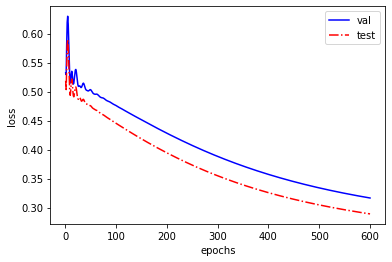

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4948223680, 4948223248]}]
Epoch: 0001 loss_train: 0.6979 acc_train: 0.2200 loss_val: 0.5136 acc_val: 0.7950 time: 0.0055s
Epoch: 0002 loss_train: 0.5278 acc_train: 0.7800 loss_val: 0.5017 acc_val: 0.7950 time: 0.0017s
Epoch: 0003 loss_train: 0.5278 acc_train: 0.7800 loss_val: 0.5361 acc_val: 0.7950 time: 0.0023s
Epoch: 0004 loss_train: 0.5693 acc_train: 0.7800 loss_val: 0.5543 acc_val: 0.7950 time: 0.0053s
Epoch: 0005 loss_train: 0.5902 acc_train: 0.7800 loss_val: 0.5486 acc_val: 0.7950 time: 0.0016s
Epoch: 0006 loss_train: 0.5838 acc_train: 0.7800 loss_val: 0.5281 acc_val: 0.7950 time: 0.0018s
Epoch: 0007 loss_train: 0.5603 acc_train: 0.7800 loss_val: 0.5053 ac

Epoch: 0092 loss_train: 0.4728 acc_train: 0.7800 loss_val: 0.4501 acc_val: 0.7950 time: 0.0037s
Epoch: 0093 loss_train: 0.4722 acc_train: 0.7800 loss_val: 0.4496 acc_val: 0.7950 time: 0.0045s
Epoch: 0094 loss_train: 0.4717 acc_train: 0.7800 loss_val: 0.4490 acc_val: 0.7950 time: 0.0072s
Epoch: 0095 loss_train: 0.4711 acc_train: 0.7800 loss_val: 0.4486 acc_val: 0.7950 time: 0.0028s
Epoch: 0096 loss_train: 0.4706 acc_train: 0.7800 loss_val: 0.4481 acc_val: 0.7950 time: 0.0039s
Epoch: 0097 loss_train: 0.4700 acc_train: 0.7800 loss_val: 0.4476 acc_val: 0.7950 time: 0.0074s
Epoch: 0098 loss_train: 0.4695 acc_train: 0.7800 loss_val: 0.4470 acc_val: 0.7950 time: 0.0050s
Epoch: 0099 loss_train: 0.4689 acc_train: 0.7800 loss_val: 0.4464 acc_val: 0.7950 time: 0.0050s
Epoch: 0100 loss_train: 0.4683 acc_train: 0.7800 loss_val: 0.4458 acc_val: 0.7950 time: 0.0033s
Epoch: 0101 loss_train: 0.4678 acc_train: 0.7800 loss_val: 0.4452 acc_val: 0.7950 time: 0.0026s
Epoch: 0102 loss_train: 0.4672 acc_train

Epoch: 0192 loss_train: 0.4193 acc_train: 0.7800 loss_val: 0.3982 acc_val: 0.7950 time: 0.0015s
Epoch: 0193 loss_train: 0.4188 acc_train: 0.7800 loss_val: 0.3977 acc_val: 0.7950 time: 0.0016s
Epoch: 0194 loss_train: 0.4183 acc_train: 0.7800 loss_val: 0.3972 acc_val: 0.7950 time: 0.0017s
Epoch: 0195 loss_train: 0.4178 acc_train: 0.7800 loss_val: 0.3967 acc_val: 0.7950 time: 0.0017s
Epoch: 0196 loss_train: 0.4173 acc_train: 0.7800 loss_val: 0.3963 acc_val: 0.7950 time: 0.0016s
Epoch: 0197 loss_train: 0.4168 acc_train: 0.7800 loss_val: 0.3958 acc_val: 0.7950 time: 0.0015s
Epoch: 0198 loss_train: 0.4163 acc_train: 0.7800 loss_val: 0.3953 acc_val: 0.7950 time: 0.0015s
Epoch: 0199 loss_train: 0.4158 acc_train: 0.7800 loss_val: 0.3949 acc_val: 0.7950 time: 0.0015s
Epoch: 0200 loss_train: 0.4153 acc_train: 0.7800 loss_val: 0.3944 acc_val: 0.7950 time: 0.0015s
Epoch: 0201 loss_train: 0.4148 acc_train: 0.7800 loss_val: 0.3939 acc_val: 0.7950 time: 0.0016s
Epoch: 0202 loss_train: 0.4143 acc_train

Epoch: 0294 loss_train: 0.3742 acc_train: 0.8000 loss_val: 0.3559 acc_val: 0.8100 time: 0.0030s
Epoch: 0295 loss_train: 0.3738 acc_train: 0.8000 loss_val: 0.3555 acc_val: 0.8100 time: 0.0020s
Epoch: 0296 loss_train: 0.3735 acc_train: 0.8000 loss_val: 0.3552 acc_val: 0.8100 time: 0.0024s
Epoch: 0297 loss_train: 0.3731 acc_train: 0.8000 loss_val: 0.3548 acc_val: 0.8100 time: 0.0031s
Epoch: 0298 loss_train: 0.3727 acc_train: 0.8000 loss_val: 0.3545 acc_val: 0.8100 time: 0.0016s
Epoch: 0299 loss_train: 0.3723 acc_train: 0.8000 loss_val: 0.3541 acc_val: 0.8100 time: 0.0033s
Epoch: 0300 loss_train: 0.3719 acc_train: 0.8000 loss_val: 0.3538 acc_val: 0.8100 time: 0.0024s
Epoch: 0301 loss_train: 0.3716 acc_train: 0.8000 loss_val: 0.3534 acc_val: 0.8100 time: 0.0016s
Epoch: 0302 loss_train: 0.3712 acc_train: 0.8000 loss_val: 0.3531 acc_val: 0.8100 time: 0.0033s
Epoch: 0303 loss_train: 0.3708 acc_train: 0.8000 loss_val: 0.3527 acc_val: 0.8100 time: 0.0019s
Epoch: 0304 loss_train: 0.3704 acc_train

Epoch: 0397 loss_train: 0.3404 acc_train: 0.8200 loss_val: 0.3249 acc_val: 0.8250 time: 0.0062s
Epoch: 0398 loss_train: 0.3401 acc_train: 0.8250 loss_val: 0.3246 acc_val: 0.8250 time: 0.0064s
Epoch: 0399 loss_train: 0.3399 acc_train: 0.8300 loss_val: 0.3244 acc_val: 0.8250 time: 0.0042s
Epoch: 0400 loss_train: 0.3396 acc_train: 0.8350 loss_val: 0.3241 acc_val: 0.8250 time: 0.0127s
Epoch: 0401 loss_train: 0.3393 acc_train: 0.8350 loss_val: 0.3239 acc_val: 0.8250 time: 0.0068s
Epoch: 0402 loss_train: 0.3390 acc_train: 0.8350 loss_val: 0.3236 acc_val: 0.8250 time: 0.0015s
Epoch: 0403 loss_train: 0.3388 acc_train: 0.8350 loss_val: 0.3234 acc_val: 0.8250 time: 0.0015s
Epoch: 0404 loss_train: 0.3385 acc_train: 0.8350 loss_val: 0.3231 acc_val: 0.8250 time: 0.0018s
Epoch: 0405 loss_train: 0.3382 acc_train: 0.8350 loss_val: 0.3229 acc_val: 0.8250 time: 0.0015s
Epoch: 0406 loss_train: 0.3380 acc_train: 0.8350 loss_val: 0.3226 acc_val: 0.8250 time: 0.0017s
Epoch: 0407 loss_train: 0.3377 acc_train

Epoch: 0498 loss_train: 0.3166 acc_train: 0.8600 loss_val: 0.3032 acc_val: 0.8550 time: 0.0066s
Epoch: 0499 loss_train: 0.3164 acc_train: 0.8600 loss_val: 0.3030 acc_val: 0.8550 time: 0.0113s
Epoch: 0500 loss_train: 0.3162 acc_train: 0.8600 loss_val: 0.3028 acc_val: 0.8550 time: 0.0054s
Epoch: 0501 loss_train: 0.3160 acc_train: 0.8600 loss_val: 0.3027 acc_val: 0.8550 time: 0.0044s
Epoch: 0502 loss_train: 0.3158 acc_train: 0.8600 loss_val: 0.3025 acc_val: 0.8550 time: 0.0036s
Epoch: 0503 loss_train: 0.3156 acc_train: 0.8600 loss_val: 0.3023 acc_val: 0.8550 time: 0.0056s
Epoch: 0504 loss_train: 0.3154 acc_train: 0.8600 loss_val: 0.3021 acc_val: 0.8550 time: 0.0022s
Epoch: 0505 loss_train: 0.3152 acc_train: 0.8600 loss_val: 0.3019 acc_val: 0.8550 time: 0.0059s
Epoch: 0506 loss_train: 0.3150 acc_train: 0.8600 loss_val: 0.3018 acc_val: 0.8550 time: 0.0023s
Epoch: 0507 loss_train: 0.3148 acc_train: 0.8600 loss_val: 0.3016 acc_val: 0.8550 time: 0.0026s
Epoch: 0508 loss_train: 0.3146 acc_train

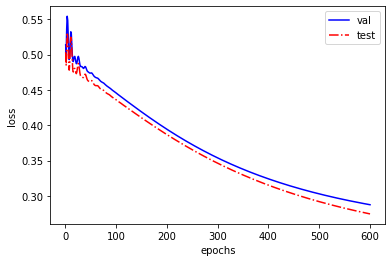

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4923168232, 4924534928]}]
Epoch: 0001 loss_train: 0.7255 acc_train: 0.2050 loss_val: 0.5125 acc_val: 0.8050 time: 0.0026s
Epoch: 0002 loss_train: 0.5215 acc_train: 0.7950 loss_val: 0.4826 acc_val: 0.8050 time: 0.0015s
Epoch: 0003 loss_train: 0.4994 acc_train: 0.7950 loss_val: 0.5176 acc_val: 0.8050 time: 0.0014s
Epoch: 0004 loss_train: 0.5394 acc_train: 0.7950 loss_val: 0.5471 acc_val: 0.8050 time: 0.0012s
Epoch: 0005 loss_train: 0.5714 acc_train: 0.7950 loss_val: 0.5542 acc_val: 0.8050 time: 0.0024s
Epoch: 0006 loss_train: 0.5791 acc_train: 0.7950 loss_val: 0.5420 acc_val: 0.8050 time: 0.0013s
Epoch: 0007 loss_train: 0.5659 acc_train: 0.7950 loss_val: 0.5187 ac

Epoch: 0128 loss_train: 0.4200 acc_train: 0.7950 loss_val: 0.4193 acc_val: 0.8050 time: 0.0142s
Epoch: 0129 loss_train: 0.4194 acc_train: 0.7950 loss_val: 0.4188 acc_val: 0.8050 time: 0.0051s
Epoch: 0130 loss_train: 0.4188 acc_train: 0.7950 loss_val: 0.4183 acc_val: 0.8050 time: 0.0042s
Epoch: 0131 loss_train: 0.4182 acc_train: 0.7950 loss_val: 0.4178 acc_val: 0.8050 time: 0.0034s
Epoch: 0132 loss_train: 0.4176 acc_train: 0.7950 loss_val: 0.4173 acc_val: 0.8050 time: 0.0142s
Epoch: 0133 loss_train: 0.4170 acc_train: 0.7950 loss_val: 0.4168 acc_val: 0.8050 time: 0.0029s
Epoch: 0134 loss_train: 0.4164 acc_train: 0.7950 loss_val: 0.4164 acc_val: 0.8050 time: 0.0090s
Epoch: 0135 loss_train: 0.4158 acc_train: 0.7950 loss_val: 0.4159 acc_val: 0.8050 time: 0.0048s
Epoch: 0136 loss_train: 0.4152 acc_train: 0.7950 loss_val: 0.4154 acc_val: 0.8050 time: 0.0067s
Epoch: 0137 loss_train: 0.4146 acc_train: 0.7950 loss_val: 0.4149 acc_val: 0.8050 time: 0.0027s
Epoch: 0138 loss_train: 0.4141 acc_train

Epoch: 0229 loss_train: 0.3675 acc_train: 0.7950 loss_val: 0.3750 acc_val: 0.8100 time: 0.0029s
Epoch: 0230 loss_train: 0.3670 acc_train: 0.7950 loss_val: 0.3746 acc_val: 0.8100 time: 0.0029s
Epoch: 0231 loss_train: 0.3666 acc_train: 0.7950 loss_val: 0.3742 acc_val: 0.8100 time: 0.0020s
Epoch: 0232 loss_train: 0.3662 acc_train: 0.7950 loss_val: 0.3738 acc_val: 0.8100 time: 0.0088s
Epoch: 0233 loss_train: 0.3657 acc_train: 0.8000 loss_val: 0.3734 acc_val: 0.8100 time: 0.0051s
Epoch: 0234 loss_train: 0.3653 acc_train: 0.8000 loss_val: 0.3730 acc_val: 0.8100 time: 0.0022s
Epoch: 0235 loss_train: 0.3649 acc_train: 0.8000 loss_val: 0.3727 acc_val: 0.8100 time: 0.0052s
Epoch: 0236 loss_train: 0.3644 acc_train: 0.8000 loss_val: 0.3723 acc_val: 0.8100 time: 0.0024s
Epoch: 0237 loss_train: 0.3640 acc_train: 0.8000 loss_val: 0.3719 acc_val: 0.8100 time: 0.0029s
Epoch: 0238 loss_train: 0.3636 acc_train: 0.8000 loss_val: 0.3715 acc_val: 0.8100 time: 0.0040s
Epoch: 0239 loss_train: 0.3631 acc_train

Epoch: 0333 loss_train: 0.3286 acc_train: 0.8100 loss_val: 0.3393 acc_val: 0.8400 time: 0.0053s
Epoch: 0334 loss_train: 0.3283 acc_train: 0.8100 loss_val: 0.3390 acc_val: 0.8400 time: 0.0016s
Epoch: 0335 loss_train: 0.3280 acc_train: 0.8100 loss_val: 0.3387 acc_val: 0.8400 time: 0.0015s
Epoch: 0336 loss_train: 0.3277 acc_train: 0.8100 loss_val: 0.3384 acc_val: 0.8400 time: 0.0013s
Epoch: 0337 loss_train: 0.3274 acc_train: 0.8100 loss_val: 0.3381 acc_val: 0.8400 time: 0.0014s
Epoch: 0338 loss_train: 0.3271 acc_train: 0.8100 loss_val: 0.3378 acc_val: 0.8400 time: 0.0012s
Epoch: 0339 loss_train: 0.3268 acc_train: 0.8100 loss_val: 0.3375 acc_val: 0.8400 time: 0.0013s
Epoch: 0340 loss_train: 0.3265 acc_train: 0.8150 loss_val: 0.3372 acc_val: 0.8400 time: 0.0015s
Epoch: 0341 loss_train: 0.3262 acc_train: 0.8150 loss_val: 0.3369 acc_val: 0.8400 time: 0.0012s
Epoch: 0342 loss_train: 0.3259 acc_train: 0.8150 loss_val: 0.3366 acc_val: 0.8400 time: 0.0014s
Epoch: 0343 loss_train: 0.3256 acc_train

Epoch: 0469 loss_train: 0.2951 acc_train: 0.8600 loss_val: 0.3048 acc_val: 0.8550 time: 0.0020s
Epoch: 0470 loss_train: 0.2949 acc_train: 0.8600 loss_val: 0.3046 acc_val: 0.8550 time: 0.0013s
Epoch: 0471 loss_train: 0.2947 acc_train: 0.8600 loss_val: 0.3044 acc_val: 0.8550 time: 0.0014s
Epoch: 0472 loss_train: 0.2946 acc_train: 0.8600 loss_val: 0.3042 acc_val: 0.8550 time: 0.0013s
Epoch: 0473 loss_train: 0.2944 acc_train: 0.8600 loss_val: 0.3040 acc_val: 0.8550 time: 0.0023s
Epoch: 0474 loss_train: 0.2942 acc_train: 0.8600 loss_val: 0.3038 acc_val: 0.8550 time: 0.0015s
Epoch: 0475 loss_train: 0.2940 acc_train: 0.8600 loss_val: 0.3036 acc_val: 0.8550 time: 0.0014s
Epoch: 0476 loss_train: 0.2938 acc_train: 0.8600 loss_val: 0.3034 acc_val: 0.8550 time: 0.0013s
Epoch: 0477 loss_train: 0.2936 acc_train: 0.8600 loss_val: 0.3032 acc_val: 0.8550 time: 0.0014s
Epoch: 0478 loss_train: 0.2934 acc_train: 0.8600 loss_val: 0.3029 acc_val: 0.8550 time: 0.0014s
Epoch: 0479 loss_train: 0.2932 acc_train

Epoch: 0563 loss_train: 0.2796 acc_train: 0.8700 loss_val: 0.2872 acc_val: 0.8650 time: 0.0042s
Epoch: 0564 loss_train: 0.2794 acc_train: 0.8700 loss_val: 0.2870 acc_val: 0.8650 time: 0.0025s
Epoch: 0565 loss_train: 0.2793 acc_train: 0.8700 loss_val: 0.2869 acc_val: 0.8650 time: 0.0016s
Epoch: 0566 loss_train: 0.2791 acc_train: 0.8700 loss_val: 0.2867 acc_val: 0.8650 time: 0.0019s
Epoch: 0567 loss_train: 0.2790 acc_train: 0.8700 loss_val: 0.2865 acc_val: 0.8650 time: 0.0036s
Epoch: 0568 loss_train: 0.2789 acc_train: 0.8700 loss_val: 0.2864 acc_val: 0.8650 time: 0.0060s
Epoch: 0569 loss_train: 0.2787 acc_train: 0.8700 loss_val: 0.2862 acc_val: 0.8650 time: 0.0033s
Epoch: 0570 loss_train: 0.2786 acc_train: 0.8700 loss_val: 0.2860 acc_val: 0.8650 time: 0.0023s
Epoch: 0571 loss_train: 0.2784 acc_train: 0.8700 loss_val: 0.2859 acc_val: 0.8650 time: 0.0024s
Epoch: 0572 loss_train: 0.2783 acc_train: 0.8700 loss_val: 0.2857 acc_val: 0.8650 time: 0.0015s
Epoch: 0573 loss_train: 0.2782 acc_train

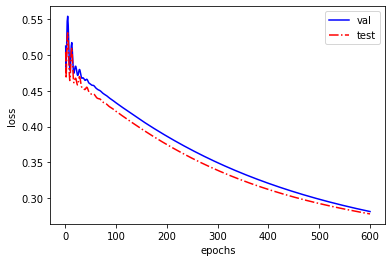

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4926499144, 4917523656]}]
Epoch: 0001 loss_train: 0.6555 acc_train: 0.8050 loss_val: 0.4838 acc_val: 0.8150 time: 0.0026s
Epoch: 0002 loss_train: 0.4938 acc_train: 0.8050 loss_val: 0.4760 acc_val: 0.8150 time: 0.0056s
Epoch: 0003 loss_train: 0.4929 acc_train: 0.8050 loss_val: 0.5097 acc_val: 0.8150 time: 0.0051s
Epoch: 0004 loss_train: 0.5307 acc_train: 0.8050 loss_val: 0.5288 acc_val: 0.8150 time: 0.0014s
Epoch: 0005 loss_train: 0.5515 acc_train: 0.8050 loss_val: 0.5258 acc_val: 0.8150 time: 0.0021s
Epoch: 0006 loss_train: 0.5482 acc_train: 0.8050 loss_val: 0.5077 acc_val: 0.8150 time: 0.0028s
Epoch: 0007 loss_train: 0.5285 acc_train: 0.8050 loss_val: 0.4850 ac

Epoch: 0104 loss_train: 0.4245 acc_train: 0.8050 loss_val: 0.4174 acc_val: 0.8150 time: 0.0032s
Epoch: 0105 loss_train: 0.4239 acc_train: 0.8050 loss_val: 0.4169 acc_val: 0.8150 time: 0.0048s
Epoch: 0106 loss_train: 0.4233 acc_train: 0.8050 loss_val: 0.4164 acc_val: 0.8150 time: 0.0019s
Epoch: 0107 loss_train: 0.4227 acc_train: 0.8050 loss_val: 0.4159 acc_val: 0.8150 time: 0.0061s
Epoch: 0108 loss_train: 0.4221 acc_train: 0.8050 loss_val: 0.4154 acc_val: 0.8150 time: 0.0017s
Epoch: 0109 loss_train: 0.4215 acc_train: 0.8050 loss_val: 0.4149 acc_val: 0.8150 time: 0.0043s
Epoch: 0110 loss_train: 0.4209 acc_train: 0.8050 loss_val: 0.4144 acc_val: 0.8150 time: 0.0016s
Epoch: 0111 loss_train: 0.4203 acc_train: 0.8050 loss_val: 0.4138 acc_val: 0.8150 time: 0.0015s
Epoch: 0112 loss_train: 0.4197 acc_train: 0.8050 loss_val: 0.4133 acc_val: 0.8150 time: 0.0013s
Epoch: 0113 loss_train: 0.4191 acc_train: 0.8050 loss_val: 0.4127 acc_val: 0.8150 time: 0.0015s
Epoch: 0114 loss_train: 0.4185 acc_train

Epoch: 0199 loss_train: 0.3724 acc_train: 0.8050 loss_val: 0.3713 acc_val: 0.8150 time: 0.0029s
Epoch: 0200 loss_train: 0.3719 acc_train: 0.8050 loss_val: 0.3709 acc_val: 0.8150 time: 0.0021s
Epoch: 0201 loss_train: 0.3714 acc_train: 0.8050 loss_val: 0.3704 acc_val: 0.8150 time: 0.0021s
Epoch: 0202 loss_train: 0.3709 acc_train: 0.8050 loss_val: 0.3700 acc_val: 0.8150 time: 0.0020s
Epoch: 0203 loss_train: 0.3704 acc_train: 0.8050 loss_val: 0.3696 acc_val: 0.8150 time: 0.0014s
Epoch: 0204 loss_train: 0.3700 acc_train: 0.8050 loss_val: 0.3691 acc_val: 0.8150 time: 0.0016s
Epoch: 0205 loss_train: 0.3695 acc_train: 0.8050 loss_val: 0.3687 acc_val: 0.8150 time: 0.0016s
Epoch: 0206 loss_train: 0.3690 acc_train: 0.8050 loss_val: 0.3683 acc_val: 0.8150 time: 0.0023s
Epoch: 0207 loss_train: 0.3685 acc_train: 0.8050 loss_val: 0.3679 acc_val: 0.8150 time: 0.0021s
Epoch: 0208 loss_train: 0.3681 acc_train: 0.8050 loss_val: 0.3674 acc_val: 0.8150 time: 0.0023s
Epoch: 0209 loss_train: 0.3676 acc_train

Epoch: 0290 loss_train: 0.3332 acc_train: 0.8200 loss_val: 0.3367 acc_val: 0.8300 time: 0.0023s
Epoch: 0291 loss_train: 0.3328 acc_train: 0.8200 loss_val: 0.3364 acc_val: 0.8300 time: 0.0029s
Epoch: 0292 loss_train: 0.3324 acc_train: 0.8200 loss_val: 0.3361 acc_val: 0.8300 time: 0.0059s
Epoch: 0293 loss_train: 0.3321 acc_train: 0.8200 loss_val: 0.3358 acc_val: 0.8300 time: 0.0053s
Epoch: 0294 loss_train: 0.3317 acc_train: 0.8200 loss_val: 0.3354 acc_val: 0.8300 time: 0.0035s
Epoch: 0295 loss_train: 0.3313 acc_train: 0.8200 loss_val: 0.3351 acc_val: 0.8300 time: 0.0034s
Epoch: 0296 loss_train: 0.3310 acc_train: 0.8200 loss_val: 0.3348 acc_val: 0.8300 time: 0.0072s
Epoch: 0297 loss_train: 0.3306 acc_train: 0.8200 loss_val: 0.3345 acc_val: 0.8300 time: 0.0021s
Epoch: 0298 loss_train: 0.3302 acc_train: 0.8200 loss_val: 0.3341 acc_val: 0.8300 time: 0.0013s
Epoch: 0299 loss_train: 0.3298 acc_train: 0.8200 loss_val: 0.3338 acc_val: 0.8300 time: 0.0017s
Epoch: 0300 loss_train: 0.3295 acc_train

Epoch: 0383 loss_train: 0.3025 acc_train: 0.8600 loss_val: 0.3104 acc_val: 0.8500 time: 0.0019s
Epoch: 0384 loss_train: 0.3022 acc_train: 0.8600 loss_val: 0.3102 acc_val: 0.8500 time: 0.0014s
Epoch: 0385 loss_train: 0.3019 acc_train: 0.8600 loss_val: 0.3099 acc_val: 0.8500 time: 0.0014s
Epoch: 0386 loss_train: 0.3016 acc_train: 0.8600 loss_val: 0.3097 acc_val: 0.8500 time: 0.0014s
Epoch: 0387 loss_train: 0.3013 acc_train: 0.8600 loss_val: 0.3094 acc_val: 0.8500 time: 0.0033s
Epoch: 0388 loss_train: 0.3011 acc_train: 0.8600 loss_val: 0.3092 acc_val: 0.8500 time: 0.0018s
Epoch: 0389 loss_train: 0.3008 acc_train: 0.8600 loss_val: 0.3090 acc_val: 0.8500 time: 0.0023s
Epoch: 0390 loss_train: 0.3005 acc_train: 0.8600 loss_val: 0.3087 acc_val: 0.8500 time: 0.0015s
Epoch: 0391 loss_train: 0.3002 acc_train: 0.8600 loss_val: 0.3085 acc_val: 0.8500 time: 0.0034s
Epoch: 0392 loss_train: 0.2999 acc_train: 0.8600 loss_val: 0.3083 acc_val: 0.8500 time: 0.0043s
Epoch: 0393 loss_train: 0.2997 acc_train

Epoch: 0512 loss_train: 0.2720 acc_train: 0.8900 loss_val: 0.2851 acc_val: 0.8850 time: 0.0020s
Epoch: 0513 loss_train: 0.2718 acc_train: 0.8900 loss_val: 0.2849 acc_val: 0.8850 time: 0.0013s
Epoch: 0514 loss_train: 0.2716 acc_train: 0.8900 loss_val: 0.2848 acc_val: 0.8850 time: 0.0016s
Epoch: 0515 loss_train: 0.2714 acc_train: 0.8900 loss_val: 0.2846 acc_val: 0.8850 time: 0.0018s
Epoch: 0516 loss_train: 0.2712 acc_train: 0.8900 loss_val: 0.2845 acc_val: 0.8850 time: 0.0021s
Epoch: 0517 loss_train: 0.2710 acc_train: 0.8900 loss_val: 0.2843 acc_val: 0.8850 time: 0.0017s
Epoch: 0518 loss_train: 0.2708 acc_train: 0.8900 loss_val: 0.2842 acc_val: 0.8850 time: 0.0014s
Epoch: 0519 loss_train: 0.2706 acc_train: 0.8900 loss_val: 0.2840 acc_val: 0.8850 time: 0.0013s
Epoch: 0520 loss_train: 0.2704 acc_train: 0.8900 loss_val: 0.2839 acc_val: 0.8850 time: 0.0014s
Epoch: 0521 loss_train: 0.2703 acc_train: 0.8900 loss_val: 0.2837 acc_val: 0.8850 time: 0.0013s
Epoch: 0522 loss_train: 0.2701 acc_train

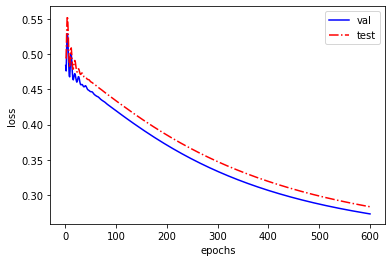

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4926356144, 4943138248]}]
Epoch: 0001 loss_train: 0.6097 acc_train: 0.8150 loss_val: 0.4861 acc_val: 0.8050 time: 0.0019s
Epoch: 0002 loss_train: 0.4740 acc_train: 0.8150 loss_val: 0.5025 acc_val: 0.8050 time: 0.0015s
Epoch: 0003 loss_train: 0.4830 acc_train: 0.8150 loss_val: 0.5406 acc_val: 0.8050 time: 0.0015s
Epoch: 0004 loss_train: 0.5169 acc_train: 0.8150 loss_val: 0.5553 acc_val: 0.8050 time: 0.0014s
Epoch: 0005 loss_train: 0.5302 acc_train: 0.8150 loss_val: 0.5456 acc_val: 0.8050 time: 0.0013s
Epoch: 0006 loss_train: 0.5213 acc_train: 0.8150 loss_val: 0.5219 acc_val: 0.8050 time: 0.0019s
Epoch: 0007 loss_train: 0.4999 acc_train: 0.8150 loss_val: 0.4967 ac

Epoch: 0086 loss_train: 0.4226 acc_train: 0.8150 loss_val: 0.4390 acc_val: 0.8050 time: 0.0020s
Epoch: 0087 loss_train: 0.4220 acc_train: 0.8150 loss_val: 0.4385 acc_val: 0.8050 time: 0.0032s
Epoch: 0088 loss_train: 0.4214 acc_train: 0.8150 loss_val: 0.4380 acc_val: 0.8050 time: 0.0024s
Epoch: 0089 loss_train: 0.4208 acc_train: 0.8150 loss_val: 0.4375 acc_val: 0.8050 time: 0.0016s
Epoch: 0090 loss_train: 0.4202 acc_train: 0.8150 loss_val: 0.4370 acc_val: 0.8050 time: 0.0016s
Epoch: 0091 loss_train: 0.4196 acc_train: 0.8150 loss_val: 0.4364 acc_val: 0.8050 time: 0.0016s
Epoch: 0092 loss_train: 0.4190 acc_train: 0.8150 loss_val: 0.4358 acc_val: 0.8050 time: 0.0026s
Epoch: 0093 loss_train: 0.4183 acc_train: 0.8150 loss_val: 0.4352 acc_val: 0.8050 time: 0.0014s
Epoch: 0094 loss_train: 0.4177 acc_train: 0.8150 loss_val: 0.4345 acc_val: 0.8050 time: 0.0028s
Epoch: 0095 loss_train: 0.4171 acc_train: 0.8150 loss_val: 0.4339 acc_val: 0.8050 time: 0.0014s
Epoch: 0096 loss_train: 0.4165 acc_train

Epoch: 0172 loss_train: 0.3741 acc_train: 0.8150 loss_val: 0.3935 acc_val: 0.8050 time: 0.0026s
Epoch: 0173 loss_train: 0.3736 acc_train: 0.8150 loss_val: 0.3930 acc_val: 0.8050 time: 0.0020s
Epoch: 0174 loss_train: 0.3731 acc_train: 0.8150 loss_val: 0.3926 acc_val: 0.8050 time: 0.0020s
Epoch: 0175 loss_train: 0.3726 acc_train: 0.8150 loss_val: 0.3921 acc_val: 0.8050 time: 0.0023s
Epoch: 0176 loss_train: 0.3721 acc_train: 0.8150 loss_val: 0.3916 acc_val: 0.8050 time: 0.0017s
Epoch: 0177 loss_train: 0.3716 acc_train: 0.8150 loss_val: 0.3911 acc_val: 0.8050 time: 0.0022s
Epoch: 0178 loss_train: 0.3711 acc_train: 0.8150 loss_val: 0.3907 acc_val: 0.8050 time: 0.0015s
Epoch: 0179 loss_train: 0.3706 acc_train: 0.8150 loss_val: 0.3902 acc_val: 0.8050 time: 0.0015s
Epoch: 0180 loss_train: 0.3701 acc_train: 0.8150 loss_val: 0.3897 acc_val: 0.8050 time: 0.0016s
Epoch: 0181 loss_train: 0.3696 acc_train: 0.8150 loss_val: 0.3892 acc_val: 0.8050 time: 0.0014s
Epoch: 0182 loss_train: 0.3691 acc_train

Epoch: 0307 loss_train: 0.3188 acc_train: 0.8300 loss_val: 0.3403 acc_val: 0.8200 time: 0.0019s
Epoch: 0308 loss_train: 0.3185 acc_train: 0.8300 loss_val: 0.3400 acc_val: 0.8200 time: 0.0024s
Epoch: 0309 loss_train: 0.3181 acc_train: 0.8300 loss_val: 0.3397 acc_val: 0.8200 time: 0.0018s
Epoch: 0310 loss_train: 0.3178 acc_train: 0.8300 loss_val: 0.3393 acc_val: 0.8200 time: 0.0015s
Epoch: 0311 loss_train: 0.3175 acc_train: 0.8300 loss_val: 0.3390 acc_val: 0.8200 time: 0.0073s
Epoch: 0312 loss_train: 0.3172 acc_train: 0.8300 loss_val: 0.3387 acc_val: 0.8200 time: 0.0025s
Epoch: 0313 loss_train: 0.3169 acc_train: 0.8300 loss_val: 0.3384 acc_val: 0.8200 time: 0.0016s
Epoch: 0314 loss_train: 0.3166 acc_train: 0.8300 loss_val: 0.3381 acc_val: 0.8200 time: 0.0031s
Epoch: 0315 loss_train: 0.3163 acc_train: 0.8300 loss_val: 0.3378 acc_val: 0.8200 time: 0.0047s
Epoch: 0316 loss_train: 0.3159 acc_train: 0.8300 loss_val: 0.3375 acc_val: 0.8250 time: 0.0021s
Epoch: 0317 loss_train: 0.3156 acc_train

Epoch: 0427 loss_train: 0.2878 acc_train: 0.8650 loss_val: 0.3094 acc_val: 0.8300 time: 0.0023s
Epoch: 0428 loss_train: 0.2876 acc_train: 0.8650 loss_val: 0.3092 acc_val: 0.8300 time: 0.0020s
Epoch: 0429 loss_train: 0.2874 acc_train: 0.8650 loss_val: 0.3090 acc_val: 0.8300 time: 0.0017s
Epoch: 0430 loss_train: 0.2872 acc_train: 0.8650 loss_val: 0.3088 acc_val: 0.8300 time: 0.0019s
Epoch: 0431 loss_train: 0.2870 acc_train: 0.8650 loss_val: 0.3085 acc_val: 0.8300 time: 0.0014s
Epoch: 0432 loss_train: 0.2868 acc_train: 0.8650 loss_val: 0.3083 acc_val: 0.8300 time: 0.0022s
Epoch: 0433 loss_train: 0.2866 acc_train: 0.8650 loss_val: 0.3081 acc_val: 0.8300 time: 0.0014s
Epoch: 0434 loss_train: 0.2864 acc_train: 0.8650 loss_val: 0.3079 acc_val: 0.8300 time: 0.0014s
Epoch: 0435 loss_train: 0.2862 acc_train: 0.8650 loss_val: 0.3077 acc_val: 0.8300 time: 0.0017s
Epoch: 0436 loss_train: 0.2860 acc_train: 0.8650 loss_val: 0.3075 acc_val: 0.8300 time: 0.0014s
Epoch: 0437 loss_train: 0.2858 acc_train

Epoch: 0529 loss_train: 0.2703 acc_train: 0.8850 loss_val: 0.2914 acc_val: 0.8450 time: 0.0020s
Epoch: 0530 loss_train: 0.2701 acc_train: 0.8850 loss_val: 0.2912 acc_val: 0.8450 time: 0.0049s
Epoch: 0531 loss_train: 0.2700 acc_train: 0.8850 loss_val: 0.2911 acc_val: 0.8450 time: 0.0016s
Epoch: 0532 loss_train: 0.2698 acc_train: 0.8850 loss_val: 0.2909 acc_val: 0.8450 time: 0.0021s
Epoch: 0533 loss_train: 0.2697 acc_train: 0.8850 loss_val: 0.2908 acc_val: 0.8450 time: 0.0019s
Epoch: 0534 loss_train: 0.2696 acc_train: 0.8850 loss_val: 0.2906 acc_val: 0.8450 time: 0.0046s
Epoch: 0535 loss_train: 0.2694 acc_train: 0.8850 loss_val: 0.2905 acc_val: 0.8450 time: 0.0019s
Epoch: 0536 loss_train: 0.2693 acc_train: 0.8850 loss_val: 0.2903 acc_val: 0.8450 time: 0.0021s
Epoch: 0537 loss_train: 0.2691 acc_train: 0.8900 loss_val: 0.2902 acc_val: 0.8450 time: 0.0017s
Epoch: 0538 loss_train: 0.2690 acc_train: 0.8900 loss_val: 0.2900 acc_val: 0.8450 time: 0.0032s
Epoch: 0539 loss_train: 0.2689 acc_train

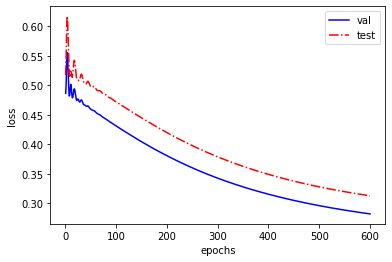

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4943222824, 4943222608]}]
Epoch: 0001 loss_train: 0.7013 acc_train: 0.1950 loss_val: 0.5288 acc_val: 0.7800 time: 0.0022s
Epoch: 0002 loss_train: 0.5053 acc_train: 0.8050 loss_val: 0.5295 acc_val: 0.7800 time: 0.0039s
Epoch: 0003 loss_train: 0.4869 acc_train: 0.8050 loss_val: 0.5811 acc_val: 0.7800 time: 0.0026s
Epoch: 0004 loss_train: 0.5259 acc_train: 0.8050 loss_val: 0.6178 acc_val: 0.7800 time: 0.0021s
Epoch: 0005 loss_train: 0.5561 acc_train: 0.8050 loss_val: 0.6260 acc_val: 0.7800 time: 0.0019s
Epoch: 0006 loss_train: 0.5629 acc_train: 0.8050 loss_val: 0.6106 acc_val: 0.7800 time: 0.0029s
Epoch: 0007 loss_train: 0.5499 acc_train: 0.8050 loss_val: 0.5809 ac

Epoch: 0094 loss_train: 0.4366 acc_train: 0.8050 loss_val: 0.4772 acc_val: 0.7800 time: 0.0053s
Epoch: 0095 loss_train: 0.4361 acc_train: 0.8050 loss_val: 0.4767 acc_val: 0.7800 time: 0.0080s
Epoch: 0096 loss_train: 0.4355 acc_train: 0.8050 loss_val: 0.4764 acc_val: 0.7800 time: 0.0021s
Epoch: 0097 loss_train: 0.4350 acc_train: 0.8050 loss_val: 0.4759 acc_val: 0.7800 time: 0.0031s
Epoch: 0098 loss_train: 0.4344 acc_train: 0.8050 loss_val: 0.4755 acc_val: 0.7800 time: 0.0024s
Epoch: 0099 loss_train: 0.4339 acc_train: 0.8050 loss_val: 0.4750 acc_val: 0.7800 time: 0.0041s
Epoch: 0100 loss_train: 0.4334 acc_train: 0.8050 loss_val: 0.4744 acc_val: 0.7800 time: 0.0014s
Epoch: 0101 loss_train: 0.4328 acc_train: 0.8050 loss_val: 0.4738 acc_val: 0.7800 time: 0.0016s
Epoch: 0102 loss_train: 0.4323 acc_train: 0.8050 loss_val: 0.4732 acc_val: 0.7800 time: 0.0029s
Epoch: 0103 loss_train: 0.4317 acc_train: 0.8050 loss_val: 0.4727 acc_val: 0.7800 time: 0.0015s
Epoch: 0104 loss_train: 0.4312 acc_train

Epoch: 0196 loss_train: 0.3848 acc_train: 0.8050 loss_val: 0.4282 acc_val: 0.7800 time: 0.0043s
Epoch: 0197 loss_train: 0.3844 acc_train: 0.8050 loss_val: 0.4278 acc_val: 0.7800 time: 0.0027s
Epoch: 0198 loss_train: 0.3839 acc_train: 0.8050 loss_val: 0.4273 acc_val: 0.7800 time: 0.0017s
Epoch: 0199 loss_train: 0.3835 acc_train: 0.8050 loss_val: 0.4269 acc_val: 0.7800 time: 0.0022s
Epoch: 0200 loss_train: 0.3830 acc_train: 0.8050 loss_val: 0.4265 acc_val: 0.7800 time: 0.0023s
Epoch: 0201 loss_train: 0.3826 acc_train: 0.8050 loss_val: 0.4260 acc_val: 0.7800 time: 0.0015s
Epoch: 0202 loss_train: 0.3821 acc_train: 0.8050 loss_val: 0.4256 acc_val: 0.7800 time: 0.0031s
Epoch: 0203 loss_train: 0.3817 acc_train: 0.8050 loss_val: 0.4251 acc_val: 0.7800 time: 0.0018s
Epoch: 0204 loss_train: 0.3812 acc_train: 0.8050 loss_val: 0.4247 acc_val: 0.7800 time: 0.0015s
Epoch: 0205 loss_train: 0.3808 acc_train: 0.8050 loss_val: 0.4242 acc_val: 0.7800 time: 0.0015s
Epoch: 0206 loss_train: 0.3803 acc_train

Epoch: 0334 loss_train: 0.3315 acc_train: 0.8250 loss_val: 0.3749 acc_val: 0.8050 time: 0.0021s
Epoch: 0335 loss_train: 0.3312 acc_train: 0.8250 loss_val: 0.3746 acc_val: 0.8050 time: 0.0015s
Epoch: 0336 loss_train: 0.3309 acc_train: 0.8250 loss_val: 0.3743 acc_val: 0.8050 time: 0.0018s
Epoch: 0337 loss_train: 0.3306 acc_train: 0.8250 loss_val: 0.3739 acc_val: 0.8050 time: 0.0025s
Epoch: 0338 loss_train: 0.3303 acc_train: 0.8250 loss_val: 0.3736 acc_val: 0.8050 time: 0.0014s
Epoch: 0339 loss_train: 0.3300 acc_train: 0.8250 loss_val: 0.3733 acc_val: 0.8050 time: 0.0036s
Epoch: 0340 loss_train: 0.3297 acc_train: 0.8250 loss_val: 0.3730 acc_val: 0.8050 time: 0.0014s
Epoch: 0341 loss_train: 0.3294 acc_train: 0.8250 loss_val: 0.3727 acc_val: 0.8100 time: 0.0014s
Epoch: 0342 loss_train: 0.3290 acc_train: 0.8250 loss_val: 0.3724 acc_val: 0.8100 time: 0.0014s
Epoch: 0343 loss_train: 0.3287 acc_train: 0.8250 loss_val: 0.3720 acc_val: 0.8100 time: 0.0017s
Epoch: 0344 loss_train: 0.3284 acc_train

Epoch: 0454 loss_train: 0.3000 acc_train: 0.8350 loss_val: 0.3422 acc_val: 0.8300 time: 0.0019s
Epoch: 0455 loss_train: 0.2998 acc_train: 0.8350 loss_val: 0.3420 acc_val: 0.8350 time: 0.0015s
Epoch: 0456 loss_train: 0.2996 acc_train: 0.8350 loss_val: 0.3417 acc_val: 0.8350 time: 0.0017s
Epoch: 0457 loss_train: 0.2994 acc_train: 0.8350 loss_val: 0.3415 acc_val: 0.8350 time: 0.0014s
Epoch: 0458 loss_train: 0.2991 acc_train: 0.8400 loss_val: 0.3413 acc_val: 0.8350 time: 0.0014s
Epoch: 0459 loss_train: 0.2989 acc_train: 0.8400 loss_val: 0.3411 acc_val: 0.8350 time: 0.0014s
Epoch: 0460 loss_train: 0.2987 acc_train: 0.8400 loss_val: 0.3408 acc_val: 0.8350 time: 0.0014s
Epoch: 0461 loss_train: 0.2985 acc_train: 0.8450 loss_val: 0.3406 acc_val: 0.8350 time: 0.0020s
Epoch: 0462 loss_train: 0.2983 acc_train: 0.8450 loss_val: 0.3404 acc_val: 0.8400 time: 0.0015s
Epoch: 0463 loss_train: 0.2981 acc_train: 0.8450 loss_val: 0.3402 acc_val: 0.8400 time: 0.0014s
Epoch: 0464 loss_train: 0.2979 acc_train

Epoch: 0554 loss_train: 0.2814 acc_train: 0.8650 loss_val: 0.3225 acc_val: 0.8750 time: 0.0022s
Epoch: 0555 loss_train: 0.2813 acc_train: 0.8650 loss_val: 0.3223 acc_val: 0.8750 time: 0.0015s
Epoch: 0556 loss_train: 0.2811 acc_train: 0.8650 loss_val: 0.3222 acc_val: 0.8750 time: 0.0016s
Epoch: 0557 loss_train: 0.2809 acc_train: 0.8650 loss_val: 0.3220 acc_val: 0.8750 time: 0.0017s
Epoch: 0558 loss_train: 0.2808 acc_train: 0.8650 loss_val: 0.3218 acc_val: 0.8750 time: 0.0015s
Epoch: 0559 loss_train: 0.2806 acc_train: 0.8650 loss_val: 0.3217 acc_val: 0.8750 time: 0.0014s
Epoch: 0560 loss_train: 0.2805 acc_train: 0.8650 loss_val: 0.3215 acc_val: 0.8750 time: 0.0025s
Epoch: 0561 loss_train: 0.2803 acc_train: 0.8650 loss_val: 0.3213 acc_val: 0.8750 time: 0.0014s
Epoch: 0562 loss_train: 0.2802 acc_train: 0.8650 loss_val: 0.3212 acc_val: 0.8750 time: 0.0015s
Epoch: 0563 loss_train: 0.2800 acc_train: 0.8650 loss_val: 0.3210 acc_val: 0.8750 time: 0.0014s
Epoch: 0564 loss_train: 0.2799 acc_train

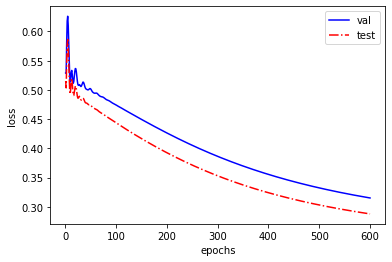

Loading SmallRatio dataset...
finish load data
for SGC, return identity matrix and propagated feats
Model's state_dict:
W1.weight 	 torch.Size([2, 64])
W1.bias 	 torch.Size([2])
optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 5e-05, 'amsgrad': False, 'params': [4947716064, 4947714912]}]
Epoch: 0001 loss_train: 0.7276 acc_train: 0.2200 loss_val: 0.5229 acc_val: 0.7950 time: 0.0026s
Epoch: 0002 loss_train: 0.5356 acc_train: 0.7800 loss_val: 0.4988 acc_val: 0.7950 time: 0.0015s
Epoch: 0003 loss_train: 0.5236 acc_train: 0.7800 loss_val: 0.5338 acc_val: 0.7950 time: 0.0015s
Epoch: 0004 loss_train: 0.5665 acc_train: 0.7800 loss_val: 0.5583 acc_val: 0.7950 time: 0.0019s
Epoch: 0005 loss_train: 0.5945 acc_train: 0.7800 loss_val: 0.5588 acc_val: 0.7950 time: 0.0014s
Epoch: 0006 loss_train: 0.5952 acc_train: 0.7800 loss_val: 0.5415 acc_val: 0.7950 time: 0.0021s
Epoch: 0007 loss_train: 0.5755 acc_train: 0.7800 loss_val: 0.5170 ac

Epoch: 0109 loss_train: 0.4659 acc_train: 0.7800 loss_val: 0.4434 acc_val: 0.7950 time: 0.0020s
Epoch: 0110 loss_train: 0.4653 acc_train: 0.7800 loss_val: 0.4430 acc_val: 0.7950 time: 0.0016s
Epoch: 0111 loss_train: 0.4648 acc_train: 0.7800 loss_val: 0.4424 acc_val: 0.7950 time: 0.0016s
Epoch: 0112 loss_train: 0.4643 acc_train: 0.7800 loss_val: 0.4419 acc_val: 0.7950 time: 0.0016s
Epoch: 0113 loss_train: 0.4637 acc_train: 0.7800 loss_val: 0.4414 acc_val: 0.7950 time: 0.0014s
Epoch: 0114 loss_train: 0.4632 acc_train: 0.7800 loss_val: 0.4408 acc_val: 0.7950 time: 0.0014s
Epoch: 0115 loss_train: 0.4627 acc_train: 0.7800 loss_val: 0.4403 acc_val: 0.7950 time: 0.0032s
Epoch: 0116 loss_train: 0.4621 acc_train: 0.7800 loss_val: 0.4397 acc_val: 0.7950 time: 0.0015s
Epoch: 0117 loss_train: 0.4616 acc_train: 0.7800 loss_val: 0.4392 acc_val: 0.7950 time: 0.0017s
Epoch: 0118 loss_train: 0.4611 acc_train: 0.7800 loss_val: 0.4387 acc_val: 0.7950 time: 0.0015s
Epoch: 0119 loss_train: 0.4606 acc_train

Epoch: 0228 loss_train: 0.4064 acc_train: 0.7800 loss_val: 0.3860 acc_val: 0.7950 time: 0.0019s
Epoch: 0229 loss_train: 0.4060 acc_train: 0.7850 loss_val: 0.3856 acc_val: 0.7950 time: 0.0015s
Epoch: 0230 loss_train: 0.4055 acc_train: 0.7850 loss_val: 0.3852 acc_val: 0.7950 time: 0.0019s
Epoch: 0231 loss_train: 0.4051 acc_train: 0.7850 loss_val: 0.3847 acc_val: 0.7950 time: 0.0015s
Epoch: 0232 loss_train: 0.4046 acc_train: 0.7850 loss_val: 0.3843 acc_val: 0.7950 time: 0.0014s
Epoch: 0233 loss_train: 0.4042 acc_train: 0.7850 loss_val: 0.3839 acc_val: 0.7950 time: 0.0028s
Epoch: 0234 loss_train: 0.4037 acc_train: 0.7850 loss_val: 0.3835 acc_val: 0.7950 time: 0.0015s
Epoch: 0235 loss_train: 0.4033 acc_train: 0.7850 loss_val: 0.3831 acc_val: 0.7950 time: 0.0015s
Epoch: 0236 loss_train: 0.4029 acc_train: 0.7850 loss_val: 0.3826 acc_val: 0.7950 time: 0.0015s
Epoch: 0237 loss_train: 0.4024 acc_train: 0.7850 loss_val: 0.3822 acc_val: 0.7950 time: 0.0015s
Epoch: 0238 loss_train: 0.4020 acc_train

Epoch: 0345 loss_train: 0.3609 acc_train: 0.8150 loss_val: 0.3436 acc_val: 0.8150 time: 0.0019s
Epoch: 0346 loss_train: 0.3606 acc_train: 0.8150 loss_val: 0.3433 acc_val: 0.8150 time: 0.0016s
Epoch: 0347 loss_train: 0.3602 acc_train: 0.8150 loss_val: 0.3430 acc_val: 0.8150 time: 0.0017s
Epoch: 0348 loss_train: 0.3599 acc_train: 0.8150 loss_val: 0.3427 acc_val: 0.8150 time: 0.0019s
Epoch: 0349 loss_train: 0.3596 acc_train: 0.8150 loss_val: 0.3424 acc_val: 0.8150 time: 0.0014s
Epoch: 0350 loss_train: 0.3593 acc_train: 0.8150 loss_val: 0.3421 acc_val: 0.8150 time: 0.0014s
Epoch: 0351 loss_train: 0.3589 acc_train: 0.8150 loss_val: 0.3418 acc_val: 0.8150 time: 0.0015s
Epoch: 0352 loss_train: 0.3586 acc_train: 0.8150 loss_val: 0.3415 acc_val: 0.8150 time: 0.0015s
Epoch: 0353 loss_train: 0.3583 acc_train: 0.8150 loss_val: 0.3412 acc_val: 0.8150 time: 0.0031s
Epoch: 0354 loss_train: 0.3580 acc_train: 0.8150 loss_val: 0.3409 acc_val: 0.8150 time: 0.0014s
Epoch: 0355 loss_train: 0.3576 acc_train

Epoch: 0463 loss_train: 0.3283 acc_train: 0.8550 loss_val: 0.3139 acc_val: 0.8350 time: 0.0020s
Epoch: 0464 loss_train: 0.3281 acc_train: 0.8550 loss_val: 0.3136 acc_val: 0.8350 time: 0.0016s
Epoch: 0465 loss_train: 0.3278 acc_train: 0.8550 loss_val: 0.3134 acc_val: 0.8350 time: 0.0020s
Epoch: 0466 loss_train: 0.3276 acc_train: 0.8600 loss_val: 0.3132 acc_val: 0.8350 time: 0.0019s
Epoch: 0467 loss_train: 0.3274 acc_train: 0.8600 loss_val: 0.3130 acc_val: 0.8350 time: 0.0014s
Epoch: 0468 loss_train: 0.3272 acc_train: 0.8600 loss_val: 0.3128 acc_val: 0.8400 time: 0.0014s
Epoch: 0469 loss_train: 0.3269 acc_train: 0.8600 loss_val: 0.3126 acc_val: 0.8400 time: 0.0015s
Epoch: 0470 loss_train: 0.3267 acc_train: 0.8600 loss_val: 0.3124 acc_val: 0.8400 time: 0.0029s
Epoch: 0471 loss_train: 0.3265 acc_train: 0.8600 loss_val: 0.3122 acc_val: 0.8400 time: 0.0015s
Epoch: 0472 loss_train: 0.3263 acc_train: 0.8600 loss_val: 0.3120 acc_val: 0.8400 time: 0.0014s
Epoch: 0473 loss_train: 0.3261 acc_train

Epoch: 0582 loss_train: 0.3056 acc_train: 0.8700 loss_val: 0.2933 acc_val: 0.8600 time: 0.0018s
Epoch: 0583 loss_train: 0.3054 acc_train: 0.8700 loss_val: 0.2931 acc_val: 0.8650 time: 0.0016s
Epoch: 0584 loss_train: 0.3053 acc_train: 0.8700 loss_val: 0.2930 acc_val: 0.8650 time: 0.0016s
Epoch: 0585 loss_train: 0.3051 acc_train: 0.8700 loss_val: 0.2928 acc_val: 0.8650 time: 0.0015s
Epoch: 0586 loss_train: 0.3050 acc_train: 0.8700 loss_val: 0.2927 acc_val: 0.8650 time: 0.0015s
Epoch: 0587 loss_train: 0.3048 acc_train: 0.8700 loss_val: 0.2925 acc_val: 0.8650 time: 0.0020s
Epoch: 0588 loss_train: 0.3047 acc_train: 0.8700 loss_val: 0.2924 acc_val: 0.8650 time: 0.0015s
Epoch: 0589 loss_train: 0.3045 acc_train: 0.8700 loss_val: 0.2923 acc_val: 0.8650 time: 0.0016s
Epoch: 0590 loss_train: 0.3044 acc_train: 0.8700 loss_val: 0.2921 acc_val: 0.8650 time: 0.0015s
Epoch: 0591 loss_train: 0.3042 acc_train: 0.8700 loss_val: 0.2920 acc_val: 0.8650 time: 0.0015s
Epoch: 0592 loss_train: 0.3041 acc_train

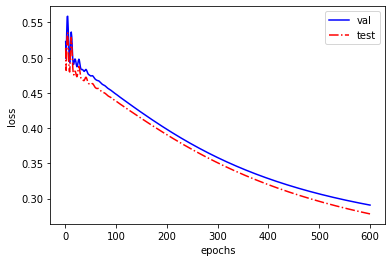

In [6]:
acc = []
for runs in range(10):
    for i in range(5):
        acc.append(get_result(dataset_name, split_index=i))

In [7]:
acc = np.array(acc)
acc100 = acc*100
mean = acc100.mean()#*100
var = acc100.var()#*10000
print(mean,var)

87.14 2.7804


In [8]:
print(acc100)

[89.  85.  85.  87.5 90.  89.5 86.  85.  87.  89.5 88.5 85.  85.5 87.
 88.5 88.5 85.  85.5 87.  89.5 87.5 86.  85.5 87.  90.5 86.5 85.  85.
 87.5 90.  88.5 85.5 85.  87.5 89.  88.5 85.  85.5 87.5 88.5 88.5 86.
 85.  87.  89.5 87.5 86.  87.  87.  89. ]


In [9]:
acc_mean = []

In [10]:
for i in range(10):
    print(acc[5*i:5*(i+1)].mean())
    acc_mean.append(acc[5*i:5*(i+1)].mean())

    

0.873
0.874
0.869
0.8710000000000001
0.873
0.868
0.8709999999999999
0.8699999999999999
0.8720000000000001
0.873


In [11]:
acc_mean = np.array(acc_mean)
mean = acc_mean.mean()*100
var = acc_mean.var()*10000

In [12]:
print(mean,var)

87.13999999999999 0.03440000000000051


In [13]:
np.sqrt(var)

0.18547236990991545

In [14]:
w1 = [1.0621e-04, 2.1622e-03, 5.9494e-03, 8.0612e-03, 9.2637e-01, 3.8904e-03,5.3464e-02]
w2= [1.0006e-04, 1.3488e-03, 3.0805e-03, 4.8974e-03, 9.4331e-01, 2.4754e-03, 4.4786e-02]
w3 = [1.1060e-04, 1.7723e-03, 5.1948e-03, 6.4515e-03, 9.3207e-01, 3.1631e-03,  5.1242e-02]
w4 = [9.4653e-05, 1.3430e-03, 3.7217e-03, 4.3682e-03, 9.4625e-01, 2.2844e-03, 4.1939e-02]
w5 = [1.0736e-04, 1.7591e-03, 4.3346e-03, 7.2223e-03, 9.3431e-01, 3.2853e-03,4.8986e-02]